### Кейс 2 - определение ССЗ

ссылка на соревнование - https://mlbootcamp.ru/ru/round/12/sandbox/

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, precision_score, recall_score, f1_score, plot_confusion_matrix, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import itertools
from sklearn.model_selection import GridSearchCV

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [2]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

/Users/Viktoryia/Documents/gb/env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1

Разделим наши данные на тренировочную и тестовую выборки

In [3]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

/var/folders/lw/sfx9kxt17jj8cb5s59ll44q80000gp/T/ipykernel_33784/3802500363.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1),


К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [4]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [5]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор и запустим кросс-валидацию

In [6]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7867401104915408+-0.00852135511666111


Посчитаем precision/recall/f_score

In [7]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838


Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

In [6]:
def show_curve(y_test, y_score):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    #plt.savefig("ROC.png")
    plt.show()


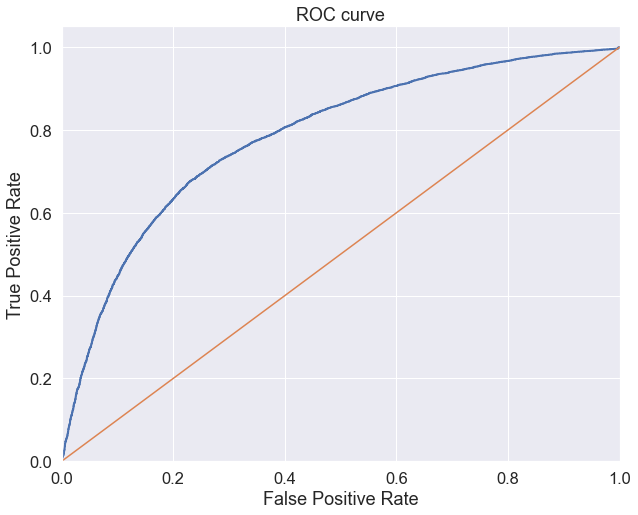

In [9]:
show_curve(y_test, y_score)

In [10]:
from sklearn.metrics import roc_auc_score, log_loss

#Ваш код здесь
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.7840347790421852
log loss score: 0.5779604008230668


In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Посомтрим на матрицу ошибок

In [23]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
def error_matrix(y_test, y_score, thresholds, ix):
    
    font = {'size' : 15}

    plt.rc('font', **font)

    cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
    plt.savefig("conf_matrix.png")
    plt.show()

Confusion matrix, without normalization
[[4861 3959]
 [1411 7269]]


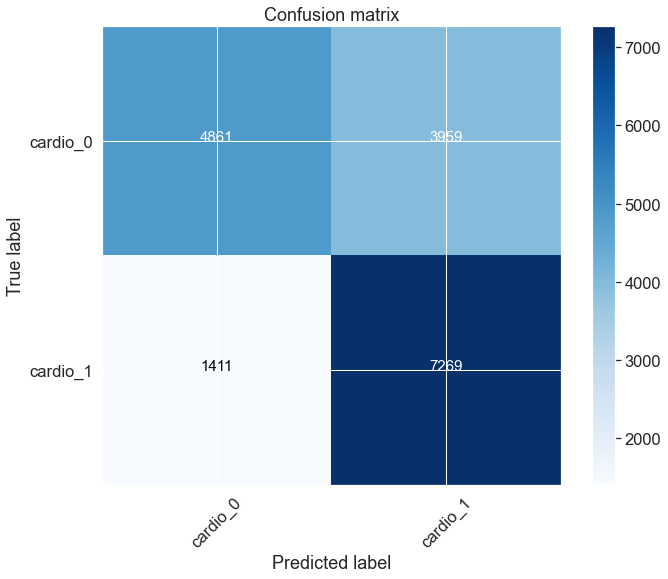

In [13]:
error_matrix(y_test, y_score, ix)

Посчитаем FPR, TPR

In [14]:
cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.837442396313364, 0.44886621315192743, 0.5511337868480726)

### Домашнее задание

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

### Ссылки

1. https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/
2. https://en.wikipedia.org/wiki/Receiver_operating_characteristic

In [24]:
def show_metrics(y_test, y_preds, show=False):
    b=1
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_preds)
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    ix = np.argmax(fscore)

    precision = precision[ix]
    recall = recall[ix]
    f_score = fscore[ix]
    auc = roc_auc_score(y_test, y_preds)
    if show:
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(f'F1_score: {f_score}')
        print(f'Roc_auc_score: {auc}')
        print(f'Best Threshold: {thresholds[ix]}')
    else:    
        return precision, recall, f_score, auc, thresholds, ix   

    

In [9]:
# функция для демонстрации метрик
def cv(classifier, x_train, y_train, n_folds, scoring):
    c_val = cross_val_score(classifier, x_train, y_train, cv=n_folds, scoring=scoring)
    c_mean = np.mean(c_val)
    c_std = np.std(c_val)
    for ind, el in enumerate(c_val):
        print(f'fold_{ind} : {el}')
        
    print(f'Mean {scoring}: {c_mean}, STD : {c_std}')    

In [10]:
def count_ft(y_test, y_score, treshhold, ix):
    cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
    TN = cnf_matrix[0][0]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]

    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    TNR = TN/(FP+TN)
    print(TPR, FPR, TNR)
    

In [19]:
models_dict = {'random_forest': RandomForestClassifier(),
              'bagging': BaggingClassifier(),
              'catboost': CatBoostClassifier(verbose=False)}

In [18]:
# recall в данной ситуации взять этичнее, но и на precision посмотрим, просто переопределив словарь моделей
for name, model in models_dict.items():
    model.fit(X_train, y_train)
    print(name)
    cv(model, X_train, y_train, 5, 'recall')

random_forest
fold_0 : 0.7001901140684411
fold_1 : 0.7011406844106464
fold_2 : 0.7064638783269962
fold_3 : 0.7007604562737643
fold_4 : 0.6919566457501426
Mean recall: 0.7001023557659981, STD : 0.004654900323933121
bagging
fold_0 : 0.6418250950570342
fold_1 : 0.6477186311787072
fold_2 : 0.6444866920152091
fold_3 : 0.6494296577946768
fold_4 : 0.6470811941433733
Mean recall: 0.6461082540378001, STD : 0.00266632946759428
catboost
fold_0 : 0.7007604562737643
fold_1 : 0.6984790874524714
fold_2 : 0.7019011406844107
fold_3 : 0.6975285171102662
fold_4 : 0.6930975470621791
Mean recall: 0.6983533497166183, STD : 0.003056161091229771


In [20]:
for name, model in models_dict.items():
    model.fit(X_train, y_train)
    print(name)
    cv(model, X_train, y_train, 5, 'precision')

random_forest
fold_0 : 0.7365785256410257
fold_1 : 0.7395562662402558
fold_2 : 0.738602428827394
fold_3 : 0.7284951552303738
fold_4 : 0.7375785844656256
Mean precision: 0.7361621920809351, STD : 0.003960743613673306
bagging
fold_0 : 0.7279569892473118
fold_1 : 0.7293764731090636
fold_2 : 0.724342663273961
fold_3 : 0.7200595617953627
fold_4 : 0.7266279819471309
Mean precision: 0.725672733874566, STD : 0.0032595948950308305
catboost
fold_0 : 0.7536291147004702
fold_1 : 0.7553453947368421
fold_2 : 0.7548558576978123
fold_3 : 0.7490812576561862
fold_4 : 0.7635106828655216
Mean precision: 0.7552844615313664, STD : 0.0046707182100354985


In [11]:
# Все эти модели отрабатывают почти одинаково, 
# catboost чуть-чуть лучше, возьмем его и пропустим через 
# grig_search
catboost_model = CatBoostClassifier()

grid = {'iterations':[500, 1000],
        'learning_rate':[0.03, 0.05, 0.1],
       'l2_leaf_reg':[1, 3, 5],
       'min_data_in_leaf':[1, 5, 10]}

search_result = catboost_model.grid_search(grid, X_train, y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6841838	test: 0.6843645	best: 0.6843645 (0)	total: 82.6ms	remaining: 41.2s
1:	learn: 0.6756674	test: 0.6760915	best: 0.6760915 (1)	total: 101ms	remaining: 25.3s
2:	learn: 0.6678131	test: 0.6685362	best: 0.6685362 (2)	total: 118ms	remaining: 19.5s
3:	learn: 0.6602965	test: 0.6612519	best: 0.6612519 (3)	total: 132ms	remaining: 16.4s
4:	learn: 0.6535447	test: 0.6546843	best: 0.6546843 (4)	total: 158ms	remaining: 15.7s
5:	learn: 0.6469589	test: 0.6483041	best: 0.6483041 (5)	total: 178ms	remaining: 14.7s
6:	learn: 0.6408702	test: 0.6423573	best: 0.6423573 (6)	total: 199ms	remaining: 14s
7:	learn: 0.6351037	test: 0.6367725	best: 0.6367725 (7)	total: 213ms	remaining: 13.1s
8:	learn: 0.6297298	test: 0.6316380	best: 0.6316380 (8)	total: 227ms	remaining: 12.4s
9:	learn: 0.6247021	test: 0.6267863	best: 0.6267863 (9)	total: 252ms	remaining: 12.3s
10:	learn: 0.6198760	test: 0.6221253	best: 0.6221253 (10)	total: 273ms	remaining: 12.1s
11:	learn: 0.6153662	test: 0.6178413	best: 0.6178413 

97:	learn: 0.5382484	test: 0.5477253	best: 0.5477253 (97)	total: 1.4s	remaining: 5.75s
98:	learn: 0.5381353	test: 0.5476599	best: 0.5476599 (98)	total: 1.43s	remaining: 5.78s
99:	learn: 0.5380123	test: 0.5476058	best: 0.5476058 (99)	total: 1.44s	remaining: 5.75s
100:	learn: 0.5378795	test: 0.5475136	best: 0.5475136 (100)	total: 1.45s	remaining: 5.71s
101:	learn: 0.5377885	test: 0.5474688	best: 0.5474688 (101)	total: 1.45s	remaining: 5.67s
102:	learn: 0.5376792	test: 0.5473893	best: 0.5473893 (102)	total: 1.46s	remaining: 5.63s
103:	learn: 0.5375806	test: 0.5473359	best: 0.5473359 (103)	total: 1.47s	remaining: 5.58s
104:	learn: 0.5374777	test: 0.5472955	best: 0.5472955 (104)	total: 1.47s	remaining: 5.54s
105:	learn: 0.5373646	test: 0.5472195	best: 0.5472195 (105)	total: 1.48s	remaining: 5.5s
106:	learn: 0.5372759	test: 0.5471413	best: 0.5471413 (106)	total: 1.49s	remaining: 5.46s
107:	learn: 0.5371541	test: 0.5470753	best: 0.5470753 (107)	total: 1.49s	remaining: 5.42s
108:	learn: 0.5370

197:	learn: 0.5318115	test: 0.5450707	best: 0.5450707 (197)	total: 2.21s	remaining: 3.37s
198:	learn: 0.5317570	test: 0.5450486	best: 0.5450486 (198)	total: 2.23s	remaining: 3.37s
199:	learn: 0.5316872	test: 0.5450589	best: 0.5450486 (198)	total: 2.25s	remaining: 3.38s
200:	learn: 0.5316363	test: 0.5450706	best: 0.5450486 (198)	total: 2.26s	remaining: 3.36s
201:	learn: 0.5316038	test: 0.5450742	best: 0.5450486 (198)	total: 2.26s	remaining: 3.34s
202:	learn: 0.5315602	test: 0.5450625	best: 0.5450486 (198)	total: 2.27s	remaining: 3.32s
203:	learn: 0.5315156	test: 0.5450497	best: 0.5450486 (198)	total: 2.28s	remaining: 3.31s
204:	learn: 0.5314857	test: 0.5450655	best: 0.5450486 (198)	total: 2.28s	remaining: 3.29s
205:	learn: 0.5314677	test: 0.5450552	best: 0.5450486 (198)	total: 2.29s	remaining: 3.27s
206:	learn: 0.5314447	test: 0.5450467	best: 0.5450467 (206)	total: 2.3s	remaining: 3.25s
207:	learn: 0.5313989	test: 0.5450363	best: 0.5450363 (207)	total: 2.3s	remaining: 3.23s
208:	learn: 

304:	learn: 0.5279351	test: 0.5443624	best: 0.5443391 (299)	total: 3.05s	remaining: 1.95s
305:	learn: 0.5279147	test: 0.5443464	best: 0.5443391 (299)	total: 3.07s	remaining: 1.95s
306:	learn: 0.5278866	test: 0.5443628	best: 0.5443391 (299)	total: 3.08s	remaining: 1.93s
307:	learn: 0.5278480	test: 0.5443588	best: 0.5443391 (299)	total: 3.08s	remaining: 1.92s
308:	learn: 0.5277822	test: 0.5443800	best: 0.5443391 (299)	total: 3.09s	remaining: 1.91s
309:	learn: 0.5277565	test: 0.5443684	best: 0.5443391 (299)	total: 3.1s	remaining: 1.9s
310:	learn: 0.5277325	test: 0.5443588	best: 0.5443391 (299)	total: 3.1s	remaining: 1.89s
311:	learn: 0.5277033	test: 0.5443438	best: 0.5443391 (299)	total: 3.11s	remaining: 1.87s
312:	learn: 0.5276458	test: 0.5443365	best: 0.5443365 (312)	total: 3.12s	remaining: 1.86s
313:	learn: 0.5276210	test: 0.5443428	best: 0.5443365 (312)	total: 3.12s	remaining: 1.85s
314:	learn: 0.5275862	test: 0.5443511	best: 0.5443365 (312)	total: 3.13s	remaining: 1.84s
315:	learn: 0

406:	learn: 0.5245617	test: 0.5441343	best: 0.5440839 (385)	total: 3.87s	remaining: 884ms
407:	learn: 0.5245141	test: 0.5441185	best: 0.5440839 (385)	total: 3.88s	remaining: 876ms
408:	learn: 0.5244838	test: 0.5441165	best: 0.5440839 (385)	total: 3.89s	remaining: 866ms
409:	learn: 0.5244510	test: 0.5441288	best: 0.5440839 (385)	total: 3.9s	remaining: 855ms
410:	learn: 0.5244153	test: 0.5441404	best: 0.5440839 (385)	total: 3.9s	remaining: 846ms
411:	learn: 0.5244009	test: 0.5441432	best: 0.5440839 (385)	total: 3.91s	remaining: 836ms
412:	learn: 0.5243628	test: 0.5441440	best: 0.5440839 (385)	total: 3.92s	remaining: 826ms
413:	learn: 0.5243309	test: 0.5441569	best: 0.5440839 (385)	total: 3.92s	remaining: 815ms
414:	learn: 0.5242701	test: 0.5441610	best: 0.5440839 (385)	total: 3.93s	remaining: 805ms
415:	learn: 0.5242222	test: 0.5441588	best: 0.5440839 (385)	total: 3.94s	remaining: 795ms
416:	learn: 0.5241714	test: 0.5441362	best: 0.5440839 (385)	total: 3.95s	remaining: 787ms
417:	learn: 

7:	learn: 0.6091803	test: 0.6117930	best: 0.6117930 (7)	total: 50.6ms	remaining: 3.11s
8:	learn: 0.6028877	test: 0.6057435	best: 0.6057435 (8)	total: 70.2ms	remaining: 3.83s
9:	learn: 0.5971180	test: 0.6001619	best: 0.6001619 (9)	total: 84.2ms	remaining: 4.12s
10:	learn: 0.5922949	test: 0.5955538	best: 0.5955538 (10)	total: 94.9ms	remaining: 4.22s
11:	learn: 0.5875994	test: 0.5911596	best: 0.5911596 (11)	total: 101ms	remaining: 4.1s
12:	learn: 0.5834938	test: 0.5872798	best: 0.5872798 (12)	total: 108ms	remaining: 4.03s
13:	learn: 0.5796691	test: 0.5835710	best: 0.5835710 (13)	total: 114ms	remaining: 3.96s
14:	learn: 0.5766393	test: 0.5808003	best: 0.5808003 (14)	total: 125ms	remaining: 4.05s
15:	learn: 0.5736417	test: 0.5780046	best: 0.5780046 (15)	total: 132ms	remaining: 4s
16:	learn: 0.5707839	test: 0.5753439	best: 0.5753439 (16)	total: 143ms	remaining: 4.07s
17:	learn: 0.5682248	test: 0.5729390	best: 0.5729390 (17)	total: 152ms	remaining: 4.06s
18:	learn: 0.5660098	test: 0.5708813	b

104:	learn: 0.5327511	test: 0.5451728	best: 0.5451728 (104)	total: 1.53s	remaining: 5.75s
105:	learn: 0.5326616	test: 0.5451584	best: 0.5451584 (105)	total: 1.55s	remaining: 5.75s
106:	learn: 0.5325669	test: 0.5451117	best: 0.5451117 (106)	total: 1.57s	remaining: 5.76s
107:	learn: 0.5325068	test: 0.5450803	best: 0.5450803 (107)	total: 1.58s	remaining: 5.73s
108:	learn: 0.5324485	test: 0.5450773	best: 0.5450773 (108)	total: 1.6s	remaining: 5.74s
109:	learn: 0.5323790	test: 0.5450721	best: 0.5450721 (109)	total: 1.63s	remaining: 5.78s
110:	learn: 0.5323379	test: 0.5450446	best: 0.5450446 (110)	total: 1.64s	remaining: 5.74s
111:	learn: 0.5322295	test: 0.5450136	best: 0.5450136 (111)	total: 1.65s	remaining: 5.7s
112:	learn: 0.5321861	test: 0.5449861	best: 0.5449861 (112)	total: 1.65s	remaining: 5.66s
113:	learn: 0.5321090	test: 0.5449762	best: 0.5449762 (113)	total: 1.66s	remaining: 5.63s
114:	learn: 0.5320541	test: 0.5449611	best: 0.5449611 (114)	total: 1.67s	remaining: 5.58s
115:	learn: 

207:	learn: 0.5263169	test: 0.5438775	best: 0.5438775 (207)	total: 2.55s	remaining: 3.58s
208:	learn: 0.5262529	test: 0.5438407	best: 0.5438407 (208)	total: 2.61s	remaining: 3.63s
209:	learn: 0.5262225	test: 0.5438433	best: 0.5438407 (208)	total: 2.65s	remaining: 3.66s
210:	learn: 0.5261471	test: 0.5438319	best: 0.5438319 (210)	total: 2.67s	remaining: 3.66s
211:	learn: 0.5261108	test: 0.5438029	best: 0.5438029 (211)	total: 2.71s	remaining: 3.68s
212:	learn: 0.5260604	test: 0.5437657	best: 0.5437657 (212)	total: 2.71s	remaining: 3.66s
213:	learn: 0.5259933	test: 0.5437468	best: 0.5437468 (213)	total: 2.72s	remaining: 3.64s
214:	learn: 0.5259424	test: 0.5437521	best: 0.5437468 (213)	total: 2.73s	remaining: 3.62s
215:	learn: 0.5259027	test: 0.5437384	best: 0.5437384 (215)	total: 2.74s	remaining: 3.61s
216:	learn: 0.5258194	test: 0.5437071	best: 0.5437071 (216)	total: 2.76s	remaining: 3.6s
217:	learn: 0.5258009	test: 0.5437059	best: 0.5437059 (217)	total: 2.77s	remaining: 3.58s
218:	learn:

315:	learn: 0.5202822	test: 0.5439467	best: 0.5436378 (261)	total: 3.57s	remaining: 2.08s
316:	learn: 0.5202483	test: 0.5439540	best: 0.5436378 (261)	total: 3.59s	remaining: 2.07s
317:	learn: 0.5201797	test: 0.5439781	best: 0.5436378 (261)	total: 3.62s	remaining: 2.07s
318:	learn: 0.5201461	test: 0.5439668	best: 0.5436378 (261)	total: 3.62s	remaining: 2.05s
319:	learn: 0.5200779	test: 0.5439440	best: 0.5436378 (261)	total: 3.63s	remaining: 2.04s
320:	learn: 0.5199990	test: 0.5439489	best: 0.5436378 (261)	total: 3.64s	remaining: 2.03s
321:	learn: 0.5199437	test: 0.5439499	best: 0.5436378 (261)	total: 3.65s	remaining: 2.02s
322:	learn: 0.5199011	test: 0.5439808	best: 0.5436378 (261)	total: 3.66s	remaining: 2s
323:	learn: 0.5198626	test: 0.5439633	best: 0.5436378 (261)	total: 3.66s	remaining: 1.99s
324:	learn: 0.5197790	test: 0.5439597	best: 0.5436378 (261)	total: 3.67s	remaining: 1.98s
325:	learn: 0.5197270	test: 0.5439554	best: 0.5436378 (261)	total: 3.68s	remaining: 1.96s
326:	learn: 0

415:	learn: 0.5151050	test: 0.5441283	best: 0.5436378 (261)	total: 4.38s	remaining: 885ms
416:	learn: 0.5150785	test: 0.5441245	best: 0.5436378 (261)	total: 4.4s	remaining: 876ms
417:	learn: 0.5150434	test: 0.5441121	best: 0.5436378 (261)	total: 4.41s	remaining: 865ms
418:	learn: 0.5150179	test: 0.5441160	best: 0.5436378 (261)	total: 4.42s	remaining: 855ms
419:	learn: 0.5149479	test: 0.5441133	best: 0.5436378 (261)	total: 4.43s	remaining: 844ms
420:	learn: 0.5148656	test: 0.5441164	best: 0.5436378 (261)	total: 4.44s	remaining: 833ms
421:	learn: 0.5148205	test: 0.5441284	best: 0.5436378 (261)	total: 4.44s	remaining: 821ms
422:	learn: 0.5147657	test: 0.5441359	best: 0.5436378 (261)	total: 4.45s	remaining: 810ms
423:	learn: 0.5147228	test: 0.5441528	best: 0.5436378 (261)	total: 4.46s	remaining: 799ms
424:	learn: 0.5146566	test: 0.5441412	best: 0.5436378 (261)	total: 4.46s	remaining: 788ms
425:	learn: 0.5146067	test: 0.5441384	best: 0.5436378 (261)	total: 4.47s	remaining: 777ms
426:	learn:

18:	learn: 0.5444150	test: 0.5527819	best: 0.5527819 (18)	total: 140ms	remaining: 3.54s
19:	learn: 0.5434774	test: 0.5519371	best: 0.5519371 (19)	total: 156ms	remaining: 3.73s
20:	learn: 0.5426875	test: 0.5512607	best: 0.5512607 (20)	total: 172ms	remaining: 3.93s
21:	learn: 0.5420386	test: 0.5508146	best: 0.5508146 (21)	total: 180ms	remaining: 3.92s
22:	learn: 0.5411510	test: 0.5501779	best: 0.5501779 (22)	total: 187ms	remaining: 3.88s
23:	learn: 0.5405972	test: 0.5496580	best: 0.5496580 (23)	total: 195ms	remaining: 3.87s
24:	learn: 0.5400430	test: 0.5493810	best: 0.5493810 (24)	total: 203ms	remaining: 3.86s
25:	learn: 0.5395045	test: 0.5491151	best: 0.5491151 (25)	total: 210ms	remaining: 3.82s
26:	learn: 0.5391113	test: 0.5488528	best: 0.5488528 (26)	total: 216ms	remaining: 3.78s
27:	learn: 0.5386261	test: 0.5486136	best: 0.5486136 (27)	total: 222ms	remaining: 3.75s
28:	learn: 0.5381802	test: 0.5482757	best: 0.5482757 (28)	total: 229ms	remaining: 3.72s
29:	learn: 0.5377563	test: 0.548

125:	learn: 0.5243044	test: 0.5448200	best: 0.5448200 (125)	total: 1.39s	remaining: 4.13s
126:	learn: 0.5241946	test: 0.5448125	best: 0.5448125 (126)	total: 1.4s	remaining: 4.12s
127:	learn: 0.5240301	test: 0.5447653	best: 0.5447653 (127)	total: 1.42s	remaining: 4.13s
128:	learn: 0.5239425	test: 0.5447971	best: 0.5447653 (127)	total: 1.43s	remaining: 4.11s
129:	learn: 0.5237776	test: 0.5448294	best: 0.5447653 (127)	total: 1.44s	remaining: 4.09s
130:	learn: 0.5235827	test: 0.5447834	best: 0.5447653 (127)	total: 1.45s	remaining: 4.08s
131:	learn: 0.5234737	test: 0.5447865	best: 0.5447653 (127)	total: 1.46s	remaining: 4.06s
132:	learn: 0.5234187	test: 0.5447962	best: 0.5447653 (127)	total: 1.46s	remaining: 4.04s
133:	learn: 0.5233570	test: 0.5448251	best: 0.5447653 (127)	total: 1.47s	remaining: 4.01s
134:	learn: 0.5231649	test: 0.5447719	best: 0.5447653 (127)	total: 1.48s	remaining: 3.99s
135:	learn: 0.5230132	test: 0.5447672	best: 0.5447653 (127)	total: 1.48s	remaining: 3.96s
136:	learn:

229:	learn: 0.5128345	test: 0.5453337	best: 0.5444278 (150)	total: 2.21s	remaining: 2.59s
230:	learn: 0.5127341	test: 0.5453165	best: 0.5444278 (150)	total: 2.22s	remaining: 2.59s
231:	learn: 0.5125963	test: 0.5453570	best: 0.5444278 (150)	total: 2.24s	remaining: 2.59s
232:	learn: 0.5125485	test: 0.5454127	best: 0.5444278 (150)	total: 2.25s	remaining: 2.57s
233:	learn: 0.5124491	test: 0.5454044	best: 0.5444278 (150)	total: 2.26s	remaining: 2.57s
234:	learn: 0.5123467	test: 0.5453957	best: 0.5444278 (150)	total: 2.27s	remaining: 2.55s
235:	learn: 0.5123081	test: 0.5454249	best: 0.5444278 (150)	total: 2.27s	remaining: 2.54s
236:	learn: 0.5122303	test: 0.5454271	best: 0.5444278 (150)	total: 2.28s	remaining: 2.53s
237:	learn: 0.5120958	test: 0.5454265	best: 0.5444278 (150)	total: 2.29s	remaining: 2.52s
238:	learn: 0.5120492	test: 0.5454030	best: 0.5444278 (150)	total: 2.29s	remaining: 2.5s
239:	learn: 0.5119750	test: 0.5454190	best: 0.5444278 (150)	total: 2.3s	remaining: 2.49s
240:	learn: 

333:	learn: 0.5031133	test: 0.5463151	best: 0.5444278 (150)	total: 3.03s	remaining: 1.51s
334:	learn: 0.5029835	test: 0.5463303	best: 0.5444278 (150)	total: 3.04s	remaining: 1.5s
335:	learn: 0.5028660	test: 0.5463827	best: 0.5444278 (150)	total: 3.06s	remaining: 1.49s
336:	learn: 0.5028308	test: 0.5463853	best: 0.5444278 (150)	total: 3.08s	remaining: 1.49s
337:	learn: 0.5027806	test: 0.5463997	best: 0.5444278 (150)	total: 3.08s	remaining: 1.48s
338:	learn: 0.5026717	test: 0.5463240	best: 0.5444278 (150)	total: 3.09s	remaining: 1.47s
339:	learn: 0.5026255	test: 0.5463152	best: 0.5444278 (150)	total: 3.1s	remaining: 1.46s
340:	learn: 0.5025961	test: 0.5463254	best: 0.5444278 (150)	total: 3.1s	remaining: 1.45s
341:	learn: 0.5025238	test: 0.5463292	best: 0.5444278 (150)	total: 3.11s	remaining: 1.44s
342:	learn: 0.5024338	test: 0.5463532	best: 0.5444278 (150)	total: 3.12s	remaining: 1.43s
343:	learn: 0.5023629	test: 0.5463533	best: 0.5444278 (150)	total: 3.12s	remaining: 1.42s
344:	learn: 0

437:	learn: 0.4948294	test: 0.5470739	best: 0.5444278 (150)	total: 3.86s	remaining: 546ms
438:	learn: 0.4947764	test: 0.5470927	best: 0.5444278 (150)	total: 3.88s	remaining: 540ms
439:	learn: 0.4947234	test: 0.5470473	best: 0.5444278 (150)	total: 3.89s	remaining: 531ms
440:	learn: 0.4946537	test: 0.5470235	best: 0.5444278 (150)	total: 3.9s	remaining: 522ms
441:	learn: 0.4945776	test: 0.5470659	best: 0.5444278 (150)	total: 3.91s	remaining: 513ms
442:	learn: 0.4945231	test: 0.5471022	best: 0.5444278 (150)	total: 3.91s	remaining: 504ms
443:	learn: 0.4943740	test: 0.5470572	best: 0.5444278 (150)	total: 3.92s	remaining: 494ms
444:	learn: 0.4942903	test: 0.5470862	best: 0.5444278 (150)	total: 3.93s	remaining: 485ms
445:	learn: 0.4942139	test: 0.5471067	best: 0.5444278 (150)	total: 3.94s	remaining: 477ms
446:	learn: 0.4941536	test: 0.5471915	best: 0.5444278 (150)	total: 3.94s	remaining: 467ms
447:	learn: 0.4940717	test: 0.5471758	best: 0.5444278 (150)	total: 3.95s	remaining: 458ms
448:	learn:

39:	learn: 0.5576951	test: 0.5635604	best: 0.5635604 (39)	total: 305ms	remaining: 3.51s
40:	learn: 0.5568274	test: 0.5627784	best: 0.5627784 (40)	total: 332ms	remaining: 3.71s
41:	learn: 0.5559779	test: 0.5620283	best: 0.5620283 (41)	total: 346ms	remaining: 3.77s
42:	learn: 0.5552068	test: 0.5613516	best: 0.5613516 (42)	total: 353ms	remaining: 3.75s
43:	learn: 0.5545585	test: 0.5607974	best: 0.5607974 (43)	total: 359ms	remaining: 3.72s
44:	learn: 0.5538149	test: 0.5601474	best: 0.5601474 (44)	total: 366ms	remaining: 3.7s
45:	learn: 0.5531983	test: 0.5596041	best: 0.5596041 (45)	total: 372ms	remaining: 3.67s
46:	learn: 0.5525302	test: 0.5590468	best: 0.5590468 (46)	total: 379ms	remaining: 3.65s
47:	learn: 0.5518950	test: 0.5585226	best: 0.5585226 (47)	total: 385ms	remaining: 3.63s
48:	learn: 0.5513365	test: 0.5580570	best: 0.5580570 (48)	total: 394ms	remaining: 3.62s
49:	learn: 0.5507762	test: 0.5575956	best: 0.5575956 (49)	total: 400ms	remaining: 3.6s
50:	learn: 0.5502136	test: 0.55711

134:	learn: 0.5348809	test: 0.5460075	best: 0.5460075 (134)	total: 1.33s	remaining: 3.6s
135:	learn: 0.5348069	test: 0.5459690	best: 0.5459690 (135)	total: 1.35s	remaining: 3.6s
136:	learn: 0.5347556	test: 0.5459745	best: 0.5459690 (135)	total: 1.36s	remaining: 3.61s
137:	learn: 0.5346669	test: 0.5459410	best: 0.5459410 (137)	total: 1.38s	remaining: 3.62s
138:	learn: 0.5346040	test: 0.5459284	best: 0.5459284 (138)	total: 1.4s	remaining: 3.63s
139:	learn: 0.5345603	test: 0.5459046	best: 0.5459046 (139)	total: 1.42s	remaining: 3.66s
140:	learn: 0.5345152	test: 0.5458679	best: 0.5458679 (140)	total: 1.44s	remaining: 3.66s
141:	learn: 0.5344732	test: 0.5458340	best: 0.5458340 (141)	total: 1.45s	remaining: 3.66s
142:	learn: 0.5344289	test: 0.5458021	best: 0.5458021 (142)	total: 1.47s	remaining: 3.66s
143:	learn: 0.5343816	test: 0.5457712	best: 0.5457712 (143)	total: 1.48s	remaining: 3.67s
144:	learn: 0.5343438	test: 0.5457527	best: 0.5457527 (144)	total: 1.5s	remaining: 3.67s
145:	learn: 0.

228:	learn: 0.5307806	test: 0.5449003	best: 0.5449003 (228)	total: 2.34s	remaining: 2.77s
229:	learn: 0.5307381	test: 0.5448997	best: 0.5448997 (229)	total: 2.36s	remaining: 2.77s
230:	learn: 0.5306962	test: 0.5448677	best: 0.5448677 (230)	total: 2.38s	remaining: 2.77s
231:	learn: 0.5306677	test: 0.5448524	best: 0.5448524 (231)	total: 2.39s	remaining: 2.76s
232:	learn: 0.5306291	test: 0.5448606	best: 0.5448524 (231)	total: 2.4s	remaining: 2.75s
233:	learn: 0.5305983	test: 0.5448604	best: 0.5448524 (231)	total: 2.4s	remaining: 2.73s
234:	learn: 0.5305717	test: 0.5448370	best: 0.5448370 (234)	total: 2.41s	remaining: 2.72s
235:	learn: 0.5305208	test: 0.5448311	best: 0.5448311 (235)	total: 2.42s	remaining: 2.71s
236:	learn: 0.5304743	test: 0.5448202	best: 0.5448202 (236)	total: 2.43s	remaining: 2.69s
237:	learn: 0.5304378	test: 0.5448082	best: 0.5448082 (237)	total: 2.44s	remaining: 2.68s
238:	learn: 0.5304121	test: 0.5448184	best: 0.5448082 (237)	total: 2.44s	remaining: 2.67s
239:	learn: 

338:	learn: 0.5272715	test: 0.5442150	best: 0.5441988 (330)	total: 3.39s	remaining: 1.61s
339:	learn: 0.5272433	test: 0.5441947	best: 0.5441947 (339)	total: 3.4s	remaining: 1.6s
340:	learn: 0.5272230	test: 0.5441984	best: 0.5441947 (339)	total: 3.42s	remaining: 1.59s
341:	learn: 0.5271809	test: 0.5441983	best: 0.5441947 (339)	total: 3.43s	remaining: 1.58s
342:	learn: 0.5271603	test: 0.5441981	best: 0.5441947 (339)	total: 3.44s	remaining: 1.57s
343:	learn: 0.5271456	test: 0.5441998	best: 0.5441947 (339)	total: 3.44s	remaining: 1.56s
344:	learn: 0.5271165	test: 0.5441966	best: 0.5441947 (339)	total: 3.45s	remaining: 1.55s
345:	learn: 0.5271030	test: 0.5442099	best: 0.5441947 (339)	total: 3.46s	remaining: 1.54s
346:	learn: 0.5270727	test: 0.5441934	best: 0.5441934 (346)	total: 3.46s	remaining: 1.53s
347:	learn: 0.5270405	test: 0.5441789	best: 0.5441789 (347)	total: 3.47s	remaining: 1.51s
348:	learn: 0.5270169	test: 0.5441766	best: 0.5441766 (348)	total: 3.48s	remaining: 1.5s
349:	learn: 0

437:	learn: 0.5243170	test: 0.5438964	best: 0.5438801 (432)	total: 4.2s	remaining: 594ms
438:	learn: 0.5242651	test: 0.5438855	best: 0.5438801 (432)	total: 4.21s	remaining: 586ms
439:	learn: 0.5242503	test: 0.5438841	best: 0.5438801 (432)	total: 4.24s	remaining: 578ms
440:	learn: 0.5242122	test: 0.5438901	best: 0.5438801 (432)	total: 4.25s	remaining: 568ms
441:	learn: 0.5241655	test: 0.5438777	best: 0.5438777 (441)	total: 4.25s	remaining: 558ms
442:	learn: 0.5241417	test: 0.5438855	best: 0.5438777 (441)	total: 4.26s	remaining: 548ms
443:	learn: 0.5241180	test: 0.5438898	best: 0.5438777 (441)	total: 4.27s	remaining: 538ms
444:	learn: 0.5241032	test: 0.5438908	best: 0.5438777 (441)	total: 4.27s	remaining: 528ms
445:	learn: 0.5240840	test: 0.5438719	best: 0.5438719 (445)	total: 4.28s	remaining: 518ms
446:	learn: 0.5240444	test: 0.5438601	best: 0.5438601 (446)	total: 4.29s	remaining: 508ms
447:	learn: 0.5240041	test: 0.5438752	best: 0.5438601 (446)	total: 4.29s	remaining: 498ms
448:	learn:

35:	learn: 0.5458273	test: 0.5534183	best: 0.5534183 (35)	total: 297ms	remaining: 3.83s
36:	learn: 0.5452645	test: 0.5529019	best: 0.5529019 (36)	total: 315ms	remaining: 3.94s
37:	learn: 0.5447542	test: 0.5524504	best: 0.5524504 (37)	total: 337ms	remaining: 4.1s
38:	learn: 0.5443116	test: 0.5521164	best: 0.5521164 (38)	total: 344ms	remaining: 4.06s
39:	learn: 0.5437944	test: 0.5517290	best: 0.5517290 (39)	total: 352ms	remaining: 4.05s
40:	learn: 0.5433720	test: 0.5514054	best: 0.5514054 (40)	total: 359ms	remaining: 4.02s
41:	learn: 0.5429317	test: 0.5509950	best: 0.5509950 (41)	total: 371ms	remaining: 4.05s
42:	learn: 0.5425239	test: 0.5507316	best: 0.5507316 (42)	total: 378ms	remaining: 4.01s
43:	learn: 0.5421492	test: 0.5503602	best: 0.5503602 (43)	total: 385ms	remaining: 3.98s
44:	learn: 0.5417403	test: 0.5500807	best: 0.5500807 (44)	total: 391ms	remaining: 3.96s
45:	learn: 0.5414914	test: 0.5498807	best: 0.5498807 (45)	total: 398ms	remaining: 3.93s
46:	learn: 0.5411822	test: 0.5496

129:	learn: 0.5311714	test: 0.5448734	best: 0.5448625 (128)	total: 1.13s	remaining: 3.22s
130:	learn: 0.5310807	test: 0.5448509	best: 0.5448509 (130)	total: 1.16s	remaining: 3.27s
131:	learn: 0.5310037	test: 0.5448266	best: 0.5448266 (131)	total: 1.18s	remaining: 3.28s
132:	learn: 0.5309593	test: 0.5448207	best: 0.5448207 (132)	total: 1.2s	remaining: 3.3s
133:	learn: 0.5308952	test: 0.5448133	best: 0.5448133 (133)	total: 1.21s	remaining: 3.31s
134:	learn: 0.5308136	test: 0.5447958	best: 0.5447958 (134)	total: 1.23s	remaining: 3.32s
135:	learn: 0.5307756	test: 0.5448300	best: 0.5447958 (134)	total: 1.25s	remaining: 3.36s
136:	learn: 0.5307238	test: 0.5448562	best: 0.5447958 (134)	total: 1.27s	remaining: 3.37s
137:	learn: 0.5305963	test: 0.5448853	best: 0.5447958 (134)	total: 1.29s	remaining: 3.38s
138:	learn: 0.5305517	test: 0.5448783	best: 0.5447958 (134)	total: 1.3s	remaining: 3.38s
139:	learn: 0.5304825	test: 0.5448705	best: 0.5447958 (134)	total: 1.32s	remaining: 3.39s
140:	learn: 0

229:	learn: 0.5259152	test: 0.5443686	best: 0.5442562 (216)	total: 2.62s	remaining: 3.07s
230:	learn: 0.5258493	test: 0.5443904	best: 0.5442562 (216)	total: 2.64s	remaining: 3.07s
231:	learn: 0.5258040	test: 0.5443808	best: 0.5442562 (216)	total: 2.65s	remaining: 3.06s
232:	learn: 0.5257230	test: 0.5443728	best: 0.5442562 (216)	total: 2.66s	remaining: 3.05s
233:	learn: 0.5256564	test: 0.5443844	best: 0.5442562 (216)	total: 2.67s	remaining: 3.04s
234:	learn: 0.5256254	test: 0.5444037	best: 0.5442562 (216)	total: 2.68s	remaining: 3.02s
235:	learn: 0.5255574	test: 0.5444266	best: 0.5442562 (216)	total: 2.69s	remaining: 3s
236:	learn: 0.5255136	test: 0.5444072	best: 0.5442562 (216)	total: 2.69s	remaining: 2.99s
237:	learn: 0.5254633	test: 0.5444036	best: 0.5442562 (216)	total: 2.71s	remaining: 2.98s
238:	learn: 0.5253928	test: 0.5443766	best: 0.5442562 (216)	total: 2.71s	remaining: 2.96s
239:	learn: 0.5253617	test: 0.5443745	best: 0.5442562 (216)	total: 2.72s	remaining: 2.95s
240:	learn: 0

326:	learn: 0.5207686	test: 0.5443663	best: 0.5442562 (216)	total: 3.44s	remaining: 1.82s
327:	learn: 0.5207202	test: 0.5443592	best: 0.5442562 (216)	total: 3.46s	remaining: 1.81s
328:	learn: 0.5206755	test: 0.5443496	best: 0.5442562 (216)	total: 3.47s	remaining: 1.8s
329:	learn: 0.5206250	test: 0.5443606	best: 0.5442562 (216)	total: 3.48s	remaining: 1.79s
330:	learn: 0.5205673	test: 0.5443904	best: 0.5442562 (216)	total: 3.48s	remaining: 1.78s
331:	learn: 0.5205526	test: 0.5443802	best: 0.5442562 (216)	total: 3.49s	remaining: 1.77s
332:	learn: 0.5205121	test: 0.5443612	best: 0.5442562 (216)	total: 3.5s	remaining: 1.75s
333:	learn: 0.5205032	test: 0.5443610	best: 0.5442562 (216)	total: 3.5s	remaining: 1.74s
334:	learn: 0.5204501	test: 0.5443811	best: 0.5442562 (216)	total: 3.52s	remaining: 1.73s
335:	learn: 0.5203990	test: 0.5443812	best: 0.5442562 (216)	total: 3.53s	remaining: 1.72s
336:	learn: 0.5203724	test: 0.5443584	best: 0.5442562 (216)	total: 3.54s	remaining: 1.71s
337:	learn: 0

424:	learn: 0.5161959	test: 0.5446225	best: 0.5442562 (216)	total: 4.27s	remaining: 753ms
425:	learn: 0.5161355	test: 0.5446242	best: 0.5442562 (216)	total: 4.28s	remaining: 744ms
426:	learn: 0.5160559	test: 0.5445736	best: 0.5442562 (216)	total: 4.32s	remaining: 738ms
427:	learn: 0.5160175	test: 0.5445458	best: 0.5442562 (216)	total: 4.32s	remaining: 727ms
428:	learn: 0.5160062	test: 0.5445542	best: 0.5442562 (216)	total: 4.34s	remaining: 718ms
429:	learn: 0.5159552	test: 0.5445487	best: 0.5442562 (216)	total: 4.34s	remaining: 707ms
430:	learn: 0.5159166	test: 0.5445425	best: 0.5442562 (216)	total: 4.35s	remaining: 697ms
431:	learn: 0.5158477	test: 0.5445428	best: 0.5442562 (216)	total: 4.36s	remaining: 686ms
432:	learn: 0.5157994	test: 0.5445470	best: 0.5442562 (216)	total: 4.37s	remaining: 675ms
433:	learn: 0.5157399	test: 0.5445733	best: 0.5442562 (216)	total: 4.37s	remaining: 665ms
434:	learn: 0.5157133	test: 0.5445690	best: 0.5442562 (216)	total: 4.38s	remaining: 654ms
435:	learn

15:	learn: 0.5482314	test: 0.5552628	best: 0.5552628 (15)	total: 127ms	remaining: 3.83s
16:	learn: 0.5468877	test: 0.5541341	best: 0.5541341 (16)	total: 144ms	remaining: 4.08s
17:	learn: 0.5454988	test: 0.5529866	best: 0.5529866 (17)	total: 161ms	remaining: 4.32s
18:	learn: 0.5444864	test: 0.5521501	best: 0.5521501 (18)	total: 168ms	remaining: 4.26s
19:	learn: 0.5434737	test: 0.5513704	best: 0.5513704 (19)	total: 179ms	remaining: 4.31s
20:	learn: 0.5427411	test: 0.5507919	best: 0.5507919 (20)	total: 187ms	remaining: 4.27s
21:	learn: 0.5420688	test: 0.5503653	best: 0.5503653 (21)	total: 197ms	remaining: 4.29s
22:	learn: 0.5413240	test: 0.5497824	best: 0.5497824 (22)	total: 212ms	remaining: 4.4s
23:	learn: 0.5405881	test: 0.5492270	best: 0.5492270 (23)	total: 219ms	remaining: 4.35s
24:	learn: 0.5400476	test: 0.5488377	best: 0.5488377 (24)	total: 227ms	remaining: 4.3s
25:	learn: 0.5394742	test: 0.5484451	best: 0.5484451 (25)	total: 234ms	remaining: 4.26s
26:	learn: 0.5389424	test: 0.54813

112:	learn: 0.5266420	test: 0.5447300	best: 0.5447300 (112)	total: 965ms	remaining: 3.31s
113:	learn: 0.5265811	test: 0.5447214	best: 0.5447214 (113)	total: 981ms	remaining: 3.32s
114:	learn: 0.5264779	test: 0.5446706	best: 0.5446706 (114)	total: 998ms	remaining: 3.34s
115:	learn: 0.5263955	test: 0.5446677	best: 0.5446677 (115)	total: 1.01s	remaining: 3.34s
116:	learn: 0.5263088	test: 0.5446928	best: 0.5446677 (115)	total: 1.02s	remaining: 3.36s
117:	learn: 0.5261997	test: 0.5447246	best: 0.5446677 (115)	total: 1.03s	remaining: 3.35s
118:	learn: 0.5261035	test: 0.5446974	best: 0.5446677 (115)	total: 1.04s	remaining: 3.34s
119:	learn: 0.5259605	test: 0.5446802	best: 0.5446677 (115)	total: 1.05s	remaining: 3.32s
120:	learn: 0.5257543	test: 0.5446300	best: 0.5446300 (120)	total: 1.06s	remaining: 3.31s
121:	learn: 0.5256878	test: 0.5446716	best: 0.5446300 (120)	total: 1.07s	remaining: 3.31s
122:	learn: 0.5255624	test: 0.5446829	best: 0.5446300 (120)	total: 1.1s	remaining: 3.36s
123:	learn:

224:	learn: 0.5154942	test: 0.5454954	best: 0.5444171 (166)	total: 2.66s	remaining: 3.25s
225:	learn: 0.5153827	test: 0.5454755	best: 0.5444171 (166)	total: 2.69s	remaining: 3.26s
226:	learn: 0.5153176	test: 0.5454906	best: 0.5444171 (166)	total: 2.7s	remaining: 3.25s
227:	learn: 0.5152086	test: 0.5455323	best: 0.5444171 (166)	total: 2.71s	remaining: 3.23s
228:	learn: 0.5151392	test: 0.5455300	best: 0.5444171 (166)	total: 2.72s	remaining: 3.21s
229:	learn: 0.5150012	test: 0.5455820	best: 0.5444171 (166)	total: 2.72s	remaining: 3.2s
230:	learn: 0.5149278	test: 0.5456012	best: 0.5444171 (166)	total: 2.73s	remaining: 3.18s
231:	learn: 0.5148376	test: 0.5456394	best: 0.5444171 (166)	total: 2.74s	remaining: 3.16s
232:	learn: 0.5147419	test: 0.5456782	best: 0.5444171 (166)	total: 2.75s	remaining: 3.15s
233:	learn: 0.5146706	test: 0.5456700	best: 0.5444171 (166)	total: 2.75s	remaining: 3.13s
234:	learn: 0.5145143	test: 0.5457817	best: 0.5444171 (166)	total: 2.77s	remaining: 3.12s
235:	learn: 

319:	learn: 0.5069998	test: 0.5463040	best: 0.5444171 (166)	total: 3.68s	remaining: 2.07s
320:	learn: 0.5069296	test: 0.5463101	best: 0.5444171 (166)	total: 3.7s	remaining: 2.06s
321:	learn: 0.5068485	test: 0.5463614	best: 0.5444171 (166)	total: 3.71s	remaining: 2.05s
322:	learn: 0.5067887	test: 0.5463639	best: 0.5444171 (166)	total: 3.72s	remaining: 2.04s
323:	learn: 0.5066899	test: 0.5463412	best: 0.5444171 (166)	total: 3.72s	remaining: 2.02s
324:	learn: 0.5066078	test: 0.5463492	best: 0.5444171 (166)	total: 3.73s	remaining: 2.01s
325:	learn: 0.5065273	test: 0.5463541	best: 0.5444171 (166)	total: 3.74s	remaining: 2s
326:	learn: 0.5063515	test: 0.5462567	best: 0.5444171 (166)	total: 3.75s	remaining: 1.98s
327:	learn: 0.5062879	test: 0.5462505	best: 0.5444171 (166)	total: 3.75s	remaining: 1.97s
328:	learn: 0.5061658	test: 0.5462560	best: 0.5444171 (166)	total: 3.77s	remaining: 1.96s
329:	learn: 0.5061415	test: 0.5462623	best: 0.5444171 (166)	total: 3.77s	remaining: 1.94s
330:	learn: 0.

433:	learn: 0.4974952	test: 0.5472913	best: 0.5444171 (166)	total: 4.7s	remaining: 715ms
434:	learn: 0.4974337	test: 0.5472808	best: 0.5444171 (166)	total: 4.71s	remaining: 705ms
435:	learn: 0.4973510	test: 0.5472295	best: 0.5444171 (166)	total: 4.73s	remaining: 695ms
436:	learn: 0.4972778	test: 0.5472032	best: 0.5444171 (166)	total: 4.75s	remaining: 685ms
437:	learn: 0.4972099	test: 0.5472098	best: 0.5444171 (166)	total: 4.76s	remaining: 674ms
438:	learn: 0.4970920	test: 0.5471939	best: 0.5444171 (166)	total: 4.77s	remaining: 663ms
439:	learn: 0.4970868	test: 0.5472026	best: 0.5444171 (166)	total: 4.78s	remaining: 652ms
440:	learn: 0.4970077	test: 0.5472495	best: 0.5444171 (166)	total: 4.78s	remaining: 640ms
441:	learn: 0.4969406	test: 0.5472616	best: 0.5444171 (166)	total: 4.79s	remaining: 629ms
442:	learn: 0.4968605	test: 0.5472700	best: 0.5444171 (166)	total: 4.8s	remaining: 617ms
443:	learn: 0.4968104	test: 0.5472612	best: 0.5444171 (166)	total: 4.8s	remaining: 606ms
444:	learn: 0

42:	learn: 0.5551926	test: 0.5611775	best: 0.5611775 (42)	total: 438ms	remaining: 4.66s
43:	learn: 0.5543830	test: 0.5603864	best: 0.5603864 (43)	total: 456ms	remaining: 4.73s
44:	learn: 0.5536197	test: 0.5597468	best: 0.5597468 (44)	total: 470ms	remaining: 4.75s
45:	learn: 0.5530145	test: 0.5592200	best: 0.5592200 (45)	total: 477ms	remaining: 4.71s
46:	learn: 0.5523317	test: 0.5586156	best: 0.5586156 (46)	total: 486ms	remaining: 4.68s
47:	learn: 0.5516990	test: 0.5580637	best: 0.5580637 (47)	total: 493ms	remaining: 4.64s
48:	learn: 0.5511285	test: 0.5575834	best: 0.5575834 (48)	total: 501ms	remaining: 4.61s
49:	learn: 0.5505771	test: 0.5571372	best: 0.5571372 (49)	total: 508ms	remaining: 4.57s
50:	learn: 0.5500449	test: 0.5566718	best: 0.5566718 (50)	total: 515ms	remaining: 4.53s
51:	learn: 0.5494845	test: 0.5561480	best: 0.5561480 (51)	total: 529ms	remaining: 4.56s
52:	learn: 0.5490377	test: 0.5557650	best: 0.5557650 (52)	total: 537ms	remaining: 4.53s
53:	learn: 0.5485387	test: 0.555

144:	learn: 0.5345143	test: 0.5456995	best: 0.5456995 (144)	total: 2.2s	remaining: 5.38s
145:	learn: 0.5344620	test: 0.5456758	best: 0.5456758 (145)	total: 2.21s	remaining: 5.36s
146:	learn: 0.5344134	test: 0.5456702	best: 0.5456702 (146)	total: 2.22s	remaining: 5.33s
147:	learn: 0.5343693	test: 0.5456354	best: 0.5456354 (147)	total: 2.23s	remaining: 5.3s
148:	learn: 0.5342981	test: 0.5455852	best: 0.5455852 (148)	total: 2.23s	remaining: 5.26s
149:	learn: 0.5342326	test: 0.5455710	best: 0.5455710 (149)	total: 2.24s	remaining: 5.23s
150:	learn: 0.5341532	test: 0.5455319	best: 0.5455319 (150)	total: 2.25s	remaining: 5.2s
151:	learn: 0.5341011	test: 0.5454943	best: 0.5454943 (151)	total: 2.26s	remaining: 5.17s
152:	learn: 0.5340599	test: 0.5454660	best: 0.5454660 (152)	total: 2.27s	remaining: 5.15s
153:	learn: 0.5340116	test: 0.5454396	best: 0.5454396 (153)	total: 2.28s	remaining: 5.12s
154:	learn: 0.5339590	test: 0.5454503	best: 0.5454396 (153)	total: 2.29s	remaining: 5.09s
155:	learn: 0

255:	learn: 0.5298779	test: 0.5445033	best: 0.5445005 (253)	total: 3.19s	remaining: 3.04s
256:	learn: 0.5298474	test: 0.5444889	best: 0.5444889 (256)	total: 3.21s	remaining: 3.04s
257:	learn: 0.5298073	test: 0.5444791	best: 0.5444791 (257)	total: 3.23s	remaining: 3.03s
258:	learn: 0.5297810	test: 0.5444752	best: 0.5444752 (258)	total: 3.24s	remaining: 3.02s
259:	learn: 0.5297502	test: 0.5444904	best: 0.5444752 (258)	total: 3.25s	remaining: 3s
260:	learn: 0.5297119	test: 0.5445042	best: 0.5444752 (258)	total: 3.26s	remaining: 2.98s
261:	learn: 0.5296970	test: 0.5445048	best: 0.5444752 (258)	total: 3.27s	remaining: 2.97s
262:	learn: 0.5296573	test: 0.5445186	best: 0.5444752 (258)	total: 3.28s	remaining: 2.95s
263:	learn: 0.5296277	test: 0.5445147	best: 0.5444752 (258)	total: 3.28s	remaining: 2.94s
264:	learn: 0.5296257	test: 0.5445146	best: 0.5444752 (258)	total: 3.29s	remaining: 2.92s
265:	learn: 0.5295863	test: 0.5445170	best: 0.5444752 (258)	total: 3.3s	remaining: 2.9s
266:	learn: 0.5

367:	learn: 0.5266711	test: 0.5440340	best: 0.5440340 (367)	total: 4.21s	remaining: 1.51s
368:	learn: 0.5266557	test: 0.5440398	best: 0.5440340 (367)	total: 4.23s	remaining: 1.5s
369:	learn: 0.5266441	test: 0.5440362	best: 0.5440340 (367)	total: 4.25s	remaining: 1.49s
370:	learn: 0.5265938	test: 0.5440270	best: 0.5440270 (370)	total: 4.26s	remaining: 1.48s
371:	learn: 0.5265576	test: 0.5440261	best: 0.5440261 (371)	total: 4.27s	remaining: 1.47s
372:	learn: 0.5265329	test: 0.5440223	best: 0.5440223 (372)	total: 4.28s	remaining: 1.46s
373:	learn: 0.5264922	test: 0.5440230	best: 0.5440223 (372)	total: 4.29s	remaining: 1.44s
374:	learn: 0.5264639	test: 0.5440143	best: 0.5440143 (374)	total: 4.29s	remaining: 1.43s
375:	learn: 0.5264400	test: 0.5440160	best: 0.5440143 (374)	total: 4.3s	remaining: 1.42s
376:	learn: 0.5264239	test: 0.5440168	best: 0.5440143 (374)	total: 4.31s	remaining: 1.41s
377:	learn: 0.5263894	test: 0.5440228	best: 0.5440143 (374)	total: 4.32s	remaining: 1.39s
378:	learn: 

476:	learn: 0.5235357	test: 0.5441460	best: 0.5439641 (412)	total: 5.21s	remaining: 251ms
477:	learn: 0.5235116	test: 0.5441598	best: 0.5439641 (412)	total: 5.23s	remaining: 241ms
478:	learn: 0.5234697	test: 0.5441478	best: 0.5439641 (412)	total: 5.25s	remaining: 230ms
479:	learn: 0.5234583	test: 0.5441520	best: 0.5439641 (412)	total: 5.27s	remaining: 219ms
480:	learn: 0.5234508	test: 0.5441502	best: 0.5439641 (412)	total: 5.28s	remaining: 208ms
481:	learn: 0.5234166	test: 0.5441391	best: 0.5439641 (412)	total: 5.28s	remaining: 197ms
482:	learn: 0.5233924	test: 0.5441484	best: 0.5439641 (412)	total: 5.29s	remaining: 186ms
483:	learn: 0.5233649	test: 0.5441355	best: 0.5439641 (412)	total: 5.3s	remaining: 175ms
484:	learn: 0.5233185	test: 0.5441512	best: 0.5439641 (412)	total: 5.31s	remaining: 164ms
485:	learn: 0.5232872	test: 0.5441522	best: 0.5439641 (412)	total: 5.31s	remaining: 153ms
486:	learn: 0.5232488	test: 0.5441433	best: 0.5439641 (412)	total: 5.32s	remaining: 142ms
487:	learn:

87:	learn: 0.5346817	test: 0.5457908	best: 0.5457908 (87)	total: 796ms	remaining: 3.73s
88:	learn: 0.5345791	test: 0.5457134	best: 0.5457134 (88)	total: 827ms	remaining: 3.82s
89:	learn: 0.5345028	test: 0.5456535	best: 0.5456535 (89)	total: 843ms	remaining: 3.84s
90:	learn: 0.5344200	test: 0.5456241	best: 0.5456241 (90)	total: 850ms	remaining: 3.82s
91:	learn: 0.5342614	test: 0.5456122	best: 0.5456122 (91)	total: 863ms	remaining: 3.83s
92:	learn: 0.5341712	test: 0.5455638	best: 0.5455638 (92)	total: 872ms	remaining: 3.82s
93:	learn: 0.5340836	test: 0.5455038	best: 0.5455038 (93)	total: 881ms	remaining: 3.81s
94:	learn: 0.5340114	test: 0.5454626	best: 0.5454626 (94)	total: 889ms	remaining: 3.79s
95:	learn: 0.5339059	test: 0.5454075	best: 0.5454075 (95)	total: 896ms	remaining: 3.77s
96:	learn: 0.5337872	test: 0.5453891	best: 0.5453891 (96)	total: 910ms	remaining: 3.78s
97:	learn: 0.5337324	test: 0.5453591	best: 0.5453591 (97)	total: 918ms	remaining: 3.77s
98:	learn: 0.5335862	test: 0.545

182:	learn: 0.5287111	test: 0.5445336	best: 0.5444964 (173)	total: 2.47s	remaining: 4.28s
183:	learn: 0.5286855	test: 0.5445489	best: 0.5444964 (173)	total: 2.49s	remaining: 4.27s
184:	learn: 0.5286419	test: 0.5445622	best: 0.5444964 (173)	total: 2.5s	remaining: 4.27s
185:	learn: 0.5286077	test: 0.5445397	best: 0.5444964 (173)	total: 2.68s	remaining: 4.52s
186:	learn: 0.5285161	test: 0.5445272	best: 0.5444964 (173)	total: 2.71s	remaining: 4.54s
187:	learn: 0.5284585	test: 0.5445128	best: 0.5444964 (173)	total: 2.76s	remaining: 4.58s
188:	learn: 0.5284284	test: 0.5444993	best: 0.5444964 (173)	total: 2.78s	remaining: 4.58s
189:	learn: 0.5283685	test: 0.5445211	best: 0.5444964 (173)	total: 2.79s	remaining: 4.55s
190:	learn: 0.5283043	test: 0.5444940	best: 0.5444940 (190)	total: 2.81s	remaining: 4.54s
191:	learn: 0.5282830	test: 0.5444869	best: 0.5444869 (191)	total: 2.82s	remaining: 4.52s
192:	learn: 0.5282635	test: 0.5444918	best: 0.5444869 (191)	total: 2.82s	remaining: 4.49s
193:	learn:

285:	learn: 0.5240279	test: 0.5442586	best: 0.5441667 (251)	total: 3.71s	remaining: 2.78s
286:	learn: 0.5239702	test: 0.5442702	best: 0.5441667 (251)	total: 3.75s	remaining: 2.78s
287:	learn: 0.5239295	test: 0.5442552	best: 0.5441667 (251)	total: 3.76s	remaining: 2.77s
288:	learn: 0.5238738	test: 0.5442572	best: 0.5441667 (251)	total: 3.76s	remaining: 2.75s
289:	learn: 0.5238662	test: 0.5442586	best: 0.5441667 (251)	total: 3.77s	remaining: 2.73s
290:	learn: 0.5237861	test: 0.5442520	best: 0.5441667 (251)	total: 3.78s	remaining: 2.71s
291:	learn: 0.5237378	test: 0.5442505	best: 0.5441667 (251)	total: 3.79s	remaining: 2.7s
292:	learn: 0.5236604	test: 0.5442160	best: 0.5441667 (251)	total: 3.79s	remaining: 2.68s
293:	learn: 0.5236070	test: 0.5442048	best: 0.5441667 (251)	total: 3.8s	remaining: 2.66s
294:	learn: 0.5235523	test: 0.5441814	best: 0.5441667 (251)	total: 3.81s	remaining: 2.65s
295:	learn: 0.5234790	test: 0.5441951	best: 0.5441667 (251)	total: 3.82s	remaining: 2.63s
296:	learn: 

395:	learn: 0.5188586	test: 0.5445224	best: 0.5441667 (251)	total: 4.75s	remaining: 1.25s
396:	learn: 0.5188314	test: 0.5445253	best: 0.5441667 (251)	total: 4.76s	remaining: 1.24s
397:	learn: 0.5187963	test: 0.5445291	best: 0.5441667 (251)	total: 4.78s	remaining: 1.23s
398:	learn: 0.5187642	test: 0.5445411	best: 0.5441667 (251)	total: 4.79s	remaining: 1.21s
399:	learn: 0.5187219	test: 0.5445519	best: 0.5441667 (251)	total: 4.8s	remaining: 1.2s
400:	learn: 0.5186536	test: 0.5445783	best: 0.5441667 (251)	total: 4.81s	remaining: 1.19s
401:	learn: 0.5186093	test: 0.5445942	best: 0.5441667 (251)	total: 4.82s	remaining: 1.17s
402:	learn: 0.5185574	test: 0.5446155	best: 0.5441667 (251)	total: 4.83s	remaining: 1.16s
403:	learn: 0.5185111	test: 0.5446013	best: 0.5441667 (251)	total: 4.84s	remaining: 1.15s
404:	learn: 0.5184600	test: 0.5446379	best: 0.5441667 (251)	total: 4.85s	remaining: 1.14s
405:	learn: 0.5184440	test: 0.5446629	best: 0.5441667 (251)	total: 4.85s	remaining: 1.12s
406:	learn: 

6:	learn: 0.5790122	test: 0.5831049	best: 0.5831049 (6)	total: 56.8ms	remaining: 4s
7:	learn: 0.5726757	test: 0.5771845	best: 0.5771845 (7)	total: 79.4ms	remaining: 4.89s
8:	learn: 0.5682113	test: 0.5731082	best: 0.5731082 (8)	total: 107ms	remaining: 5.82s
9:	learn: 0.5638956	test: 0.5691769	best: 0.5691769 (9)	total: 115ms	remaining: 5.66s
10:	learn: 0.5598736	test: 0.5653745	best: 0.5653745 (10)	total: 124ms	remaining: 5.53s
11:	learn: 0.5565234	test: 0.5623255	best: 0.5623255 (11)	total: 132ms	remaining: 5.38s
12:	learn: 0.5540486	test: 0.5600452	best: 0.5600452 (12)	total: 141ms	remaining: 5.26s
13:	learn: 0.5518187	test: 0.5582350	best: 0.5582350 (13)	total: 148ms	remaining: 5.13s
14:	learn: 0.5497128	test: 0.5564082	best: 0.5564082 (14)	total: 158ms	remaining: 5.1s
15:	learn: 0.5481109	test: 0.5550059	best: 0.5550059 (15)	total: 165ms	remaining: 5s
16:	learn: 0.5465438	test: 0.5535644	best: 0.5535644 (16)	total: 173ms	remaining: 4.91s
17:	learn: 0.5451983	test: 0.5523967	best: 0.

115:	learn: 0.5266854	test: 0.5442742	best: 0.5441640 (104)	total: 1.11s	remaining: 3.67s
116:	learn: 0.5265524	test: 0.5442714	best: 0.5441640 (104)	total: 1.12s	remaining: 3.68s
117:	learn: 0.5264146	test: 0.5442866	best: 0.5441640 (104)	total: 1.14s	remaining: 3.71s
118:	learn: 0.5263468	test: 0.5443227	best: 0.5441640 (104)	total: 1.15s	remaining: 3.69s
119:	learn: 0.5262864	test: 0.5443535	best: 0.5441640 (104)	total: 1.16s	remaining: 3.67s
120:	learn: 0.5261461	test: 0.5443304	best: 0.5441640 (104)	total: 1.17s	remaining: 3.66s
121:	learn: 0.5260426	test: 0.5442766	best: 0.5441640 (104)	total: 1.18s	remaining: 3.64s
122:	learn: 0.5259160	test: 0.5442488	best: 0.5441640 (104)	total: 1.18s	remaining: 3.63s
123:	learn: 0.5258310	test: 0.5442173	best: 0.5441640 (104)	total: 1.2s	remaining: 3.63s
124:	learn: 0.5257236	test: 0.5441528	best: 0.5441528 (124)	total: 1.21s	remaining: 3.62s
125:	learn: 0.5256374	test: 0.5441256	best: 0.5441256 (125)	total: 1.21s	remaining: 3.6s
126:	learn: 

216:	learn: 0.5169352	test: 0.5438421	best: 0.5437611 (208)	total: 3.03s	remaining: 3.95s
217:	learn: 0.5168483	test: 0.5438126	best: 0.5437611 (208)	total: 3.05s	remaining: 3.94s
218:	learn: 0.5167503	test: 0.5437883	best: 0.5437611 (208)	total: 3.08s	remaining: 3.95s
219:	learn: 0.5167035	test: 0.5438141	best: 0.5437611 (208)	total: 3.09s	remaining: 3.93s
220:	learn: 0.5166944	test: 0.5438142	best: 0.5437611 (208)	total: 3.1s	remaining: 3.91s
221:	learn: 0.5165925	test: 0.5437823	best: 0.5437611 (208)	total: 3.11s	remaining: 3.89s
222:	learn: 0.5164884	test: 0.5438106	best: 0.5437611 (208)	total: 3.12s	remaining: 3.88s
223:	learn: 0.5164103	test: 0.5438016	best: 0.5437611 (208)	total: 3.13s	remaining: 3.86s
224:	learn: 0.5162926	test: 0.5437758	best: 0.5437611 (208)	total: 3.14s	remaining: 3.83s
225:	learn: 0.5162674	test: 0.5438065	best: 0.5437611 (208)	total: 3.15s	remaining: 3.81s
226:	learn: 0.5161727	test: 0.5438006	best: 0.5437611 (208)	total: 3.15s	remaining: 3.79s
227:	learn:

320:	learn: 0.5079484	test: 0.5448655	best: 0.5437611 (208)	total: 4.07s	remaining: 2.27s
321:	learn: 0.5078479	test: 0.5448650	best: 0.5437611 (208)	total: 4.11s	remaining: 2.27s
322:	learn: 0.5077663	test: 0.5448572	best: 0.5437611 (208)	total: 4.13s	remaining: 2.26s
323:	learn: 0.5077002	test: 0.5448277	best: 0.5437611 (208)	total: 4.14s	remaining: 2.25s
324:	learn: 0.5076368	test: 0.5447889	best: 0.5437611 (208)	total: 4.15s	remaining: 2.23s
325:	learn: 0.5076301	test: 0.5448045	best: 0.5437611 (208)	total: 4.16s	remaining: 2.22s
326:	learn: 0.5075586	test: 0.5448321	best: 0.5437611 (208)	total: 4.17s	remaining: 2.21s
327:	learn: 0.5075407	test: 0.5448314	best: 0.5437611 (208)	total: 4.18s	remaining: 2.19s
328:	learn: 0.5074783	test: 0.5448344	best: 0.5437611 (208)	total: 4.19s	remaining: 2.18s
329:	learn: 0.5074102	test: 0.5448128	best: 0.5437611 (208)	total: 4.21s	remaining: 2.17s
330:	learn: 0.5073107	test: 0.5448144	best: 0.5437611 (208)	total: 4.22s	remaining: 2.15s
331:	learn

421:	learn: 0.5003086	test: 0.5452368	best: 0.5437611 (208)	total: 5.38s	remaining: 995ms
422:	learn: 0.5002511	test: 0.5452772	best: 0.5437611 (208)	total: 5.42s	remaining: 986ms
423:	learn: 0.5001980	test: 0.5452868	best: 0.5437611 (208)	total: 5.43s	remaining: 973ms
424:	learn: 0.5001303	test: 0.5453257	best: 0.5437611 (208)	total: 5.43s	remaining: 959ms
425:	learn: 0.4999991	test: 0.5453342	best: 0.5437611 (208)	total: 5.44s	remaining: 945ms
426:	learn: 0.4999044	test: 0.5453806	best: 0.5437611 (208)	total: 5.45s	remaining: 932ms
427:	learn: 0.4998381	test: 0.5454117	best: 0.5437611 (208)	total: 5.46s	remaining: 918ms
428:	learn: 0.4997412	test: 0.5455095	best: 0.5437611 (208)	total: 5.46s	remaining: 905ms
429:	learn: 0.4996782	test: 0.5455672	best: 0.5437611 (208)	total: 5.47s	remaining: 891ms
430:	learn: 0.4996031	test: 0.5455664	best: 0.5437611 (208)	total: 5.49s	remaining: 879ms
431:	learn: 0.4995427	test: 0.5455523	best: 0.5437611 (208)	total: 5.5s	remaining: 865ms
432:	learn:

17:	learn: 0.5941546	test: 0.5974757	best: 0.5974757 (17)	total: 269ms	remaining: 14.7s
18:	learn: 0.5915133	test: 0.5950019	best: 0.5950019 (18)	total: 297ms	remaining: 15.4s
19:	learn: 0.5888271	test: 0.5924144	best: 0.5924144 (19)	total: 342ms	remaining: 16.8s
20:	learn: 0.5863040	test: 0.5900349	best: 0.5900349 (20)	total: 354ms	remaining: 16.5s
21:	learn: 0.5838490	test: 0.5877685	best: 0.5877685 (21)	total: 363ms	remaining: 16.1s
22:	learn: 0.5816435	test: 0.5857359	best: 0.5857359 (22)	total: 373ms	remaining: 15.9s
23:	learn: 0.5794994	test: 0.5836900	best: 0.5836900 (23)	total: 405ms	remaining: 16.5s
24:	learn: 0.5774571	test: 0.5818209	best: 0.5818209 (24)	total: 454ms	remaining: 17.7s
25:	learn: 0.5756082	test: 0.5801006	best: 0.5801006 (25)	total: 487ms	remaining: 18.2s
26:	learn: 0.5738994	test: 0.5785318	best: 0.5785318 (26)	total: 528ms	remaining: 19s
27:	learn: 0.5721968	test: 0.5769781	best: 0.5769781 (27)	total: 551ms	remaining: 19.1s
28:	learn: 0.5706580	test: 0.57560

112:	learn: 0.5366251	test: 0.5468135	best: 0.5468135 (112)	total: 2.33s	remaining: 18.3s
113:	learn: 0.5365407	test: 0.5467656	best: 0.5467656 (113)	total: 2.34s	remaining: 18.2s
114:	learn: 0.5364540	test: 0.5467202	best: 0.5467202 (114)	total: 2.37s	remaining: 18.3s
115:	learn: 0.5363564	test: 0.5466586	best: 0.5466586 (115)	total: 2.39s	remaining: 18.2s
116:	learn: 0.5362846	test: 0.5466190	best: 0.5466190 (116)	total: 2.4s	remaining: 18.2s
117:	learn: 0.5362098	test: 0.5465825	best: 0.5465825 (117)	total: 2.42s	remaining: 18.1s
118:	learn: 0.5361189	test: 0.5465753	best: 0.5465753 (118)	total: 2.44s	remaining: 18.1s
119:	learn: 0.5360350	test: 0.5465557	best: 0.5465557 (119)	total: 2.47s	remaining: 18.1s
120:	learn: 0.5359646	test: 0.5465262	best: 0.5465262 (120)	total: 2.49s	remaining: 18.1s
121:	learn: 0.5358942	test: 0.5464759	best: 0.5464759 (121)	total: 2.5s	remaining: 18s
122:	learn: 0.5358018	test: 0.5464138	best: 0.5464138 (122)	total: 2.52s	remaining: 18s
123:	learn: 0.53

208:	learn: 0.5313238	test: 0.5449876	best: 0.5449876 (208)	total: 3.81s	remaining: 14.4s
209:	learn: 0.5313012	test: 0.5449762	best: 0.5449762 (209)	total: 3.84s	remaining: 14.5s
210:	learn: 0.5312621	test: 0.5449668	best: 0.5449668 (210)	total: 3.86s	remaining: 14.4s
211:	learn: 0.5312285	test: 0.5449613	best: 0.5449613 (211)	total: 3.87s	remaining: 14.4s
212:	learn: 0.5311708	test: 0.5449225	best: 0.5449225 (212)	total: 3.87s	remaining: 14.3s
213:	learn: 0.5311176	test: 0.5449263	best: 0.5449225 (212)	total: 3.88s	remaining: 14.3s
214:	learn: 0.5310643	test: 0.5449165	best: 0.5449165 (214)	total: 3.89s	remaining: 14.2s
215:	learn: 0.5310350	test: 0.5449107	best: 0.5449107 (215)	total: 3.9s	remaining: 14.1s
216:	learn: 0.5309860	test: 0.5448846	best: 0.5448846 (216)	total: 3.9s	remaining: 14.1s
217:	learn: 0.5309409	test: 0.5448622	best: 0.5448622 (217)	total: 3.92s	remaining: 14.1s
218:	learn: 0.5309077	test: 0.5448407	best: 0.5448407 (218)	total: 3.93s	remaining: 14s
219:	learn: 0.

314:	learn: 0.5275862	test: 0.5443511	best: 0.5443365 (312)	total: 4.85s	remaining: 10.5s
315:	learn: 0.5275639	test: 0.5443500	best: 0.5443365 (312)	total: 4.87s	remaining: 10.5s
316:	learn: 0.5275410	test: 0.5443483	best: 0.5443365 (312)	total: 4.89s	remaining: 10.5s
317:	learn: 0.5274985	test: 0.5443478	best: 0.5443365 (312)	total: 4.9s	remaining: 10.5s
318:	learn: 0.5274668	test: 0.5443437	best: 0.5443365 (312)	total: 4.91s	remaining: 10.5s
319:	learn: 0.5274406	test: 0.5443544	best: 0.5443365 (312)	total: 4.92s	remaining: 10.5s
320:	learn: 0.5274123	test: 0.5443648	best: 0.5443365 (312)	total: 4.93s	remaining: 10.4s
321:	learn: 0.5273762	test: 0.5443800	best: 0.5443365 (312)	total: 4.93s	remaining: 10.4s
322:	learn: 0.5273485	test: 0.5443927	best: 0.5443365 (312)	total: 4.94s	remaining: 10.4s
323:	learn: 0.5273033	test: 0.5443646	best: 0.5443365 (312)	total: 4.95s	remaining: 10.3s
324:	learn: 0.5272778	test: 0.5443634	best: 0.5443365 (312)	total: 4.96s	remaining: 10.3s
325:	learn:

419:	learn: 0.5240674	test: 0.5441544	best: 0.5440839 (385)	total: 5.87s	remaining: 8.11s
420:	learn: 0.5240271	test: 0.5441462	best: 0.5440839 (385)	total: 5.89s	remaining: 8.11s
421:	learn: 0.5239945	test: 0.5441373	best: 0.5440839 (385)	total: 5.92s	remaining: 8.11s
422:	learn: 0.5239473	test: 0.5441490	best: 0.5440839 (385)	total: 5.93s	remaining: 8.09s
423:	learn: 0.5239067	test: 0.5441558	best: 0.5440839 (385)	total: 5.94s	remaining: 8.06s
424:	learn: 0.5238649	test: 0.5441505	best: 0.5440839 (385)	total: 5.95s	remaining: 8.05s
425:	learn: 0.5238245	test: 0.5441898	best: 0.5440839 (385)	total: 5.96s	remaining: 8.03s
426:	learn: 0.5237739	test: 0.5441844	best: 0.5440839 (385)	total: 5.97s	remaining: 8.01s
427:	learn: 0.5237321	test: 0.5441945	best: 0.5440839 (385)	total: 5.97s	remaining: 7.99s
428:	learn: 0.5237143	test: 0.5441985	best: 0.5440839 (385)	total: 5.99s	remaining: 7.97s
429:	learn: 0.5236876	test: 0.5441979	best: 0.5440839 (385)	total: 5.99s	remaining: 7.95s
430:	learn

525:	learn: 0.5205061	test: 0.5440401	best: 0.5439909 (519)	total: 7.38s	remaining: 6.65s
526:	learn: 0.5204918	test: 0.5440421	best: 0.5439909 (519)	total: 7.39s	remaining: 6.64s
527:	learn: 0.5204645	test: 0.5440294	best: 0.5439909 (519)	total: 7.41s	remaining: 6.62s
528:	learn: 0.5204373	test: 0.5440148	best: 0.5439909 (519)	total: 7.42s	remaining: 6.6s
529:	learn: 0.5204037	test: 0.5440132	best: 0.5439909 (519)	total: 7.42s	remaining: 6.58s
530:	learn: 0.5203586	test: 0.5440230	best: 0.5439909 (519)	total: 7.43s	remaining: 6.57s
531:	learn: 0.5203056	test: 0.5440115	best: 0.5439909 (519)	total: 7.44s	remaining: 6.55s
532:	learn: 0.5202653	test: 0.5439941	best: 0.5439909 (519)	total: 7.45s	remaining: 6.53s
533:	learn: 0.5202378	test: 0.5440109	best: 0.5439909 (519)	total: 7.46s	remaining: 6.51s
534:	learn: 0.5202014	test: 0.5440152	best: 0.5439909 (519)	total: 7.47s	remaining: 6.49s
535:	learn: 0.5201671	test: 0.5440375	best: 0.5439909 (519)	total: 7.48s	remaining: 6.47s
536:	learn:

629:	learn: 0.5172635	test: 0.5442622	best: 0.5439909 (519)	total: 8.41s	remaining: 4.94s
630:	learn: 0.5172319	test: 0.5442626	best: 0.5439909 (519)	total: 8.43s	remaining: 4.93s
631:	learn: 0.5171832	test: 0.5442714	best: 0.5439909 (519)	total: 8.45s	remaining: 4.92s
632:	learn: 0.5171514	test: 0.5442799	best: 0.5439909 (519)	total: 8.46s	remaining: 4.9s
633:	learn: 0.5171196	test: 0.5442703	best: 0.5439909 (519)	total: 8.47s	remaining: 4.89s
634:	learn: 0.5170748	test: 0.5442533	best: 0.5439909 (519)	total: 8.48s	remaining: 4.88s
635:	learn: 0.5170236	test: 0.5442383	best: 0.5439909 (519)	total: 8.49s	remaining: 4.86s
636:	learn: 0.5169969	test: 0.5442385	best: 0.5439909 (519)	total: 8.5s	remaining: 4.84s
637:	learn: 0.5169688	test: 0.5442684	best: 0.5439909 (519)	total: 8.5s	remaining: 4.83s
638:	learn: 0.5169310	test: 0.5442586	best: 0.5439909 (519)	total: 8.51s	remaining: 4.81s
639:	learn: 0.5168978	test: 0.5442632	best: 0.5439909 (519)	total: 8.52s	remaining: 4.79s
640:	learn: 0

731:	learn: 0.5139783	test: 0.5443521	best: 0.5439909 (519)	total: 9.42s	remaining: 3.45s
732:	learn: 0.5139339	test: 0.5443505	best: 0.5439909 (519)	total: 9.45s	remaining: 3.44s
733:	learn: 0.5139101	test: 0.5443445	best: 0.5439909 (519)	total: 9.46s	remaining: 3.43s
734:	learn: 0.5138896	test: 0.5443508	best: 0.5439909 (519)	total: 9.47s	remaining: 3.42s
735:	learn: 0.5138578	test: 0.5443610	best: 0.5439909 (519)	total: 9.48s	remaining: 3.4s
736:	learn: 0.5138133	test: 0.5443698	best: 0.5439909 (519)	total: 9.49s	remaining: 3.38s
737:	learn: 0.5137949	test: 0.5443663	best: 0.5439909 (519)	total: 9.5s	remaining: 3.37s
738:	learn: 0.5137817	test: 0.5443558	best: 0.5439909 (519)	total: 9.51s	remaining: 3.36s
739:	learn: 0.5137493	test: 0.5443531	best: 0.5439909 (519)	total: 9.52s	remaining: 3.34s
740:	learn: 0.5137384	test: 0.5443593	best: 0.5439909 (519)	total: 9.52s	remaining: 3.33s
741:	learn: 0.5137124	test: 0.5443590	best: 0.5439909 (519)	total: 9.53s	remaining: 3.31s
742:	learn: 

836:	learn: 0.5108217	test: 0.5444478	best: 0.5439909 (519)	total: 10.5s	remaining: 2.04s
837:	learn: 0.5108070	test: 0.5444380	best: 0.5439909 (519)	total: 10.5s	remaining: 2.03s
838:	learn: 0.5107841	test: 0.5444462	best: 0.5439909 (519)	total: 10.5s	remaining: 2.01s
839:	learn: 0.5107573	test: 0.5444533	best: 0.5439909 (519)	total: 10.5s	remaining: 2s
840:	learn: 0.5107356	test: 0.5444563	best: 0.5439909 (519)	total: 10.5s	remaining: 1.99s
841:	learn: 0.5107222	test: 0.5444635	best: 0.5439909 (519)	total: 10.5s	remaining: 1.97s
842:	learn: 0.5106971	test: 0.5444697	best: 0.5439909 (519)	total: 10.5s	remaining: 1.96s
843:	learn: 0.5106659	test: 0.5444655	best: 0.5439909 (519)	total: 10.5s	remaining: 1.95s
844:	learn: 0.5106261	test: 0.5444623	best: 0.5439909 (519)	total: 10.6s	remaining: 1.94s
845:	learn: 0.5105856	test: 0.5444446	best: 0.5439909 (519)	total: 10.6s	remaining: 1.92s
846:	learn: 0.5105549	test: 0.5444294	best: 0.5439909 (519)	total: 10.6s	remaining: 1.91s
847:	learn: 0

928:	learn: 0.5082736	test: 0.5445771	best: 0.5439909 (519)	total: 11.5s	remaining: 880ms
929:	learn: 0.5082444	test: 0.5445659	best: 0.5439909 (519)	total: 11.6s	remaining: 869ms
930:	learn: 0.5082283	test: 0.5445685	best: 0.5439909 (519)	total: 11.6s	remaining: 857ms
931:	learn: 0.5082098	test: 0.5445635	best: 0.5439909 (519)	total: 11.6s	remaining: 844ms
932:	learn: 0.5081689	test: 0.5445611	best: 0.5439909 (519)	total: 11.6s	remaining: 831ms
933:	learn: 0.5081462	test: 0.5445656	best: 0.5439909 (519)	total: 11.6s	remaining: 819ms
934:	learn: 0.5081307	test: 0.5445759	best: 0.5439909 (519)	total: 11.6s	remaining: 806ms
935:	learn: 0.5081024	test: 0.5445735	best: 0.5439909 (519)	total: 11.6s	remaining: 793ms
936:	learn: 0.5080844	test: 0.5445809	best: 0.5439909 (519)	total: 11.6s	remaining: 780ms
937:	learn: 0.5080637	test: 0.5445775	best: 0.5439909 (519)	total: 11.6s	remaining: 768ms
938:	learn: 0.5080251	test: 0.5445670	best: 0.5439909 (519)	total: 11.6s	remaining: 755ms
939:	learn

29:	learn: 0.5508331	test: 0.5573014	best: 0.5573014 (29)	total: 342ms	remaining: 11s
30:	learn: 0.5500185	test: 0.5566786	best: 0.5566786 (30)	total: 350ms	remaining: 10.9s
31:	learn: 0.5492681	test: 0.5560436	best: 0.5560436 (31)	total: 365ms	remaining: 11s
32:	learn: 0.5484771	test: 0.5554040	best: 0.5554040 (32)	total: 374ms	remaining: 10.9s
33:	learn: 0.5477084	test: 0.5547673	best: 0.5547673 (33)	total: 387ms	remaining: 11s
34:	learn: 0.5470424	test: 0.5541491	best: 0.5541491 (34)	total: 411ms	remaining: 11.3s
35:	learn: 0.5464158	test: 0.5536721	best: 0.5536721 (35)	total: 426ms	remaining: 11.4s
36:	learn: 0.5458224	test: 0.5530810	best: 0.5530810 (36)	total: 438ms	remaining: 11.4s
37:	learn: 0.5452607	test: 0.5527076	best: 0.5527076 (37)	total: 452ms	remaining: 11.5s
38:	learn: 0.5446733	test: 0.5521887	best: 0.5521887 (38)	total: 467ms	remaining: 11.5s
39:	learn: 0.5441656	test: 0.5517884	best: 0.5517884 (39)	total: 481ms	remaining: 11.5s
40:	learn: 0.5437103	test: 0.5514775	b

125:	learn: 0.5312966	test: 0.5447849	best: 0.5447849 (125)	total: 2.47s	remaining: 17.1s
126:	learn: 0.5312694	test: 0.5447803	best: 0.5447803 (126)	total: 2.48s	remaining: 17.1s
127:	learn: 0.5312189	test: 0.5447894	best: 0.5447803 (126)	total: 2.5s	remaining: 17.1s
128:	learn: 0.5311603	test: 0.5447505	best: 0.5447505 (128)	total: 2.53s	remaining: 17.1s
129:	learn: 0.5310753	test: 0.5447335	best: 0.5447335 (129)	total: 2.55s	remaining: 17.1s
130:	learn: 0.5309861	test: 0.5447063	best: 0.5447063 (130)	total: 2.57s	remaining: 17.1s
131:	learn: 0.5309501	test: 0.5446953	best: 0.5446953 (131)	total: 2.61s	remaining: 17.2s
132:	learn: 0.5308987	test: 0.5446700	best: 0.5446700 (132)	total: 2.63s	remaining: 17.1s
133:	learn: 0.5308276	test: 0.5446334	best: 0.5446334 (133)	total: 2.65s	remaining: 17.1s
134:	learn: 0.5307210	test: 0.5446060	best: 0.5446060 (134)	total: 2.66s	remaining: 17.1s
135:	learn: 0.5305911	test: 0.5445488	best: 0.5445488 (135)	total: 2.68s	remaining: 17s
136:	learn: 0

217:	learn: 0.5258009	test: 0.5437059	best: 0.5437059 (217)	total: 3.71s	remaining: 13.3s
218:	learn: 0.5257491	test: 0.5437154	best: 0.5437059 (217)	total: 3.73s	remaining: 13.3s
219:	learn: 0.5257109	test: 0.5437233	best: 0.5437059 (217)	total: 3.74s	remaining: 13.3s
220:	learn: 0.5256475	test: 0.5437174	best: 0.5437059 (217)	total: 3.76s	remaining: 13.2s
221:	learn: 0.5255832	test: 0.5436998	best: 0.5436998 (221)	total: 3.77s	remaining: 13.2s
222:	learn: 0.5255571	test: 0.5437060	best: 0.5436998 (221)	total: 3.78s	remaining: 13.2s
223:	learn: 0.5255264	test: 0.5437089	best: 0.5436998 (221)	total: 3.79s	remaining: 13.1s
224:	learn: 0.5254840	test: 0.5436933	best: 0.5436933 (224)	total: 3.8s	remaining: 13.1s
225:	learn: 0.5254313	test: 0.5437000	best: 0.5436933 (224)	total: 3.81s	remaining: 13s
226:	learn: 0.5253715	test: 0.5437165	best: 0.5436933 (224)	total: 3.81s	remaining: 13s
227:	learn: 0.5253088	test: 0.5437232	best: 0.5436933 (224)	total: 3.83s	remaining: 13s
228:	learn: 0.525

321:	learn: 0.5199437	test: 0.5439499	best: 0.5436378 (261)	total: 4.72s	remaining: 9.94s
322:	learn: 0.5199011	test: 0.5439808	best: 0.5436378 (261)	total: 4.75s	remaining: 9.96s
323:	learn: 0.5198626	test: 0.5439633	best: 0.5436378 (261)	total: 4.77s	remaining: 9.95s
324:	learn: 0.5197790	test: 0.5439597	best: 0.5436378 (261)	total: 4.78s	remaining: 9.93s
325:	learn: 0.5197270	test: 0.5439554	best: 0.5436378 (261)	total: 4.79s	remaining: 9.91s
326:	learn: 0.5196716	test: 0.5439670	best: 0.5436378 (261)	total: 4.8s	remaining: 9.89s
327:	learn: 0.5196258	test: 0.5439697	best: 0.5436378 (261)	total: 4.81s	remaining: 9.86s
328:	learn: 0.5195644	test: 0.5439545	best: 0.5436378 (261)	total: 4.82s	remaining: 9.83s
329:	learn: 0.5195314	test: 0.5439527	best: 0.5436378 (261)	total: 4.83s	remaining: 9.8s
330:	learn: 0.5194769	test: 0.5439553	best: 0.5436378 (261)	total: 4.84s	remaining: 9.78s
331:	learn: 0.5194025	test: 0.5439603	best: 0.5436378 (261)	total: 4.84s	remaining: 9.75s
332:	learn: 

425:	learn: 0.5146067	test: 0.5441384	best: 0.5436378 (261)	total: 5.79s	remaining: 7.8s
426:	learn: 0.5145598	test: 0.5441374	best: 0.5436378 (261)	total: 5.81s	remaining: 7.79s
427:	learn: 0.5145408	test: 0.5441359	best: 0.5436378 (261)	total: 5.82s	remaining: 7.78s
428:	learn: 0.5144744	test: 0.5441380	best: 0.5436378 (261)	total: 5.83s	remaining: 7.76s
429:	learn: 0.5144236	test: 0.5441491	best: 0.5436378 (261)	total: 5.84s	remaining: 7.74s
430:	learn: 0.5143659	test: 0.5441515	best: 0.5436378 (261)	total: 5.85s	remaining: 7.72s
431:	learn: 0.5143099	test: 0.5441298	best: 0.5436378 (261)	total: 5.86s	remaining: 7.7s
432:	learn: 0.5142606	test: 0.5441445	best: 0.5436378 (261)	total: 5.87s	remaining: 7.68s
433:	learn: 0.5142088	test: 0.5441549	best: 0.5436378 (261)	total: 5.88s	remaining: 7.67s
434:	learn: 0.5141400	test: 0.5441687	best: 0.5436378 (261)	total: 5.89s	remaining: 7.65s
435:	learn: 0.5140431	test: 0.5442127	best: 0.5436378 (261)	total: 5.89s	remaining: 7.63s
436:	learn: 

531:	learn: 0.5092493	test: 0.5448221	best: 0.5436378 (261)	total: 6.82s	remaining: 6s
532:	learn: 0.5092185	test: 0.5448051	best: 0.5436378 (261)	total: 6.84s	remaining: 6s
533:	learn: 0.5091745	test: 0.5448222	best: 0.5436378 (261)	total: 6.87s	remaining: 5.99s
534:	learn: 0.5091352	test: 0.5448308	best: 0.5436378 (261)	total: 6.88s	remaining: 5.98s
535:	learn: 0.5090730	test: 0.5448244	best: 0.5436378 (261)	total: 6.89s	remaining: 5.97s
536:	learn: 0.5090531	test: 0.5448184	best: 0.5436378 (261)	total: 6.9s	remaining: 5.95s
537:	learn: 0.5090237	test: 0.5448312	best: 0.5436378 (261)	total: 6.91s	remaining: 5.93s
538:	learn: 0.5089814	test: 0.5448669	best: 0.5436378 (261)	total: 6.91s	remaining: 5.91s
539:	learn: 0.5089079	test: 0.5448701	best: 0.5436378 (261)	total: 6.92s	remaining: 5.9s
540:	learn: 0.5088607	test: 0.5448623	best: 0.5436378 (261)	total: 6.93s	remaining: 5.88s
541:	learn: 0.5088082	test: 0.5448916	best: 0.5436378 (261)	total: 6.94s	remaining: 5.86s
542:	learn: 0.5087

633:	learn: 0.5046653	test: 0.5453436	best: 0.5436378 (261)	total: 7.88s	remaining: 4.55s
634:	learn: 0.5046282	test: 0.5453620	best: 0.5436378 (261)	total: 7.9s	remaining: 4.54s
635:	learn: 0.5045946	test: 0.5453605	best: 0.5436378 (261)	total: 7.91s	remaining: 4.53s
636:	learn: 0.5045678	test: 0.5453457	best: 0.5436378 (261)	total: 7.92s	remaining: 4.51s
637:	learn: 0.5045131	test: 0.5453497	best: 0.5436378 (261)	total: 7.94s	remaining: 4.5s
638:	learn: 0.5044889	test: 0.5453439	best: 0.5436378 (261)	total: 7.94s	remaining: 4.49s
639:	learn: 0.5044454	test: 0.5453341	best: 0.5436378 (261)	total: 7.95s	remaining: 4.47s
640:	learn: 0.5044058	test: 0.5453434	best: 0.5436378 (261)	total: 7.96s	remaining: 4.46s
641:	learn: 0.5043496	test: 0.5453556	best: 0.5436378 (261)	total: 7.97s	remaining: 4.45s
642:	learn: 0.5043225	test: 0.5453502	best: 0.5436378 (261)	total: 7.98s	remaining: 4.43s
643:	learn: 0.5043036	test: 0.5453454	best: 0.5436378 (261)	total: 7.99s	remaining: 4.42s
644:	learn: 

727:	learn: 0.5004868	test: 0.5457735	best: 0.5436378 (261)	total: 9.02s	remaining: 3.37s
728:	learn: 0.5004778	test: 0.5457804	best: 0.5436378 (261)	total: 9.04s	remaining: 3.36s
729:	learn: 0.5004351	test: 0.5457785	best: 0.5436378 (261)	total: 9.05s	remaining: 3.35s
730:	learn: 0.5003767	test: 0.5457650	best: 0.5436378 (261)	total: 9.07s	remaining: 3.34s
731:	learn: 0.5003166	test: 0.5457685	best: 0.5436378 (261)	total: 9.08s	remaining: 3.32s
732:	learn: 0.5002803	test: 0.5457658	best: 0.5436378 (261)	total: 9.08s	remaining: 3.31s
733:	learn: 0.5002543	test: 0.5457435	best: 0.5436378 (261)	total: 9.09s	remaining: 3.29s
734:	learn: 0.5002075	test: 0.5457293	best: 0.5436378 (261)	total: 9.1s	remaining: 3.28s
735:	learn: 0.5001459	test: 0.5457600	best: 0.5436378 (261)	total: 9.11s	remaining: 3.27s
736:	learn: 0.5001257	test: 0.5457732	best: 0.5436378 (261)	total: 9.11s	remaining: 3.25s
737:	learn: 0.5000851	test: 0.5457911	best: 0.5436378 (261)	total: 9.12s	remaining: 3.24s
738:	learn:

831:	learn: 0.4961566	test: 0.5462989	best: 0.5436378 (261)	total: 10.1s	remaining: 2.03s
832:	learn: 0.4961232	test: 0.5462997	best: 0.5436378 (261)	total: 10.1s	remaining: 2.02s
833:	learn: 0.4960855	test: 0.5462843	best: 0.5436378 (261)	total: 10.1s	remaining: 2.01s
834:	learn: 0.4960505	test: 0.5462721	best: 0.5436378 (261)	total: 10.1s	remaining: 2s
835:	learn: 0.4960031	test: 0.5462838	best: 0.5436378 (261)	total: 10.1s	remaining: 1.98s
836:	learn: 0.4959563	test: 0.5462767	best: 0.5436378 (261)	total: 10.1s	remaining: 1.97s
837:	learn: 0.4959279	test: 0.5462821	best: 0.5436378 (261)	total: 10.1s	remaining: 1.96s
838:	learn: 0.4958919	test: 0.5463054	best: 0.5436378 (261)	total: 10.1s	remaining: 1.95s
839:	learn: 0.4958721	test: 0.5463253	best: 0.5436378 (261)	total: 10.2s	remaining: 1.93s
840:	learn: 0.4958019	test: 0.5463344	best: 0.5436378 (261)	total: 10.2s	remaining: 1.92s
841:	learn: 0.4957691	test: 0.5463622	best: 0.5436378 (261)	total: 10.2s	remaining: 1.91s
842:	learn: 0

935:	learn: 0.4919640	test: 0.5468074	best: 0.5436378 (261)	total: 11.1s	remaining: 759ms
936:	learn: 0.4919245	test: 0.5468130	best: 0.5436378 (261)	total: 11.1s	remaining: 748ms
937:	learn: 0.4918930	test: 0.5468109	best: 0.5436378 (261)	total: 11.2s	remaining: 737ms
938:	learn: 0.4918635	test: 0.5468093	best: 0.5436378 (261)	total: 11.2s	remaining: 725ms
939:	learn: 0.4918330	test: 0.5468386	best: 0.5436378 (261)	total: 11.2s	remaining: 713ms
940:	learn: 0.4917960	test: 0.5468183	best: 0.5436378 (261)	total: 11.2s	remaining: 701ms
941:	learn: 0.4917664	test: 0.5468348	best: 0.5436378 (261)	total: 11.2s	remaining: 689ms
942:	learn: 0.4917169	test: 0.5468209	best: 0.5436378 (261)	total: 11.2s	remaining: 677ms
943:	learn: 0.4916705	test: 0.5468317	best: 0.5436378 (261)	total: 11.2s	remaining: 665ms
944:	learn: 0.4916125	test: 0.5468318	best: 0.5436378 (261)	total: 11.2s	remaining: 653ms
945:	learn: 0.4915391	test: 0.5468191	best: 0.5436378 (261)	total: 11.2s	remaining: 641ms
946:	learn

35:	learn: 0.5358414	test: 0.5470665	best: 0.5470665 (35)	total: 344ms	remaining: 9.2s
36:	learn: 0.5356209	test: 0.5469334	best: 0.5469334 (36)	total: 362ms	remaining: 9.43s
37:	learn: 0.5353775	test: 0.5468449	best: 0.5468449 (37)	total: 397ms	remaining: 10.1s
38:	learn: 0.5351603	test: 0.5467198	best: 0.5467198 (38)	total: 407ms	remaining: 10s
39:	learn: 0.5349969	test: 0.5466292	best: 0.5466292 (39)	total: 415ms	remaining: 9.95s
40:	learn: 0.5347433	test: 0.5466138	best: 0.5466138 (40)	total: 423ms	remaining: 9.89s
41:	learn: 0.5345589	test: 0.5464477	best: 0.5464477 (41)	total: 430ms	remaining: 9.8s
42:	learn: 0.5344091	test: 0.5464250	best: 0.5464250 (42)	total: 437ms	remaining: 9.73s
43:	learn: 0.5342599	test: 0.5463377	best: 0.5463377 (43)	total: 444ms	remaining: 9.65s
44:	learn: 0.5340119	test: 0.5461625	best: 0.5461625 (44)	total: 454ms	remaining: 9.63s
45:	learn: 0.5338521	test: 0.5460140	best: 0.5460140 (45)	total: 462ms	remaining: 9.58s
46:	learn: 0.5336751	test: 0.5459274

131:	learn: 0.5234737	test: 0.5447865	best: 0.5447653 (127)	total: 2.32s	remaining: 15.3s
132:	learn: 0.5234187	test: 0.5447962	best: 0.5447653 (127)	total: 2.34s	remaining: 15.3s
133:	learn: 0.5233570	test: 0.5448251	best: 0.5447653 (127)	total: 2.36s	remaining: 15.3s
134:	learn: 0.5231649	test: 0.5447719	best: 0.5447653 (127)	total: 2.4s	remaining: 15.4s
135:	learn: 0.5230132	test: 0.5447672	best: 0.5447653 (127)	total: 2.42s	remaining: 15.4s
136:	learn: 0.5229034	test: 0.5447531	best: 0.5447531 (136)	total: 2.44s	remaining: 15.3s
137:	learn: 0.5228467	test: 0.5447574	best: 0.5447531 (136)	total: 2.45s	remaining: 15.3s
138:	learn: 0.5227435	test: 0.5447331	best: 0.5447331 (138)	total: 2.47s	remaining: 15.3s
139:	learn: 0.5225817	test: 0.5446592	best: 0.5446592 (139)	total: 2.5s	remaining: 15.4s
140:	learn: 0.5224393	test: 0.5446532	best: 0.5446532 (140)	total: 2.52s	remaining: 15.3s
141:	learn: 0.5222186	test: 0.5447295	best: 0.5446532 (140)	total: 2.54s	remaining: 15.3s
142:	learn: 

234:	learn: 0.5123467	test: 0.5453957	best: 0.5444278 (150)	total: 4.02s	remaining: 13.1s
235:	learn: 0.5123081	test: 0.5454249	best: 0.5444278 (150)	total: 4.06s	remaining: 13.1s
236:	learn: 0.5122303	test: 0.5454271	best: 0.5444278 (150)	total: 4.07s	remaining: 13.1s
237:	learn: 0.5120958	test: 0.5454265	best: 0.5444278 (150)	total: 4.08s	remaining: 13.1s
238:	learn: 0.5120492	test: 0.5454030	best: 0.5444278 (150)	total: 4.09s	remaining: 13s
239:	learn: 0.5119750	test: 0.5454190	best: 0.5444278 (150)	total: 4.1s	remaining: 13s
240:	learn: 0.5118909	test: 0.5454220	best: 0.5444278 (150)	total: 4.11s	remaining: 12.9s
241:	learn: 0.5118285	test: 0.5453998	best: 0.5444278 (150)	total: 4.12s	remaining: 12.9s
242:	learn: 0.5117260	test: 0.5454242	best: 0.5444278 (150)	total: 4.13s	remaining: 12.9s
243:	learn: 0.5115846	test: 0.5453916	best: 0.5444278 (150)	total: 4.14s	remaining: 12.8s
244:	learn: 0.5114294	test: 0.5454673	best: 0.5444278 (150)	total: 4.15s	remaining: 12.8s
245:	learn: 0.5

338:	learn: 0.5026717	test: 0.5463240	best: 0.5444278 (150)	total: 5.09s	remaining: 9.93s
339:	learn: 0.5026255	test: 0.5463152	best: 0.5444278 (150)	total: 5.12s	remaining: 9.93s
340:	learn: 0.5025961	test: 0.5463254	best: 0.5444278 (150)	total: 5.12s	remaining: 9.9s
341:	learn: 0.5025238	test: 0.5463292	best: 0.5444278 (150)	total: 5.14s	remaining: 9.89s
342:	learn: 0.5024338	test: 0.5463532	best: 0.5444278 (150)	total: 5.15s	remaining: 9.86s
343:	learn: 0.5023629	test: 0.5463533	best: 0.5444278 (150)	total: 5.16s	remaining: 9.83s
344:	learn: 0.5022767	test: 0.5463690	best: 0.5444278 (150)	total: 5.16s	remaining: 9.8s
345:	learn: 0.5021636	test: 0.5463934	best: 0.5444278 (150)	total: 5.17s	remaining: 9.77s
346:	learn: 0.5019907	test: 0.5463550	best: 0.5444278 (150)	total: 5.18s	remaining: 9.75s
347:	learn: 0.5019122	test: 0.5463153	best: 0.5444278 (150)	total: 5.19s	remaining: 9.72s
348:	learn: 0.5018055	test: 0.5463396	best: 0.5444278 (150)	total: 5.2s	remaining: 9.69s
349:	learn: 0

444:	learn: 0.4942903	test: 0.5470862	best: 0.5444278 (150)	total: 6.13s	remaining: 7.65s
445:	learn: 0.4942139	test: 0.5471067	best: 0.5444278 (150)	total: 6.16s	remaining: 7.65s
446:	learn: 0.4941536	test: 0.5471915	best: 0.5444278 (150)	total: 6.17s	remaining: 7.64s
447:	learn: 0.4940717	test: 0.5471758	best: 0.5444278 (150)	total: 6.19s	remaining: 7.62s
448:	learn: 0.4939492	test: 0.5472274	best: 0.5444278 (150)	total: 6.2s	remaining: 7.61s
449:	learn: 0.4938486	test: 0.5472008	best: 0.5444278 (150)	total: 6.21s	remaining: 7.58s
450:	learn: 0.4937268	test: 0.5472483	best: 0.5444278 (150)	total: 6.21s	remaining: 7.57s
451:	learn: 0.4936430	test: 0.5473062	best: 0.5444278 (150)	total: 6.23s	remaining: 7.55s
452:	learn: 0.4935649	test: 0.5473247	best: 0.5444278 (150)	total: 6.24s	remaining: 7.53s
453:	learn: 0.4935074	test: 0.5473113	best: 0.5444278 (150)	total: 6.25s	remaining: 7.51s
454:	learn: 0.4934281	test: 0.5473101	best: 0.5444278 (150)	total: 6.25s	remaining: 7.49s
455:	learn:

538:	learn: 0.4870906	test: 0.5481714	best: 0.5444278 (150)	total: 7.24s	remaining: 6.19s
539:	learn: 0.4870188	test: 0.5481869	best: 0.5444278 (150)	total: 7.25s	remaining: 6.18s
540:	learn: 0.4869085	test: 0.5483012	best: 0.5444278 (150)	total: 7.27s	remaining: 6.17s
541:	learn: 0.4868570	test: 0.5483343	best: 0.5444278 (150)	total: 7.28s	remaining: 6.15s
542:	learn: 0.4868001	test: 0.5482872	best: 0.5444278 (150)	total: 7.29s	remaining: 6.13s
543:	learn: 0.4867157	test: 0.5483261	best: 0.5444278 (150)	total: 7.3s	remaining: 6.12s
544:	learn: 0.4866922	test: 0.5483525	best: 0.5444278 (150)	total: 7.31s	remaining: 6.1s
545:	learn: 0.4866052	test: 0.5483589	best: 0.5444278 (150)	total: 7.32s	remaining: 6.09s
546:	learn: 0.4865233	test: 0.5484238	best: 0.5444278 (150)	total: 7.33s	remaining: 6.07s
547:	learn: 0.4864435	test: 0.5484207	best: 0.5444278 (150)	total: 7.34s	remaining: 6.05s
548:	learn: 0.4863958	test: 0.5484239	best: 0.5444278 (150)	total: 7.35s	remaining: 6.04s
549:	learn: 

641:	learn: 0.4802497	test: 0.5495390	best: 0.5444278 (150)	total: 8.27s	remaining: 4.61s
642:	learn: 0.4801642	test: 0.5495370	best: 0.5444278 (150)	total: 8.29s	remaining: 4.61s
643:	learn: 0.4801072	test: 0.5495365	best: 0.5444278 (150)	total: 8.3s	remaining: 4.59s
644:	learn: 0.4800483	test: 0.5495592	best: 0.5444278 (150)	total: 8.32s	remaining: 4.58s
645:	learn: 0.4800095	test: 0.5495657	best: 0.5444278 (150)	total: 8.33s	remaining: 4.56s
646:	learn: 0.4799533	test: 0.5495849	best: 0.5444278 (150)	total: 8.34s	remaining: 4.55s
647:	learn: 0.4798544	test: 0.5496029	best: 0.5444278 (150)	total: 8.34s	remaining: 4.53s
648:	learn: 0.4798207	test: 0.5496343	best: 0.5444278 (150)	total: 8.35s	remaining: 4.52s
649:	learn: 0.4797512	test: 0.5496080	best: 0.5444278 (150)	total: 8.36s	remaining: 4.5s
650:	learn: 0.4796803	test: 0.5495987	best: 0.5444278 (150)	total: 8.37s	remaining: 4.49s
651:	learn: 0.4796202	test: 0.5496457	best: 0.5444278 (150)	total: 8.37s	remaining: 4.47s
652:	learn: 

744:	learn: 0.4728909	test: 0.5509164	best: 0.5444278 (150)	total: 9.29s	remaining: 3.18s
745:	learn: 0.4727985	test: 0.5509943	best: 0.5444278 (150)	total: 9.32s	remaining: 3.17s
746:	learn: 0.4727606	test: 0.5510256	best: 0.5444278 (150)	total: 9.34s	remaining: 3.16s
747:	learn: 0.4726469	test: 0.5510091	best: 0.5444278 (150)	total: 9.35s	remaining: 3.15s
748:	learn: 0.4726057	test: 0.5510317	best: 0.5444278 (150)	total: 9.35s	remaining: 3.13s
749:	learn: 0.4725707	test: 0.5510161	best: 0.5444278 (150)	total: 9.36s	remaining: 3.12s
750:	learn: 0.4725274	test: 0.5510206	best: 0.5444278 (150)	total: 9.37s	remaining: 3.11s
751:	learn: 0.4724193	test: 0.5510464	best: 0.5444278 (150)	total: 9.38s	remaining: 3.09s
752:	learn: 0.4723276	test: 0.5510528	best: 0.5444278 (150)	total: 9.39s	remaining: 3.08s
753:	learn: 0.4722093	test: 0.5510582	best: 0.5444278 (150)	total: 9.4s	remaining: 3.06s
754:	learn: 0.4721559	test: 0.5510574	best: 0.5444278 (150)	total: 9.41s	remaining: 3.05s
755:	learn:

850:	learn: 0.4656999	test: 0.5523025	best: 0.5444278 (150)	total: 10.6s	remaining: 1.85s
851:	learn: 0.4656342	test: 0.5524274	best: 0.5444278 (150)	total: 10.6s	remaining: 1.84s
852:	learn: 0.4655681	test: 0.5524346	best: 0.5444278 (150)	total: 10.6s	remaining: 1.83s
853:	learn: 0.4654914	test: 0.5524164	best: 0.5444278 (150)	total: 10.6s	remaining: 1.82s
854:	learn: 0.4653825	test: 0.5524945	best: 0.5444278 (150)	total: 10.7s	remaining: 1.81s
855:	learn: 0.4652968	test: 0.5524770	best: 0.5444278 (150)	total: 10.7s	remaining: 1.79s
856:	learn: 0.4652688	test: 0.5524824	best: 0.5444278 (150)	total: 10.7s	remaining: 1.78s
857:	learn: 0.4652518	test: 0.5525066	best: 0.5444278 (150)	total: 10.7s	remaining: 1.77s
858:	learn: 0.4652046	test: 0.5524981	best: 0.5444278 (150)	total: 10.7s	remaining: 1.75s
859:	learn: 0.4651639	test: 0.5525368	best: 0.5444278 (150)	total: 10.7s	remaining: 1.74s
860:	learn: 0.4650849	test: 0.5525030	best: 0.5444278 (150)	total: 10.7s	remaining: 1.73s
861:	learn

951:	learn: 0.4590315	test: 0.5530909	best: 0.5444278 (150)	total: 11.6s	remaining: 586ms
952:	learn: 0.4589756	test: 0.5531154	best: 0.5444278 (150)	total: 11.6s	remaining: 574ms
953:	learn: 0.4588490	test: 0.5531393	best: 0.5444278 (150)	total: 11.7s	remaining: 562ms
954:	learn: 0.4587864	test: 0.5531173	best: 0.5444278 (150)	total: 11.7s	remaining: 550ms
955:	learn: 0.4587251	test: 0.5531413	best: 0.5444278 (150)	total: 11.7s	remaining: 537ms
956:	learn: 0.4586435	test: 0.5531383	best: 0.5444278 (150)	total: 11.7s	remaining: 525ms
957:	learn: 0.4585851	test: 0.5531451	best: 0.5444278 (150)	total: 11.7s	remaining: 513ms
958:	learn: 0.4585384	test: 0.5531701	best: 0.5444278 (150)	total: 11.7s	remaining: 501ms
959:	learn: 0.4584042	test: 0.5531509	best: 0.5444278 (150)	total: 11.7s	remaining: 488ms
960:	learn: 0.4583222	test: 0.5531230	best: 0.5444278 (150)	total: 11.7s	remaining: 476ms
961:	learn: 0.4582678	test: 0.5531678	best: 0.5444278 (150)	total: 11.7s	remaining: 464ms
962:	learn

44:	learn: 0.5538149	test: 0.5601474	best: 0.5601474 (44)	total: 597ms	remaining: 12.7s
45:	learn: 0.5531983	test: 0.5596041	best: 0.5596041 (45)	total: 620ms	remaining: 12.8s
46:	learn: 0.5525302	test: 0.5590468	best: 0.5590468 (46)	total: 637ms	remaining: 12.9s
47:	learn: 0.5518950	test: 0.5585226	best: 0.5585226 (47)	total: 668ms	remaining: 13.3s
48:	learn: 0.5513365	test: 0.5580570	best: 0.5580570 (48)	total: 687ms	remaining: 13.3s
49:	learn: 0.5507762	test: 0.5575956	best: 0.5575956 (49)	total: 706ms	remaining: 13.4s
50:	learn: 0.5502136	test: 0.5571170	best: 0.5571170 (50)	total: 724ms	remaining: 13.5s
51:	learn: 0.5497124	test: 0.5566729	best: 0.5566729 (51)	total: 741ms	remaining: 13.5s
52:	learn: 0.5491755	test: 0.5562064	best: 0.5562064 (52)	total: 771ms	remaining: 13.8s
53:	learn: 0.5486557	test: 0.5557995	best: 0.5557995 (53)	total: 789ms	remaining: 13.8s
54:	learn: 0.5482598	test: 0.5554663	best: 0.5554663 (54)	total: 810ms	remaining: 13.9s
55:	learn: 0.5478062	test: 0.555

139:	learn: 0.5345603	test: 0.5459046	best: 0.5459046 (139)	total: 2.72s	remaining: 16.7s
140:	learn: 0.5345152	test: 0.5458679	best: 0.5458679 (140)	total: 2.75s	remaining: 16.8s
141:	learn: 0.5344732	test: 0.5458340	best: 0.5458340 (141)	total: 2.79s	remaining: 16.8s
142:	learn: 0.5344289	test: 0.5458021	best: 0.5458021 (142)	total: 2.81s	remaining: 16.8s
143:	learn: 0.5343816	test: 0.5457712	best: 0.5457712 (143)	total: 2.83s	remaining: 16.8s
144:	learn: 0.5343438	test: 0.5457527	best: 0.5457527 (144)	total: 2.84s	remaining: 16.8s
145:	learn: 0.5342704	test: 0.5457310	best: 0.5457310 (145)	total: 2.87s	remaining: 16.8s
146:	learn: 0.5342437	test: 0.5457093	best: 0.5457093 (146)	total: 2.89s	remaining: 16.8s
147:	learn: 0.5341767	test: 0.5456969	best: 0.5456969 (147)	total: 2.91s	remaining: 16.8s
148:	learn: 0.5341200	test: 0.5456840	best: 0.5456840 (148)	total: 2.93s	remaining: 16.7s
149:	learn: 0.5340594	test: 0.5456653	best: 0.5456653 (149)	total: 2.96s	remaining: 16.8s
150:	learn

236:	learn: 0.5304743	test: 0.5448202	best: 0.5448202 (236)	total: 4.21s	remaining: 13.6s
237:	learn: 0.5304378	test: 0.5448082	best: 0.5448082 (237)	total: 4.25s	remaining: 13.6s
238:	learn: 0.5304121	test: 0.5448184	best: 0.5448082 (237)	total: 4.25s	remaining: 13.5s
239:	learn: 0.5303839	test: 0.5448228	best: 0.5448082 (237)	total: 4.26s	remaining: 13.5s
240:	learn: 0.5303391	test: 0.5448066	best: 0.5448066 (240)	total: 4.27s	remaining: 13.5s
241:	learn: 0.5303167	test: 0.5448087	best: 0.5448066 (240)	total: 4.28s	remaining: 13.4s
242:	learn: 0.5302802	test: 0.5448013	best: 0.5448013 (242)	total: 4.29s	remaining: 13.4s
243:	learn: 0.5302422	test: 0.5447817	best: 0.5447817 (243)	total: 4.3s	remaining: 13.3s
244:	learn: 0.5301884	test: 0.5447605	best: 0.5447605 (244)	total: 4.3s	remaining: 13.3s
245:	learn: 0.5301471	test: 0.5447463	best: 0.5447463 (245)	total: 4.31s	remaining: 13.2s
246:	learn: 0.5301381	test: 0.5447460	best: 0.5447460 (246)	total: 4.32s	remaining: 13.2s
247:	learn: 

344:	learn: 0.5271165	test: 0.5441966	best: 0.5441947 (339)	total: 5.45s	remaining: 10.3s
345:	learn: 0.5271030	test: 0.5442099	best: 0.5441947 (339)	total: 5.47s	remaining: 10.3s
346:	learn: 0.5270727	test: 0.5441934	best: 0.5441934 (346)	total: 5.49s	remaining: 10.3s
347:	learn: 0.5270405	test: 0.5441789	best: 0.5441789 (347)	total: 5.5s	remaining: 10.3s
348:	learn: 0.5270169	test: 0.5441766	best: 0.5441766 (348)	total: 5.52s	remaining: 10.3s
349:	learn: 0.5269792	test: 0.5441609	best: 0.5441609 (349)	total: 5.53s	remaining: 10.3s
350:	learn: 0.5269563	test: 0.5441677	best: 0.5441609 (349)	total: 5.54s	remaining: 10.2s
351:	learn: 0.5269368	test: 0.5441696	best: 0.5441609 (349)	total: 5.54s	remaining: 10.2s
352:	learn: 0.5269006	test: 0.5441763	best: 0.5441609 (349)	total: 5.55s	remaining: 10.2s
353:	learn: 0.5268752	test: 0.5441947	best: 0.5441609 (349)	total: 5.56s	remaining: 10.1s
354:	learn: 0.5268591	test: 0.5441931	best: 0.5441609 (349)	total: 5.57s	remaining: 10.1s
355:	learn:

446:	learn: 0.5240444	test: 0.5438601	best: 0.5438601 (446)	total: 6.52s	remaining: 8.06s
447:	learn: 0.5240041	test: 0.5438752	best: 0.5438601 (446)	total: 6.54s	remaining: 8.06s
448:	learn: 0.5239759	test: 0.5438795	best: 0.5438601 (446)	total: 6.55s	remaining: 8.04s
449:	learn: 0.5239555	test: 0.5438795	best: 0.5438601 (446)	total: 6.56s	remaining: 8.01s
450:	learn: 0.5239313	test: 0.5438715	best: 0.5438601 (446)	total: 6.57s	remaining: 8s
451:	learn: 0.5238834	test: 0.5438739	best: 0.5438601 (446)	total: 6.58s	remaining: 7.97s
452:	learn: 0.5238461	test: 0.5438728	best: 0.5438601 (446)	total: 6.58s	remaining: 7.95s
453:	learn: 0.5238110	test: 0.5438657	best: 0.5438601 (446)	total: 6.59s	remaining: 7.93s
454:	learn: 0.5237797	test: 0.5438644	best: 0.5438601 (446)	total: 6.6s	remaining: 7.91s
455:	learn: 0.5237422	test: 0.5438720	best: 0.5438601 (446)	total: 6.61s	remaining: 7.89s
456:	learn: 0.5237143	test: 0.5438678	best: 0.5438601 (446)	total: 6.62s	remaining: 7.87s
457:	learn: 0.

551:	learn: 0.5208963	test: 0.5439111	best: 0.5437673 (467)	total: 7.56s	remaining: 6.14s
552:	learn: 0.5208810	test: 0.5439204	best: 0.5437673 (467)	total: 7.58s	remaining: 6.13s
553:	learn: 0.5208456	test: 0.5439087	best: 0.5437673 (467)	total: 7.6s	remaining: 6.12s
554:	learn: 0.5208038	test: 0.5439033	best: 0.5437673 (467)	total: 7.61s	remaining: 6.1s
555:	learn: 0.5207670	test: 0.5439069	best: 0.5437673 (467)	total: 7.62s	remaining: 6.09s
556:	learn: 0.5207178	test: 0.5439202	best: 0.5437673 (467)	total: 7.63s	remaining: 6.07s
557:	learn: 0.5206870	test: 0.5439411	best: 0.5437673 (467)	total: 7.64s	remaining: 6.05s
558:	learn: 0.5206774	test: 0.5439238	best: 0.5437673 (467)	total: 7.65s	remaining: 6.03s
559:	learn: 0.5206400	test: 0.5439055	best: 0.5437673 (467)	total: 7.66s	remaining: 6.01s
560:	learn: 0.5206118	test: 0.5439046	best: 0.5437673 (467)	total: 7.66s	remaining: 6s
561:	learn: 0.5205979	test: 0.5439026	best: 0.5437673 (467)	total: 7.67s	remaining: 5.98s
562:	learn: 0.5

653:	learn: 0.5179118	test: 0.5438986	best: 0.5437673 (467)	total: 8.59s	remaining: 4.54s
654:	learn: 0.5178953	test: 0.5438977	best: 0.5437673 (467)	total: 8.62s	remaining: 4.54s
655:	learn: 0.5178903	test: 0.5438982	best: 0.5437673 (467)	total: 8.63s	remaining: 4.53s
656:	learn: 0.5178775	test: 0.5439005	best: 0.5437673 (467)	total: 8.64s	remaining: 4.51s
657:	learn: 0.5178449	test: 0.5439054	best: 0.5437673 (467)	total: 8.65s	remaining: 4.5s
658:	learn: 0.5178101	test: 0.5439124	best: 0.5437673 (467)	total: 8.66s	remaining: 4.48s
659:	learn: 0.5177910	test: 0.5439083	best: 0.5437673 (467)	total: 8.67s	remaining: 4.46s
660:	learn: 0.5177505	test: 0.5439044	best: 0.5437673 (467)	total: 8.67s	remaining: 4.45s
661:	learn: 0.5177106	test: 0.5439179	best: 0.5437673 (467)	total: 8.68s	remaining: 4.43s
662:	learn: 0.5176743	test: 0.5439037	best: 0.5437673 (467)	total: 8.69s	remaining: 4.42s
663:	learn: 0.5176398	test: 0.5438989	best: 0.5437673 (467)	total: 8.71s	remaining: 4.41s
664:	learn:

753:	learn: 0.5150281	test: 0.5441622	best: 0.5437673 (467)	total: 9.62s	remaining: 3.14s
754:	learn: 0.5149993	test: 0.5441602	best: 0.5437673 (467)	total: 9.64s	remaining: 3.13s
755:	learn: 0.5149620	test: 0.5441540	best: 0.5437673 (467)	total: 9.66s	remaining: 3.12s
756:	learn: 0.5149392	test: 0.5441621	best: 0.5437673 (467)	total: 9.66s	remaining: 3.1s
757:	learn: 0.5149143	test: 0.5441799	best: 0.5437673 (467)	total: 9.67s	remaining: 3.09s
758:	learn: 0.5149015	test: 0.5441773	best: 0.5437673 (467)	total: 9.68s	remaining: 3.07s
759:	learn: 0.5148778	test: 0.5441806	best: 0.5437673 (467)	total: 9.7s	remaining: 3.06s
760:	learn: 0.5148370	test: 0.5441631	best: 0.5437673 (467)	total: 9.71s	remaining: 3.05s
761:	learn: 0.5148092	test: 0.5441712	best: 0.5437673 (467)	total: 9.71s	remaining: 3.03s
762:	learn: 0.5147662	test: 0.5441711	best: 0.5437673 (467)	total: 9.72s	remaining: 3.02s
763:	learn: 0.5147236	test: 0.5441506	best: 0.5437673 (467)	total: 9.73s	remaining: 3s
764:	learn: 0.5

857:	learn: 0.5121285	test: 0.5441954	best: 0.5437673 (467)	total: 10.7s	remaining: 1.76s
858:	learn: 0.5121054	test: 0.5441963	best: 0.5437673 (467)	total: 10.7s	remaining: 1.75s
859:	learn: 0.5120709	test: 0.5441967	best: 0.5437673 (467)	total: 10.7s	remaining: 1.74s
860:	learn: 0.5120571	test: 0.5442029	best: 0.5437673 (467)	total: 10.7s	remaining: 1.73s
861:	learn: 0.5120366	test: 0.5442126	best: 0.5437673 (467)	total: 10.7s	remaining: 1.72s
862:	learn: 0.5120158	test: 0.5442256	best: 0.5437673 (467)	total: 10.7s	remaining: 1.7s
863:	learn: 0.5119728	test: 0.5442268	best: 0.5437673 (467)	total: 10.7s	remaining: 1.69s
864:	learn: 0.5119466	test: 0.5442160	best: 0.5437673 (467)	total: 10.7s	remaining: 1.68s
865:	learn: 0.5119162	test: 0.5442208	best: 0.5437673 (467)	total: 10.8s	remaining: 1.66s
866:	learn: 0.5118794	test: 0.5442199	best: 0.5437673 (467)	total: 10.8s	remaining: 1.65s
867:	learn: 0.5118757	test: 0.5442249	best: 0.5437673 (467)	total: 10.8s	remaining: 1.64s
868:	learn:

960:	learn: 0.5095060	test: 0.5444068	best: 0.5437673 (467)	total: 11.7s	remaining: 475ms
961:	learn: 0.5094661	test: 0.5444215	best: 0.5437673 (467)	total: 11.7s	remaining: 463ms
962:	learn: 0.5094318	test: 0.5444493	best: 0.5437673 (467)	total: 11.7s	remaining: 451ms
963:	learn: 0.5094041	test: 0.5444455	best: 0.5437673 (467)	total: 11.8s	remaining: 439ms
964:	learn: 0.5093604	test: 0.5444448	best: 0.5437673 (467)	total: 11.8s	remaining: 427ms
965:	learn: 0.5093236	test: 0.5444212	best: 0.5437673 (467)	total: 11.8s	remaining: 414ms
966:	learn: 0.5092888	test: 0.5444076	best: 0.5437673 (467)	total: 11.8s	remaining: 402ms
967:	learn: 0.5092601	test: 0.5443997	best: 0.5437673 (467)	total: 11.8s	remaining: 390ms
968:	learn: 0.5092472	test: 0.5444048	best: 0.5437673 (467)	total: 11.8s	remaining: 378ms
969:	learn: 0.5092294	test: 0.5444078	best: 0.5437673 (467)	total: 11.8s	remaining: 365ms
970:	learn: 0.5092189	test: 0.5444071	best: 0.5437673 (467)	total: 11.8s	remaining: 353ms
971:	learn

60:	learn: 0.5378182	test: 0.5473909	best: 0.5473909 (60)	total: 622ms	remaining: 9.57s
61:	learn: 0.5376363	test: 0.5473277	best: 0.5473277 (61)	total: 640ms	remaining: 9.68s
62:	learn: 0.5374757	test: 0.5472056	best: 0.5472056 (62)	total: 659ms	remaining: 9.8s
63:	learn: 0.5373123	test: 0.5471288	best: 0.5471288 (63)	total: 683ms	remaining: 9.99s
64:	learn: 0.5370953	test: 0.5470025	best: 0.5470025 (64)	total: 692ms	remaining: 9.95s
65:	learn: 0.5369549	test: 0.5468884	best: 0.5468884 (65)	total: 699ms	remaining: 9.9s
66:	learn: 0.5367644	test: 0.5468194	best: 0.5468194 (66)	total: 707ms	remaining: 9.85s
67:	learn: 0.5365936	test: 0.5467570	best: 0.5467570 (67)	total: 720ms	remaining: 9.87s
68:	learn: 0.5364769	test: 0.5466671	best: 0.5466671 (68)	total: 728ms	remaining: 9.82s
69:	learn: 0.5363288	test: 0.5465900	best: 0.5465900 (69)	total: 736ms	remaining: 9.78s
70:	learn: 0.5361613	test: 0.5465072	best: 0.5465072 (70)	total: 744ms	remaining: 9.73s
71:	learn: 0.5360659	test: 0.54647

156:	learn: 0.5295643	test: 0.5447518	best: 0.5447508 (155)	total: 2.33s	remaining: 12.5s
157:	learn: 0.5294831	test: 0.5447317	best: 0.5447317 (157)	total: 2.36s	remaining: 12.6s
158:	learn: 0.5294262	test: 0.5446978	best: 0.5446978 (158)	total: 2.38s	remaining: 12.6s
159:	learn: 0.5293977	test: 0.5446910	best: 0.5446910 (159)	total: 2.4s	remaining: 12.6s
160:	learn: 0.5293509	test: 0.5446913	best: 0.5446910 (159)	total: 2.61s	remaining: 13.6s
161:	learn: 0.5293240	test: 0.5446803	best: 0.5446803 (161)	total: 2.65s	remaining: 13.7s
162:	learn: 0.5292290	test: 0.5446986	best: 0.5446803 (161)	total: 2.67s	remaining: 13.7s
163:	learn: 0.5291888	test: 0.5446861	best: 0.5446803 (161)	total: 2.7s	remaining: 13.8s
164:	learn: 0.5291458	test: 0.5446909	best: 0.5446803 (161)	total: 2.72s	remaining: 13.8s
165:	learn: 0.5291133	test: 0.5446794	best: 0.5446794 (165)	total: 2.75s	remaining: 13.8s
166:	learn: 0.5290301	test: 0.5446326	best: 0.5446326 (166)	total: 2.77s	remaining: 13.8s
167:	learn: 

258:	learn: 0.5243993	test: 0.5443645	best: 0.5442562 (216)	total: 4.73s	remaining: 13.5s
259:	learn: 0.5243450	test: 0.5443615	best: 0.5442562 (216)	total: 4.75s	remaining: 13.5s
260:	learn: 0.5242815	test: 0.5443765	best: 0.5442562 (216)	total: 4.77s	remaining: 13.5s
261:	learn: 0.5242123	test: 0.5443704	best: 0.5442562 (216)	total: 4.79s	remaining: 13.5s
262:	learn: 0.5241843	test: 0.5443933	best: 0.5442562 (216)	total: 4.8s	remaining: 13.4s
263:	learn: 0.5241483	test: 0.5444022	best: 0.5442562 (216)	total: 4.81s	remaining: 13.4s
264:	learn: 0.5240426	test: 0.5443939	best: 0.5442562 (216)	total: 4.82s	remaining: 13.4s
265:	learn: 0.5240136	test: 0.5443768	best: 0.5442562 (216)	total: 4.83s	remaining: 13.3s
266:	learn: 0.5239401	test: 0.5443890	best: 0.5442562 (216)	total: 4.83s	remaining: 13.3s
267:	learn: 0.5239013	test: 0.5443834	best: 0.5442562 (216)	total: 4.85s	remaining: 13.3s
268:	learn: 0.5238575	test: 0.5443365	best: 0.5442562 (216)	total: 4.86s	remaining: 13.2s
269:	learn:

361:	learn: 0.5191221	test: 0.5444060	best: 0.5442562 (216)	total: 5.77s	remaining: 10.2s
362:	learn: 0.5190700	test: 0.5444135	best: 0.5442562 (216)	total: 5.81s	remaining: 10.2s
363:	learn: 0.5190351	test: 0.5444215	best: 0.5442562 (216)	total: 5.82s	remaining: 10.2s
364:	learn: 0.5190131	test: 0.5444060	best: 0.5442562 (216)	total: 5.84s	remaining: 10.2s
365:	learn: 0.5190078	test: 0.5444064	best: 0.5442562 (216)	total: 5.85s	remaining: 10.1s
366:	learn: 0.5189840	test: 0.5444006	best: 0.5442562 (216)	total: 5.85s	remaining: 10.1s
367:	learn: 0.5189291	test: 0.5443895	best: 0.5442562 (216)	total: 5.86s	remaining: 10.1s
368:	learn: 0.5188993	test: 0.5443683	best: 0.5442562 (216)	total: 5.87s	remaining: 10s
369:	learn: 0.5188644	test: 0.5443520	best: 0.5442562 (216)	total: 5.88s	remaining: 10s
370:	learn: 0.5188084	test: 0.5443304	best: 0.5442562 (216)	total: 5.88s	remaining: 9.97s
371:	learn: 0.5187555	test: 0.5443196	best: 0.5442562 (216)	total: 5.9s	remaining: 9.96s
372:	learn: 0.5

458:	learn: 0.5146211	test: 0.5446900	best: 0.5442562 (216)	total: 6.77s	remaining: 7.98s
459:	learn: 0.5145793	test: 0.5446920	best: 0.5442562 (216)	total: 6.79s	remaining: 7.97s
460:	learn: 0.5145452	test: 0.5446963	best: 0.5442562 (216)	total: 6.83s	remaining: 7.98s
461:	learn: 0.5145120	test: 0.5447118	best: 0.5442562 (216)	total: 6.83s	remaining: 7.96s
462:	learn: 0.5144613	test: 0.5447003	best: 0.5442562 (216)	total: 6.84s	remaining: 7.94s
463:	learn: 0.5144187	test: 0.5446965	best: 0.5442562 (216)	total: 6.85s	remaining: 7.91s
464:	learn: 0.5143446	test: 0.5446591	best: 0.5442562 (216)	total: 6.86s	remaining: 7.89s
465:	learn: 0.5142987	test: 0.5446673	best: 0.5442562 (216)	total: 6.87s	remaining: 7.87s
466:	learn: 0.5142539	test: 0.5446845	best: 0.5442562 (216)	total: 6.87s	remaining: 7.85s
467:	learn: 0.5141943	test: 0.5446860	best: 0.5442562 (216)	total: 6.88s	remaining: 7.82s
468:	learn: 0.5141624	test: 0.5446905	best: 0.5442562 (216)	total: 6.9s	remaining: 7.81s
469:	learn:

560:	learn: 0.5098939	test: 0.5449350	best: 0.5442562 (216)	total: 7.81s	remaining: 6.11s
561:	learn: 0.5098534	test: 0.5449346	best: 0.5442562 (216)	total: 7.83s	remaining: 6.1s
562:	learn: 0.5097851	test: 0.5449374	best: 0.5442562 (216)	total: 7.85s	remaining: 6.09s
563:	learn: 0.5097066	test: 0.5449621	best: 0.5442562 (216)	total: 7.86s	remaining: 6.08s
564:	learn: 0.5096635	test: 0.5449974	best: 0.5442562 (216)	total: 7.87s	remaining: 6.06s
565:	learn: 0.5096291	test: 0.5450005	best: 0.5442562 (216)	total: 7.88s	remaining: 6.04s
566:	learn: 0.5095886	test: 0.5449791	best: 0.5442562 (216)	total: 7.9s	remaining: 6.03s
567:	learn: 0.5095274	test: 0.5449624	best: 0.5442562 (216)	total: 7.91s	remaining: 6.01s
568:	learn: 0.5094827	test: 0.5449559	best: 0.5442562 (216)	total: 7.92s	remaining: 6s
569:	learn: 0.5094390	test: 0.5449434	best: 0.5442562 (216)	total: 7.93s	remaining: 5.98s
570:	learn: 0.5093892	test: 0.5449606	best: 0.5442562 (216)	total: 7.94s	remaining: 5.96s
571:	learn: 0.5

661:	learn: 0.5055442	test: 0.5454824	best: 0.5442562 (216)	total: 8.84s	remaining: 4.51s
662:	learn: 0.5055126	test: 0.5454940	best: 0.5442562 (216)	total: 8.86s	remaining: 4.5s
663:	learn: 0.5054955	test: 0.5454947	best: 0.5442562 (216)	total: 8.88s	remaining: 4.49s
664:	learn: 0.5054038	test: 0.5455075	best: 0.5442562 (216)	total: 8.9s	remaining: 4.48s
665:	learn: 0.5053979	test: 0.5455162	best: 0.5442562 (216)	total: 8.91s	remaining: 4.47s
666:	learn: 0.5053455	test: 0.5455464	best: 0.5442562 (216)	total: 8.91s	remaining: 4.45s
667:	learn: 0.5052895	test: 0.5455277	best: 0.5442562 (216)	total: 8.92s	remaining: 4.43s
668:	learn: 0.5052579	test: 0.5455214	best: 0.5442562 (216)	total: 8.93s	remaining: 4.42s
669:	learn: 0.5052128	test: 0.5455270	best: 0.5442562 (216)	total: 8.94s	remaining: 4.4s
670:	learn: 0.5051678	test: 0.5455199	best: 0.5442562 (216)	total: 8.95s	remaining: 4.39s
671:	learn: 0.5051088	test: 0.5454987	best: 0.5442562 (216)	total: 8.95s	remaining: 4.37s
672:	learn: 0

764:	learn: 0.5012887	test: 0.5462881	best: 0.5442562 (216)	total: 9.9s	remaining: 3.04s
765:	learn: 0.5012389	test: 0.5462690	best: 0.5442562 (216)	total: 9.92s	remaining: 3.03s
766:	learn: 0.5012075	test: 0.5462638	best: 0.5442562 (216)	total: 9.93s	remaining: 3.02s
767:	learn: 0.5011598	test: 0.5462414	best: 0.5442562 (216)	total: 9.94s	remaining: 3s
768:	learn: 0.5011569	test: 0.5462425	best: 0.5442562 (216)	total: 9.95s	remaining: 2.99s
769:	learn: 0.5011466	test: 0.5462469	best: 0.5442562 (216)	total: 9.96s	remaining: 2.97s
770:	learn: 0.5011044	test: 0.5462370	best: 0.5442562 (216)	total: 9.96s	remaining: 2.96s
771:	learn: 0.5010697	test: 0.5462544	best: 0.5442562 (216)	total: 9.97s	remaining: 2.94s
772:	learn: 0.5010435	test: 0.5462748	best: 0.5442562 (216)	total: 9.99s	remaining: 2.93s
773:	learn: 0.5010016	test: 0.5463001	best: 0.5442562 (216)	total: 9.99s	remaining: 2.92s
774:	learn: 0.5009431	test: 0.5463120	best: 0.5442562 (216)	total: 10s	remaining: 2.9s
775:	learn: 0.500

867:	learn: 0.4973011	test: 0.5469167	best: 0.5442562 (216)	total: 10.9s	remaining: 1.66s
868:	learn: 0.4972634	test: 0.5469499	best: 0.5442562 (216)	total: 11s	remaining: 1.65s
869:	learn: 0.4972189	test: 0.5469507	best: 0.5442562 (216)	total: 11s	remaining: 1.64s
870:	learn: 0.4971891	test: 0.5469670	best: 0.5442562 (216)	total: 11s	remaining: 1.63s
871:	learn: 0.4971277	test: 0.5469556	best: 0.5442562 (216)	total: 11s	remaining: 1.61s
872:	learn: 0.4970981	test: 0.5469387	best: 0.5442562 (216)	total: 11s	remaining: 1.6s
873:	learn: 0.4970479	test: 0.5469383	best: 0.5442562 (216)	total: 11s	remaining: 1.59s
874:	learn: 0.4970288	test: 0.5469417	best: 0.5442562 (216)	total: 11s	remaining: 1.57s
875:	learn: 0.4969938	test: 0.5469439	best: 0.5442562 (216)	total: 11s	remaining: 1.56s
876:	learn: 0.4969306	test: 0.5469685	best: 0.5442562 (216)	total: 11s	remaining: 1.55s
877:	learn: 0.4968964	test: 0.5469872	best: 0.5442562 (216)	total: 11s	remaining: 1.53s
878:	learn: 0.4968544	test: 0.5

966:	learn: 0.4936366	test: 0.5474960	best: 0.5442562 (216)	total: 12s	remaining: 409ms
967:	learn: 0.4936234	test: 0.5474933	best: 0.5442562 (216)	total: 12s	remaining: 397ms
968:	learn: 0.4935614	test: 0.5475232	best: 0.5442562 (216)	total: 12s	remaining: 385ms
969:	learn: 0.4935327	test: 0.5475173	best: 0.5442562 (216)	total: 12s	remaining: 372ms
970:	learn: 0.4934754	test: 0.5475256	best: 0.5442562 (216)	total: 12s	remaining: 360ms
971:	learn: 0.4934431	test: 0.5475326	best: 0.5442562 (216)	total: 12.1s	remaining: 347ms
972:	learn: 0.4933957	test: 0.5475117	best: 0.5442562 (216)	total: 12.1s	remaining: 335ms
973:	learn: 0.4933771	test: 0.5475072	best: 0.5442562 (216)	total: 12.1s	remaining: 322ms
974:	learn: 0.4933502	test: 0.5475144	best: 0.5442562 (216)	total: 12.1s	remaining: 310ms
975:	learn: 0.4932894	test: 0.5475667	best: 0.5442562 (216)	total: 12.1s	remaining: 297ms
976:	learn: 0.4932324	test: 0.5475417	best: 0.5442562 (216)	total: 12.1s	remaining: 285ms
977:	learn: 0.493179

65:	learn: 0.5314889	test: 0.5452611	best: 0.5452087 (61)	total: 1.13s	remaining: 16s
66:	learn: 0.5313218	test: 0.5452107	best: 0.5452087 (61)	total: 1.15s	remaining: 16s
67:	learn: 0.5312354	test: 0.5452144	best: 0.5452087 (61)	total: 1.17s	remaining: 16s
68:	learn: 0.5310940	test: 0.5451345	best: 0.5451345 (68)	total: 1.18s	remaining: 16s
69:	learn: 0.5309908	test: 0.5451063	best: 0.5451063 (69)	total: 1.21s	remaining: 16.1s
70:	learn: 0.5309028	test: 0.5451181	best: 0.5451063 (69)	total: 1.24s	remaining: 16.2s
71:	learn: 0.5308837	test: 0.5451069	best: 0.5451063 (69)	total: 1.25s	remaining: 16.2s
72:	learn: 0.5308567	test: 0.5450969	best: 0.5450969 (72)	total: 1.27s	remaining: 16.1s
73:	learn: 0.5307089	test: 0.5450742	best: 0.5450742 (73)	total: 1.28s	remaining: 16.1s
74:	learn: 0.5305690	test: 0.5450698	best: 0.5450698 (74)	total: 1.31s	remaining: 16.2s
75:	learn: 0.5305638	test: 0.5450723	best: 0.5450698 (74)	total: 1.33s	remaining: 16.2s
76:	learn: 0.5304380	test: 0.5450607	bes

161:	learn: 0.5216736	test: 0.5445806	best: 0.5444512 (146)	total: 3.24s	remaining: 16.8s
162:	learn: 0.5215264	test: 0.5446193	best: 0.5444512 (146)	total: 3.26s	remaining: 16.7s
163:	learn: 0.5214161	test: 0.5445515	best: 0.5444512 (146)	total: 3.28s	remaining: 16.7s
164:	learn: 0.5212595	test: 0.5444579	best: 0.5444512 (146)	total: 3.3s	remaining: 16.7s
165:	learn: 0.5211483	test: 0.5444882	best: 0.5444512 (146)	total: 3.33s	remaining: 16.7s
166:	learn: 0.5210050	test: 0.5444171	best: 0.5444171 (166)	total: 3.35s	remaining: 16.7s
167:	learn: 0.5209665	test: 0.5444453	best: 0.5444171 (166)	total: 3.36s	remaining: 16.7s
168:	learn: 0.5208651	test: 0.5444779	best: 0.5444171 (166)	total: 3.4s	remaining: 16.7s
169:	learn: 0.5207089	test: 0.5445723	best: 0.5444171 (166)	total: 3.42s	remaining: 16.7s
170:	learn: 0.5205622	test: 0.5445404	best: 0.5444171 (166)	total: 3.44s	remaining: 16.7s
171:	learn: 0.5204731	test: 0.5445396	best: 0.5444171 (166)	total: 3.46s	remaining: 16.7s
172:	learn: 

262:	learn: 0.5118783	test: 0.5457586	best: 0.5444171 (166)	total: 4.98s	remaining: 13.9s
263:	learn: 0.5118205	test: 0.5457571	best: 0.5444171 (166)	total: 5s	remaining: 13.9s
264:	learn: 0.5118162	test: 0.5457539	best: 0.5444171 (166)	total: 5.01s	remaining: 13.9s
265:	learn: 0.5117012	test: 0.5457605	best: 0.5444171 (166)	total: 5.02s	remaining: 13.8s
266:	learn: 0.5116714	test: 0.5457435	best: 0.5444171 (166)	total: 5.02s	remaining: 13.8s
267:	learn: 0.5116212	test: 0.5457471	best: 0.5444171 (166)	total: 5.03s	remaining: 13.7s
268:	learn: 0.5115583	test: 0.5457238	best: 0.5444171 (166)	total: 5.04s	remaining: 13.7s
269:	learn: 0.5114818	test: 0.5457020	best: 0.5444171 (166)	total: 5.05s	remaining: 13.6s
270:	learn: 0.5113936	test: 0.5456695	best: 0.5444171 (166)	total: 5.06s	remaining: 13.6s
271:	learn: 0.5113161	test: 0.5456997	best: 0.5444171 (166)	total: 5.07s	remaining: 13.6s
272:	learn: 0.5112322	test: 0.5456979	best: 0.5444171 (166)	total: 5.08s	remaining: 13.5s
273:	learn: 0

362:	learn: 0.5034566	test: 0.5465952	best: 0.5444171 (166)	total: 6s	remaining: 10.5s
363:	learn: 0.5033955	test: 0.5465269	best: 0.5444171 (166)	total: 6.01s	remaining: 10.5s
364:	learn: 0.5032882	test: 0.5464945	best: 0.5444171 (166)	total: 6.04s	remaining: 10.5s
365:	learn: 0.5032306	test: 0.5465133	best: 0.5444171 (166)	total: 6.05s	remaining: 10.5s
366:	learn: 0.5031133	test: 0.5464974	best: 0.5444171 (166)	total: 6.06s	remaining: 10.5s
367:	learn: 0.5030163	test: 0.5464967	best: 0.5444171 (166)	total: 6.07s	remaining: 10.4s
368:	learn: 0.5029357	test: 0.5465148	best: 0.5444171 (166)	total: 6.08s	remaining: 10.4s
369:	learn: 0.5028107	test: 0.5465861	best: 0.5444171 (166)	total: 6.09s	remaining: 10.4s
370:	learn: 0.5027110	test: 0.5465430	best: 0.5444171 (166)	total: 6.1s	remaining: 10.3s
371:	learn: 0.5025901	test: 0.5464525	best: 0.5444171 (166)	total: 6.1s	remaining: 10.3s
372:	learn: 0.5025328	test: 0.5464585	best: 0.5444171 (166)	total: 6.11s	remaining: 10.3s
373:	learn: 0.5

461:	learn: 0.4952621	test: 0.5474261	best: 0.5444171 (166)	total: 7.03s	remaining: 8.19s
462:	learn: 0.4951690	test: 0.5474042	best: 0.5444171 (166)	total: 7.06s	remaining: 8.19s
463:	learn: 0.4951069	test: 0.5474276	best: 0.5444171 (166)	total: 7.08s	remaining: 8.18s
464:	learn: 0.4951012	test: 0.5474362	best: 0.5444171 (166)	total: 7.09s	remaining: 8.15s
465:	learn: 0.4950347	test: 0.5474684	best: 0.5444171 (166)	total: 7.09s	remaining: 8.13s
466:	learn: 0.4949628	test: 0.5475072	best: 0.5444171 (166)	total: 7.1s	remaining: 8.11s
467:	learn: 0.4949319	test: 0.5475382	best: 0.5444171 (166)	total: 7.11s	remaining: 8.08s
468:	learn: 0.4948335	test: 0.5475641	best: 0.5444171 (166)	total: 7.12s	remaining: 8.06s
469:	learn: 0.4947788	test: 0.5475268	best: 0.5444171 (166)	total: 7.13s	remaining: 8.04s
470:	learn: 0.4946951	test: 0.5475172	best: 0.5444171 (166)	total: 7.13s	remaining: 8.01s
471:	learn: 0.4945500	test: 0.5475372	best: 0.5444171 (166)	total: 7.15s	remaining: 7.99s
472:	learn:

562:	learn: 0.4879241	test: 0.5487587	best: 0.5444171 (166)	total: 8.06s	remaining: 6.26s
563:	learn: 0.4878933	test: 0.5487534	best: 0.5444171 (166)	total: 8.08s	remaining: 6.25s
564:	learn: 0.4878078	test: 0.5487284	best: 0.5444171 (166)	total: 8.11s	remaining: 6.24s
565:	learn: 0.4877116	test: 0.5487923	best: 0.5444171 (166)	total: 8.11s	remaining: 6.22s
566:	learn: 0.4876701	test: 0.5487855	best: 0.5444171 (166)	total: 8.12s	remaining: 6.2s
567:	learn: 0.4876058	test: 0.5488008	best: 0.5444171 (166)	total: 8.14s	remaining: 6.19s
568:	learn: 0.4874935	test: 0.5488168	best: 0.5444171 (166)	total: 8.15s	remaining: 6.17s
569:	learn: 0.4874360	test: 0.5488381	best: 0.5444171 (166)	total: 8.16s	remaining: 6.16s
570:	learn: 0.4873738	test: 0.5488382	best: 0.5444171 (166)	total: 8.17s	remaining: 6.14s
571:	learn: 0.4873062	test: 0.5488547	best: 0.5444171 (166)	total: 8.18s	remaining: 6.12s
572:	learn: 0.4872707	test: 0.5488807	best: 0.5444171 (166)	total: 8.19s	remaining: 6.1s
573:	learn: 

661:	learn: 0.4811730	test: 0.5504742	best: 0.5444171 (166)	total: 9.08s	remaining: 4.64s
662:	learn: 0.4811263	test: 0.5504832	best: 0.5444171 (166)	total: 9.1s	remaining: 4.63s
663:	learn: 0.4811124	test: 0.5505026	best: 0.5444171 (166)	total: 9.13s	remaining: 4.62s
664:	learn: 0.4810446	test: 0.5504923	best: 0.5444171 (166)	total: 9.15s	remaining: 4.61s
665:	learn: 0.4810085	test: 0.5505290	best: 0.5444171 (166)	total: 9.16s	remaining: 4.59s
666:	learn: 0.4809704	test: 0.5505134	best: 0.5444171 (166)	total: 9.17s	remaining: 4.58s
667:	learn: 0.4809054	test: 0.5505281	best: 0.5444171 (166)	total: 9.18s	remaining: 4.56s
668:	learn: 0.4808308	test: 0.5505531	best: 0.5444171 (166)	total: 9.19s	remaining: 4.54s
669:	learn: 0.4807365	test: 0.5506173	best: 0.5444171 (166)	total: 9.2s	remaining: 4.53s
670:	learn: 0.4807257	test: 0.5506327	best: 0.5444171 (166)	total: 9.2s	remaining: 4.51s
671:	learn: 0.4806573	test: 0.5506944	best: 0.5444171 (166)	total: 9.21s	remaining: 4.5s
672:	learn: 0.

758:	learn: 0.4753932	test: 0.5516499	best: 0.5444171 (166)	total: 10.1s	remaining: 3.21s
759:	learn: 0.4753113	test: 0.5516299	best: 0.5444171 (166)	total: 10.3s	remaining: 3.24s
760:	learn: 0.4752625	test: 0.5516345	best: 0.5444171 (166)	total: 10.3s	remaining: 3.23s
761:	learn: 0.4752609	test: 0.5516370	best: 0.5444171 (166)	total: 10.3s	remaining: 3.21s
762:	learn: 0.4752148	test: 0.5516366	best: 0.5444171 (166)	total: 10.3s	remaining: 3.2s
763:	learn: 0.4751442	test: 0.5516038	best: 0.5444171 (166)	total: 10.3s	remaining: 3.18s
764:	learn: 0.4750736	test: 0.5516686	best: 0.5444171 (166)	total: 10.3s	remaining: 3.17s
765:	learn: 0.4749935	test: 0.5517393	best: 0.5444171 (166)	total: 10.4s	remaining: 3.16s
766:	learn: 0.4748963	test: 0.5517771	best: 0.5444171 (166)	total: 10.4s	remaining: 3.15s
767:	learn: 0.4748444	test: 0.5517720	best: 0.5444171 (166)	total: 10.4s	remaining: 3.13s
768:	learn: 0.4747660	test: 0.5517703	best: 0.5444171 (166)	total: 10.4s	remaining: 3.12s
769:	learn:

865:	learn: 0.4688601	test: 0.5530748	best: 0.5444171 (166)	total: 11.4s	remaining: 1.76s
866:	learn: 0.4688173	test: 0.5530847	best: 0.5444171 (166)	total: 11.4s	remaining: 1.75s
867:	learn: 0.4687379	test: 0.5530535	best: 0.5444171 (166)	total: 11.4s	remaining: 1.74s
868:	learn: 0.4686554	test: 0.5529991	best: 0.5444171 (166)	total: 11.5s	remaining: 1.73s
869:	learn: 0.4685879	test: 0.5530283	best: 0.5444171 (166)	total: 11.5s	remaining: 1.71s
870:	learn: 0.4685526	test: 0.5530352	best: 0.5444171 (166)	total: 11.5s	remaining: 1.7s
871:	learn: 0.4684423	test: 0.5530792	best: 0.5444171 (166)	total: 11.5s	remaining: 1.69s
872:	learn: 0.4683365	test: 0.5530878	best: 0.5444171 (166)	total: 11.5s	remaining: 1.67s
873:	learn: 0.4683147	test: 0.5531049	best: 0.5444171 (166)	total: 11.5s	remaining: 1.66s
874:	learn: 0.4682408	test: 0.5531412	best: 0.5444171 (166)	total: 11.5s	remaining: 1.64s
875:	learn: 0.4681760	test: 0.5531588	best: 0.5444171 (166)	total: 11.5s	remaining: 1.63s
876:	learn:

968:	learn: 0.4623596	test: 0.5546511	best: 0.5444171 (166)	total: 12.4s	remaining: 398ms
969:	learn: 0.4623353	test: 0.5546309	best: 0.5444171 (166)	total: 12.5s	remaining: 386ms
970:	learn: 0.4622544	test: 0.5546955	best: 0.5444171 (166)	total: 12.5s	remaining: 373ms
971:	learn: 0.4622018	test: 0.5547032	best: 0.5444171 (166)	total: 12.5s	remaining: 360ms
972:	learn: 0.4620903	test: 0.5547236	best: 0.5444171 (166)	total: 12.5s	remaining: 347ms
973:	learn: 0.4619820	test: 0.5547520	best: 0.5444171 (166)	total: 12.5s	remaining: 334ms
974:	learn: 0.4619443	test: 0.5547398	best: 0.5444171 (166)	total: 12.5s	remaining: 321ms
975:	learn: 0.4619063	test: 0.5547386	best: 0.5444171 (166)	total: 12.5s	remaining: 309ms
976:	learn: 0.4618672	test: 0.5547210	best: 0.5444171 (166)	total: 12.6s	remaining: 296ms
977:	learn: 0.4618132	test: 0.5547033	best: 0.5444171 (166)	total: 12.6s	remaining: 283ms
978:	learn: 0.4617461	test: 0.5547088	best: 0.5444171 (166)	total: 12.6s	remaining: 270ms
979:	learn

64:	learn: 0.5445748	test: 0.5521403	best: 0.5521403 (64)	total: 726ms	remaining: 10.4s
65:	learn: 0.5442961	test: 0.5519328	best: 0.5519328 (65)	total: 750ms	remaining: 10.6s
66:	learn: 0.5440199	test: 0.5517262	best: 0.5517262 (66)	total: 769ms	remaining: 10.7s
67:	learn: 0.5436950	test: 0.5514799	best: 0.5514799 (67)	total: 792ms	remaining: 10.9s
68:	learn: 0.5434207	test: 0.5512558	best: 0.5512558 (68)	total: 825ms	remaining: 11.1s
69:	learn: 0.5431590	test: 0.5510355	best: 0.5510355 (69)	total: 844ms	remaining: 11.2s
70:	learn: 0.5429079	test: 0.5508095	best: 0.5508095 (70)	total: 862ms	remaining: 11.3s
71:	learn: 0.5426880	test: 0.5506602	best: 0.5506602 (71)	total: 881ms	remaining: 11.4s
72:	learn: 0.5425081	test: 0.5505199	best: 0.5505199 (72)	total: 911ms	remaining: 11.6s
73:	learn: 0.5422671	test: 0.5503322	best: 0.5503322 (73)	total: 932ms	remaining: 11.7s
74:	learn: 0.5420407	test: 0.5501294	best: 0.5501294 (74)	total: 950ms	remaining: 11.7s
75:	learn: 0.5418179	test: 0.549

158:	learn: 0.5337739	test: 0.5453820	best: 0.5453820 (158)	total: 2.87s	remaining: 15.2s
159:	learn: 0.5337331	test: 0.5453531	best: 0.5453531 (159)	total: 2.89s	remaining: 15.2s
160:	learn: 0.5336941	test: 0.5453386	best: 0.5453386 (160)	total: 2.91s	remaining: 15.1s
161:	learn: 0.5336520	test: 0.5453195	best: 0.5453195 (161)	total: 2.94s	remaining: 15.2s
162:	learn: 0.5336049	test: 0.5452927	best: 0.5452927 (162)	total: 2.96s	remaining: 15.2s
163:	learn: 0.5335469	test: 0.5452967	best: 0.5452927 (162)	total: 2.98s	remaining: 15.2s
164:	learn: 0.5334962	test: 0.5452963	best: 0.5452927 (162)	total: 3s	remaining: 15.2s
165:	learn: 0.5334509	test: 0.5452930	best: 0.5452927 (162)	total: 3.03s	remaining: 15.2s
166:	learn: 0.5333910	test: 0.5452461	best: 0.5452461 (166)	total: 3.05s	remaining: 15.2s
167:	learn: 0.5333559	test: 0.5452420	best: 0.5452420 (167)	total: 3.06s	remaining: 15.2s
168:	learn: 0.5332663	test: 0.5452151	best: 0.5452151 (168)	total: 3.08s	remaining: 15.2s
169:	learn: 0

258:	learn: 0.5297810	test: 0.5444752	best: 0.5444752 (258)	total: 5.01s	remaining: 14.3s
259:	learn: 0.5297502	test: 0.5444904	best: 0.5444752 (258)	total: 5.04s	remaining: 14.4s
260:	learn: 0.5297119	test: 0.5445042	best: 0.5444752 (258)	total: 5.05s	remaining: 14.3s
261:	learn: 0.5296970	test: 0.5445048	best: 0.5444752 (258)	total: 5.06s	remaining: 14.3s
262:	learn: 0.5296573	test: 0.5445186	best: 0.5444752 (258)	total: 5.07s	remaining: 14.2s
263:	learn: 0.5296277	test: 0.5445147	best: 0.5444752 (258)	total: 5.08s	remaining: 14.2s
264:	learn: 0.5296257	test: 0.5445146	best: 0.5444752 (258)	total: 5.09s	remaining: 14.1s
265:	learn: 0.5295863	test: 0.5445170	best: 0.5444752 (258)	total: 5.09s	remaining: 14.1s
266:	learn: 0.5295457	test: 0.5445045	best: 0.5444752 (258)	total: 5.1s	remaining: 14s
267:	learn: 0.5295165	test: 0.5444829	best: 0.5444752 (258)	total: 5.11s	remaining: 14s
268:	learn: 0.5294889	test: 0.5444545	best: 0.5444545 (268)	total: 5.12s	remaining: 13.9s
269:	learn: 0.5

354:	learn: 0.5269990	test: 0.5441021	best: 0.5441013 (350)	total: 6.04s	remaining: 11s
355:	learn: 0.5269693	test: 0.5440918	best: 0.5440918 (355)	total: 6.06s	remaining: 11s
356:	learn: 0.5269234	test: 0.5440737	best: 0.5440737 (356)	total: 6.08s	remaining: 10.9s
357:	learn: 0.5269071	test: 0.5440742	best: 0.5440737 (356)	total: 6.09s	remaining: 10.9s
358:	learn: 0.5268810	test: 0.5440700	best: 0.5440700 (358)	total: 6.1s	remaining: 10.9s
359:	learn: 0.5268578	test: 0.5440585	best: 0.5440585 (359)	total: 6.11s	remaining: 10.9s
360:	learn: 0.5268395	test: 0.5440553	best: 0.5440553 (360)	total: 6.12s	remaining: 10.8s
361:	learn: 0.5268282	test: 0.5440519	best: 0.5440519 (361)	total: 6.13s	remaining: 10.8s
362:	learn: 0.5268142	test: 0.5440513	best: 0.5440513 (362)	total: 6.14s	remaining: 10.8s
363:	learn: 0.5267839	test: 0.5440746	best: 0.5440513 (362)	total: 6.14s	remaining: 10.7s
364:	learn: 0.5267500	test: 0.5440595	best: 0.5440513 (362)	total: 6.15s	remaining: 10.7s
365:	learn: 0.5

450:	learn: 0.5242689	test: 0.5441074	best: 0.5439641 (412)	total: 7.06s	remaining: 8.6s
451:	learn: 0.5242481	test: 0.5441084	best: 0.5439641 (412)	total: 7.09s	remaining: 8.59s
452:	learn: 0.5242081	test: 0.5441282	best: 0.5439641 (412)	total: 7.1s	remaining: 8.57s
453:	learn: 0.5241859	test: 0.5441191	best: 0.5439641 (412)	total: 7.11s	remaining: 8.55s
454:	learn: 0.5241571	test: 0.5441137	best: 0.5439641 (412)	total: 7.13s	remaining: 8.54s
455:	learn: 0.5241171	test: 0.5441116	best: 0.5439641 (412)	total: 7.14s	remaining: 8.52s
456:	learn: 0.5240824	test: 0.5441118	best: 0.5439641 (412)	total: 7.14s	remaining: 8.49s
457:	learn: 0.5240719	test: 0.5441122	best: 0.5439641 (412)	total: 7.16s	remaining: 8.48s
458:	learn: 0.5240632	test: 0.5441115	best: 0.5439641 (412)	total: 7.17s	remaining: 8.45s
459:	learn: 0.5240279	test: 0.5441253	best: 0.5439641 (412)	total: 7.18s	remaining: 8.43s
460:	learn: 0.5240057	test: 0.5441200	best: 0.5439641 (412)	total: 7.19s	remaining: 8.4s
461:	learn: 0

553:	learn: 0.5210964	test: 0.5440705	best: 0.5439641 (412)	total: 8.35s	remaining: 6.72s
554:	learn: 0.5210525	test: 0.5440574	best: 0.5439641 (412)	total: 8.37s	remaining: 6.71s
555:	learn: 0.5210378	test: 0.5440641	best: 0.5439641 (412)	total: 8.39s	remaining: 6.7s
556:	learn: 0.5210099	test: 0.5440686	best: 0.5439641 (412)	total: 8.41s	remaining: 6.69s
557:	learn: 0.5209771	test: 0.5440544	best: 0.5439641 (412)	total: 8.42s	remaining: 6.67s
558:	learn: 0.5209304	test: 0.5440675	best: 0.5439641 (412)	total: 8.43s	remaining: 6.65s
559:	learn: 0.5208884	test: 0.5440510	best: 0.5439641 (412)	total: 8.43s	remaining: 6.63s
560:	learn: 0.5208597	test: 0.5440720	best: 0.5439641 (412)	total: 8.44s	remaining: 6.61s
561:	learn: 0.5208271	test: 0.5440724	best: 0.5439641 (412)	total: 8.45s	remaining: 6.58s
562:	learn: 0.5207878	test: 0.5440663	best: 0.5439641 (412)	total: 8.46s	remaining: 6.56s
563:	learn: 0.5207350	test: 0.5440611	best: 0.5439641 (412)	total: 8.46s	remaining: 6.54s
564:	learn:

655:	learn: 0.5181263	test: 0.5443357	best: 0.5439641 (412)	total: 9.41s	remaining: 4.93s
656:	learn: 0.5180874	test: 0.5443531	best: 0.5439641 (412)	total: 9.43s	remaining: 4.92s
657:	learn: 0.5180520	test: 0.5443553	best: 0.5439641 (412)	total: 9.44s	remaining: 4.91s
658:	learn: 0.5180293	test: 0.5443548	best: 0.5439641 (412)	total: 9.45s	remaining: 4.89s
659:	learn: 0.5180066	test: 0.5443591	best: 0.5439641 (412)	total: 9.46s	remaining: 4.87s
660:	learn: 0.5179729	test: 0.5443665	best: 0.5439641 (412)	total: 9.47s	remaining: 4.85s
661:	learn: 0.5179452	test: 0.5443783	best: 0.5439641 (412)	total: 9.47s	remaining: 4.84s
662:	learn: 0.5179039	test: 0.5443720	best: 0.5439641 (412)	total: 9.48s	remaining: 4.82s
663:	learn: 0.5178744	test: 0.5443714	best: 0.5439641 (412)	total: 9.5s	remaining: 4.81s
664:	learn: 0.5178494	test: 0.5443873	best: 0.5439641 (412)	total: 9.51s	remaining: 4.79s
665:	learn: 0.5178248	test: 0.5443825	best: 0.5439641 (412)	total: 9.51s	remaining: 4.77s
666:	learn:

756:	learn: 0.5153434	test: 0.5444008	best: 0.5439641 (412)	total: 10.4s	remaining: 3.35s
757:	learn: 0.5153255	test: 0.5443954	best: 0.5439641 (412)	total: 10.4s	remaining: 3.33s
758:	learn: 0.5152979	test: 0.5443774	best: 0.5439641 (412)	total: 10.5s	remaining: 3.32s
759:	learn: 0.5152716	test: 0.5443732	best: 0.5439641 (412)	total: 10.5s	remaining: 3.31s
760:	learn: 0.5152373	test: 0.5443875	best: 0.5439641 (412)	total: 10.5s	remaining: 3.29s
761:	learn: 0.5152066	test: 0.5443893	best: 0.5439641 (412)	total: 10.5s	remaining: 3.28s
762:	learn: 0.5151834	test: 0.5443875	best: 0.5439641 (412)	total: 10.5s	remaining: 3.27s
763:	learn: 0.5151470	test: 0.5443930	best: 0.5439641 (412)	total: 10.5s	remaining: 3.25s
764:	learn: 0.5151307	test: 0.5443915	best: 0.5439641 (412)	total: 10.5s	remaining: 3.23s
765:	learn: 0.5150826	test: 0.5444325	best: 0.5439641 (412)	total: 10.5s	remaining: 3.22s
766:	learn: 0.5150649	test: 0.5444494	best: 0.5439641 (412)	total: 10.5s	remaining: 3.2s
767:	learn:

852:	learn: 0.5127297	test: 0.5444618	best: 0.5439641 (412)	total: 11.4s	remaining: 1.97s
853:	learn: 0.5126812	test: 0.5444717	best: 0.5439641 (412)	total: 11.5s	remaining: 1.96s
854:	learn: 0.5126531	test: 0.5444455	best: 0.5439641 (412)	total: 11.5s	remaining: 1.95s
855:	learn: 0.5126362	test: 0.5444442	best: 0.5439641 (412)	total: 11.5s	remaining: 1.93s
856:	learn: 0.5126042	test: 0.5444522	best: 0.5439641 (412)	total: 11.5s	remaining: 1.92s
857:	learn: 0.5125650	test: 0.5444508	best: 0.5439641 (412)	total: 11.5s	remaining: 1.9s
858:	learn: 0.5125355	test: 0.5444517	best: 0.5439641 (412)	total: 11.5s	remaining: 1.89s
859:	learn: 0.5125127	test: 0.5444560	best: 0.5439641 (412)	total: 11.5s	remaining: 1.88s
860:	learn: 0.5124840	test: 0.5444585	best: 0.5439641 (412)	total: 11.5s	remaining: 1.86s
861:	learn: 0.5124455	test: 0.5444495	best: 0.5439641 (412)	total: 11.5s	remaining: 1.85s
862:	learn: 0.5124266	test: 0.5444518	best: 0.5439641 (412)	total: 11.5s	remaining: 1.83s
863:	learn:

954:	learn: 0.5101476	test: 0.5447675	best: 0.5439641 (412)	total: 12.5s	remaining: 588ms
955:	learn: 0.5101230	test: 0.5447784	best: 0.5439641 (412)	total: 12.5s	remaining: 576ms
956:	learn: 0.5100829	test: 0.5447818	best: 0.5439641 (412)	total: 12.5s	remaining: 563ms
957:	learn: 0.5100498	test: 0.5447740	best: 0.5439641 (412)	total: 12.5s	remaining: 549ms
958:	learn: 0.5100260	test: 0.5447750	best: 0.5439641 (412)	total: 12.5s	remaining: 536ms
959:	learn: 0.5099854	test: 0.5447701	best: 0.5439641 (412)	total: 12.5s	remaining: 523ms
960:	learn: 0.5099670	test: 0.5447746	best: 0.5439641 (412)	total: 12.6s	remaining: 510ms
961:	learn: 0.5099533	test: 0.5447688	best: 0.5439641 (412)	total: 12.6s	remaining: 496ms
962:	learn: 0.5099219	test: 0.5447472	best: 0.5439641 (412)	total: 12.6s	remaining: 483ms
963:	learn: 0.5098859	test: 0.5447328	best: 0.5439641 (412)	total: 12.6s	remaining: 470ms
964:	learn: 0.5098393	test: 0.5447318	best: 0.5439641 (412)	total: 12.6s	remaining: 457ms
965:	learn

49:	learn: 0.5404317	test: 0.5491365	best: 0.5491365 (49)	total: 554ms	remaining: 10.5s
50:	learn: 0.5401488	test: 0.5489314	best: 0.5489314 (50)	total: 573ms	remaining: 10.7s
51:	learn: 0.5398645	test: 0.5487658	best: 0.5487658 (51)	total: 598ms	remaining: 10.9s
52:	learn: 0.5396081	test: 0.5486096	best: 0.5486096 (52)	total: 618ms	remaining: 11s
53:	learn: 0.5393600	test: 0.5484732	best: 0.5484732 (53)	total: 652ms	remaining: 11.4s
54:	learn: 0.5391070	test: 0.5482936	best: 0.5482936 (54)	total: 670ms	remaining: 11.5s
55:	learn: 0.5388601	test: 0.5481291	best: 0.5481291 (55)	total: 690ms	remaining: 11.6s
56:	learn: 0.5387711	test: 0.5480739	best: 0.5480739 (56)	total: 705ms	remaining: 11.7s
57:	learn: 0.5385807	test: 0.5479507	best: 0.5479507 (57)	total: 739ms	remaining: 12s
58:	learn: 0.5384492	test: 0.5479082	best: 0.5479082 (58)	total: 759ms	remaining: 12.1s
59:	learn: 0.5382548	test: 0.5478061	best: 0.5478061 (59)	total: 777ms	remaining: 12.2s
60:	learn: 0.5380472	test: 0.5476955

143:	learn: 0.5306758	test: 0.5445730	best: 0.5445730 (143)	total: 2.68s	remaining: 15.9s
144:	learn: 0.5306109	test: 0.5445994	best: 0.5445730 (143)	total: 2.7s	remaining: 15.9s
145:	learn: 0.5305550	test: 0.5445791	best: 0.5445730 (143)	total: 2.71s	remaining: 15.9s
146:	learn: 0.5305089	test: 0.5445790	best: 0.5445730 (143)	total: 2.73s	remaining: 15.9s
147:	learn: 0.5304645	test: 0.5445704	best: 0.5445704 (147)	total: 2.77s	remaining: 15.9s
148:	learn: 0.5304037	test: 0.5445553	best: 0.5445553 (148)	total: 2.78s	remaining: 15.9s
149:	learn: 0.5303693	test: 0.5445431	best: 0.5445431 (149)	total: 2.8s	remaining: 15.9s
150:	learn: 0.5303154	test: 0.5445324	best: 0.5445324 (150)	total: 2.83s	remaining: 15.9s
151:	learn: 0.5302614	test: 0.5445278	best: 0.5445278 (151)	total: 2.85s	remaining: 15.9s
152:	learn: 0.5302112	test: 0.5445312	best: 0.5445278 (151)	total: 2.88s	remaining: 15.9s
153:	learn: 0.5301998	test: 0.5445294	best: 0.5445278 (151)	total: 2.9s	remaining: 15.9s
154:	learn: 0

235:	learn: 0.5264630	test: 0.5443054	best: 0.5442248 (223)	total: 5.01s	remaining: 16.2s
236:	learn: 0.5264236	test: 0.5443298	best: 0.5442248 (223)	total: 5.03s	remaining: 16.2s
237:	learn: 0.5263647	test: 0.5443023	best: 0.5442248 (223)	total: 5.07s	remaining: 16.2s
238:	learn: 0.5263071	test: 0.5442898	best: 0.5442248 (223)	total: 5.1s	remaining: 16.2s
239:	learn: 0.5262597	test: 0.5442902	best: 0.5442248 (223)	total: 5.12s	remaining: 16.2s
240:	learn: 0.5262071	test: 0.5442889	best: 0.5442248 (223)	total: 5.15s	remaining: 16.2s
241:	learn: 0.5261407	test: 0.5442585	best: 0.5442248 (223)	total: 5.17s	remaining: 16.2s
242:	learn: 0.5260837	test: 0.5442616	best: 0.5442248 (223)	total: 5.2s	remaining: 16.2s
243:	learn: 0.5260226	test: 0.5442298	best: 0.5442248 (223)	total: 5.24s	remaining: 16.2s
244:	learn: 0.5260030	test: 0.5442339	best: 0.5442248 (223)	total: 5.26s	remaining: 16.2s
245:	learn: 0.5259695	test: 0.5442219	best: 0.5442219 (245)	total: 5.28s	remaining: 16.2s
246:	learn: 

332:	learn: 0.5217418	test: 0.5442648	best: 0.5441667 (251)	total: 6.3s	remaining: 12.6s
333:	learn: 0.5217017	test: 0.5442776	best: 0.5441667 (251)	total: 6.31s	remaining: 12.6s
334:	learn: 0.5216597	test: 0.5442864	best: 0.5441667 (251)	total: 6.33s	remaining: 12.6s
335:	learn: 0.5216092	test: 0.5442952	best: 0.5441667 (251)	total: 6.34s	remaining: 12.5s
336:	learn: 0.5215553	test: 0.5442962	best: 0.5441667 (251)	total: 6.35s	remaining: 12.5s
337:	learn: 0.5214912	test: 0.5442939	best: 0.5441667 (251)	total: 6.36s	remaining: 12.5s
338:	learn: 0.5214418	test: 0.5442883	best: 0.5441667 (251)	total: 6.37s	remaining: 12.4s
339:	learn: 0.5214207	test: 0.5442847	best: 0.5441667 (251)	total: 6.38s	remaining: 12.4s
340:	learn: 0.5214095	test: 0.5442961	best: 0.5441667 (251)	total: 6.38s	remaining: 12.3s
341:	learn: 0.5213727	test: 0.5442922	best: 0.5441667 (251)	total: 6.4s	remaining: 12.3s
342:	learn: 0.5213116	test: 0.5442964	best: 0.5441667 (251)	total: 6.41s	remaining: 12.3s
343:	learn: 

429:	learn: 0.5172872	test: 0.5447288	best: 0.5441667 (251)	total: 7.35s	remaining: 9.74s
430:	learn: 0.5172680	test: 0.5447214	best: 0.5441667 (251)	total: 7.38s	remaining: 9.74s
431:	learn: 0.5172298	test: 0.5447045	best: 0.5441667 (251)	total: 7.4s	remaining: 9.73s
432:	learn: 0.5171825	test: 0.5446884	best: 0.5441667 (251)	total: 7.41s	remaining: 9.71s
433:	learn: 0.5171208	test: 0.5447015	best: 0.5441667 (251)	total: 7.43s	remaining: 9.69s
434:	learn: 0.5170657	test: 0.5447276	best: 0.5441667 (251)	total: 7.44s	remaining: 9.66s
435:	learn: 0.5170364	test: 0.5447258	best: 0.5441667 (251)	total: 7.44s	remaining: 9.63s
436:	learn: 0.5170138	test: 0.5447178	best: 0.5441667 (251)	total: 7.45s	remaining: 9.6s
437:	learn: 0.5169393	test: 0.5446996	best: 0.5441667 (251)	total: 7.46s	remaining: 9.57s
438:	learn: 0.5168938	test: 0.5446790	best: 0.5441667 (251)	total: 7.47s	remaining: 9.55s
439:	learn: 0.5168099	test: 0.5446835	best: 0.5441667 (251)	total: 7.48s	remaining: 9.52s
440:	learn: 

521:	learn: 0.5130952	test: 0.5447551	best: 0.5441667 (251)	total: 8.38s	remaining: 7.68s
522:	learn: 0.5130338	test: 0.5447644	best: 0.5441667 (251)	total: 8.4s	remaining: 7.67s
523:	learn: 0.5129959	test: 0.5447374	best: 0.5441667 (251)	total: 8.43s	remaining: 7.66s
524:	learn: 0.5129589	test: 0.5447131	best: 0.5441667 (251)	total: 8.44s	remaining: 7.64s
525:	learn: 0.5129050	test: 0.5447435	best: 0.5441667 (251)	total: 8.45s	remaining: 7.61s
526:	learn: 0.5128834	test: 0.5447519	best: 0.5441667 (251)	total: 8.46s	remaining: 7.59s
527:	learn: 0.5128511	test: 0.5447442	best: 0.5441667 (251)	total: 8.46s	remaining: 7.57s
528:	learn: 0.5127929	test: 0.5447250	best: 0.5441667 (251)	total: 8.47s	remaining: 7.54s
529:	learn: 0.5127262	test: 0.5447784	best: 0.5441667 (251)	total: 8.48s	remaining: 7.52s
530:	learn: 0.5126663	test: 0.5447750	best: 0.5441667 (251)	total: 8.49s	remaining: 7.5s
531:	learn: 0.5126317	test: 0.5447667	best: 0.5441667 (251)	total: 8.51s	remaining: 7.48s
532:	learn: 

620:	learn: 0.5089325	test: 0.5448254	best: 0.5441667 (251)	total: 9.44s	remaining: 5.76s
621:	learn: 0.5088688	test: 0.5448517	best: 0.5441667 (251)	total: 9.46s	remaining: 5.75s
622:	learn: 0.5088209	test: 0.5448328	best: 0.5441667 (251)	total: 9.47s	remaining: 5.73s
623:	learn: 0.5088185	test: 0.5448364	best: 0.5441667 (251)	total: 9.48s	remaining: 5.71s
624:	learn: 0.5087729	test: 0.5448346	best: 0.5441667 (251)	total: 9.49s	remaining: 5.7s
625:	learn: 0.5087560	test: 0.5448289	best: 0.5441667 (251)	total: 9.5s	remaining: 5.68s
626:	learn: 0.5087081	test: 0.5448516	best: 0.5441667 (251)	total: 9.52s	remaining: 5.66s
627:	learn: 0.5086707	test: 0.5448517	best: 0.5441667 (251)	total: 9.53s	remaining: 5.64s
628:	learn: 0.5086265	test: 0.5448546	best: 0.5441667 (251)	total: 9.53s	remaining: 5.62s
629:	learn: 0.5085872	test: 0.5448409	best: 0.5441667 (251)	total: 9.54s	remaining: 5.6s
630:	learn: 0.5085798	test: 0.5448472	best: 0.5441667 (251)	total: 9.55s	remaining: 5.58s
631:	learn: 0

717:	learn: 0.5055319	test: 0.5451028	best: 0.5441667 (251)	total: 10.5s	remaining: 4.11s
718:	learn: 0.5054955	test: 0.5451179	best: 0.5441667 (251)	total: 10.5s	remaining: 4.09s
719:	learn: 0.5054927	test: 0.5451227	best: 0.5441667 (251)	total: 10.5s	remaining: 4.08s
720:	learn: 0.5054633	test: 0.5451208	best: 0.5441667 (251)	total: 10.5s	remaining: 4.07s
721:	learn: 0.5054399	test: 0.5451344	best: 0.5441667 (251)	total: 10.5s	remaining: 4.05s
722:	learn: 0.5054128	test: 0.5451459	best: 0.5441667 (251)	total: 10.5s	remaining: 4.04s
723:	learn: 0.5053939	test: 0.5451586	best: 0.5441667 (251)	total: 10.5s	remaining: 4.02s
724:	learn: 0.5053364	test: 0.5452071	best: 0.5441667 (251)	total: 10.6s	remaining: 4s
725:	learn: 0.5052727	test: 0.5452352	best: 0.5441667 (251)	total: 10.6s	remaining: 3.98s
726:	learn: 0.5052395	test: 0.5452237	best: 0.5441667 (251)	total: 10.6s	remaining: 3.97s
727:	learn: 0.5051942	test: 0.5452084	best: 0.5441667 (251)	total: 10.6s	remaining: 3.95s
728:	learn: 0

813:	learn: 0.5018333	test: 0.5453180	best: 0.5441667 (251)	total: 11.5s	remaining: 2.62s
814:	learn: 0.5017960	test: 0.5453451	best: 0.5441667 (251)	total: 11.5s	remaining: 2.61s
815:	learn: 0.5017611	test: 0.5453433	best: 0.5441667 (251)	total: 11.5s	remaining: 2.6s
816:	learn: 0.5017058	test: 0.5453563	best: 0.5441667 (251)	total: 11.5s	remaining: 2.58s
817:	learn: 0.5016589	test: 0.5453795	best: 0.5441667 (251)	total: 11.5s	remaining: 2.57s
818:	learn: 0.5016015	test: 0.5453927	best: 0.5441667 (251)	total: 11.6s	remaining: 2.55s
819:	learn: 0.5015570	test: 0.5454027	best: 0.5441667 (251)	total: 11.6s	remaining: 2.54s
820:	learn: 0.5015253	test: 0.5454156	best: 0.5441667 (251)	total: 11.6s	remaining: 2.52s
821:	learn: 0.5015090	test: 0.5454083	best: 0.5441667 (251)	total: 11.6s	remaining: 2.51s
822:	learn: 0.5014427	test: 0.5454239	best: 0.5441667 (251)	total: 11.6s	remaining: 2.49s
823:	learn: 0.5014089	test: 0.5454306	best: 0.5441667 (251)	total: 11.6s	remaining: 2.48s
824:	learn:

907:	learn: 0.4980513	test: 0.5457237	best: 0.5441667 (251)	total: 12.5s	remaining: 1.27s
908:	learn: 0.4979941	test: 0.5457459	best: 0.5441667 (251)	total: 12.6s	remaining: 1.26s
909:	learn: 0.4979724	test: 0.5457555	best: 0.5441667 (251)	total: 12.6s	remaining: 1.25s
910:	learn: 0.4979350	test: 0.5457728	best: 0.5441667 (251)	total: 12.6s	remaining: 1.23s
911:	learn: 0.4978978	test: 0.5457864	best: 0.5441667 (251)	total: 12.6s	remaining: 1.22s
912:	learn: 0.4978316	test: 0.5457799	best: 0.5441667 (251)	total: 12.6s	remaining: 1.2s
913:	learn: 0.4978115	test: 0.5457735	best: 0.5441667 (251)	total: 12.6s	remaining: 1.19s
914:	learn: 0.4977692	test: 0.5457801	best: 0.5441667 (251)	total: 12.6s	remaining: 1.17s
915:	learn: 0.4977329	test: 0.5457850	best: 0.5441667 (251)	total: 12.7s	remaining: 1.16s
916:	learn: 0.4977033	test: 0.5457853	best: 0.5441667 (251)	total: 12.7s	remaining: 1.15s
917:	learn: 0.4976624	test: 0.5457918	best: 0.5441667 (251)	total: 12.7s	remaining: 1.13s
918:	learn:

3:	learn: 0.6083662	test: 0.6109372	best: 0.6109372 (3)	total: 28.4ms	remaining: 7.06s
4:	learn: 0.5963625	test: 0.5996045	best: 0.5996045 (4)	total: 47.7ms	remaining: 9.49s
5:	learn: 0.5863954	test: 0.5901461	best: 0.5901461 (5)	total: 80.4ms	remaining: 13.3s
6:	learn: 0.5790122	test: 0.5831049	best: 0.5831049 (6)	total: 92ms	remaining: 13.1s
7:	learn: 0.5726757	test: 0.5771845	best: 0.5771845 (7)	total: 101ms	remaining: 12.5s
8:	learn: 0.5682113	test: 0.5731082	best: 0.5731082 (8)	total: 112ms	remaining: 12.3s
9:	learn: 0.5638956	test: 0.5691769	best: 0.5691769 (9)	total: 120ms	remaining: 11.9s
10:	learn: 0.5598736	test: 0.5653745	best: 0.5653745 (10)	total: 127ms	remaining: 11.4s
11:	learn: 0.5565234	test: 0.5623255	best: 0.5623255 (11)	total: 136ms	remaining: 11.2s
12:	learn: 0.5540486	test: 0.5600452	best: 0.5600452 (12)	total: 144ms	remaining: 10.9s
13:	learn: 0.5518187	test: 0.5582350	best: 0.5582350 (13)	total: 157ms	remaining: 11s
14:	learn: 0.5497128	test: 0.5564082	best: 0.5

97:	learn: 0.5282967	test: 0.5442913	best: 0.5442403 (92)	total: 1.69s	remaining: 15.6s
98:	learn: 0.5282276	test: 0.5442654	best: 0.5442403 (92)	total: 1.73s	remaining: 15.7s
99:	learn: 0.5281182	test: 0.5442445	best: 0.5442403 (92)	total: 1.75s	remaining: 15.7s
100:	learn: 0.5280445	test: 0.5442136	best: 0.5442136 (100)	total: 1.77s	remaining: 15.8s
101:	learn: 0.5279317	test: 0.5441923	best: 0.5441923 (101)	total: 1.79s	remaining: 15.8s
102:	learn: 0.5278804	test: 0.5442032	best: 0.5441923 (101)	total: 1.82s	remaining: 15.9s
103:	learn: 0.5278274	test: 0.5442372	best: 0.5441923 (101)	total: 1.85s	remaining: 15.9s
104:	learn: 0.5277564	test: 0.5441640	best: 0.5441640 (104)	total: 1.86s	remaining: 15.9s
105:	learn: 0.5276994	test: 0.5442048	best: 0.5441640 (104)	total: 1.88s	remaining: 15.9s
106:	learn: 0.5275718	test: 0.5442283	best: 0.5441640 (104)	total: 1.91s	remaining: 16s
107:	learn: 0.5275013	test: 0.5442686	best: 0.5441640 (104)	total: 1.93s	remaining: 16s
108:	learn: 0.527398

197:	learn: 0.5186352	test: 0.5439124	best: 0.5438231 (196)	total: 4.09s	remaining: 16.6s
198:	learn: 0.5186239	test: 0.5439148	best: 0.5438231 (196)	total: 4.12s	remaining: 16.6s
199:	learn: 0.5185291	test: 0.5438965	best: 0.5438231 (196)	total: 4.14s	remaining: 16.6s
200:	learn: 0.5184065	test: 0.5438315	best: 0.5438231 (196)	total: 4.16s	remaining: 16.5s
201:	learn: 0.5182758	test: 0.5438495	best: 0.5438231 (196)	total: 4.17s	remaining: 16.5s
202:	learn: 0.5181617	test: 0.5438141	best: 0.5438141 (202)	total: 4.21s	remaining: 16.5s
203:	learn: 0.5180330	test: 0.5438478	best: 0.5438141 (202)	total: 4.23s	remaining: 16.5s
204:	learn: 0.5179456	test: 0.5438164	best: 0.5438141 (202)	total: 4.25s	remaining: 16.5s
205:	learn: 0.5178617	test: 0.5437617	best: 0.5437617 (205)	total: 4.27s	remaining: 16.5s
206:	learn: 0.5177956	test: 0.5437740	best: 0.5437617 (205)	total: 4.3s	remaining: 16.5s
207:	learn: 0.5177121	test: 0.5437770	best: 0.5437617 (205)	total: 4.33s	remaining: 16.5s
208:	learn:

303:	learn: 0.5092511	test: 0.5447958	best: 0.5437611 (208)	total: 6.24s	remaining: 14.3s
304:	learn: 0.5091830	test: 0.5447745	best: 0.5437611 (208)	total: 6.26s	remaining: 14.3s
305:	learn: 0.5090893	test: 0.5447604	best: 0.5437611 (208)	total: 6.28s	remaining: 14.2s
306:	learn: 0.5090296	test: 0.5447793	best: 0.5437611 (208)	total: 6.3s	remaining: 14.2s
307:	learn: 0.5089033	test: 0.5447945	best: 0.5437611 (208)	total: 6.32s	remaining: 14.2s
308:	learn: 0.5088280	test: 0.5447953	best: 0.5437611 (208)	total: 6.33s	remaining: 14.1s
309:	learn: 0.5087399	test: 0.5447924	best: 0.5437611 (208)	total: 6.33s	remaining: 14.1s
310:	learn: 0.5086234	test: 0.5447669	best: 0.5437611 (208)	total: 6.34s	remaining: 14s
311:	learn: 0.5086172	test: 0.5447811	best: 0.5437611 (208)	total: 6.35s	remaining: 14s
312:	learn: 0.5085553	test: 0.5448055	best: 0.5437611 (208)	total: 6.36s	remaining: 13.9s
313:	learn: 0.5084913	test: 0.5448164	best: 0.5437611 (208)	total: 6.36s	remaining: 13.9s
314:	learn: 0.5

404:	learn: 0.5015780	test: 0.5449834	best: 0.5437611 (208)	total: 7.29s	remaining: 10.7s
405:	learn: 0.5015059	test: 0.5449700	best: 0.5437611 (208)	total: 7.33s	remaining: 10.7s
406:	learn: 0.5014350	test: 0.5450105	best: 0.5437611 (208)	total: 7.35s	remaining: 10.7s
407:	learn: 0.5014177	test: 0.5450476	best: 0.5437611 (208)	total: 7.35s	remaining: 10.7s
408:	learn: 0.5012943	test: 0.5450317	best: 0.5437611 (208)	total: 7.36s	remaining: 10.6s
409:	learn: 0.5011944	test: 0.5450869	best: 0.5437611 (208)	total: 7.37s	remaining: 10.6s
410:	learn: 0.5011577	test: 0.5450932	best: 0.5437611 (208)	total: 7.38s	remaining: 10.6s
411:	learn: 0.5010732	test: 0.5450943	best: 0.5437611 (208)	total: 7.39s	remaining: 10.5s
412:	learn: 0.5009922	test: 0.5451543	best: 0.5437611 (208)	total: 7.4s	remaining: 10.5s
413:	learn: 0.5008389	test: 0.5452305	best: 0.5437611 (208)	total: 7.41s	remaining: 10.5s
414:	learn: 0.5007894	test: 0.5452133	best: 0.5437611 (208)	total: 7.42s	remaining: 10.5s
415:	learn:

503:	learn: 0.4943762	test: 0.5463772	best: 0.5437611 (208)	total: 8.33s	remaining: 8.2s
504:	learn: 0.4943745	test: 0.5463895	best: 0.5437611 (208)	total: 8.35s	remaining: 8.18s
505:	learn: 0.4942828	test: 0.5464508	best: 0.5437611 (208)	total: 8.37s	remaining: 8.17s
506:	learn: 0.4941880	test: 0.5464791	best: 0.5437611 (208)	total: 8.39s	remaining: 8.15s
507:	learn: 0.4941644	test: 0.5464997	best: 0.5437611 (208)	total: 8.4s	remaining: 8.14s
508:	learn: 0.4941352	test: 0.5464912	best: 0.5437611 (208)	total: 8.41s	remaining: 8.11s
509:	learn: 0.4940841	test: 0.5464893	best: 0.5437611 (208)	total: 8.43s	remaining: 8.1s
510:	learn: 0.4939718	test: 0.5465269	best: 0.5437611 (208)	total: 8.44s	remaining: 8.07s
511:	learn: 0.4939388	test: 0.5465363	best: 0.5437611 (208)	total: 8.44s	remaining: 8.05s
512:	learn: 0.4938623	test: 0.5465723	best: 0.5437611 (208)	total: 8.45s	remaining: 8.02s
513:	learn: 0.4937302	test: 0.5466468	best: 0.5437611 (208)	total: 8.46s	remaining: 8s
514:	learn: 0.49

599:	learn: 0.4878742	test: 0.5477503	best: 0.5437611 (208)	total: 9.38s	remaining: 6.25s
600:	learn: 0.4878050	test: 0.5477740	best: 0.5437611 (208)	total: 9.41s	remaining: 6.25s
601:	learn: 0.4877747	test: 0.5477730	best: 0.5437611 (208)	total: 9.42s	remaining: 6.23s
602:	learn: 0.4877260	test: 0.5477850	best: 0.5437611 (208)	total: 9.43s	remaining: 6.21s
603:	learn: 0.4876787	test: 0.5478156	best: 0.5437611 (208)	total: 9.44s	remaining: 6.19s
604:	learn: 0.4876569	test: 0.5478237	best: 0.5437611 (208)	total: 9.45s	remaining: 6.17s
605:	learn: 0.4875884	test: 0.5478107	best: 0.5437611 (208)	total: 9.46s	remaining: 6.15s
606:	learn: 0.4875233	test: 0.5477975	best: 0.5437611 (208)	total: 9.46s	remaining: 6.13s
607:	learn: 0.4874619	test: 0.5478291	best: 0.5437611 (208)	total: 9.47s	remaining: 6.11s
608:	learn: 0.4873824	test: 0.5478466	best: 0.5437611 (208)	total: 9.49s	remaining: 6.09s
609:	learn: 0.4872859	test: 0.5478216	best: 0.5437611 (208)	total: 9.5s	remaining: 6.07s
610:	learn:

696:	learn: 0.4812995	test: 0.5490523	best: 0.5437611 (208)	total: 10.4s	remaining: 4.53s
697:	learn: 0.4812667	test: 0.5490808	best: 0.5437611 (208)	total: 10.4s	remaining: 4.52s
698:	learn: 0.4812186	test: 0.5490651	best: 0.5437611 (208)	total: 10.5s	remaining: 4.51s
699:	learn: 0.4811605	test: 0.5491272	best: 0.5437611 (208)	total: 10.5s	remaining: 4.5s
700:	learn: 0.4811232	test: 0.5491343	best: 0.5437611 (208)	total: 10.5s	remaining: 4.48s
701:	learn: 0.4810465	test: 0.5491949	best: 0.5437611 (208)	total: 10.5s	remaining: 4.46s
702:	learn: 0.4809620	test: 0.5492481	best: 0.5437611 (208)	total: 10.5s	remaining: 4.44s
703:	learn: 0.4808951	test: 0.5492319	best: 0.5437611 (208)	total: 10.5s	remaining: 4.43s
704:	learn: 0.4808472	test: 0.5492531	best: 0.5437611 (208)	total: 10.5s	remaining: 4.41s
705:	learn: 0.4807868	test: 0.5492784	best: 0.5437611 (208)	total: 10.5s	remaining: 4.39s
706:	learn: 0.4807841	test: 0.5492890	best: 0.5437611 (208)	total: 10.6s	remaining: 4.37s
707:	learn:

799:	learn: 0.4747373	test: 0.5504961	best: 0.5437611 (208)	total: 11.8s	remaining: 2.95s
800:	learn: 0.4747030	test: 0.5505436	best: 0.5437611 (208)	total: 11.8s	remaining: 2.94s
801:	learn: 0.4746223	test: 0.5505057	best: 0.5437611 (208)	total: 11.8s	remaining: 2.92s
802:	learn: 0.4746160	test: 0.5505105	best: 0.5437611 (208)	total: 11.9s	remaining: 2.91s
803:	learn: 0.4745929	test: 0.5505352	best: 0.5437611 (208)	total: 11.9s	remaining: 2.89s
804:	learn: 0.4745574	test: 0.5505141	best: 0.5437611 (208)	total: 11.9s	remaining: 2.88s
805:	learn: 0.4744868	test: 0.5505140	best: 0.5437611 (208)	total: 11.9s	remaining: 2.86s
806:	learn: 0.4744439	test: 0.5505408	best: 0.5437611 (208)	total: 11.9s	remaining: 2.84s
807:	learn: 0.4743674	test: 0.5505827	best: 0.5437611 (208)	total: 11.9s	remaining: 2.83s
808:	learn: 0.4742853	test: 0.5506229	best: 0.5437611 (208)	total: 11.9s	remaining: 2.81s
809:	learn: 0.4742206	test: 0.5506352	best: 0.5437611 (208)	total: 11.9s	remaining: 2.79s
810:	learn

897:	learn: 0.4693522	test: 0.5519622	best: 0.5437611 (208)	total: 12.8s	remaining: 1.46s
898:	learn: 0.4692798	test: 0.5519626	best: 0.5437611 (208)	total: 12.9s	remaining: 1.44s
899:	learn: 0.4692152	test: 0.5519972	best: 0.5437611 (208)	total: 12.9s	remaining: 1.43s
900:	learn: 0.4691423	test: 0.5520127	best: 0.5437611 (208)	total: 12.9s	remaining: 1.41s
901:	learn: 0.4690786	test: 0.5520407	best: 0.5437611 (208)	total: 12.9s	remaining: 1.4s
902:	learn: 0.4690191	test: 0.5520227	best: 0.5437611 (208)	total: 12.9s	remaining: 1.38s
903:	learn: 0.4689811	test: 0.5520272	best: 0.5437611 (208)	total: 12.9s	remaining: 1.37s
904:	learn: 0.4689227	test: 0.5520173	best: 0.5437611 (208)	total: 12.9s	remaining: 1.35s
905:	learn: 0.4688453	test: 0.5519950	best: 0.5437611 (208)	total: 12.9s	remaining: 1.34s
906:	learn: 0.4687946	test: 0.5519982	best: 0.5437611 (208)	total: 12.9s	remaining: 1.32s
907:	learn: 0.4687596	test: 0.5519853	best: 0.5437611 (208)	total: 12.9s	remaining: 1.31s
908:	learn:

992:	learn: 0.4640794	test: 0.5530484	best: 0.5437611 (208)	total: 13.8s	remaining: 97.6ms
993:	learn: 0.4640481	test: 0.5530763	best: 0.5437611 (208)	total: 13.9s	remaining: 83.8ms
994:	learn: 0.4640085	test: 0.5530751	best: 0.5437611 (208)	total: 13.9s	remaining: 69.9ms
995:	learn: 0.4639666	test: 0.5530759	best: 0.5437611 (208)	total: 13.9s	remaining: 55.9ms
996:	learn: 0.4639201	test: 0.5531063	best: 0.5437611 (208)	total: 13.9s	remaining: 41.9ms
997:	learn: 0.4639159	test: 0.5531029	best: 0.5437611 (208)	total: 13.9s	remaining: 27.9ms
998:	learn: 0.4638882	test: 0.5531228	best: 0.5437611 (208)	total: 14s	remaining: 14ms
999:	learn: 0.4638445	test: 0.5531684	best: 0.5437611 (208)	total: 14s	remaining: 0us

bestTest = 0.5437611333
bestIteration = 208

17:	loss: 0.5437611	best: 0.5436378 (1)	total: 2m 43s	remaining: 5m 26s
0:	learn: 0.6841838	test: 0.6843645	best: 0.6843645 (0)	total: 6.55ms	remaining: 3.27s
1:	learn: 0.6756674	test: 0.6760915	best: 0.6760915 (1)	total: 12.9ms	remain

92:	learn: 0.5389311	test: 0.5481126	best: 0.5481126 (92)	total: 1.35s	remaining: 5.92s
93:	learn: 0.5388118	test: 0.5480848	best: 0.5480848 (93)	total: 1.37s	remaining: 5.92s
94:	learn: 0.5386644	test: 0.5479708	best: 0.5479708 (94)	total: 1.39s	remaining: 5.93s
95:	learn: 0.5384972	test: 0.5478346	best: 0.5478346 (95)	total: 1.42s	remaining: 5.96s
96:	learn: 0.5383901	test: 0.5477763	best: 0.5477763 (96)	total: 1.45s	remaining: 6.01s
97:	learn: 0.5382484	test: 0.5477253	best: 0.5477253 (97)	total: 1.47s	remaining: 6.02s
98:	learn: 0.5381353	test: 0.5476599	best: 0.5476599 (98)	total: 1.49s	remaining: 6.02s
99:	learn: 0.5380123	test: 0.5476058	best: 0.5476058 (99)	total: 1.5s	remaining: 6.02s
100:	learn: 0.5378795	test: 0.5475136	best: 0.5475136 (100)	total: 1.54s	remaining: 6.07s
101:	learn: 0.5377885	test: 0.5474688	best: 0.5474688 (101)	total: 1.56s	remaining: 6.08s
102:	learn: 0.5376792	test: 0.5473893	best: 0.5473893 (102)	total: 1.57s	remaining: 6.07s
103:	learn: 0.5375806	test:

184:	learn: 0.5323546	test: 0.5452362	best: 0.5452350 (182)	total: 3.75s	remaining: 6.39s
185:	learn: 0.5323219	test: 0.5452285	best: 0.5452285 (185)	total: 3.77s	remaining: 6.36s
186:	learn: 0.5322870	test: 0.5452188	best: 0.5452188 (186)	total: 3.79s	remaining: 6.34s
187:	learn: 0.5322374	test: 0.5451901	best: 0.5451901 (187)	total: 3.81s	remaining: 6.32s
188:	learn: 0.5321914	test: 0.5451693	best: 0.5451693 (188)	total: 3.84s	remaining: 6.32s
189:	learn: 0.5321414	test: 0.5451718	best: 0.5451693 (188)	total: 3.86s	remaining: 6.29s
190:	learn: 0.5320885	test: 0.5451603	best: 0.5451603 (190)	total: 3.87s	remaining: 6.27s
191:	learn: 0.5320574	test: 0.5451347	best: 0.5451347 (191)	total: 3.9s	remaining: 6.25s
192:	learn: 0.5320275	test: 0.5451054	best: 0.5451054 (192)	total: 3.93s	remaining: 6.25s
193:	learn: 0.5320010	test: 0.5450960	best: 0.5450960 (193)	total: 3.95s	remaining: 6.23s
194:	learn: 0.5319657	test: 0.5450935	best: 0.5450935 (194)	total: 3.97s	remaining: 6.21s
195:	learn:

278:	learn: 0.5287746	test: 0.5445070	best: 0.5445070 (278)	total: 5.93s	remaining: 4.7s
279:	learn: 0.5287425	test: 0.5444959	best: 0.5444959 (279)	total: 5.97s	remaining: 4.69s
280:	learn: 0.5287053	test: 0.5444839	best: 0.5444839 (280)	total: 6.02s	remaining: 4.69s
281:	learn: 0.5286298	test: 0.5444915	best: 0.5444839 (280)	total: 6.06s	remaining: 4.68s
282:	learn: 0.5286067	test: 0.5444776	best: 0.5444776 (282)	total: 6.08s	remaining: 4.66s
283:	learn: 0.5285816	test: 0.5444698	best: 0.5444698 (283)	total: 6.09s	remaining: 4.63s
284:	learn: 0.5285490	test: 0.5444751	best: 0.5444698 (283)	total: 6.11s	remaining: 4.61s
285:	learn: 0.5285032	test: 0.5444731	best: 0.5444698 (283)	total: 6.16s	remaining: 4.61s
286:	learn: 0.5284908	test: 0.5444735	best: 0.5444698 (283)	total: 6.18s	remaining: 4.59s
287:	learn: 0.5284493	test: 0.5444461	best: 0.5444461 (287)	total: 6.2s	remaining: 4.57s
288:	learn: 0.5284187	test: 0.5444544	best: 0.5444461 (287)	total: 6.23s	remaining: 4.55s
289:	learn: 

382:	learn: 0.5253867	test: 0.5440949	best: 0.5440949 (382)	total: 7.46s	remaining: 2.28s
383:	learn: 0.5253293	test: 0.5440870	best: 0.5440870 (383)	total: 7.48s	remaining: 2.26s
384:	learn: 0.5252798	test: 0.5440936	best: 0.5440870 (383)	total: 7.51s	remaining: 2.24s
385:	learn: 0.5252472	test: 0.5440839	best: 0.5440839 (385)	total: 7.52s	remaining: 2.22s
386:	learn: 0.5252240	test: 0.5440868	best: 0.5440839 (385)	total: 7.53s	remaining: 2.2s
387:	learn: 0.5251772	test: 0.5440915	best: 0.5440839 (385)	total: 7.54s	remaining: 2.18s
388:	learn: 0.5251557	test: 0.5440869	best: 0.5440839 (385)	total: 7.55s	remaining: 2.15s
389:	learn: 0.5251098	test: 0.5440846	best: 0.5440839 (385)	total: 7.56s	remaining: 2.13s
390:	learn: 0.5250689	test: 0.5441018	best: 0.5440839 (385)	total: 7.56s	remaining: 2.11s
391:	learn: 0.5250498	test: 0.5441011	best: 0.5440839 (385)	total: 7.57s	remaining: 2.08s
392:	learn: 0.5249903	test: 0.5440979	best: 0.5440839 (385)	total: 7.58s	remaining: 2.06s
393:	learn:

480:	learn: 0.5219961	test: 0.5441062	best: 0.5440839 (385)	total: 8.54s	remaining: 337ms
481:	learn: 0.5219720	test: 0.5440996	best: 0.5440839 (385)	total: 8.56s	remaining: 320ms
482:	learn: 0.5219531	test: 0.5440995	best: 0.5440839 (385)	total: 8.58s	remaining: 302ms
483:	learn: 0.5219133	test: 0.5440870	best: 0.5440839 (385)	total: 8.6s	remaining: 284ms
484:	learn: 0.5218754	test: 0.5440902	best: 0.5440839 (385)	total: 8.6s	remaining: 266ms
485:	learn: 0.5218293	test: 0.5440768	best: 0.5440768 (485)	total: 8.61s	remaining: 248ms
486:	learn: 0.5218009	test: 0.5440830	best: 0.5440768 (485)	total: 8.62s	remaining: 230ms
487:	learn: 0.5217697	test: 0.5440732	best: 0.5440732 (487)	total: 8.63s	remaining: 212ms
488:	learn: 0.5217257	test: 0.5440702	best: 0.5440702 (488)	total: 8.64s	remaining: 194ms
489:	learn: 0.5216882	test: 0.5440509	best: 0.5440509 (489)	total: 8.65s	remaining: 176ms
490:	learn: 0.5216622	test: 0.5440488	best: 0.5440488 (490)	total: 8.66s	remaining: 159ms
491:	learn: 

77:	learn: 0.5353841	test: 0.5460002	best: 0.5460002 (77)	total: 854ms	remaining: 4.62s
78:	learn: 0.5352532	test: 0.5459432	best: 0.5459432 (78)	total: 876ms	remaining: 4.67s
79:	learn: 0.5351616	test: 0.5458831	best: 0.5458831 (79)	total: 896ms	remaining: 4.71s
80:	learn: 0.5350543	test: 0.5458510	best: 0.5458510 (80)	total: 915ms	remaining: 4.73s
81:	learn: 0.5349361	test: 0.5458576	best: 0.5458510 (80)	total: 948ms	remaining: 4.83s
82:	learn: 0.5348492	test: 0.5458203	best: 0.5458203 (82)	total: 966ms	remaining: 4.86s
83:	learn: 0.5347169	test: 0.5457327	best: 0.5457327 (83)	total: 985ms	remaining: 4.88s
84:	learn: 0.5346281	test: 0.5456566	best: 0.5456566 (84)	total: 1s	remaining: 4.91s
85:	learn: 0.5345247	test: 0.5456400	best: 0.5456400 (85)	total: 1.04s	remaining: 4.99s
86:	learn: 0.5344108	test: 0.5456068	best: 0.5456068 (86)	total: 1.06s	remaining: 5.05s
87:	learn: 0.5342928	test: 0.5455525	best: 0.5455525 (87)	total: 1.08s	remaining: 5.07s
88:	learn: 0.5342681	test: 0.545548

172:	learn: 0.5283005	test: 0.5441285	best: 0.5440878 (169)	total: 3.2s	remaining: 6.04s
173:	learn: 0.5282608	test: 0.5441405	best: 0.5440878 (169)	total: 3.22s	remaining: 6.03s
174:	learn: 0.5281811	test: 0.5441315	best: 0.5440878 (169)	total: 3.26s	remaining: 6.05s
175:	learn: 0.5281154	test: 0.5441072	best: 0.5440878 (169)	total: 3.29s	remaining: 6.05s
176:	learn: 0.5280554	test: 0.5440719	best: 0.5440719 (176)	total: 3.35s	remaining: 6.11s
177:	learn: 0.5280010	test: 0.5440514	best: 0.5440514 (177)	total: 3.38s	remaining: 6.11s
178:	learn: 0.5279777	test: 0.5440630	best: 0.5440514 (177)	total: 3.39s	remaining: 6.08s
179:	learn: 0.5279141	test: 0.5440414	best: 0.5440414 (179)	total: 3.43s	remaining: 6.09s
180:	learn: 0.5278853	test: 0.5440414	best: 0.5440414 (179)	total: 3.45s	remaining: 6.08s
181:	learn: 0.5278040	test: 0.5440580	best: 0.5440414 (179)	total: 3.47s	remaining: 6.06s
182:	learn: 0.5276903	test: 0.5440453	best: 0.5440414 (179)	total: 3.49s	remaining: 6.04s
183:	learn:

267:	learn: 0.5230235	test: 0.5437702	best: 0.5436378 (261)	total: 5.86s	remaining: 5.08s
268:	learn: 0.5230104	test: 0.5437667	best: 0.5436378 (261)	total: 5.88s	remaining: 5.05s
269:	learn: 0.5229803	test: 0.5437779	best: 0.5436378 (261)	total: 5.91s	remaining: 5.04s
270:	learn: 0.5229276	test: 0.5437553	best: 0.5436378 (261)	total: 5.93s	remaining: 5.01s
271:	learn: 0.5228853	test: 0.5437725	best: 0.5436378 (261)	total: 5.95s	remaining: 4.99s
272:	learn: 0.5228231	test: 0.5437589	best: 0.5436378 (261)	total: 5.98s	remaining: 4.97s
273:	learn: 0.5227515	test: 0.5437924	best: 0.5436378 (261)	total: 6.01s	remaining: 4.96s
274:	learn: 0.5226872	test: 0.5438363	best: 0.5436378 (261)	total: 6.03s	remaining: 4.93s
275:	learn: 0.5226394	test: 0.5438383	best: 0.5436378 (261)	total: 6.05s	remaining: 4.91s
276:	learn: 0.5225702	test: 0.5438305	best: 0.5436378 (261)	total: 6.09s	remaining: 4.9s
277:	learn: 0.5225315	test: 0.5438323	best: 0.5436378 (261)	total: 6.11s	remaining: 4.88s
278:	learn:

373:	learn: 0.5172451	test: 0.5440609	best: 0.5436378 (261)	total: 7.57s	remaining: 2.55s
374:	learn: 0.5171745	test: 0.5440776	best: 0.5436378 (261)	total: 7.6s	remaining: 2.53s
375:	learn: 0.5171491	test: 0.5440736	best: 0.5436378 (261)	total: 7.62s	remaining: 2.51s
376:	learn: 0.5171020	test: 0.5440891	best: 0.5436378 (261)	total: 7.62s	remaining: 2.49s
377:	learn: 0.5170694	test: 0.5440846	best: 0.5436378 (261)	total: 7.64s	remaining: 2.47s
378:	learn: 0.5169907	test: 0.5440808	best: 0.5436378 (261)	total: 7.65s	remaining: 2.44s
379:	learn: 0.5169438	test: 0.5440718	best: 0.5436378 (261)	total: 7.66s	remaining: 2.42s
380:	learn: 0.5168804	test: 0.5440864	best: 0.5436378 (261)	total: 7.67s	remaining: 2.4s
381:	learn: 0.5168370	test: 0.5440934	best: 0.5436378 (261)	total: 7.68s	remaining: 2.37s
382:	learn: 0.5168048	test: 0.5440886	best: 0.5436378 (261)	total: 7.69s	remaining: 2.35s
383:	learn: 0.5167740	test: 0.5440930	best: 0.5436378 (261)	total: 7.71s	remaining: 2.33s
384:	learn: 

482:	learn: 0.5117191	test: 0.5445738	best: 0.5436378 (261)	total: 9.52s	remaining: 335ms
483:	learn: 0.5116555	test: 0.5445730	best: 0.5436378 (261)	total: 9.54s	remaining: 315ms
484:	learn: 0.5116321	test: 0.5445696	best: 0.5436378 (261)	total: 9.56s	remaining: 296ms
485:	learn: 0.5116089	test: 0.5445678	best: 0.5436378 (261)	total: 9.57s	remaining: 276ms
486:	learn: 0.5115860	test: 0.5445691	best: 0.5436378 (261)	total: 9.58s	remaining: 256ms
487:	learn: 0.5115278	test: 0.5445612	best: 0.5436378 (261)	total: 9.59s	remaining: 236ms
488:	learn: 0.5114689	test: 0.5446058	best: 0.5436378 (261)	total: 9.6s	remaining: 216ms
489:	learn: 0.5114250	test: 0.5446263	best: 0.5436378 (261)	total: 9.61s	remaining: 196ms
490:	learn: 0.5113262	test: 0.5446460	best: 0.5436378 (261)	total: 9.62s	remaining: 176ms
491:	learn: 0.5112864	test: 0.5446197	best: 0.5436378 (261)	total: 9.62s	remaining: 156ms
492:	learn: 0.5112433	test: 0.5446462	best: 0.5436378 (261)	total: 9.63s	remaining: 137ms
493:	learn:

77:	learn: 0.5295070	test: 0.5449136	best: 0.5449136 (77)	total: 2.19s	remaining: 11.9s
78:	learn: 0.5294512	test: 0.5449099	best: 0.5449099 (78)	total: 2.21s	remaining: 11.8s
79:	learn: 0.5293770	test: 0.5449098	best: 0.5449098 (79)	total: 2.25s	remaining: 11.8s
80:	learn: 0.5292739	test: 0.5449597	best: 0.5449098 (79)	total: 2.28s	remaining: 11.8s
81:	learn: 0.5291971	test: 0.5450196	best: 0.5449098 (79)	total: 2.3s	remaining: 11.7s
82:	learn: 0.5291069	test: 0.5450396	best: 0.5449098 (79)	total: 2.32s	remaining: 11.7s
83:	learn: 0.5289699	test: 0.5449789	best: 0.5449098 (79)	total: 2.35s	remaining: 11.7s
84:	learn: 0.5287576	test: 0.5448826	best: 0.5448826 (84)	total: 2.38s	remaining: 11.6s
85:	learn: 0.5286943	test: 0.5448783	best: 0.5448783 (85)	total: 2.4s	remaining: 11.6s
86:	learn: 0.5285437	test: 0.5448721	best: 0.5448721 (86)	total: 2.44s	remaining: 11.6s
87:	learn: 0.5283795	test: 0.5449184	best: 0.5448721 (86)	total: 2.46s	remaining: 11.5s
88:	learn: 0.5282307	test: 0.54497

170:	learn: 0.5189481	test: 0.5447672	best: 0.5444278 (150)	total: 4.57s	remaining: 8.8s
171:	learn: 0.5188455	test: 0.5447818	best: 0.5444278 (150)	total: 4.59s	remaining: 8.76s
172:	learn: 0.5187670	test: 0.5448147	best: 0.5444278 (150)	total: 4.62s	remaining: 8.73s
173:	learn: 0.5186687	test: 0.5448160	best: 0.5444278 (150)	total: 4.65s	remaining: 8.71s
174:	learn: 0.5185784	test: 0.5447856	best: 0.5444278 (150)	total: 4.67s	remaining: 8.67s
175:	learn: 0.5184903	test: 0.5447764	best: 0.5444278 (150)	total: 4.69s	remaining: 8.63s
176:	learn: 0.5183952	test: 0.5447659	best: 0.5444278 (150)	total: 4.71s	remaining: 8.59s
177:	learn: 0.5183041	test: 0.5447795	best: 0.5444278 (150)	total: 4.74s	remaining: 8.57s
178:	learn: 0.5181813	test: 0.5447767	best: 0.5444278 (150)	total: 4.76s	remaining: 8.54s
179:	learn: 0.5180923	test: 0.5447859	best: 0.5444278 (150)	total: 4.78s	remaining: 8.5s
180:	learn: 0.5179876	test: 0.5447732	best: 0.5444278 (150)	total: 4.8s	remaining: 8.47s
181:	learn: 0

262:	learn: 0.5099330	test: 0.5455799	best: 0.5444278 (150)	total: 6.9s	remaining: 6.21s
263:	learn: 0.5098885	test: 0.5455967	best: 0.5444278 (150)	total: 6.92s	remaining: 6.18s
264:	learn: 0.5097989	test: 0.5455976	best: 0.5444278 (150)	total: 6.96s	remaining: 6.17s
265:	learn: 0.5097229	test: 0.5455995	best: 0.5444278 (150)	total: 6.96s	remaining: 6.13s
266:	learn: 0.5096785	test: 0.5455715	best: 0.5444278 (150)	total: 6.97s	remaining: 6.09s
267:	learn: 0.5095604	test: 0.5455398	best: 0.5444278 (150)	total: 6.99s	remaining: 6.05s
268:	learn: 0.5094337	test: 0.5454887	best: 0.5444278 (150)	total: 7s	remaining: 6.01s
269:	learn: 0.5093659	test: 0.5455263	best: 0.5444278 (150)	total: 7s	remaining: 5.97s
270:	learn: 0.5091976	test: 0.5455613	best: 0.5444278 (150)	total: 7.02s	remaining: 5.93s
271:	learn: 0.5091148	test: 0.5456145	best: 0.5444278 (150)	total: 7.03s	remaining: 5.89s
272:	learn: 0.5089819	test: 0.5455779	best: 0.5444278 (150)	total: 7.04s	remaining: 5.85s
273:	learn: 0.508

360:	learn: 0.5007892	test: 0.5464484	best: 0.5444278 (150)	total: 7.94s	remaining: 3.06s
361:	learn: 0.5007112	test: 0.5464397	best: 0.5444278 (150)	total: 7.96s	remaining: 3.04s
362:	learn: 0.5006277	test: 0.5464636	best: 0.5444278 (150)	total: 7.98s	remaining: 3.01s
363:	learn: 0.5005984	test: 0.5464521	best: 0.5444278 (150)	total: 7.99s	remaining: 2.98s
364:	learn: 0.5005190	test: 0.5464340	best: 0.5444278 (150)	total: 8s	remaining: 2.96s
365:	learn: 0.5004829	test: 0.5464315	best: 0.5444278 (150)	total: 8.01s	remaining: 2.93s
366:	learn: 0.5004306	test: 0.5464454	best: 0.5444278 (150)	total: 8.02s	remaining: 2.91s
367:	learn: 0.5003283	test: 0.5465018	best: 0.5444278 (150)	total: 8.03s	remaining: 2.88s
368:	learn: 0.5002304	test: 0.5465702	best: 0.5444278 (150)	total: 8.04s	remaining: 2.85s
369:	learn: 0.5000748	test: 0.5466378	best: 0.5444278 (150)	total: 8.05s	remaining: 2.83s
370:	learn: 0.4999081	test: 0.5465720	best: 0.5444278 (150)	total: 8.06s	remaining: 2.8s
371:	learn: 0.

469:	learn: 0.4923157	test: 0.5475822	best: 0.5444278 (150)	total: 9.27s	remaining: 591ms
470:	learn: 0.4922288	test: 0.5475708	best: 0.5444278 (150)	total: 9.3s	remaining: 572ms
471:	learn: 0.4921598	test: 0.5475473	best: 0.5444278 (150)	total: 9.31s	remaining: 553ms
472:	learn: 0.4920998	test: 0.5475383	best: 0.5444278 (150)	total: 9.33s	remaining: 532ms
473:	learn: 0.4919963	test: 0.5476085	best: 0.5444278 (150)	total: 9.33s	remaining: 512ms
474:	learn: 0.4919312	test: 0.5476137	best: 0.5444278 (150)	total: 9.34s	remaining: 492ms
475:	learn: 0.4918598	test: 0.5476179	best: 0.5444278 (150)	total: 9.35s	remaining: 472ms
476:	learn: 0.4917962	test: 0.5476612	best: 0.5444278 (150)	total: 9.36s	remaining: 451ms
477:	learn: 0.4917213	test: 0.5476625	best: 0.5444278 (150)	total: 9.37s	remaining: 431ms
478:	learn: 0.4916837	test: 0.5476753	best: 0.5444278 (150)	total: 9.38s	remaining: 411ms
479:	learn: 0.4916127	test: 0.5476635	best: 0.5444278 (150)	total: 9.39s	remaining: 391ms
480:	learn:

65:	learn: 0.5441483	test: 0.5519783	best: 0.5519783 (65)	total: 674ms	remaining: 4.43s
66:	learn: 0.5439094	test: 0.5518186	best: 0.5518186 (66)	total: 710ms	remaining: 4.59s
67:	learn: 0.5436343	test: 0.5516177	best: 0.5516177 (67)	total: 722ms	remaining: 4.59s
68:	learn: 0.5433948	test: 0.5514377	best: 0.5514377 (68)	total: 732ms	remaining: 4.57s
69:	learn: 0.5431570	test: 0.5512490	best: 0.5512490 (69)	total: 741ms	remaining: 4.55s
70:	learn: 0.5429044	test: 0.5510242	best: 0.5510242 (70)	total: 749ms	remaining: 4.52s
71:	learn: 0.5426527	test: 0.5508118	best: 0.5508118 (71)	total: 758ms	remaining: 4.51s
72:	learn: 0.5424161	test: 0.5506384	best: 0.5506384 (72)	total: 766ms	remaining: 4.48s
73:	learn: 0.5421843	test: 0.5504791	best: 0.5504791 (73)	total: 774ms	remaining: 4.45s
74:	learn: 0.5419526	test: 0.5503231	best: 0.5503231 (74)	total: 790ms	remaining: 4.47s
75:	learn: 0.5416973	test: 0.5501050	best: 0.5501050 (75)	total: 798ms	remaining: 4.45s
76:	learn: 0.5414581	test: 0.549

160:	learn: 0.5335812	test: 0.5455488	best: 0.5455488 (160)	total: 2.17s	remaining: 4.57s
161:	learn: 0.5335232	test: 0.5455445	best: 0.5455445 (161)	total: 2.19s	remaining: 4.57s
162:	learn: 0.5334853	test: 0.5455274	best: 0.5455274 (162)	total: 2.21s	remaining: 4.58s
163:	learn: 0.5334173	test: 0.5455155	best: 0.5455155 (163)	total: 2.24s	remaining: 4.58s
164:	learn: 0.5333808	test: 0.5455023	best: 0.5455023 (164)	total: 2.27s	remaining: 4.61s
165:	learn: 0.5333179	test: 0.5454969	best: 0.5454969 (165)	total: 2.29s	remaining: 4.6s
166:	learn: 0.5332425	test: 0.5454768	best: 0.5454768 (166)	total: 2.31s	remaining: 4.61s
167:	learn: 0.5332100	test: 0.5454819	best: 0.5454768 (166)	total: 2.33s	remaining: 4.61s
168:	learn: 0.5331466	test: 0.5454573	best: 0.5454573 (168)	total: 2.36s	remaining: 4.63s
169:	learn: 0.5330749	test: 0.5454414	best: 0.5454414 (169)	total: 2.38s	remaining: 4.63s
170:	learn: 0.5330450	test: 0.5454259	best: 0.5454259 (170)	total: 2.4s	remaining: 4.62s
171:	learn: 

253:	learn: 0.5298736	test: 0.5446585	best: 0.5446585 (253)	total: 4.55s	remaining: 4.41s
254:	learn: 0.5298571	test: 0.5446548	best: 0.5446548 (254)	total: 4.57s	remaining: 4.39s
255:	learn: 0.5298149	test: 0.5446393	best: 0.5446393 (255)	total: 4.59s	remaining: 4.38s
256:	learn: 0.5297902	test: 0.5446470	best: 0.5446393 (255)	total: 4.61s	remaining: 4.36s
257:	learn: 0.5297598	test: 0.5446486	best: 0.5446393 (255)	total: 4.63s	remaining: 4.34s
258:	learn: 0.5297442	test: 0.5446433	best: 0.5446393 (255)	total: 4.66s	remaining: 4.33s
259:	learn: 0.5297128	test: 0.5446363	best: 0.5446363 (259)	total: 4.68s	remaining: 4.32s
260:	learn: 0.5296672	test: 0.5446085	best: 0.5446085 (260)	total: 4.7s	remaining: 4.3s
261:	learn: 0.5296448	test: 0.5446104	best: 0.5446085 (260)	total: 4.71s	remaining: 4.28s
262:	learn: 0.5295961	test: 0.5446103	best: 0.5446085 (260)	total: 4.75s	remaining: 4.28s
263:	learn: 0.5295681	test: 0.5445957	best: 0.5445957 (263)	total: 4.77s	remaining: 4.26s
264:	learn: 

346:	learn: 0.5270727	test: 0.5441934	best: 0.5441934 (346)	total: 6.68s	remaining: 2.94s
347:	learn: 0.5270405	test: 0.5441789	best: 0.5441789 (347)	total: 6.7s	remaining: 2.92s
348:	learn: 0.5270169	test: 0.5441766	best: 0.5441766 (348)	total: 6.72s	remaining: 2.91s
349:	learn: 0.5269792	test: 0.5441609	best: 0.5441609 (349)	total: 6.74s	remaining: 2.89s
350:	learn: 0.5269563	test: 0.5441677	best: 0.5441609 (349)	total: 6.77s	remaining: 2.87s
351:	learn: 0.5269368	test: 0.5441696	best: 0.5441609 (349)	total: 6.79s	remaining: 2.85s
352:	learn: 0.5269006	test: 0.5441763	best: 0.5441609 (349)	total: 6.8s	remaining: 2.83s
353:	learn: 0.5268752	test: 0.5441947	best: 0.5441609 (349)	total: 6.83s	remaining: 2.81s
354:	learn: 0.5268591	test: 0.5441931	best: 0.5441609 (349)	total: 6.86s	remaining: 2.8s
355:	learn: 0.5268101	test: 0.5441718	best: 0.5441609 (349)	total: 6.88s	remaining: 2.78s
356:	learn: 0.5267750	test: 0.5441909	best: 0.5441609 (349)	total: 6.89s	remaining: 2.76s
357:	learn: 0

447:	learn: 0.5240041	test: 0.5438752	best: 0.5438601 (446)	total: 8.13s	remaining: 944ms
448:	learn: 0.5239759	test: 0.5438795	best: 0.5438601 (446)	total: 8.15s	remaining: 926ms
449:	learn: 0.5239555	test: 0.5438795	best: 0.5438601 (446)	total: 8.17s	remaining: 908ms
450:	learn: 0.5239313	test: 0.5438715	best: 0.5438601 (446)	total: 8.18s	remaining: 889ms
451:	learn: 0.5238834	test: 0.5438739	best: 0.5438601 (446)	total: 8.2s	remaining: 870ms
452:	learn: 0.5238461	test: 0.5438728	best: 0.5438601 (446)	total: 8.2s	remaining: 851ms
453:	learn: 0.5238110	test: 0.5438657	best: 0.5438601 (446)	total: 8.22s	remaining: 833ms
454:	learn: 0.5237797	test: 0.5438644	best: 0.5438601 (446)	total: 8.23s	remaining: 814ms
455:	learn: 0.5237422	test: 0.5438720	best: 0.5438601 (446)	total: 8.24s	remaining: 795ms
456:	learn: 0.5237143	test: 0.5438678	best: 0.5438601 (446)	total: 8.25s	remaining: 776ms
457:	learn: 0.5236998	test: 0.5438616	best: 0.5438601 (446)	total: 8.25s	remaining: 757ms
458:	learn: 

43:	learn: 0.5421492	test: 0.5503602	best: 0.5503602 (43)	total: 670ms	remaining: 6.95s
44:	learn: 0.5417403	test: 0.5500807	best: 0.5500807 (44)	total: 690ms	remaining: 6.97s
45:	learn: 0.5414914	test: 0.5498807	best: 0.5498807 (45)	total: 723ms	remaining: 7.13s
46:	learn: 0.5411822	test: 0.5496277	best: 0.5496277 (46)	total: 744ms	remaining: 7.17s
47:	learn: 0.5408514	test: 0.5494057	best: 0.5494057 (47)	total: 764ms	remaining: 7.19s
48:	learn: 0.5405652	test: 0.5492971	best: 0.5492971 (48)	total: 789ms	remaining: 7.26s
49:	learn: 0.5402719	test: 0.5491479	best: 0.5491479 (49)	total: 821ms	remaining: 7.38s
50:	learn: 0.5400567	test: 0.5489949	best: 0.5489949 (50)	total: 841ms	remaining: 7.4s
51:	learn: 0.5397765	test: 0.5487650	best: 0.5487650 (51)	total: 858ms	remaining: 7.4s
52:	learn: 0.5395672	test: 0.5486160	best: 0.5486160 (52)	total: 880ms	remaining: 7.42s
53:	learn: 0.5392498	test: 0.5483458	best: 0.5483458 (53)	total: 914ms	remaining: 7.55s
54:	learn: 0.5390389	test: 0.54820

139:	learn: 0.5304825	test: 0.5448705	best: 0.5447958 (134)	total: 2.99s	remaining: 7.69s
140:	learn: 0.5304163	test: 0.5448639	best: 0.5447958 (134)	total: 3.03s	remaining: 7.72s
141:	learn: 0.5303585	test: 0.5448503	best: 0.5447958 (134)	total: 3.05s	remaining: 7.69s
142:	learn: 0.5303011	test: 0.5448634	best: 0.5447958 (134)	total: 3.07s	remaining: 7.66s
143:	learn: 0.5302273	test: 0.5448874	best: 0.5447958 (134)	total: 3.09s	remaining: 7.65s
144:	learn: 0.5301869	test: 0.5448643	best: 0.5447958 (134)	total: 3.12s	remaining: 7.65s
145:	learn: 0.5301472	test: 0.5448578	best: 0.5447958 (134)	total: 3.14s	remaining: 7.61s
146:	learn: 0.5300968	test: 0.5448466	best: 0.5447958 (134)	total: 3.16s	remaining: 7.59s
147:	learn: 0.5300448	test: 0.5448480	best: 0.5447958 (134)	total: 3.18s	remaining: 7.57s
148:	learn: 0.5299968	test: 0.5448243	best: 0.5447958 (134)	total: 3.21s	remaining: 7.57s
149:	learn: 0.5299350	test: 0.5447898	best: 0.5447898 (149)	total: 3.23s	remaining: 7.55s
150:	learn

234:	learn: 0.5256254	test: 0.5444037	best: 0.5442562 (216)	total: 5.38s	remaining: 6.06s
235:	learn: 0.5255574	test: 0.5444266	best: 0.5442562 (216)	total: 5.41s	remaining: 6.05s
236:	learn: 0.5255136	test: 0.5444072	best: 0.5442562 (216)	total: 5.43s	remaining: 6.02s
237:	learn: 0.5254633	test: 0.5444036	best: 0.5442562 (216)	total: 5.45s	remaining: 6s
238:	learn: 0.5253928	test: 0.5443766	best: 0.5442562 (216)	total: 5.46s	remaining: 5.97s
239:	learn: 0.5253617	test: 0.5443745	best: 0.5442562 (216)	total: 5.48s	remaining: 5.94s
240:	learn: 0.5253304	test: 0.5443629	best: 0.5442562 (216)	total: 5.51s	remaining: 5.92s
241:	learn: 0.5252725	test: 0.5443674	best: 0.5442562 (216)	total: 5.53s	remaining: 5.9s
242:	learn: 0.5252103	test: 0.5443442	best: 0.5442562 (216)	total: 5.55s	remaining: 5.87s
243:	learn: 0.5251334	test: 0.5443626	best: 0.5442562 (216)	total: 5.57s	remaining: 5.84s
244:	learn: 0.5251039	test: 0.5443567	best: 0.5442562 (216)	total: 5.6s	remaining: 5.83s
245:	learn: 0.5

344:	learn: 0.5199375	test: 0.5443759	best: 0.5442562 (216)	total: 7.37s	remaining: 3.31s
345:	learn: 0.5199000	test: 0.5443800	best: 0.5442562 (216)	total: 7.39s	remaining: 3.29s
346:	learn: 0.5198626	test: 0.5443648	best: 0.5442562 (216)	total: 7.41s	remaining: 3.27s
347:	learn: 0.5198099	test: 0.5443773	best: 0.5442562 (216)	total: 7.43s	remaining: 3.25s
348:	learn: 0.5197575	test: 0.5443706	best: 0.5442562 (216)	total: 7.44s	remaining: 3.22s
349:	learn: 0.5197497	test: 0.5443707	best: 0.5442562 (216)	total: 7.45s	remaining: 3.19s
350:	learn: 0.5196906	test: 0.5443804	best: 0.5442562 (216)	total: 7.45s	remaining: 3.16s
351:	learn: 0.5196313	test: 0.5443657	best: 0.5442562 (216)	total: 7.46s	remaining: 3.14s
352:	learn: 0.5195784	test: 0.5443589	best: 0.5442562 (216)	total: 7.47s	remaining: 3.11s
353:	learn: 0.5195175	test: 0.5443342	best: 0.5442562 (216)	total: 7.48s	remaining: 3.08s
354:	learn: 0.5194407	test: 0.5443505	best: 0.5442562 (216)	total: 7.49s	remaining: 3.06s
355:	learn

445:	learn: 0.5152052	test: 0.5445721	best: 0.5442562 (216)	total: 8.41s	remaining: 1.02s
446:	learn: 0.5151392	test: 0.5445938	best: 0.5442562 (216)	total: 8.44s	remaining: 1s
447:	learn: 0.5150805	test: 0.5446000	best: 0.5442562 (216)	total: 8.45s	remaining: 981ms
448:	learn: 0.5150700	test: 0.5446129	best: 0.5442562 (216)	total: 8.46s	remaining: 961ms
449:	learn: 0.5150265	test: 0.5446165	best: 0.5442562 (216)	total: 8.47s	remaining: 941ms
450:	learn: 0.5149777	test: 0.5446319	best: 0.5442562 (216)	total: 8.48s	remaining: 921ms
451:	learn: 0.5149352	test: 0.5446429	best: 0.5442562 (216)	total: 8.49s	remaining: 901ms
452:	learn: 0.5148877	test: 0.5446619	best: 0.5442562 (216)	total: 8.49s	remaining: 881ms
453:	learn: 0.5148453	test: 0.5446580	best: 0.5442562 (216)	total: 8.5s	remaining: 862ms
454:	learn: 0.5147833	test: 0.5446687	best: 0.5442562 (216)	total: 8.52s	remaining: 842ms
455:	learn: 0.5147575	test: 0.5446692	best: 0.5442562 (216)	total: 8.52s	remaining: 823ms
456:	learn: 0.

39:	learn: 0.5353928	test: 0.5464622	best: 0.5464622 (39)	total: 592ms	remaining: 6.81s
40:	learn: 0.5351619	test: 0.5464160	best: 0.5464160 (40)	total: 614ms	remaining: 6.87s
41:	learn: 0.5349564	test: 0.5463531	best: 0.5463531 (41)	total: 632ms	remaining: 6.9s
42:	learn: 0.5347350	test: 0.5463243	best: 0.5463243 (42)	total: 647ms	remaining: 6.87s
43:	learn: 0.5345194	test: 0.5461971	best: 0.5461971 (43)	total: 655ms	remaining: 6.79s
44:	learn: 0.5343540	test: 0.5461123	best: 0.5461123 (44)	total: 664ms	remaining: 6.71s
45:	learn: 0.5341640	test: 0.5460485	best: 0.5460485 (45)	total: 679ms	remaining: 6.7s
46:	learn: 0.5340337	test: 0.5459572	best: 0.5459572 (46)	total: 687ms	remaining: 6.62s
47:	learn: 0.5338175	test: 0.5458188	best: 0.5458188 (47)	total: 696ms	remaining: 6.56s
48:	learn: 0.5335211	test: 0.5457197	best: 0.5457197 (48)	total: 704ms	remaining: 6.48s
49:	learn: 0.5333771	test: 0.5456990	best: 0.5456990 (49)	total: 712ms	remaining: 6.41s
50:	learn: 0.5331996	test: 0.54564

132:	learn: 0.5244644	test: 0.5446624	best: 0.5446122 (127)	total: 2.11s	remaining: 5.83s
133:	learn: 0.5243518	test: 0.5446403	best: 0.5446122 (127)	total: 2.14s	remaining: 5.85s
134:	learn: 0.5242659	test: 0.5446101	best: 0.5446101 (134)	total: 2.16s	remaining: 5.84s
135:	learn: 0.5241569	test: 0.5446001	best: 0.5446001 (135)	total: 2.18s	remaining: 5.83s
136:	learn: 0.5240791	test: 0.5446540	best: 0.5446001 (135)	total: 2.2s	remaining: 5.82s
137:	learn: 0.5240103	test: 0.5446419	best: 0.5446001 (135)	total: 2.21s	remaining: 5.81s
138:	learn: 0.5238865	test: 0.5446453	best: 0.5446001 (135)	total: 2.25s	remaining: 5.83s
139:	learn: 0.5238662	test: 0.5446447	best: 0.5446001 (135)	total: 2.26s	remaining: 5.82s
140:	learn: 0.5237556	test: 0.5445899	best: 0.5445899 (140)	total: 2.28s	remaining: 5.81s
141:	learn: 0.5236648	test: 0.5445566	best: 0.5445566 (141)	total: 2.31s	remaining: 5.81s
142:	learn: 0.5235807	test: 0.5444990	best: 0.5444990 (142)	total: 2.34s	remaining: 5.84s
143:	learn:

227:	learn: 0.5152086	test: 0.5455323	best: 0.5444171 (166)	total: 4.29s	remaining: 5.12s
228:	learn: 0.5151392	test: 0.5455300	best: 0.5444171 (166)	total: 4.31s	remaining: 5.1s
229:	learn: 0.5150012	test: 0.5455820	best: 0.5444171 (166)	total: 4.33s	remaining: 5.08s
230:	learn: 0.5149278	test: 0.5456012	best: 0.5444171 (166)	total: 4.37s	remaining: 5.09s
231:	learn: 0.5148376	test: 0.5456394	best: 0.5444171 (166)	total: 4.39s	remaining: 5.07s
232:	learn: 0.5147419	test: 0.5456782	best: 0.5444171 (166)	total: 4.41s	remaining: 5.05s
233:	learn: 0.5146706	test: 0.5456700	best: 0.5444171 (166)	total: 4.42s	remaining: 5.03s
234:	learn: 0.5145143	test: 0.5457817	best: 0.5444171 (166)	total: 4.46s	remaining: 5.03s
235:	learn: 0.5144455	test: 0.5457823	best: 0.5444171 (166)	total: 4.47s	remaining: 5s
236:	learn: 0.5143184	test: 0.5457975	best: 0.5444171 (166)	total: 4.49s	remaining: 4.99s
237:	learn: 0.5141724	test: 0.5457789	best: 0.5444171 (166)	total: 4.51s	remaining: 4.97s
238:	learn: 0.

319:	learn: 0.5069998	test: 0.5463040	best: 0.5444171 (166)	total: 6.39s	remaining: 3.59s
320:	learn: 0.5069296	test: 0.5463101	best: 0.5444171 (166)	total: 6.41s	remaining: 3.57s
321:	learn: 0.5068485	test: 0.5463614	best: 0.5444171 (166)	total: 6.42s	remaining: 3.55s
322:	learn: 0.5067887	test: 0.5463639	best: 0.5444171 (166)	total: 6.44s	remaining: 3.53s
323:	learn: 0.5066899	test: 0.5463412	best: 0.5444171 (166)	total: 6.48s	remaining: 3.52s
324:	learn: 0.5066078	test: 0.5463492	best: 0.5444171 (166)	total: 6.49s	remaining: 3.5s
325:	learn: 0.5065273	test: 0.5463541	best: 0.5444171 (166)	total: 6.51s	remaining: 3.48s
326:	learn: 0.5063515	test: 0.5462567	best: 0.5444171 (166)	total: 6.54s	remaining: 3.46s
327:	learn: 0.5062879	test: 0.5462505	best: 0.5444171 (166)	total: 6.57s	remaining: 3.45s
328:	learn: 0.5061658	test: 0.5462560	best: 0.5444171 (166)	total: 6.59s	remaining: 3.43s
329:	learn: 0.5061415	test: 0.5462623	best: 0.5444171 (166)	total: 6.61s	remaining: 3.41s
330:	learn:

429:	learn: 0.4977408	test: 0.5471734	best: 0.5444171 (166)	total: 8.31s	remaining: 1.35s
430:	learn: 0.4976497	test: 0.5471619	best: 0.5444171 (166)	total: 8.33s	remaining: 1.33s
431:	learn: 0.4975785	test: 0.5472333	best: 0.5444171 (166)	total: 8.35s	remaining: 1.31s
432:	learn: 0.4975699	test: 0.5472415	best: 0.5444171 (166)	total: 8.36s	remaining: 1.29s
433:	learn: 0.4974952	test: 0.5472913	best: 0.5444171 (166)	total: 8.37s	remaining: 1.27s
434:	learn: 0.4974337	test: 0.5472808	best: 0.5444171 (166)	total: 8.38s	remaining: 1.25s
435:	learn: 0.4973510	test: 0.5472295	best: 0.5444171 (166)	total: 8.39s	remaining: 1.23s
436:	learn: 0.4972778	test: 0.5472032	best: 0.5444171 (166)	total: 8.4s	remaining: 1.21s
437:	learn: 0.4972099	test: 0.5472098	best: 0.5444171 (166)	total: 8.41s	remaining: 1.19s
438:	learn: 0.4970920	test: 0.5471939	best: 0.5444171 (166)	total: 8.42s	remaining: 1.17s
439:	learn: 0.4970868	test: 0.5472026	best: 0.5444171 (166)	total: 8.43s	remaining: 1.15s
440:	learn:

26:	learn: 0.5737433	test: 0.5781509	best: 0.5781509 (26)	total: 283ms	remaining: 4.96s
27:	learn: 0.5719845	test: 0.5765041	best: 0.5765041 (27)	total: 303ms	remaining: 5.11s
28:	learn: 0.5702804	test: 0.5748698	best: 0.5748698 (28)	total: 328ms	remaining: 5.33s
29:	learn: 0.5687508	test: 0.5734364	best: 0.5734364 (29)	total: 337ms	remaining: 5.28s
30:	learn: 0.5673153	test: 0.5721431	best: 0.5721431 (30)	total: 345ms	remaining: 5.22s
31:	learn: 0.5660520	test: 0.5710451	best: 0.5710451 (31)	total: 353ms	remaining: 5.17s
32:	learn: 0.5646941	test: 0.5697188	best: 0.5697188 (32)	total: 361ms	remaining: 5.11s
33:	learn: 0.5636043	test: 0.5688072	best: 0.5688072 (33)	total: 371ms	remaining: 5.09s
34:	learn: 0.5624458	test: 0.5677225	best: 0.5677225 (34)	total: 380ms	remaining: 5.04s
35:	learn: 0.5612482	test: 0.5666191	best: 0.5666191 (35)	total: 387ms	remaining: 4.99s
36:	learn: 0.5601370	test: 0.5655808	best: 0.5655808 (36)	total: 395ms	remaining: 4.95s
37:	learn: 0.5591550	test: 0.564

123:	learn: 0.5357853	test: 0.5462365	best: 0.5462365 (123)	total: 1.53s	remaining: 4.64s
124:	learn: 0.5357139	test: 0.5462014	best: 0.5462014 (124)	total: 1.55s	remaining: 4.65s
125:	learn: 0.5356177	test: 0.5461419	best: 0.5461419 (125)	total: 1.57s	remaining: 4.66s
126:	learn: 0.5355526	test: 0.5461065	best: 0.5461065 (126)	total: 1.59s	remaining: 4.66s
127:	learn: 0.5355142	test: 0.5460911	best: 0.5460911 (127)	total: 1.64s	remaining: 4.76s
128:	learn: 0.5354574	test: 0.5460574	best: 0.5460574 (128)	total: 1.67s	remaining: 4.79s
129:	learn: 0.5353959	test: 0.5460367	best: 0.5460367 (129)	total: 1.71s	remaining: 4.87s
130:	learn: 0.5353375	test: 0.5460200	best: 0.5460200 (130)	total: 1.74s	remaining: 4.91s
131:	learn: 0.5352799	test: 0.5460125	best: 0.5460125 (131)	total: 1.76s	remaining: 4.92s
132:	learn: 0.5352296	test: 0.5459948	best: 0.5459948 (132)	total: 1.79s	remaining: 4.95s
133:	learn: 0.5351712	test: 0.5459636	best: 0.5459636 (133)	total: 1.81s	remaining: 4.96s
134:	learn

219:	learn: 0.5312188	test: 0.5446653	best: 0.5446653 (219)	total: 4.56s	remaining: 5.8s
220:	learn: 0.5311745	test: 0.5446528	best: 0.5446528 (220)	total: 4.58s	remaining: 5.78s
221:	learn: 0.5310990	test: 0.5446387	best: 0.5446387 (221)	total: 4.6s	remaining: 5.76s
222:	learn: 0.5310490	test: 0.5446246	best: 0.5446246 (222)	total: 4.63s	remaining: 5.75s
223:	learn: 0.5310076	test: 0.5446287	best: 0.5446246 (222)	total: 4.66s	remaining: 5.74s
224:	learn: 0.5309699	test: 0.5446194	best: 0.5446194 (224)	total: 4.68s	remaining: 5.72s
225:	learn: 0.5309505	test: 0.5446029	best: 0.5446029 (225)	total: 4.7s	remaining: 5.69s
226:	learn: 0.5309068	test: 0.5446069	best: 0.5446029 (225)	total: 4.72s	remaining: 5.67s
227:	learn: 0.5308381	test: 0.5446004	best: 0.5446004 (227)	total: 4.75s	remaining: 5.67s
228:	learn: 0.5308091	test: 0.5445857	best: 0.5445857 (228)	total: 4.77s	remaining: 5.64s
229:	learn: 0.5307611	test: 0.5445699	best: 0.5445699 (229)	total: 4.79s	remaining: 5.62s
230:	learn: 0

316:	learn: 0.5280909	test: 0.5442394	best: 0.5442394 (316)	total: 6.91s	remaining: 3.99s
317:	learn: 0.5280541	test: 0.5442362	best: 0.5442362 (317)	total: 6.95s	remaining: 3.97s
318:	learn: 0.5280397	test: 0.5442253	best: 0.5442253 (318)	total: 6.97s	remaining: 3.95s
319:	learn: 0.5279885	test: 0.5442344	best: 0.5442253 (318)	total: 6.99s	remaining: 3.93s
320:	learn: 0.5279610	test: 0.5442190	best: 0.5442190 (320)	total: 7s	remaining: 3.91s
321:	learn: 0.5279059	test: 0.5442327	best: 0.5442190 (320)	total: 7.04s	remaining: 3.89s
322:	learn: 0.5278585	test: 0.5442029	best: 0.5442029 (322)	total: 7.06s	remaining: 3.87s
323:	learn: 0.5278295	test: 0.5442018	best: 0.5442018 (323)	total: 7.08s	remaining: 3.85s
324:	learn: 0.5278135	test: 0.5442048	best: 0.5442018 (323)	total: 7.11s	remaining: 3.83s
325:	learn: 0.5278056	test: 0.5441970	best: 0.5441970 (325)	total: 7.14s	remaining: 3.81s
326:	learn: 0.5277664	test: 0.5441943	best: 0.5441943 (326)	total: 7.16s	remaining: 3.79s
327:	learn: 0

409:	learn: 0.5254305	test: 0.5439916	best: 0.5439866 (408)	total: 8.61s	remaining: 1.89s
410:	learn: 0.5253865	test: 0.5439832	best: 0.5439832 (410)	total: 8.63s	remaining: 1.87s
411:	learn: 0.5253546	test: 0.5439722	best: 0.5439722 (411)	total: 8.65s	remaining: 1.85s
412:	learn: 0.5253261	test: 0.5439641	best: 0.5439641 (412)	total: 8.66s	remaining: 1.82s
413:	learn: 0.5253014	test: 0.5439745	best: 0.5439641 (412)	total: 8.67s	remaining: 1.8s
414:	learn: 0.5252815	test: 0.5439805	best: 0.5439641 (412)	total: 8.68s	remaining: 1.78s
415:	learn: 0.5252482	test: 0.5439948	best: 0.5439641 (412)	total: 8.69s	remaining: 1.75s
416:	learn: 0.5252029	test: 0.5439899	best: 0.5439641 (412)	total: 8.7s	remaining: 1.73s
417:	learn: 0.5251767	test: 0.5440053	best: 0.5439641 (412)	total: 8.71s	remaining: 1.71s
418:	learn: 0.5251466	test: 0.5440153	best: 0.5439641 (412)	total: 8.71s	remaining: 1.68s
419:	learn: 0.5250966	test: 0.5439910	best: 0.5439641 (412)	total: 8.72s	remaining: 1.66s
420:	learn: 

7:	learn: 0.6095735	test: 0.6119849	best: 0.6119849 (7)	total: 80.6ms	remaining: 4.95s
8:	learn: 0.6033090	test: 0.6060077	best: 0.6060077 (8)	total: 100ms	remaining: 5.46s
9:	learn: 0.5974458	test: 0.6003981	best: 0.6003981 (9)	total: 121ms	remaining: 5.91s
10:	learn: 0.5923327	test: 0.5954492	best: 0.5954492 (10)	total: 131ms	remaining: 5.84s
11:	learn: 0.5877281	test: 0.5910597	best: 0.5910597 (11)	total: 146ms	remaining: 5.95s
12:	learn: 0.5836525	test: 0.5872059	best: 0.5872059 (12)	total: 154ms	remaining: 5.76s
13:	learn: 0.5800338	test: 0.5837794	best: 0.5837794 (13)	total: 164ms	remaining: 5.68s
14:	learn: 0.5768063	test: 0.5808319	best: 0.5808319 (14)	total: 171ms	remaining: 5.52s
15:	learn: 0.5738699	test: 0.5780561	best: 0.5780561 (15)	total: 183ms	remaining: 5.55s
16:	learn: 0.5712904	test: 0.5756872	best: 0.5756872 (16)	total: 191ms	remaining: 5.43s
17:	learn: 0.5686593	test: 0.5732929	best: 0.5732929 (17)	total: 199ms	remaining: 5.34s
18:	learn: 0.5663032	test: 0.5710759	

103:	learn: 0.5332176	test: 0.5452268	best: 0.5452268 (103)	total: 1.76s	remaining: 6.69s
104:	learn: 0.5331729	test: 0.5452234	best: 0.5452234 (104)	total: 1.77s	remaining: 6.67s
105:	learn: 0.5330786	test: 0.5451973	best: 0.5451973 (105)	total: 1.8s	remaining: 6.71s
106:	learn: 0.5330157	test: 0.5451566	best: 0.5451566 (106)	total: 1.83s	remaining: 6.71s
107:	learn: 0.5329363	test: 0.5451592	best: 0.5451566 (106)	total: 1.84s	remaining: 6.7s
108:	learn: 0.5328663	test: 0.5451395	best: 0.5451395 (108)	total: 1.88s	remaining: 6.76s
109:	learn: 0.5327732	test: 0.5450925	best: 0.5450925 (109)	total: 1.9s	remaining: 6.75s
110:	learn: 0.5327097	test: 0.5450669	best: 0.5450669 (110)	total: 1.92s	remaining: 6.74s
111:	learn: 0.5326692	test: 0.5450566	best: 0.5450566 (111)	total: 1.94s	remaining: 6.72s
112:	learn: 0.5325687	test: 0.5450617	best: 0.5450566 (111)	total: 1.96s	remaining: 6.72s
113:	learn: 0.5324786	test: 0.5450164	best: 0.5450164 (113)	total: 1.99s	remaining: 6.75s
114:	learn: 0

198:	learn: 0.5280718	test: 0.5444239	best: 0.5444239 (198)	total: 4.1s	remaining: 6.2s
199:	learn: 0.5280074	test: 0.5444432	best: 0.5444239 (198)	total: 4.12s	remaining: 6.18s
200:	learn: 0.5279512	test: 0.5444532	best: 0.5444239 (198)	total: 4.14s	remaining: 6.15s
201:	learn: 0.5279213	test: 0.5444705	best: 0.5444239 (198)	total: 4.16s	remaining: 6.13s
202:	learn: 0.5278816	test: 0.5444655	best: 0.5444239 (198)	total: 4.19s	remaining: 6.13s
203:	learn: 0.5277997	test: 0.5444612	best: 0.5444239 (198)	total: 4.21s	remaining: 6.11s
204:	learn: 0.5277816	test: 0.5444703	best: 0.5444239 (198)	total: 4.25s	remaining: 6.11s
205:	learn: 0.5277522	test: 0.5444542	best: 0.5444239 (198)	total: 4.28s	remaining: 6.11s
206:	learn: 0.5277159	test: 0.5444595	best: 0.5444239 (198)	total: 4.3s	remaining: 6.08s
207:	learn: 0.5276599	test: 0.5444376	best: 0.5444239 (198)	total: 4.32s	remaining: 6.06s
208:	learn: 0.5275725	test: 0.5444346	best: 0.5444239 (198)	total: 4.34s	remaining: 6.04s
209:	learn: 0

291:	learn: 0.5237378	test: 0.5442505	best: 0.5441667 (251)	total: 6.49s	remaining: 4.62s
292:	learn: 0.5236604	test: 0.5442160	best: 0.5441667 (251)	total: 6.5s	remaining: 4.6s
293:	learn: 0.5236070	test: 0.5442048	best: 0.5441667 (251)	total: 6.52s	remaining: 4.57s
294:	learn: 0.5235523	test: 0.5441814	best: 0.5441667 (251)	total: 6.54s	remaining: 4.55s
295:	learn: 0.5234790	test: 0.5441951	best: 0.5441667 (251)	total: 6.58s	remaining: 4.53s
296:	learn: 0.5234354	test: 0.5441816	best: 0.5441667 (251)	total: 6.59s	remaining: 4.51s
297:	learn: 0.5234004	test: 0.5441983	best: 0.5441667 (251)	total: 6.61s	remaining: 4.48s
298:	learn: 0.5233665	test: 0.5441969	best: 0.5441667 (251)	total: 6.63s	remaining: 4.46s
299:	learn: 0.5233626	test: 0.5442068	best: 0.5441667 (251)	total: 6.65s	remaining: 4.43s
300:	learn: 0.5233366	test: 0.5441962	best: 0.5441667 (251)	total: 6.68s	remaining: 4.41s
301:	learn: 0.5232631	test: 0.5442098	best: 0.5441667 (251)	total: 6.7s	remaining: 4.39s
302:	learn: 0

385:	learn: 0.5193433	test: 0.5444797	best: 0.5441667 (251)	total: 7.97s	remaining: 2.35s
386:	learn: 0.5193385	test: 0.5444797	best: 0.5441667 (251)	total: 7.99s	remaining: 2.33s
387:	learn: 0.5192834	test: 0.5444587	best: 0.5441667 (251)	total: 8.01s	remaining: 2.31s
388:	learn: 0.5192329	test: 0.5444688	best: 0.5441667 (251)	total: 8.02s	remaining: 2.29s
389:	learn: 0.5192033	test: 0.5444595	best: 0.5441667 (251)	total: 8.04s	remaining: 2.27s
390:	learn: 0.5191124	test: 0.5444708	best: 0.5441667 (251)	total: 8.05s	remaining: 2.24s
391:	learn: 0.5190646	test: 0.5444758	best: 0.5441667 (251)	total: 8.05s	remaining: 2.22s
392:	learn: 0.5190575	test: 0.5444738	best: 0.5441667 (251)	total: 8.06s	remaining: 2.19s
393:	learn: 0.5189849	test: 0.5444553	best: 0.5441667 (251)	total: 8.07s	remaining: 2.17s
394:	learn: 0.5189080	test: 0.5444870	best: 0.5441667 (251)	total: 8.08s	remaining: 2.15s
395:	learn: 0.5188586	test: 0.5445224	best: 0.5441667 (251)	total: 8.09s	remaining: 2.12s
396:	learn

482:	learn: 0.5147974	test: 0.5448561	best: 0.5441667 (251)	total: 9s	remaining: 317ms
483:	learn: 0.5147551	test: 0.5448667	best: 0.5441667 (251)	total: 9.02s	remaining: 298ms
484:	learn: 0.5147076	test: 0.5448518	best: 0.5441667 (251)	total: 9.04s	remaining: 280ms
485:	learn: 0.5146541	test: 0.5448502	best: 0.5441667 (251)	total: 9.05s	remaining: 261ms
486:	learn: 0.5146161	test: 0.5448460	best: 0.5441667 (251)	total: 9.06s	remaining: 242ms
487:	learn: 0.5146009	test: 0.5448554	best: 0.5441667 (251)	total: 9.07s	remaining: 223ms
488:	learn: 0.5145752	test: 0.5448655	best: 0.5441667 (251)	total: 9.08s	remaining: 204ms
489:	learn: 0.5145110	test: 0.5448625	best: 0.5441667 (251)	total: 9.09s	remaining: 185ms
490:	learn: 0.5144682	test: 0.5448823	best: 0.5441667 (251)	total: 9.1s	remaining: 167ms
491:	learn: 0.5144062	test: 0.5448606	best: 0.5441667 (251)	total: 9.1s	remaining: 148ms
492:	learn: 0.5143667	test: 0.5448795	best: 0.5441667 (251)	total: 9.11s	remaining: 129ms
493:	learn: 0.5

84:	learn: 0.5294792	test: 0.5443953	best: 0.5443953 (84)	total: 881ms	remaining: 4.3s
85:	learn: 0.5294271	test: 0.5444150	best: 0.5443953 (84)	total: 902ms	remaining: 4.34s
86:	learn: 0.5293051	test: 0.5443556	best: 0.5443556 (86)	total: 926ms	remaining: 4.39s
87:	learn: 0.5292205	test: 0.5443949	best: 0.5443556 (86)	total: 945ms	remaining: 4.43s
88:	learn: 0.5290675	test: 0.5443279	best: 0.5443279 (88)	total: 954ms	remaining: 4.4s
89:	learn: 0.5289905	test: 0.5442845	best: 0.5442845 (89)	total: 962ms	remaining: 4.38s
90:	learn: 0.5289097	test: 0.5442748	best: 0.5442748 (90)	total: 970ms	remaining: 4.36s
91:	learn: 0.5288662	test: 0.5443025	best: 0.5442748 (90)	total: 979ms	remaining: 4.34s
92:	learn: 0.5288010	test: 0.5442403	best: 0.5442403 (92)	total: 988ms	remaining: 4.32s
93:	learn: 0.5286774	test: 0.5442524	best: 0.5442403 (92)	total: 996ms	remaining: 4.3s
94:	learn: 0.5285549	test: 0.5442793	best: 0.5442403 (92)	total: 1s	remaining: 4.28s
95:	learn: 0.5285215	test: 0.5442992	b

177:	learn: 0.5208049	test: 0.5439744	best: 0.5438552 (173)	total: 2.58s	remaining: 4.67s
178:	learn: 0.5206635	test: 0.5439927	best: 0.5438552 (173)	total: 2.61s	remaining: 4.68s
179:	learn: 0.5205021	test: 0.5439838	best: 0.5438552 (173)	total: 2.64s	remaining: 4.69s
180:	learn: 0.5204219	test: 0.5440035	best: 0.5438552 (173)	total: 2.66s	remaining: 4.68s
181:	learn: 0.5203574	test: 0.5440270	best: 0.5438552 (173)	total: 2.69s	remaining: 4.7s
182:	learn: 0.5202595	test: 0.5440142	best: 0.5438552 (173)	total: 2.71s	remaining: 4.7s
183:	learn: 0.5201653	test: 0.5439577	best: 0.5438552 (173)	total: 2.75s	remaining: 4.72s
184:	learn: 0.5200283	test: 0.5439528	best: 0.5438552 (173)	total: 2.78s	remaining: 4.73s
185:	learn: 0.5199624	test: 0.5439516	best: 0.5438552 (173)	total: 2.8s	remaining: 4.72s
186:	learn: 0.5198740	test: 0.5439303	best: 0.5438552 (173)	total: 2.81s	remaining: 4.71s
187:	learn: 0.5198051	test: 0.5439359	best: 0.5438552 (173)	total: 2.83s	remaining: 4.7s
188:	learn: 0.

273:	learn: 0.5118812	test: 0.5445113	best: 0.5437611 (208)	total: 5.34s	remaining: 4.4s
274:	learn: 0.5117726	test: 0.5444747	best: 0.5437611 (208)	total: 5.37s	remaining: 4.39s
275:	learn: 0.5116958	test: 0.5445305	best: 0.5437611 (208)	total: 5.39s	remaining: 4.37s
276:	learn: 0.5116443	test: 0.5445172	best: 0.5437611 (208)	total: 5.41s	remaining: 4.35s
277:	learn: 0.5115542	test: 0.5445445	best: 0.5437611 (208)	total: 5.42s	remaining: 4.33s
278:	learn: 0.5114542	test: 0.5445473	best: 0.5437611 (208)	total: 5.45s	remaining: 4.32s
279:	learn: 0.5113835	test: 0.5445298	best: 0.5437611 (208)	total: 5.47s	remaining: 4.3s
280:	learn: 0.5113118	test: 0.5445498	best: 0.5437611 (208)	total: 5.49s	remaining: 4.28s
281:	learn: 0.5112382	test: 0.5445417	best: 0.5437611 (208)	total: 5.51s	remaining: 4.26s
282:	learn: 0.5111543	test: 0.5445360	best: 0.5437611 (208)	total: 5.53s	remaining: 4.24s
283:	learn: 0.5110068	test: 0.5445507	best: 0.5437611 (208)	total: 5.56s	remaining: 4.23s
284:	learn: 

365:	learn: 0.5042834	test: 0.5449797	best: 0.5437611 (208)	total: 7.57s	remaining: 2.77s
366:	learn: 0.5042167	test: 0.5449789	best: 0.5437611 (208)	total: 7.58s	remaining: 2.75s
367:	learn: 0.5041376	test: 0.5449554	best: 0.5437611 (208)	total: 7.62s	remaining: 2.73s
368:	learn: 0.5040629	test: 0.5449647	best: 0.5437611 (208)	total: 7.64s	remaining: 2.71s
369:	learn: 0.5039833	test: 0.5449734	best: 0.5437611 (208)	total: 7.67s	remaining: 2.7s
370:	learn: 0.5038986	test: 0.5449643	best: 0.5437611 (208)	total: 7.69s	remaining: 2.67s
371:	learn: 0.5038356	test: 0.5449819	best: 0.5437611 (208)	total: 7.73s	remaining: 2.66s
372:	learn: 0.5037615	test: 0.5449873	best: 0.5437611 (208)	total: 7.76s	remaining: 2.64s
373:	learn: 0.5036127	test: 0.5450061	best: 0.5437611 (208)	total: 7.78s	remaining: 2.62s
374:	learn: 0.5035076	test: 0.5450123	best: 0.5437611 (208)	total: 7.79s	remaining: 2.6s
375:	learn: 0.5034483	test: 0.5449989	best: 0.5437611 (208)	total: 7.82s	remaining: 2.58s
376:	learn: 

468:	learn: 0.4968940	test: 0.5460438	best: 0.5437611 (208)	total: 9.31s	remaining: 615ms
469:	learn: 0.4968331	test: 0.5461190	best: 0.5437611 (208)	total: 9.33s	remaining: 596ms
470:	learn: 0.4967802	test: 0.5461286	best: 0.5437611 (208)	total: 9.35s	remaining: 576ms
471:	learn: 0.4967168	test: 0.5461583	best: 0.5437611 (208)	total: 9.37s	remaining: 556ms
472:	learn: 0.4965513	test: 0.5461560	best: 0.5437611 (208)	total: 9.37s	remaining: 535ms
473:	learn: 0.4964561	test: 0.5462497	best: 0.5437611 (208)	total: 9.38s	remaining: 515ms
474:	learn: 0.4964356	test: 0.5462820	best: 0.5437611 (208)	total: 9.4s	remaining: 495ms
475:	learn: 0.4963678	test: 0.5462323	best: 0.5437611 (208)	total: 9.41s	remaining: 475ms
476:	learn: 0.4963076	test: 0.5462063	best: 0.5437611 (208)	total: 9.43s	remaining: 455ms
477:	learn: 0.4962812	test: 0.5461972	best: 0.5437611 (208)	total: 9.44s	remaining: 434ms
478:	learn: 0.4962414	test: 0.5461993	best: 0.5437611 (208)	total: 9.45s	remaining: 414ms
479:	learn:

65:	learn: 0.5445247	test: 0.5522368	best: 0.5522368 (65)	total: 857ms	remaining: 12.1s
66:	learn: 0.5442418	test: 0.5519973	best: 0.5519973 (66)	total: 879ms	remaining: 12.2s
67:	learn: 0.5439596	test: 0.5517717	best: 0.5517717 (67)	total: 897ms	remaining: 12.3s
68:	learn: 0.5436625	test: 0.5515164	best: 0.5515164 (68)	total: 930ms	remaining: 12.6s
69:	learn: 0.5433956	test: 0.5512767	best: 0.5512767 (69)	total: 948ms	remaining: 12.6s
70:	learn: 0.5431354	test: 0.5511208	best: 0.5511208 (70)	total: 978ms	remaining: 12.8s
71:	learn: 0.5428656	test: 0.5508731	best: 0.5508731 (71)	total: 996ms	remaining: 12.8s
72:	learn: 0.5426036	test: 0.5506967	best: 0.5506967 (72)	total: 1.02s	remaining: 13s
73:	learn: 0.5423503	test: 0.5505274	best: 0.5505274 (73)	total: 1.04s	remaining: 13s
74:	learn: 0.5421417	test: 0.5503570	best: 0.5503570 (74)	total: 1.06s	remaining: 13.1s
75:	learn: 0.5418764	test: 0.5501479	best: 0.5501479 (75)	total: 1.08s	remaining: 13.2s
76:	learn: 0.5416614	test: 0.5499956

158:	learn: 0.5335259	test: 0.5455177	best: 0.5455177 (158)	total: 2.97s	remaining: 15.7s
159:	learn: 0.5334774	test: 0.5455521	best: 0.5455177 (158)	total: 3s	remaining: 15.7s
160:	learn: 0.5334450	test: 0.5455469	best: 0.5455177 (158)	total: 3.03s	remaining: 15.8s
161:	learn: 0.5333974	test: 0.5455176	best: 0.5455176 (161)	total: 3.06s	remaining: 15.8s
162:	learn: 0.5333448	test: 0.5454967	best: 0.5454967 (162)	total: 3.07s	remaining: 15.8s
163:	learn: 0.5332931	test: 0.5454680	best: 0.5454680 (163)	total: 3.09s	remaining: 15.8s
164:	learn: 0.5332389	test: 0.5454494	best: 0.5454494 (164)	total: 3.12s	remaining: 15.8s
165:	learn: 0.5331875	test: 0.5454495	best: 0.5454494 (164)	total: 3.14s	remaining: 15.8s
166:	learn: 0.5331391	test: 0.5454465	best: 0.5454465 (166)	total: 3.16s	remaining: 15.7s
167:	learn: 0.5330811	test: 0.5453991	best: 0.5453991 (167)	total: 3.17s	remaining: 15.7s
168:	learn: 0.5330520	test: 0.5453807	best: 0.5453807 (168)	total: 3.21s	remaining: 15.8s
169:	learn: 0

250:	learn: 0.5296861	test: 0.5446632	best: 0.5446632 (250)	total: 5.23s	remaining: 15.6s
251:	learn: 0.5296573	test: 0.5446498	best: 0.5446498 (251)	total: 5.25s	remaining: 15.6s
252:	learn: 0.5296109	test: 0.5446316	best: 0.5446316 (252)	total: 5.27s	remaining: 15.6s
253:	learn: 0.5295929	test: 0.5446303	best: 0.5446303 (253)	total: 5.29s	remaining: 15.5s
254:	learn: 0.5295462	test: 0.5446160	best: 0.5446160 (254)	total: 5.31s	remaining: 15.5s
255:	learn: 0.5295153	test: 0.5446166	best: 0.5446160 (254)	total: 5.33s	remaining: 15.5s
256:	learn: 0.5294750	test: 0.5446141	best: 0.5446141 (256)	total: 5.36s	remaining: 15.5s
257:	learn: 0.5294504	test: 0.5446124	best: 0.5446124 (257)	total: 5.38s	remaining: 15.5s
258:	learn: 0.5294185	test: 0.5446044	best: 0.5446044 (258)	total: 5.42s	remaining: 15.5s
259:	learn: 0.5293635	test: 0.5445822	best: 0.5445822 (259)	total: 5.45s	remaining: 15.5s
260:	learn: 0.5293364	test: 0.5445891	best: 0.5445822 (259)	total: 5.47s	remaining: 15.5s
261:	learn

349:	learn: 0.5264424	test: 0.5442292	best: 0.5442292 (349)	total: 7.82s	remaining: 14.5s
350:	learn: 0.5264090	test: 0.5442268	best: 0.5442268 (350)	total: 7.84s	remaining: 14.5s
351:	learn: 0.5263664	test: 0.5442038	best: 0.5442038 (351)	total: 7.87s	remaining: 14.5s
352:	learn: 0.5263351	test: 0.5442143	best: 0.5442038 (351)	total: 7.88s	remaining: 14.4s
353:	learn: 0.5263131	test: 0.5442112	best: 0.5442038 (351)	total: 7.89s	remaining: 14.4s
354:	learn: 0.5262707	test: 0.5442057	best: 0.5442038 (351)	total: 7.91s	remaining: 14.4s
355:	learn: 0.5262331	test: 0.5442029	best: 0.5442029 (355)	total: 7.92s	remaining: 14.3s
356:	learn: 0.5261948	test: 0.5442001	best: 0.5442001 (356)	total: 7.93s	remaining: 14.3s
357:	learn: 0.5261688	test: 0.5441986	best: 0.5441986 (357)	total: 7.94s	remaining: 14.2s
358:	learn: 0.5261380	test: 0.5441753	best: 0.5441753 (358)	total: 7.95s	remaining: 14.2s
359:	learn: 0.5260900	test: 0.5441595	best: 0.5441595 (359)	total: 7.96s	remaining: 14.2s
360:	learn

452:	learn: 0.5228737	test: 0.5441306	best: 0.5440839 (385)	total: 9.27s	remaining: 11.2s
453:	learn: 0.5228093	test: 0.5441300	best: 0.5440839 (385)	total: 9.3s	remaining: 11.2s
454:	learn: 0.5227781	test: 0.5441318	best: 0.5440839 (385)	total: 9.32s	remaining: 11.2s
455:	learn: 0.5227625	test: 0.5441294	best: 0.5440839 (385)	total: 9.34s	remaining: 11.1s
456:	learn: 0.5227309	test: 0.5441272	best: 0.5440839 (385)	total: 9.38s	remaining: 11.1s
457:	learn: 0.5226940	test: 0.5441279	best: 0.5440839 (385)	total: 9.39s	remaining: 11.1s
458:	learn: 0.5226676	test: 0.5441327	best: 0.5440839 (385)	total: 9.4s	remaining: 11.1s
459:	learn: 0.5226441	test: 0.5441453	best: 0.5440839 (385)	total: 9.41s	remaining: 11s
460:	learn: 0.5226048	test: 0.5441483	best: 0.5440839 (385)	total: 9.43s	remaining: 11s
461:	learn: 0.5225790	test: 0.5441396	best: 0.5440839 (385)	total: 9.45s	remaining: 11s
462:	learn: 0.5225389	test: 0.5441631	best: 0.5440839 (385)	total: 9.46s	remaining: 11s
463:	learn: 0.522509

555:	learn: 0.5195627	test: 0.5440648	best: 0.5439909 (519)	total: 10.8s	remaining: 8.59s
556:	learn: 0.5195294	test: 0.5440587	best: 0.5439909 (519)	total: 10.8s	remaining: 8.57s
557:	learn: 0.5194926	test: 0.5440719	best: 0.5439909 (519)	total: 10.8s	remaining: 8.55s
558:	learn: 0.5194767	test: 0.5440667	best: 0.5439909 (519)	total: 10.8s	remaining: 8.53s
559:	learn: 0.5194508	test: 0.5440513	best: 0.5439909 (519)	total: 10.8s	remaining: 8.5s
560:	learn: 0.5194144	test: 0.5440532	best: 0.5439909 (519)	total: 10.8s	remaining: 8.48s
561:	learn: 0.5193855	test: 0.5440554	best: 0.5439909 (519)	total: 10.8s	remaining: 8.45s
562:	learn: 0.5193407	test: 0.5440489	best: 0.5439909 (519)	total: 10.8s	remaining: 8.42s
563:	learn: 0.5193020	test: 0.5440451	best: 0.5439909 (519)	total: 10.9s	remaining: 8.4s
564:	learn: 0.5192827	test: 0.5440432	best: 0.5439909 (519)	total: 10.9s	remaining: 8.37s
565:	learn: 0.5192513	test: 0.5440404	best: 0.5439909 (519)	total: 10.9s	remaining: 8.34s
566:	learn: 

658:	learn: 0.5162775	test: 0.5442493	best: 0.5439909 (519)	total: 11.8s	remaining: 6.12s
659:	learn: 0.5162350	test: 0.5442522	best: 0.5439909 (519)	total: 11.9s	remaining: 6.11s
660:	learn: 0.5162010	test: 0.5442557	best: 0.5439909 (519)	total: 11.9s	remaining: 6.09s
661:	learn: 0.5161640	test: 0.5442608	best: 0.5439909 (519)	total: 11.9s	remaining: 6.07s
662:	learn: 0.5161172	test: 0.5442425	best: 0.5439909 (519)	total: 11.9s	remaining: 6.04s
663:	learn: 0.5160632	test: 0.5442460	best: 0.5439909 (519)	total: 11.9s	remaining: 6.02s
664:	learn: 0.5160378	test: 0.5442361	best: 0.5439909 (519)	total: 11.9s	remaining: 6s
665:	learn: 0.5160113	test: 0.5442363	best: 0.5439909 (519)	total: 11.9s	remaining: 5.98s
666:	learn: 0.5159666	test: 0.5442439	best: 0.5439909 (519)	total: 11.9s	remaining: 5.96s
667:	learn: 0.5159389	test: 0.5442208	best: 0.5439909 (519)	total: 11.9s	remaining: 5.93s
668:	learn: 0.5159054	test: 0.5442116	best: 0.5439909 (519)	total: 11.9s	remaining: 5.91s
669:	learn: 0

757:	learn: 0.5132742	test: 0.5443572	best: 0.5439909 (519)	total: 12.9s	remaining: 4.11s
758:	learn: 0.5132525	test: 0.5443610	best: 0.5439909 (519)	total: 12.9s	remaining: 4.11s
759:	learn: 0.5132156	test: 0.5443791	best: 0.5439909 (519)	total: 12.9s	remaining: 4.09s
760:	learn: 0.5131844	test: 0.5443983	best: 0.5439909 (519)	total: 12.9s	remaining: 4.07s
761:	learn: 0.5131492	test: 0.5443873	best: 0.5439909 (519)	total: 13s	remaining: 4.05s
762:	learn: 0.5131291	test: 0.5443929	best: 0.5439909 (519)	total: 13s	remaining: 4.03s
763:	learn: 0.5130998	test: 0.5443986	best: 0.5439909 (519)	total: 13s	remaining: 4.01s
764:	learn: 0.5130455	test: 0.5443859	best: 0.5439909 (519)	total: 13s	remaining: 3.99s
765:	learn: 0.5130099	test: 0.5443962	best: 0.5439909 (519)	total: 13s	remaining: 3.97s
766:	learn: 0.5129735	test: 0.5444070	best: 0.5439909 (519)	total: 13s	remaining: 3.95s
767:	learn: 0.5129338	test: 0.5444076	best: 0.5439909 (519)	total: 13s	remaining: 3.93s
768:	learn: 0.5129102	te

856:	learn: 0.5102895	test: 0.5444248	best: 0.5439909 (519)	total: 13.9s	remaining: 2.33s
857:	learn: 0.5102657	test: 0.5444295	best: 0.5439909 (519)	total: 14s	remaining: 2.31s
858:	learn: 0.5102296	test: 0.5444454	best: 0.5439909 (519)	total: 14s	remaining: 2.3s
859:	learn: 0.5102108	test: 0.5444531	best: 0.5439909 (519)	total: 14s	remaining: 2.28s
860:	learn: 0.5101894	test: 0.5444546	best: 0.5439909 (519)	total: 14s	remaining: 2.26s
861:	learn: 0.5101631	test: 0.5444678	best: 0.5439909 (519)	total: 14s	remaining: 2.25s
862:	learn: 0.5101285	test: 0.5444867	best: 0.5439909 (519)	total: 14s	remaining: 2.23s
863:	learn: 0.5100925	test: 0.5444872	best: 0.5439909 (519)	total: 14s	remaining: 2.21s
864:	learn: 0.5100644	test: 0.5444810	best: 0.5439909 (519)	total: 14.1s	remaining: 2.19s
865:	learn: 0.5100235	test: 0.5445035	best: 0.5439909 (519)	total: 14.1s	remaining: 2.17s
866:	learn: 0.5099843	test: 0.5444899	best: 0.5439909 (519)	total: 14.1s	remaining: 2.16s
867:	learn: 0.5099484	tes

965:	learn: 0.5073059	test: 0.5445482	best: 0.5439909 (519)	total: 15.3s	remaining: 537ms
966:	learn: 0.5072742	test: 0.5445272	best: 0.5439909 (519)	total: 15.3s	remaining: 522ms
967:	learn: 0.5072386	test: 0.5445229	best: 0.5439909 (519)	total: 15.3s	remaining: 506ms
968:	learn: 0.5071909	test: 0.5445072	best: 0.5439909 (519)	total: 15.3s	remaining: 490ms
969:	learn: 0.5071622	test: 0.5445039	best: 0.5439909 (519)	total: 15.3s	remaining: 474ms
970:	learn: 0.5071504	test: 0.5445046	best: 0.5439909 (519)	total: 15.3s	remaining: 458ms
971:	learn: 0.5071101	test: 0.5445013	best: 0.5439909 (519)	total: 15.3s	remaining: 442ms
972:	learn: 0.5070929	test: 0.5445000	best: 0.5439909 (519)	total: 15.4s	remaining: 426ms
973:	learn: 0.5070555	test: 0.5445124	best: 0.5439909 (519)	total: 15.4s	remaining: 410ms
974:	learn: 0.5070290	test: 0.5445069	best: 0.5439909 (519)	total: 15.4s	remaining: 394ms
975:	learn: 0.5070196	test: 0.5445058	best: 0.5439909 (519)	total: 15.4s	remaining: 378ms
976:	learn

61:	learn: 0.5375908	test: 0.5472356	best: 0.5472356 (61)	total: 656ms	remaining: 9.93s
62:	learn: 0.5374348	test: 0.5471643	best: 0.5471643 (62)	total: 675ms	remaining: 10s
63:	learn: 0.5372968	test: 0.5470271	best: 0.5470271 (63)	total: 699ms	remaining: 10.2s
64:	learn: 0.5371383	test: 0.5469587	best: 0.5469587 (64)	total: 707ms	remaining: 10.2s
65:	learn: 0.5369717	test: 0.5468678	best: 0.5468678 (65)	total: 717ms	remaining: 10.1s
66:	learn: 0.5368701	test: 0.5467946	best: 0.5467946 (66)	total: 728ms	remaining: 10.1s
67:	learn: 0.5366740	test: 0.5466812	best: 0.5466812 (67)	total: 740ms	remaining: 10.1s
68:	learn: 0.5365569	test: 0.5465816	best: 0.5465816 (68)	total: 748ms	remaining: 10.1s
69:	learn: 0.5364335	test: 0.5465460	best: 0.5465460 (69)	total: 756ms	remaining: 10s
70:	learn: 0.5362527	test: 0.5464309	best: 0.5464309 (70)	total: 764ms	remaining: 9.99s
71:	learn: 0.5360938	test: 0.5463547	best: 0.5463547 (71)	total: 771ms	remaining: 9.94s
72:	learn: 0.5359666	test: 0.5462467

160:	learn: 0.5289925	test: 0.5442241	best: 0.5442241 (160)	total: 2.78s	remaining: 14.5s
161:	learn: 0.5289466	test: 0.5442118	best: 0.5442118 (161)	total: 2.79s	remaining: 14.5s
162:	learn: 0.5288857	test: 0.5441931	best: 0.5441931 (162)	total: 2.81s	remaining: 14.4s
163:	learn: 0.5288437	test: 0.5441742	best: 0.5441742 (163)	total: 2.83s	remaining: 14.4s
164:	learn: 0.5287481	test: 0.5441299	best: 0.5441299 (164)	total: 2.87s	remaining: 14.5s
165:	learn: 0.5286677	test: 0.5441330	best: 0.5441299 (164)	total: 2.89s	remaining: 14.5s
166:	learn: 0.5286198	test: 0.5441315	best: 0.5441299 (164)	total: 2.91s	remaining: 14.5s
167:	learn: 0.5285371	test: 0.5441129	best: 0.5441129 (167)	total: 2.94s	remaining: 14.6s
168:	learn: 0.5285074	test: 0.5441065	best: 0.5441065 (168)	total: 2.96s	remaining: 14.6s
169:	learn: 0.5284441	test: 0.5440878	best: 0.5440878 (169)	total: 2.98s	remaining: 14.5s
170:	learn: 0.5283998	test: 0.5440955	best: 0.5440878 (169)	total: 3.01s	remaining: 14.6s
171:	learn

256:	learn: 0.5237045	test: 0.5436613	best: 0.5436593 (255)	total: 4.94s	remaining: 14.3s
257:	learn: 0.5236487	test: 0.5436647	best: 0.5436593 (255)	total: 4.97s	remaining: 14.3s
258:	learn: 0.5235695	test: 0.5436574	best: 0.5436574 (258)	total: 4.99s	remaining: 14.3s
259:	learn: 0.5235285	test: 0.5436483	best: 0.5436483 (259)	total: 5s	remaining: 14.2s
260:	learn: 0.5234638	test: 0.5436435	best: 0.5436435 (260)	total: 5.02s	remaining: 14.2s
261:	learn: 0.5234105	test: 0.5436378	best: 0.5436378 (261)	total: 5.04s	remaining: 14.2s
262:	learn: 0.5233071	test: 0.5436636	best: 0.5436378 (261)	total: 5.07s	remaining: 14.2s
263:	learn: 0.5232818	test: 0.5436712	best: 0.5436378 (261)	total: 5.09s	remaining: 14.2s
264:	learn: 0.5232465	test: 0.5436889	best: 0.5436378 (261)	total: 5.11s	remaining: 14.2s
265:	learn: 0.5231709	test: 0.5437792	best: 0.5436378 (261)	total: 5.13s	remaining: 14.2s
266:	learn: 0.5231159	test: 0.5437735	best: 0.5436378 (261)	total: 5.16s	remaining: 14.2s
267:	learn: 0

349:	learn: 0.5185081	test: 0.5439640	best: 0.5436378 (261)	total: 7.04s	remaining: 13.1s
350:	learn: 0.5184737	test: 0.5439553	best: 0.5436378 (261)	total: 7.06s	remaining: 13.1s
351:	learn: 0.5184070	test: 0.5439601	best: 0.5436378 (261)	total: 7.09s	remaining: 13.1s
352:	learn: 0.5183881	test: 0.5439584	best: 0.5436378 (261)	total: 7.12s	remaining: 13s
353:	learn: 0.5183105	test: 0.5439906	best: 0.5436378 (261)	total: 7.14s	remaining: 13s
354:	learn: 0.5182615	test: 0.5440070	best: 0.5436378 (261)	total: 7.16s	remaining: 13s
355:	learn: 0.5182250	test: 0.5440234	best: 0.5436378 (261)	total: 7.2s	remaining: 13s
356:	learn: 0.5181748	test: 0.5439666	best: 0.5436378 (261)	total: 7.22s	remaining: 13s
357:	learn: 0.5181469	test: 0.5439421	best: 0.5436378 (261)	total: 7.24s	remaining: 13s
358:	learn: 0.5181230	test: 0.5439665	best: 0.5436378 (261)	total: 7.27s	remaining: 13s
359:	learn: 0.5180232	test: 0.5440372	best: 0.5436378 (261)	total: 7.29s	remaining: 13s
360:	learn: 0.5179505	test:

441:	learn: 0.5138320	test: 0.5442665	best: 0.5436378 (261)	total: 8.56s	remaining: 10.8s
442:	learn: 0.5137813	test: 0.5442759	best: 0.5436378 (261)	total: 8.58s	remaining: 10.8s
443:	learn: 0.5137186	test: 0.5442767	best: 0.5436378 (261)	total: 8.6s	remaining: 10.8s
444:	learn: 0.5136836	test: 0.5442950	best: 0.5436378 (261)	total: 8.62s	remaining: 10.7s
445:	learn: 0.5136555	test: 0.5443046	best: 0.5436378 (261)	total: 8.62s	remaining: 10.7s
446:	learn: 0.5135698	test: 0.5442910	best: 0.5436378 (261)	total: 8.64s	remaining: 10.7s
447:	learn: 0.5135047	test: 0.5442613	best: 0.5436378 (261)	total: 8.66s	remaining: 10.7s
448:	learn: 0.5134817	test: 0.5442734	best: 0.5436378 (261)	total: 8.69s	remaining: 10.7s
449:	learn: 0.5134378	test: 0.5442708	best: 0.5436378 (261)	total: 8.7s	remaining: 10.6s
450:	learn: 0.5133558	test: 0.5442844	best: 0.5436378 (261)	total: 8.72s	remaining: 10.6s
451:	learn: 0.5133017	test: 0.5442947	best: 0.5436378 (261)	total: 8.79s	remaining: 10.7s
452:	learn: 

547:	learn: 0.5085702	test: 0.5449249	best: 0.5436378 (261)	total: 9.84s	remaining: 8.11s
548:	learn: 0.5084968	test: 0.5449319	best: 0.5436378 (261)	total: 9.86s	remaining: 8.1s
549:	learn: 0.5084256	test: 0.5449051	best: 0.5436378 (261)	total: 9.87s	remaining: 8.08s
550:	learn: 0.5083848	test: 0.5449176	best: 0.5436378 (261)	total: 9.88s	remaining: 8.05s
551:	learn: 0.5083430	test: 0.5449308	best: 0.5436378 (261)	total: 9.89s	remaining: 8.03s
552:	learn: 0.5082805	test: 0.5449492	best: 0.5436378 (261)	total: 9.9s	remaining: 8s
553:	learn: 0.5082219	test: 0.5449350	best: 0.5436378 (261)	total: 9.91s	remaining: 7.98s
554:	learn: 0.5081830	test: 0.5449399	best: 0.5436378 (261)	total: 9.92s	remaining: 7.96s
555:	learn: 0.5081517	test: 0.5449264	best: 0.5436378 (261)	total: 9.93s	remaining: 7.93s
556:	learn: 0.5080887	test: 0.5449216	best: 0.5436378 (261)	total: 9.94s	remaining: 7.9s
557:	learn: 0.5080095	test: 0.5449399	best: 0.5436378 (261)	total: 9.95s	remaining: 7.88s
558:	learn: 0.50

647:	learn: 0.5041098	test: 0.5453718	best: 0.5436378 (261)	total: 10.9s	remaining: 5.89s
648:	learn: 0.5040531	test: 0.5453535	best: 0.5436378 (261)	total: 10.9s	remaining: 5.88s
649:	learn: 0.5039919	test: 0.5453186	best: 0.5436378 (261)	total: 10.9s	remaining: 5.87s
650:	learn: 0.5039471	test: 0.5453699	best: 0.5436378 (261)	total: 10.9s	remaining: 5.85s
651:	learn: 0.5039192	test: 0.5453792	best: 0.5436378 (261)	total: 10.9s	remaining: 5.83s
652:	learn: 0.5038973	test: 0.5453875	best: 0.5436378 (261)	total: 10.9s	remaining: 5.81s
653:	learn: 0.5038559	test: 0.5453829	best: 0.5436378 (261)	total: 10.9s	remaining: 5.79s
654:	learn: 0.5038220	test: 0.5454087	best: 0.5436378 (261)	total: 10.9s	remaining: 5.77s
655:	learn: 0.5037764	test: 0.5453943	best: 0.5436378 (261)	total: 11s	remaining: 5.75s
656:	learn: 0.5037439	test: 0.5454093	best: 0.5436378 (261)	total: 11s	remaining: 5.72s
657:	learn: 0.5037084	test: 0.5454248	best: 0.5436378 (261)	total: 11s	remaining: 5.7s
658:	learn: 0.503

747:	learn: 0.4997297	test: 0.5458120	best: 0.5436378 (261)	total: 11.9s	remaining: 4.01s
748:	learn: 0.4996970	test: 0.5458087	best: 0.5436378 (261)	total: 11.9s	remaining: 4s
749:	learn: 0.4996516	test: 0.5458278	best: 0.5436378 (261)	total: 12s	remaining: 3.99s
750:	learn: 0.4996101	test: 0.5458305	best: 0.5436378 (261)	total: 12s	remaining: 3.97s
751:	learn: 0.4995783	test: 0.5458365	best: 0.5436378 (261)	total: 12s	remaining: 3.95s
752:	learn: 0.4995605	test: 0.5458330	best: 0.5436378 (261)	total: 12s	remaining: 3.93s
753:	learn: 0.4995301	test: 0.5458335	best: 0.5436378 (261)	total: 12s	remaining: 3.92s
754:	learn: 0.4994889	test: 0.5458224	best: 0.5436378 (261)	total: 12s	remaining: 3.9s
755:	learn: 0.4994471	test: 0.5458274	best: 0.5436378 (261)	total: 12s	remaining: 3.88s
756:	learn: 0.4994001	test: 0.5458478	best: 0.5436378 (261)	total: 12s	remaining: 3.86s
757:	learn: 0.4993494	test: 0.5458720	best: 0.5436378 (261)	total: 12s	remaining: 3.84s
758:	learn: 0.4993200	test: 0.54

845:	learn: 0.4955769	test: 0.5463694	best: 0.5436378 (261)	total: 12.9s	remaining: 2.36s
846:	learn: 0.4955273	test: 0.5463749	best: 0.5436378 (261)	total: 13s	remaining: 2.34s
847:	learn: 0.4954850	test: 0.5463794	best: 0.5436378 (261)	total: 13s	remaining: 2.33s
848:	learn: 0.4954338	test: 0.5463866	best: 0.5436378 (261)	total: 13s	remaining: 2.31s
849:	learn: 0.4953979	test: 0.5463946	best: 0.5436378 (261)	total: 13s	remaining: 2.3s
850:	learn: 0.4953734	test: 0.5464190	best: 0.5436378 (261)	total: 13s	remaining: 2.28s
851:	learn: 0.4953292	test: 0.5464285	best: 0.5436378 (261)	total: 13s	remaining: 2.26s
852:	learn: 0.4952889	test: 0.5464262	best: 0.5436378 (261)	total: 13s	remaining: 2.25s
853:	learn: 0.4952402	test: 0.5464262	best: 0.5436378 (261)	total: 13.1s	remaining: 2.23s
854:	learn: 0.4952240	test: 0.5464272	best: 0.5436378 (261)	total: 13.1s	remaining: 2.22s
855:	learn: 0.4951922	test: 0.5464318	best: 0.5436378 (261)	total: 13.1s	remaining: 2.2s
856:	learn: 0.4951462	test

947:	learn: 0.4914648	test: 0.5467943	best: 0.5436378 (261)	total: 14s	remaining: 771ms
948:	learn: 0.4914422	test: 0.5467819	best: 0.5436378 (261)	total: 14.1s	remaining: 756ms
949:	learn: 0.4914115	test: 0.5467912	best: 0.5436378 (261)	total: 14.1s	remaining: 741ms
950:	learn: 0.4913814	test: 0.5467922	best: 0.5436378 (261)	total: 14.1s	remaining: 726ms
951:	learn: 0.4913403	test: 0.5467793	best: 0.5436378 (261)	total: 14.1s	remaining: 711ms
952:	learn: 0.4912864	test: 0.5467812	best: 0.5436378 (261)	total: 14.1s	remaining: 696ms
953:	learn: 0.4912247	test: 0.5467794	best: 0.5436378 (261)	total: 14.1s	remaining: 681ms
954:	learn: 0.4912026	test: 0.5467914	best: 0.5436378 (261)	total: 14.1s	remaining: 666ms
955:	learn: 0.4911593	test: 0.5468094	best: 0.5436378 (261)	total: 14.1s	remaining: 651ms
956:	learn: 0.4911446	test: 0.5468001	best: 0.5436378 (261)	total: 14.1s	remaining: 636ms
957:	learn: 0.4911247	test: 0.5468129	best: 0.5436378 (261)	total: 14.2s	remaining: 621ms
958:	learn: 

45:	learn: 0.5338521	test: 0.5460140	best: 0.5460140 (45)	total: 475ms	remaining: 9.85s
46:	learn: 0.5336751	test: 0.5459274	best: 0.5459274 (46)	total: 506ms	remaining: 10.3s
47:	learn: 0.5335379	test: 0.5460099	best: 0.5459274 (46)	total: 522ms	remaining: 10.3s
48:	learn: 0.5334085	test: 0.5459479	best: 0.5459274 (46)	total: 533ms	remaining: 10.3s
49:	learn: 0.5332205	test: 0.5459226	best: 0.5459226 (49)	total: 540ms	remaining: 10.3s
50:	learn: 0.5330728	test: 0.5458843	best: 0.5458843 (50)	total: 548ms	remaining: 10.2s
51:	learn: 0.5330024	test: 0.5458421	best: 0.5458421 (51)	total: 556ms	remaining: 10.1s
52:	learn: 0.5329572	test: 0.5458353	best: 0.5458353 (52)	total: 565ms	remaining: 10.1s
53:	learn: 0.5328030	test: 0.5458326	best: 0.5458326 (53)	total: 572ms	remaining: 10s
54:	learn: 0.5326654	test: 0.5458415	best: 0.5458326 (53)	total: 581ms	remaining: 9.98s
55:	learn: 0.5324708	test: 0.5458654	best: 0.5458326 (53)	total: 596ms	remaining: 10.1s
56:	learn: 0.5323285	test: 0.54588

138:	learn: 0.5227435	test: 0.5447331	best: 0.5447331 (138)	total: 1.93s	remaining: 11.9s
139:	learn: 0.5225817	test: 0.5446592	best: 0.5446592 (139)	total: 1.95s	remaining: 11.9s
140:	learn: 0.5224393	test: 0.5446532	best: 0.5446532 (140)	total: 1.98s	remaining: 12s
141:	learn: 0.5222186	test: 0.5447295	best: 0.5446532 (140)	total: 2s	remaining: 12.1s
142:	learn: 0.5221603	test: 0.5447107	best: 0.5446532 (140)	total: 2.02s	remaining: 12.1s
143:	learn: 0.5220030	test: 0.5446567	best: 0.5446532 (140)	total: 2.06s	remaining: 12.2s
144:	learn: 0.5218696	test: 0.5446491	best: 0.5446491 (144)	total: 2.08s	remaining: 12.3s
145:	learn: 0.5218182	test: 0.5446117	best: 0.5446117 (145)	total: 2.1s	remaining: 12.3s
146:	learn: 0.5216910	test: 0.5445486	best: 0.5445486 (146)	total: 2.12s	remaining: 12.3s
147:	learn: 0.5216352	test: 0.5445159	best: 0.5445159 (147)	total: 2.15s	remaining: 12.4s
148:	learn: 0.5215203	test: 0.5444896	best: 0.5444896 (148)	total: 2.17s	remaining: 12.4s
149:	learn: 0.52

233:	learn: 0.5124491	test: 0.5454044	best: 0.5444278 (150)	total: 4.11s	remaining: 13.5s
234:	learn: 0.5123467	test: 0.5453957	best: 0.5444278 (150)	total: 4.26s	remaining: 13.9s
235:	learn: 0.5123081	test: 0.5454249	best: 0.5444278 (150)	total: 4.28s	remaining: 13.9s
236:	learn: 0.5122303	test: 0.5454271	best: 0.5444278 (150)	total: 4.31s	remaining: 13.9s
237:	learn: 0.5120958	test: 0.5454265	best: 0.5444278 (150)	total: 4.33s	remaining: 13.9s
238:	learn: 0.5120492	test: 0.5454030	best: 0.5444278 (150)	total: 4.36s	remaining: 13.9s
239:	learn: 0.5119750	test: 0.5454190	best: 0.5444278 (150)	total: 4.38s	remaining: 13.9s
240:	learn: 0.5118909	test: 0.5454220	best: 0.5444278 (150)	total: 4.4s	remaining: 13.9s
241:	learn: 0.5118285	test: 0.5453998	best: 0.5444278 (150)	total: 4.42s	remaining: 13.8s
242:	learn: 0.5117260	test: 0.5454242	best: 0.5444278 (150)	total: 4.45s	remaining: 13.9s
243:	learn: 0.5115846	test: 0.5453916	best: 0.5444278 (150)	total: 4.46s	remaining: 13.8s
244:	learn:

325:	learn: 0.5039369	test: 0.5463375	best: 0.5444278 (150)	total: 6.52s	remaining: 13.5s
326:	learn: 0.5038171	test: 0.5463123	best: 0.5444278 (150)	total: 6.55s	remaining: 13.5s
327:	learn: 0.5036927	test: 0.5462925	best: 0.5444278 (150)	total: 6.58s	remaining: 13.5s
328:	learn: 0.5035487	test: 0.5462696	best: 0.5444278 (150)	total: 6.6s	remaining: 13.5s
329:	learn: 0.5034851	test: 0.5463094	best: 0.5444278 (150)	total: 6.63s	remaining: 13.5s
330:	learn: 0.5033683	test: 0.5464016	best: 0.5444278 (150)	total: 6.66s	remaining: 13.5s
331:	learn: 0.5032673	test: 0.5463973	best: 0.5444278 (150)	total: 6.69s	remaining: 13.5s
332:	learn: 0.5031978	test: 0.5463836	best: 0.5444278 (150)	total: 6.71s	remaining: 13.4s
333:	learn: 0.5031133	test: 0.5463151	best: 0.5444278 (150)	total: 6.74s	remaining: 13.4s
334:	learn: 0.5029835	test: 0.5463303	best: 0.5444278 (150)	total: 6.76s	remaining: 13.4s
335:	learn: 0.5028660	test: 0.5463827	best: 0.5444278 (150)	total: 6.79s	remaining: 13.4s
336:	learn:

426:	learn: 0.4956439	test: 0.5470573	best: 0.5444278 (150)	total: 8.88s	remaining: 11.9s
427:	learn: 0.4955575	test: 0.5470223	best: 0.5444278 (150)	total: 8.89s	remaining: 11.9s
428:	learn: 0.4954846	test: 0.5470582	best: 0.5444278 (150)	total: 8.92s	remaining: 11.9s
429:	learn: 0.4954343	test: 0.5470588	best: 0.5444278 (150)	total: 8.93s	remaining: 11.8s
430:	learn: 0.4952764	test: 0.5470116	best: 0.5444278 (150)	total: 8.94s	remaining: 11.8s
431:	learn: 0.4952113	test: 0.5470290	best: 0.5444278 (150)	total: 8.95s	remaining: 11.8s
432:	learn: 0.4951434	test: 0.5470580	best: 0.5444278 (150)	total: 8.96s	remaining: 11.7s
433:	learn: 0.4950676	test: 0.5470527	best: 0.5444278 (150)	total: 8.97s	remaining: 11.7s
434:	learn: 0.4950267	test: 0.5470446	best: 0.5444278 (150)	total: 8.97s	remaining: 11.7s
435:	learn: 0.4949495	test: 0.5470393	best: 0.5444278 (150)	total: 8.98s	remaining: 11.6s
436:	learn: 0.4949157	test: 0.5470672	best: 0.5444278 (150)	total: 8.99s	remaining: 11.6s
437:	learn

525:	learn: 0.4880015	test: 0.5481149	best: 0.5444278 (150)	total: 9.89s	remaining: 8.92s
526:	learn: 0.4879514	test: 0.5481101	best: 0.5444278 (150)	total: 9.91s	remaining: 8.9s
527:	learn: 0.4878825	test: 0.5480328	best: 0.5444278 (150)	total: 9.96s	remaining: 8.9s
528:	learn: 0.4877852	test: 0.5480232	best: 0.5444278 (150)	total: 9.97s	remaining: 8.87s
529:	learn: 0.4877090	test: 0.5480419	best: 0.5444278 (150)	total: 9.98s	remaining: 8.85s
530:	learn: 0.4876559	test: 0.5480732	best: 0.5444278 (150)	total: 9.99s	remaining: 8.82s
531:	learn: 0.4875936	test: 0.5480933	best: 0.5444278 (150)	total: 10s	remaining: 8.79s
532:	learn: 0.4874845	test: 0.5481624	best: 0.5444278 (150)	total: 10s	remaining: 8.77s
533:	learn: 0.4874419	test: 0.5481654	best: 0.5444278 (150)	total: 10s	remaining: 8.74s
534:	learn: 0.4873901	test: 0.5481641	best: 0.5444278 (150)	total: 10s	remaining: 8.72s
535:	learn: 0.4873316	test: 0.5481383	best: 0.5444278 (150)	total: 10s	remaining: 8.69s
536:	learn: 0.4872352	

620:	learn: 0.4816800	test: 0.5492719	best: 0.5444278 (150)	total: 10.9s	remaining: 6.68s
621:	learn: 0.4816341	test: 0.5492733	best: 0.5444278 (150)	total: 11s	remaining: 6.66s
622:	learn: 0.4815964	test: 0.5492967	best: 0.5444278 (150)	total: 11s	remaining: 6.64s
623:	learn: 0.4815500	test: 0.5492917	best: 0.5444278 (150)	total: 11s	remaining: 6.62s
624:	learn: 0.4815046	test: 0.5493148	best: 0.5444278 (150)	total: 11s	remaining: 6.59s
625:	learn: 0.4814170	test: 0.5493466	best: 0.5444278 (150)	total: 11s	remaining: 6.57s
626:	learn: 0.4813720	test: 0.5493860	best: 0.5444278 (150)	total: 11s	remaining: 6.55s
627:	learn: 0.4812904	test: 0.5493808	best: 0.5444278 (150)	total: 11s	remaining: 6.53s
628:	learn: 0.4812437	test: 0.5493885	best: 0.5444278 (150)	total: 11s	remaining: 6.51s
629:	learn: 0.4811767	test: 0.5494068	best: 0.5444278 (150)	total: 11s	remaining: 6.48s
630:	learn: 0.4810690	test: 0.5494427	best: 0.5444278 (150)	total: 11s	remaining: 6.46s
631:	learn: 0.4810243	test: 0.

718:	learn: 0.4749375	test: 0.5506762	best: 0.5444278 (150)	total: 12s	remaining: 4.67s
719:	learn: 0.4748746	test: 0.5506649	best: 0.5444278 (150)	total: 12s	remaining: 4.65s
720:	learn: 0.4748436	test: 0.5506766	best: 0.5444278 (150)	total: 12s	remaining: 4.64s
721:	learn: 0.4747579	test: 0.5507275	best: 0.5444278 (150)	total: 12s	remaining: 4.62s
722:	learn: 0.4746794	test: 0.5507278	best: 0.5444278 (150)	total: 12s	remaining: 4.61s
723:	learn: 0.4746406	test: 0.5507340	best: 0.5444278 (150)	total: 12s	remaining: 4.59s
724:	learn: 0.4745361	test: 0.5506899	best: 0.5444278 (150)	total: 12s	remaining: 4.57s
725:	learn: 0.4744699	test: 0.5506931	best: 0.5444278 (150)	total: 12s	remaining: 4.55s
726:	learn: 0.4744373	test: 0.5506786	best: 0.5444278 (150)	total: 12.1s	remaining: 4.53s
727:	learn: 0.4743024	test: 0.5506855	best: 0.5444278 (150)	total: 12.1s	remaining: 4.51s
728:	learn: 0.4742247	test: 0.5507657	best: 0.5444278 (150)	total: 12.1s	remaining: 4.49s
729:	learn: 0.4741472	test

819:	learn: 0.4678281	test: 0.5518395	best: 0.5444278 (150)	total: 13s	remaining: 2.86s
820:	learn: 0.4677426	test: 0.5518743	best: 0.5444278 (150)	total: 13s	remaining: 2.84s
821:	learn: 0.4676289	test: 0.5518172	best: 0.5444278 (150)	total: 13.1s	remaining: 2.83s
822:	learn: 0.4675993	test: 0.5518329	best: 0.5444278 (150)	total: 13.1s	remaining: 2.81s
823:	learn: 0.4675439	test: 0.5518432	best: 0.5444278 (150)	total: 13.1s	remaining: 2.79s
824:	learn: 0.4674748	test: 0.5518593	best: 0.5444278 (150)	total: 13.1s	remaining: 2.78s
825:	learn: 0.4674104	test: 0.5518574	best: 0.5444278 (150)	total: 13.1s	remaining: 2.76s
826:	learn: 0.4673463	test: 0.5518660	best: 0.5444278 (150)	total: 13.1s	remaining: 2.74s
827:	learn: 0.4672568	test: 0.5518895	best: 0.5444278 (150)	total: 13.1s	remaining: 2.73s
828:	learn: 0.4671968	test: 0.5518747	best: 0.5444278 (150)	total: 13.1s	remaining: 2.71s
829:	learn: 0.4671189	test: 0.5519217	best: 0.5444278 (150)	total: 13.1s	remaining: 2.69s
830:	learn: 0.

918:	learn: 0.4612611	test: 0.5529017	best: 0.5444278 (150)	total: 14.1s	remaining: 1.25s
919:	learn: 0.4611851	test: 0.5528969	best: 0.5444278 (150)	total: 14.1s	remaining: 1.23s
920:	learn: 0.4611187	test: 0.5528716	best: 0.5444278 (150)	total: 14.2s	remaining: 1.22s
921:	learn: 0.4610373	test: 0.5528791	best: 0.5444278 (150)	total: 14.2s	remaining: 1.21s
922:	learn: 0.4609289	test: 0.5528638	best: 0.5444278 (150)	total: 14.3s	remaining: 1.19s
923:	learn: 0.4608974	test: 0.5528532	best: 0.5444278 (150)	total: 14.3s	remaining: 1.17s
924:	learn: 0.4608423	test: 0.5528961	best: 0.5444278 (150)	total: 14.3s	remaining: 1.16s
925:	learn: 0.4607464	test: 0.5529329	best: 0.5444278 (150)	total: 14.3s	remaining: 1.14s
926:	learn: 0.4606985	test: 0.5529483	best: 0.5444278 (150)	total: 14.3s	remaining: 1.13s
927:	learn: 0.4606270	test: 0.5529925	best: 0.5444278 (150)	total: 14.3s	remaining: 1.11s
928:	learn: 0.4605315	test: 0.5530458	best: 0.5444278 (150)	total: 14.3s	remaining: 1.09s
929:	learn

25:	learn: 0.5752744	test: 0.5797353	best: 0.5797353 (25)	total: 269ms	remaining: 10.1s
26:	learn: 0.5736040	test: 0.5781582	best: 0.5781582 (26)	total: 287ms	remaining: 10.3s
27:	learn: 0.5719475	test: 0.5766284	best: 0.5766284 (27)	total: 319ms	remaining: 11.1s
28:	learn: 0.5704053	test: 0.5751414	best: 0.5751414 (28)	total: 338ms	remaining: 11.3s
29:	learn: 0.5688825	test: 0.5737651	best: 0.5737651 (29)	total: 349ms	remaining: 11.3s
30:	learn: 0.5675651	test: 0.5725850	best: 0.5725850 (30)	total: 362ms	remaining: 11.3s
31:	learn: 0.5662394	test: 0.5713859	best: 0.5713859 (31)	total: 370ms	remaining: 11.2s
32:	learn: 0.5649104	test: 0.5701525	best: 0.5701525 (32)	total: 379ms	remaining: 11.1s
33:	learn: 0.5636920	test: 0.5690653	best: 0.5690653 (33)	total: 396ms	remaining: 11.2s
34:	learn: 0.5626979	test: 0.5681592	best: 0.5681592 (34)	total: 403ms	remaining: 11.1s
35:	learn: 0.5615401	test: 0.5670581	best: 0.5670581 (35)	total: 411ms	remaining: 11s
36:	learn: 0.5604830	test: 0.56602

119:	learn: 0.5359440	test: 0.5464872	best: 0.5464872 (119)	total: 1.96s	remaining: 14.4s
120:	learn: 0.5358715	test: 0.5464433	best: 0.5464433 (120)	total: 1.98s	remaining: 14.4s
121:	learn: 0.5357827	test: 0.5463894	best: 0.5463894 (121)	total: 2s	remaining: 14.4s
122:	learn: 0.5357087	test: 0.5463673	best: 0.5463673 (122)	total: 2.02s	remaining: 14.4s
123:	learn: 0.5356233	test: 0.5463042	best: 0.5463042 (123)	total: 2.05s	remaining: 14.5s
124:	learn: 0.5355484	test: 0.5462920	best: 0.5462920 (124)	total: 2.07s	remaining: 14.5s
125:	learn: 0.5354821	test: 0.5462586	best: 0.5462586 (125)	total: 2.08s	remaining: 14.5s
126:	learn: 0.5354046	test: 0.5462457	best: 0.5462457 (126)	total: 2.1s	remaining: 14.5s
127:	learn: 0.5353111	test: 0.5461978	best: 0.5461978 (127)	total: 2.14s	remaining: 14.6s
128:	learn: 0.5352552	test: 0.5461728	best: 0.5461728 (128)	total: 2.16s	remaining: 14.6s
129:	learn: 0.5351912	test: 0.5461311	best: 0.5461311 (129)	total: 2.19s	remaining: 14.7s
130:	learn: 0.

216:	learn: 0.5312386	test: 0.5449897	best: 0.5449897 (216)	total: 4.13s	remaining: 14.9s
217:	learn: 0.5311984	test: 0.5449681	best: 0.5449681 (217)	total: 4.17s	remaining: 14.9s
218:	learn: 0.5311730	test: 0.5449577	best: 0.5449577 (218)	total: 4.18s	remaining: 14.9s
219:	learn: 0.5311179	test: 0.5449373	best: 0.5449373 (219)	total: 4.2s	remaining: 14.9s
220:	learn: 0.5310746	test: 0.5449518	best: 0.5449373 (219)	total: 4.22s	remaining: 14.9s
221:	learn: 0.5310211	test: 0.5449247	best: 0.5449247 (221)	total: 4.25s	remaining: 14.9s
222:	learn: 0.5309893	test: 0.5449255	best: 0.5449247 (221)	total: 4.28s	remaining: 14.9s
223:	learn: 0.5309489	test: 0.5449225	best: 0.5449225 (223)	total: 4.3s	remaining: 14.9s
224:	learn: 0.5309186	test: 0.5449135	best: 0.5449135 (224)	total: 4.31s	remaining: 14.9s
225:	learn: 0.5308615	test: 0.5449219	best: 0.5449135 (224)	total: 4.35s	remaining: 14.9s
226:	learn: 0.5308362	test: 0.5449127	best: 0.5449127 (226)	total: 4.36s	remaining: 14.9s
227:	learn: 

311:	learn: 0.5281047	test: 0.5442522	best: 0.5442490 (310)	total: 6.24s	remaining: 13.8s
312:	learn: 0.5280824	test: 0.5442423	best: 0.5442423 (312)	total: 6.32s	remaining: 13.9s
313:	learn: 0.5280654	test: 0.5442438	best: 0.5442423 (312)	total: 6.33s	remaining: 13.8s
314:	learn: 0.5280282	test: 0.5442357	best: 0.5442357 (314)	total: 6.35s	remaining: 13.8s
315:	learn: 0.5280000	test: 0.5442384	best: 0.5442357 (314)	total: 6.38s	remaining: 13.8s
316:	learn: 0.5279653	test: 0.5442418	best: 0.5442357 (314)	total: 6.4s	remaining: 13.8s
317:	learn: 0.5279372	test: 0.5442284	best: 0.5442284 (317)	total: 6.42s	remaining: 13.8s
318:	learn: 0.5278858	test: 0.5442088	best: 0.5442088 (318)	total: 6.43s	remaining: 13.7s
319:	learn: 0.5278612	test: 0.5442019	best: 0.5442019 (319)	total: 6.47s	remaining: 13.7s
320:	learn: 0.5278118	test: 0.5442112	best: 0.5442019 (319)	total: 6.48s	remaining: 13.7s
321:	learn: 0.5277697	test: 0.5442109	best: 0.5442019 (319)	total: 6.5s	remaining: 13.7s
322:	learn: 

410:	learn: 0.5251203	test: 0.5440109	best: 0.5439742 (406)	total: 8.54s	remaining: 12.2s
411:	learn: 0.5250995	test: 0.5440072	best: 0.5439742 (406)	total: 8.56s	remaining: 12.2s
412:	learn: 0.5250731	test: 0.5440160	best: 0.5439742 (406)	total: 8.59s	remaining: 12.2s
413:	learn: 0.5250349	test: 0.5440231	best: 0.5439742 (406)	total: 8.64s	remaining: 12.2s
414:	learn: 0.5250161	test: 0.5440066	best: 0.5439742 (406)	total: 8.69s	remaining: 12.3s
415:	learn: 0.5249805	test: 0.5440042	best: 0.5439742 (406)	total: 8.71s	remaining: 12.2s
416:	learn: 0.5249496	test: 0.5439820	best: 0.5439742 (406)	total: 8.72s	remaining: 12.2s
417:	learn: 0.5249182	test: 0.5439764	best: 0.5439742 (406)	total: 8.74s	remaining: 12.2s
418:	learn: 0.5248902	test: 0.5439574	best: 0.5439574 (418)	total: 8.77s	remaining: 12.2s
419:	learn: 0.5248813	test: 0.5439562	best: 0.5439562 (419)	total: 8.78s	remaining: 12.1s
420:	learn: 0.5248635	test: 0.5439593	best: 0.5439562 (419)	total: 8.8s	remaining: 12.1s
421:	learn:

521:	learn: 0.5217755	test: 0.5438162	best: 0.5437673 (467)	total: 10.5s	remaining: 9.6s
522:	learn: 0.5217590	test: 0.5438194	best: 0.5437673 (467)	total: 10.5s	remaining: 9.59s
523:	learn: 0.5217198	test: 0.5438153	best: 0.5437673 (467)	total: 10.5s	remaining: 9.56s
524:	learn: 0.5216994	test: 0.5438032	best: 0.5437673 (467)	total: 10.5s	remaining: 9.54s
525:	learn: 0.5216702	test: 0.5437999	best: 0.5437673 (467)	total: 10.5s	remaining: 9.5s
526:	learn: 0.5216400	test: 0.5438004	best: 0.5437673 (467)	total: 10.6s	remaining: 9.47s
527:	learn: 0.5216003	test: 0.5438130	best: 0.5437673 (467)	total: 10.6s	remaining: 9.44s
528:	learn: 0.5215736	test: 0.5438208	best: 0.5437673 (467)	total: 10.6s	remaining: 9.41s
529:	learn: 0.5215386	test: 0.5438365	best: 0.5437673 (467)	total: 10.6s	remaining: 9.38s
530:	learn: 0.5215046	test: 0.5438352	best: 0.5437673 (467)	total: 10.6s	remaining: 9.36s
531:	learn: 0.5214942	test: 0.5438327	best: 0.5437673 (467)	total: 10.6s	remaining: 9.33s
532:	learn: 

622:	learn: 0.5188263	test: 0.5439060	best: 0.5437673 (467)	total: 11.5s	remaining: 6.96s
623:	learn: 0.5188022	test: 0.5439042	best: 0.5437673 (467)	total: 11.5s	remaining: 6.94s
624:	learn: 0.5187821	test: 0.5439139	best: 0.5437673 (467)	total: 11.5s	remaining: 6.93s
625:	learn: 0.5187557	test: 0.5439191	best: 0.5437673 (467)	total: 11.6s	remaining: 6.91s
626:	learn: 0.5187307	test: 0.5439222	best: 0.5437673 (467)	total: 11.6s	remaining: 6.88s
627:	learn: 0.5187065	test: 0.5439058	best: 0.5437673 (467)	total: 11.6s	remaining: 6.86s
628:	learn: 0.5186827	test: 0.5439099	best: 0.5437673 (467)	total: 11.6s	remaining: 6.83s
629:	learn: 0.5186550	test: 0.5439157	best: 0.5437673 (467)	total: 11.6s	remaining: 6.81s
630:	learn: 0.5186259	test: 0.5439247	best: 0.5437673 (467)	total: 11.6s	remaining: 6.79s
631:	learn: 0.5185872	test: 0.5439264	best: 0.5437673 (467)	total: 11.6s	remaining: 6.76s
632:	learn: 0.5185574	test: 0.5439167	best: 0.5437673 (467)	total: 11.6s	remaining: 6.74s
633:	learn

723:	learn: 0.5158499	test: 0.5440552	best: 0.5437673 (467)	total: 12.8s	remaining: 4.87s
724:	learn: 0.5158268	test: 0.5440462	best: 0.5437673 (467)	total: 12.8s	remaining: 4.86s
725:	learn: 0.5158136	test: 0.5440488	best: 0.5437673 (467)	total: 12.8s	remaining: 4.84s
726:	learn: 0.5157981	test: 0.5440557	best: 0.5437673 (467)	total: 12.8s	remaining: 4.82s
727:	learn: 0.5157821	test: 0.5440443	best: 0.5437673 (467)	total: 12.8s	remaining: 4.8s
728:	learn: 0.5157523	test: 0.5440531	best: 0.5437673 (467)	total: 12.8s	remaining: 4.78s
729:	learn: 0.5157280	test: 0.5440404	best: 0.5437673 (467)	total: 12.9s	remaining: 4.76s
730:	learn: 0.5156952	test: 0.5440510	best: 0.5437673 (467)	total: 12.9s	remaining: 4.74s
731:	learn: 0.5156474	test: 0.5440756	best: 0.5437673 (467)	total: 12.9s	remaining: 4.72s
732:	learn: 0.5156122	test: 0.5440760	best: 0.5437673 (467)	total: 12.9s	remaining: 4.7s
733:	learn: 0.5155841	test: 0.5440762	best: 0.5437673 (467)	total: 12.9s	remaining: 4.68s
734:	learn: 

821:	learn: 0.5131499	test: 0.5441294	best: 0.5437673 (467)	total: 13.9s	remaining: 3s
822:	learn: 0.5131309	test: 0.5441365	best: 0.5437673 (467)	total: 13.9s	remaining: 2.99s
823:	learn: 0.5131087	test: 0.5441338	best: 0.5437673 (467)	total: 13.9s	remaining: 2.97s
824:	learn: 0.5130793	test: 0.5441440	best: 0.5437673 (467)	total: 13.9s	remaining: 2.95s
825:	learn: 0.5130582	test: 0.5441447	best: 0.5437673 (467)	total: 13.9s	remaining: 2.93s
826:	learn: 0.5130269	test: 0.5441537	best: 0.5437673 (467)	total: 13.9s	remaining: 2.92s
827:	learn: 0.5129832	test: 0.5441864	best: 0.5437673 (467)	total: 13.9s	remaining: 2.9s
828:	learn: 0.5129510	test: 0.5441873	best: 0.5437673 (467)	total: 14s	remaining: 2.88s
829:	learn: 0.5129202	test: 0.5441984	best: 0.5437673 (467)	total: 14s	remaining: 2.86s
830:	learn: 0.5128946	test: 0.5442142	best: 0.5437673 (467)	total: 14s	remaining: 2.84s
831:	learn: 0.5128663	test: 0.5442071	best: 0.5437673 (467)	total: 14s	remaining: 2.82s
832:	learn: 0.5128418	

921:	learn: 0.5105159	test: 0.5443306	best: 0.5437673 (467)	total: 14.9s	remaining: 1.26s
922:	learn: 0.5104769	test: 0.5443196	best: 0.5437673 (467)	total: 14.9s	remaining: 1.24s
923:	learn: 0.5104522	test: 0.5443321	best: 0.5437673 (467)	total: 14.9s	remaining: 1.23s
924:	learn: 0.5104340	test: 0.5443395	best: 0.5437673 (467)	total: 15s	remaining: 1.21s
925:	learn: 0.5104081	test: 0.5443534	best: 0.5437673 (467)	total: 15s	remaining: 1.2s
926:	learn: 0.5103660	test: 0.5443638	best: 0.5437673 (467)	total: 15s	remaining: 1.18s
927:	learn: 0.5103313	test: 0.5443685	best: 0.5437673 (467)	total: 15s	remaining: 1.16s
928:	learn: 0.5103068	test: 0.5443697	best: 0.5437673 (467)	total: 15s	remaining: 1.15s
929:	learn: 0.5102703	test: 0.5443542	best: 0.5437673 (467)	total: 15s	remaining: 1.13s
930:	learn: 0.5102252	test: 0.5443613	best: 0.5437673 (467)	total: 15s	remaining: 1.11s
931:	learn: 0.5101874	test: 0.5443718	best: 0.5437673 (467)	total: 15s	remaining: 1.09s
932:	learn: 0.5101850	test:

19:	learn: 0.5637045	test: 0.5687658	best: 0.5687658 (19)	total: 208ms	remaining: 10.2s
20:	learn: 0.5620886	test: 0.5672758	best: 0.5672758 (20)	total: 237ms	remaining: 11.1s
21:	learn: 0.5603628	test: 0.5657387	best: 0.5657387 (21)	total: 276ms	remaining: 12.3s
22:	learn: 0.5587062	test: 0.5642015	best: 0.5642015 (22)	total: 285ms	remaining: 12.1s
23:	learn: 0.5572732	test: 0.5630063	best: 0.5630063 (23)	total: 294ms	remaining: 12s
24:	learn: 0.5558662	test: 0.5618130	best: 0.5618130 (24)	total: 303ms	remaining: 11.8s
25:	learn: 0.5545738	test: 0.5606846	best: 0.5606846 (25)	total: 311ms	remaining: 11.6s
26:	learn: 0.5534407	test: 0.5597708	best: 0.5597708 (26)	total: 322ms	remaining: 11.6s
27:	learn: 0.5523146	test: 0.5587765	best: 0.5587765 (27)	total: 333ms	remaining: 11.6s
28:	learn: 0.5512587	test: 0.5578896	best: 0.5578896 (28)	total: 350ms	remaining: 11.7s
29:	learn: 0.5502503	test: 0.5570020	best: 0.5570020 (29)	total: 359ms	remaining: 11.6s
30:	learn: 0.5493985	test: 0.55627

120:	learn: 0.5317288	test: 0.5449279	best: 0.5449129 (119)	total: 2.13s	remaining: 15.5s
121:	learn: 0.5316888	test: 0.5449152	best: 0.5449129 (119)	total: 2.16s	remaining: 15.6s
122:	learn: 0.5316075	test: 0.5449097	best: 0.5449097 (122)	total: 2.2s	remaining: 15.7s
123:	learn: 0.5315340	test: 0.5449074	best: 0.5449074 (123)	total: 2.22s	remaining: 15.7s
124:	learn: 0.5314880	test: 0.5449156	best: 0.5449074 (123)	total: 2.24s	remaining: 15.7s
125:	learn: 0.5314278	test: 0.5448967	best: 0.5448967 (125)	total: 2.27s	remaining: 15.8s
126:	learn: 0.5313610	test: 0.5449270	best: 0.5448967 (125)	total: 2.3s	remaining: 15.8s
127:	learn: 0.5312937	test: 0.5449246	best: 0.5448967 (125)	total: 2.32s	remaining: 15.8s
128:	learn: 0.5312233	test: 0.5448625	best: 0.5448625 (128)	total: 2.34s	remaining: 15.8s
129:	learn: 0.5311714	test: 0.5448734	best: 0.5448625 (128)	total: 2.37s	remaining: 15.9s
130:	learn: 0.5310807	test: 0.5448509	best: 0.5448509 (130)	total: 2.4s	remaining: 15.9s
131:	learn: 0

212:	learn: 0.5266678	test: 0.5442931	best: 0.5442931 (212)	total: 4.64s	remaining: 17.2s
213:	learn: 0.5266468	test: 0.5442922	best: 0.5442922 (213)	total: 4.68s	remaining: 17.2s
214:	learn: 0.5265947	test: 0.5443010	best: 0.5442922 (213)	total: 4.7s	remaining: 17.2s
215:	learn: 0.5265068	test: 0.5442663	best: 0.5442663 (215)	total: 4.72s	remaining: 17.1s
216:	learn: 0.5264432	test: 0.5442562	best: 0.5442562 (216)	total: 4.74s	remaining: 17.1s
217:	learn: 0.5264169	test: 0.5442725	best: 0.5442562 (216)	total: 4.78s	remaining: 17.1s
218:	learn: 0.5263901	test: 0.5443063	best: 0.5442562 (216)	total: 4.79s	remaining: 17.1s
219:	learn: 0.5263258	test: 0.5443058	best: 0.5442562 (216)	total: 4.81s	remaining: 17.1s
220:	learn: 0.5262536	test: 0.5443281	best: 0.5442562 (216)	total: 4.86s	remaining: 17.1s
221:	learn: 0.5262113	test: 0.5443347	best: 0.5442562 (216)	total: 4.88s	remaining: 17.1s
222:	learn: 0.5261821	test: 0.5443299	best: 0.5442562 (216)	total: 4.9s	remaining: 17.1s
223:	learn: 

305:	learn: 0.5219237	test: 0.5443467	best: 0.5442562 (216)	total: 7.02s	remaining: 15.9s
306:	learn: 0.5218611	test: 0.5443670	best: 0.5442562 (216)	total: 7.04s	remaining: 15.9s
307:	learn: 0.5218021	test: 0.5443567	best: 0.5442562 (216)	total: 7.07s	remaining: 15.9s
308:	learn: 0.5217690	test: 0.5443533	best: 0.5442562 (216)	total: 7.09s	remaining: 15.8s
309:	learn: 0.5217025	test: 0.5443484	best: 0.5442562 (216)	total: 7.15s	remaining: 15.9s
310:	learn: 0.5216518	test: 0.5443800	best: 0.5442562 (216)	total: 7.18s	remaining: 15.9s
311:	learn: 0.5215939	test: 0.5443848	best: 0.5442562 (216)	total: 7.21s	remaining: 15.9s
312:	learn: 0.5215129	test: 0.5443824	best: 0.5442562 (216)	total: 7.24s	remaining: 15.9s
313:	learn: 0.5214440	test: 0.5443544	best: 0.5442562 (216)	total: 7.28s	remaining: 15.9s
314:	learn: 0.5213791	test: 0.5443147	best: 0.5442562 (216)	total: 7.3s	remaining: 15.9s
315:	learn: 0.5213737	test: 0.5443148	best: 0.5442562 (216)	total: 7.34s	remaining: 15.9s
316:	learn:

412:	learn: 0.5168270	test: 0.5445140	best: 0.5442562 (216)	total: 9.66s	remaining: 13.7s
413:	learn: 0.5167768	test: 0.5445124	best: 0.5442562 (216)	total: 9.67s	remaining: 13.7s
414:	learn: 0.5167486	test: 0.5445233	best: 0.5442562 (216)	total: 9.7s	remaining: 13.7s
415:	learn: 0.5167049	test: 0.5445300	best: 0.5442562 (216)	total: 9.72s	remaining: 13.6s
416:	learn: 0.5166383	test: 0.5445297	best: 0.5442562 (216)	total: 9.74s	remaining: 13.6s
417:	learn: 0.5165406	test: 0.5445927	best: 0.5442562 (216)	total: 9.74s	remaining: 13.6s
418:	learn: 0.5165130	test: 0.5445824	best: 0.5442562 (216)	total: 9.76s	remaining: 13.5s
419:	learn: 0.5164502	test: 0.5445981	best: 0.5442562 (216)	total: 9.76s	remaining: 13.5s
420:	learn: 0.5164231	test: 0.5446051	best: 0.5442562 (216)	total: 9.77s	remaining: 13.4s
421:	learn: 0.5163776	test: 0.5445870	best: 0.5442562 (216)	total: 9.78s	remaining: 13.4s
422:	learn: 0.5163239	test: 0.5446163	best: 0.5442562 (216)	total: 9.79s	remaining: 13.4s
423:	learn:

522:	learn: 0.5116017	test: 0.5448438	best: 0.5442562 (216)	total: 10.9s	remaining: 9.98s
523:	learn: 0.5115642	test: 0.5448209	best: 0.5442562 (216)	total: 11s	remaining: 9.96s
524:	learn: 0.5115515	test: 0.5448426	best: 0.5442562 (216)	total: 11s	remaining: 9.94s
525:	learn: 0.5114978	test: 0.5448399	best: 0.5442562 (216)	total: 11s	remaining: 9.92s
526:	learn: 0.5114471	test: 0.5448285	best: 0.5442562 (216)	total: 11s	remaining: 9.88s
527:	learn: 0.5113835	test: 0.5447996	best: 0.5442562 (216)	total: 11s	remaining: 9.85s
528:	learn: 0.5113047	test: 0.5448645	best: 0.5442562 (216)	total: 11s	remaining: 9.82s
529:	learn: 0.5112571	test: 0.5448969	best: 0.5442562 (216)	total: 11s	remaining: 9.79s
530:	learn: 0.5112534	test: 0.5448979	best: 0.5442562 (216)	total: 11.1s	remaining: 9.76s
531:	learn: 0.5111778	test: 0.5448892	best: 0.5442562 (216)	total: 11.1s	remaining: 9.73s
532:	learn: 0.5111334	test: 0.5448984	best: 0.5442562 (216)	total: 11.1s	remaining: 9.7s
533:	learn: 0.5110563	tes

630:	learn: 0.5068633	test: 0.5451657	best: 0.5442562 (216)	total: 12.2s	remaining: 7.14s
631:	learn: 0.5068322	test: 0.5451691	best: 0.5442562 (216)	total: 12.2s	remaining: 7.13s
632:	learn: 0.5067929	test: 0.5452050	best: 0.5442562 (216)	total: 12.3s	remaining: 7.11s
633:	learn: 0.5067789	test: 0.5452119	best: 0.5442562 (216)	total: 12.3s	remaining: 7.09s
634:	learn: 0.5067496	test: 0.5452151	best: 0.5442562 (216)	total: 12.3s	remaining: 7.06s
635:	learn: 0.5067021	test: 0.5452115	best: 0.5442562 (216)	total: 12.3s	remaining: 7.04s
636:	learn: 0.5066414	test: 0.5451977	best: 0.5442562 (216)	total: 12.3s	remaining: 7.01s
637:	learn: 0.5066236	test: 0.5451969	best: 0.5442562 (216)	total: 12.3s	remaining: 6.99s
638:	learn: 0.5065614	test: 0.5452212	best: 0.5442562 (216)	total: 12.3s	remaining: 6.96s
639:	learn: 0.5065338	test: 0.5452226	best: 0.5442562 (216)	total: 12.3s	remaining: 6.94s
640:	learn: 0.5064927	test: 0.5452461	best: 0.5442562 (216)	total: 12.3s	remaining: 6.91s
641:	learn

722:	learn: 0.5030697	test: 0.5458318	best: 0.5442562 (216)	total: 13.3s	remaining: 5.08s
723:	learn: 0.5030291	test: 0.5458329	best: 0.5442562 (216)	total: 13.3s	remaining: 5.07s
724:	learn: 0.5030186	test: 0.5458476	best: 0.5442562 (216)	total: 13.3s	remaining: 5.05s
725:	learn: 0.5029662	test: 0.5458599	best: 0.5442562 (216)	total: 13.3s	remaining: 5.03s
726:	learn: 0.5029007	test: 0.5459062	best: 0.5442562 (216)	total: 13.3s	remaining: 5s
727:	learn: 0.5028744	test: 0.5459046	best: 0.5442562 (216)	total: 13.3s	remaining: 4.99s
728:	learn: 0.5028271	test: 0.5459002	best: 0.5442562 (216)	total: 13.4s	remaining: 4.96s
729:	learn: 0.5027580	test: 0.5459135	best: 0.5442562 (216)	total: 13.4s	remaining: 4.94s
730:	learn: 0.5027094	test: 0.5459347	best: 0.5442562 (216)	total: 13.4s	remaining: 4.92s
731:	learn: 0.5026847	test: 0.5459411	best: 0.5442562 (216)	total: 13.4s	remaining: 4.9s
732:	learn: 0.5026399	test: 0.5459627	best: 0.5442562 (216)	total: 13.4s	remaining: 4.88s
733:	learn: 0.

825:	learn: 0.4989369	test: 0.5465585	best: 0.5442562 (216)	total: 14.5s	remaining: 3.06s
826:	learn: 0.4988807	test: 0.5465675	best: 0.5442562 (216)	total: 14.6s	remaining: 3.05s
827:	learn: 0.4988357	test: 0.5465490	best: 0.5442562 (216)	total: 14.6s	remaining: 3.03s
828:	learn: 0.4987691	test: 0.5465810	best: 0.5442562 (216)	total: 14.6s	remaining: 3.01s
829:	learn: 0.4987170	test: 0.5465798	best: 0.5442562 (216)	total: 14.6s	remaining: 2.99s
830:	learn: 0.4986860	test: 0.5465928	best: 0.5442562 (216)	total: 14.6s	remaining: 2.97s
831:	learn: 0.4986509	test: 0.5466048	best: 0.5442562 (216)	total: 14.6s	remaining: 2.95s
832:	learn: 0.4986083	test: 0.5466383	best: 0.5442562 (216)	total: 14.6s	remaining: 2.94s
833:	learn: 0.4985624	test: 0.5466591	best: 0.5442562 (216)	total: 14.6s	remaining: 2.92s
834:	learn: 0.4985312	test: 0.5466525	best: 0.5442562 (216)	total: 14.7s	remaining: 2.9s
835:	learn: 0.4985121	test: 0.5466511	best: 0.5442562 (216)	total: 14.7s	remaining: 2.88s
836:	learn:

921:	learn: 0.4953211	test: 0.5473111	best: 0.5442562 (216)	total: 15.6s	remaining: 1.32s
922:	learn: 0.4952839	test: 0.5473064	best: 0.5442562 (216)	total: 15.6s	remaining: 1.3s
923:	learn: 0.4952572	test: 0.5473022	best: 0.5442562 (216)	total: 15.6s	remaining: 1.28s
924:	learn: 0.4952351	test: 0.5472915	best: 0.5442562 (216)	total: 15.6s	remaining: 1.27s
925:	learn: 0.4951897	test: 0.5472933	best: 0.5442562 (216)	total: 15.7s	remaining: 1.25s
926:	learn: 0.4951442	test: 0.5472934	best: 0.5442562 (216)	total: 15.7s	remaining: 1.23s
927:	learn: 0.4951195	test: 0.5473197	best: 0.5442562 (216)	total: 15.7s	remaining: 1.22s
928:	learn: 0.4951101	test: 0.5473148	best: 0.5442562 (216)	total: 15.7s	remaining: 1.2s
929:	learn: 0.4950750	test: 0.5473025	best: 0.5442562 (216)	total: 15.7s	remaining: 1.18s
930:	learn: 0.4950262	test: 0.5473126	best: 0.5442562 (216)	total: 15.7s	remaining: 1.16s
931:	learn: 0.4949941	test: 0.5473332	best: 0.5442562 (216)	total: 15.7s	remaining: 1.15s
932:	learn: 

20:	learn: 0.5427411	test: 0.5507919	best: 0.5507919 (20)	total: 230ms	remaining: 10.7s
21:	learn: 0.5420688	test: 0.5503653	best: 0.5503653 (21)	total: 250ms	remaining: 11.1s
22:	learn: 0.5413240	test: 0.5497824	best: 0.5497824 (22)	total: 271ms	remaining: 11.5s
23:	learn: 0.5405881	test: 0.5492270	best: 0.5492270 (23)	total: 287ms	remaining: 11.7s
24:	learn: 0.5400476	test: 0.5488377	best: 0.5488377 (24)	total: 301ms	remaining: 11.7s
25:	learn: 0.5394742	test: 0.5484451	best: 0.5484451 (25)	total: 322ms	remaining: 12.1s
26:	learn: 0.5389424	test: 0.5481341	best: 0.5481341 (26)	total: 330ms	remaining: 11.9s
27:	learn: 0.5386162	test: 0.5479757	best: 0.5479757 (27)	total: 337ms	remaining: 11.7s
28:	learn: 0.5382158	test: 0.5477219	best: 0.5477219 (28)	total: 345ms	remaining: 11.5s
29:	learn: 0.5378185	test: 0.5474914	best: 0.5474914 (29)	total: 353ms	remaining: 11.4s
30:	learn: 0.5374754	test: 0.5474271	best: 0.5474271 (30)	total: 364ms	remaining: 11.4s
31:	learn: 0.5371892	test: 0.547

120:	learn: 0.5257543	test: 0.5446300	best: 0.5446300 (120)	total: 1.32s	remaining: 9.6s
121:	learn: 0.5256878	test: 0.5446716	best: 0.5446300 (120)	total: 1.35s	remaining: 9.69s
122:	learn: 0.5255624	test: 0.5446829	best: 0.5446300 (120)	total: 1.36s	remaining: 9.73s
123:	learn: 0.5254305	test: 0.5446355	best: 0.5446300 (120)	total: 1.38s	remaining: 9.77s
124:	learn: 0.5253213	test: 0.5446266	best: 0.5446266 (124)	total: 1.42s	remaining: 9.91s
125:	learn: 0.5252230	test: 0.5446398	best: 0.5446266 (124)	total: 1.43s	remaining: 9.95s
126:	learn: 0.5250843	test: 0.5446306	best: 0.5446266 (124)	total: 1.45s	remaining: 9.99s
127:	learn: 0.5249274	test: 0.5446122	best: 0.5446122 (127)	total: 1.47s	remaining: 10s
128:	learn: 0.5248070	test: 0.5446196	best: 0.5446122 (127)	total: 1.5s	remaining: 10.2s
129:	learn: 0.5247391	test: 0.5446308	best: 0.5446122 (127)	total: 1.53s	remaining: 10.2s
130:	learn: 0.5246843	test: 0.5446672	best: 0.5446122 (127)	total: 1.55s	remaining: 10.3s
131:	learn: 0.

215:	learn: 0.5163140	test: 0.5453522	best: 0.5444171 (166)	total: 3.47s	remaining: 12.6s
216:	learn: 0.5162233	test: 0.5454212	best: 0.5444171 (166)	total: 3.49s	remaining: 12.6s
217:	learn: 0.5161854	test: 0.5454279	best: 0.5444171 (166)	total: 3.53s	remaining: 12.7s
218:	learn: 0.5161075	test: 0.5454419	best: 0.5444171 (166)	total: 3.55s	remaining: 12.7s
219:	learn: 0.5159099	test: 0.5455012	best: 0.5444171 (166)	total: 3.57s	remaining: 12.6s
220:	learn: 0.5157868	test: 0.5454760	best: 0.5444171 (166)	total: 3.58s	remaining: 12.6s
221:	learn: 0.5157324	test: 0.5455217	best: 0.5444171 (166)	total: 3.6s	remaining: 12.6s
222:	learn: 0.5156556	test: 0.5454857	best: 0.5444171 (166)	total: 3.63s	remaining: 12.7s
223:	learn: 0.5155802	test: 0.5455048	best: 0.5444171 (166)	total: 3.65s	remaining: 12.6s
224:	learn: 0.5154942	test: 0.5454954	best: 0.5444171 (166)	total: 3.67s	remaining: 12.6s
225:	learn: 0.5153827	test: 0.5454755	best: 0.5444171 (166)	total: 3.73s	remaining: 12.8s
226:	learn:

312:	learn: 0.5075847	test: 0.5461629	best: 0.5444171 (166)	total: 5.68s	remaining: 12.5s
313:	learn: 0.5075105	test: 0.5461477	best: 0.5444171 (166)	total: 5.7s	remaining: 12.4s
314:	learn: 0.5074619	test: 0.5461490	best: 0.5444171 (166)	total: 5.71s	remaining: 12.4s
315:	learn: 0.5073673	test: 0.5461687	best: 0.5444171 (166)	total: 5.75s	remaining: 12.4s
316:	learn: 0.5072437	test: 0.5461796	best: 0.5444171 (166)	total: 5.77s	remaining: 12.4s
317:	learn: 0.5071752	test: 0.5462105	best: 0.5444171 (166)	total: 5.79s	remaining: 12.4s
318:	learn: 0.5070999	test: 0.5462617	best: 0.5444171 (166)	total: 5.81s	remaining: 12.4s
319:	learn: 0.5069998	test: 0.5463040	best: 0.5444171 (166)	total: 5.84s	remaining: 12.4s
320:	learn: 0.5069296	test: 0.5463101	best: 0.5444171 (166)	total: 5.85s	remaining: 12.4s
321:	learn: 0.5068485	test: 0.5463614	best: 0.5444171 (166)	total: 5.87s	remaining: 12.4s
322:	learn: 0.5067887	test: 0.5463639	best: 0.5444171 (166)	total: 5.89s	remaining: 12.4s
323:	learn:

410:	learn: 0.4992816	test: 0.5469281	best: 0.5444171 (166)	total: 8.08s	remaining: 11.6s
411:	learn: 0.4991770	test: 0.5469543	best: 0.5444171 (166)	total: 8.1s	remaining: 11.6s
412:	learn: 0.4991282	test: 0.5469623	best: 0.5444171 (166)	total: 8.13s	remaining: 11.6s
413:	learn: 0.4990455	test: 0.5469826	best: 0.5444171 (166)	total: 8.15s	remaining: 11.5s
414:	learn: 0.4989829	test: 0.5469966	best: 0.5444171 (166)	total: 8.16s	remaining: 11.5s
415:	learn: 0.4989126	test: 0.5469538	best: 0.5444171 (166)	total: 8.18s	remaining: 11.5s
416:	learn: 0.4988520	test: 0.5469863	best: 0.5444171 (166)	total: 8.2s	remaining: 11.5s
417:	learn: 0.4987918	test: 0.5469991	best: 0.5444171 (166)	total: 8.24s	remaining: 11.5s
418:	learn: 0.4987325	test: 0.5470032	best: 0.5444171 (166)	total: 8.25s	remaining: 11.4s
419:	learn: 0.4986600	test: 0.5470165	best: 0.5444171 (166)	total: 8.27s	remaining: 11.4s
420:	learn: 0.4985793	test: 0.5470503	best: 0.5444171 (166)	total: 8.31s	remaining: 11.4s
421:	learn: 

516:	learn: 0.4914169	test: 0.5479421	best: 0.5444171 (166)	total: 10.2s	remaining: 9.55s
517:	learn: 0.4913129	test: 0.5479354	best: 0.5444171 (166)	total: 10.3s	remaining: 9.54s
518:	learn: 0.4912463	test: 0.5479386	best: 0.5444171 (166)	total: 10.3s	remaining: 9.53s
519:	learn: 0.4911523	test: 0.5479678	best: 0.5444171 (166)	total: 10.3s	remaining: 9.5s
520:	learn: 0.4910314	test: 0.5480462	best: 0.5444171 (166)	total: 10.3s	remaining: 9.47s
521:	learn: 0.4909854	test: 0.5480602	best: 0.5444171 (166)	total: 10.3s	remaining: 9.44s
522:	learn: 0.4909364	test: 0.5480810	best: 0.5444171 (166)	total: 10.3s	remaining: 9.41s
523:	learn: 0.4908306	test: 0.5481082	best: 0.5444171 (166)	total: 10.3s	remaining: 9.38s
524:	learn: 0.4907885	test: 0.5481126	best: 0.5444171 (166)	total: 10.3s	remaining: 9.35s
525:	learn: 0.4907405	test: 0.5481660	best: 0.5444171 (166)	total: 10.3s	remaining: 9.32s
526:	learn: 0.4906859	test: 0.5481849	best: 0.5444171 (166)	total: 10.4s	remaining: 9.29s
527:	learn:

610:	learn: 0.4848725	test: 0.5493624	best: 0.5444171 (166)	total: 11.3s	remaining: 7.17s
611:	learn: 0.4848029	test: 0.5493766	best: 0.5444171 (166)	total: 11.3s	remaining: 7.15s
612:	learn: 0.4847033	test: 0.5493270	best: 0.5444171 (166)	total: 11.3s	remaining: 7.13s
613:	learn: 0.4846347	test: 0.5492947	best: 0.5444171 (166)	total: 11.3s	remaining: 7.11s
614:	learn: 0.4845592	test: 0.5492889	best: 0.5444171 (166)	total: 11.3s	remaining: 7.08s
615:	learn: 0.4844712	test: 0.5493382	best: 0.5444171 (166)	total: 11.3s	remaining: 7.06s
616:	learn: 0.4844158	test: 0.5492879	best: 0.5444171 (166)	total: 11.3s	remaining: 7.04s
617:	learn: 0.4843333	test: 0.5493411	best: 0.5444171 (166)	total: 11.3s	remaining: 7.01s
618:	learn: 0.4842597	test: 0.5493198	best: 0.5444171 (166)	total: 11.4s	remaining: 6.99s
619:	learn: 0.4841858	test: 0.5493133	best: 0.5444171 (166)	total: 11.4s	remaining: 6.96s
620:	learn: 0.4841456	test: 0.5493472	best: 0.5444171 (166)	total: 11.4s	remaining: 6.94s
621:	learn

705:	learn: 0.4785633	test: 0.5510322	best: 0.5444171 (166)	total: 12.3s	remaining: 5.12s
706:	learn: 0.4785101	test: 0.5510222	best: 0.5444171 (166)	total: 12.3s	remaining: 5.1s
707:	learn: 0.4784637	test: 0.5510194	best: 0.5444171 (166)	total: 12.3s	remaining: 5.09s
708:	learn: 0.4783666	test: 0.5510694	best: 0.5444171 (166)	total: 12.4s	remaining: 5.07s
709:	learn: 0.4783235	test: 0.5510935	best: 0.5444171 (166)	total: 12.4s	remaining: 5.05s
710:	learn: 0.4782489	test: 0.5510568	best: 0.5444171 (166)	total: 12.4s	remaining: 5.03s
711:	learn: 0.4781906	test: 0.5510597	best: 0.5444171 (166)	total: 12.4s	remaining: 5.01s
712:	learn: 0.4781324	test: 0.5510590	best: 0.5444171 (166)	total: 12.4s	remaining: 4.99s
713:	learn: 0.4780876	test: 0.5510618	best: 0.5444171 (166)	total: 12.4s	remaining: 4.96s
714:	learn: 0.4780320	test: 0.5510516	best: 0.5444171 (166)	total: 12.4s	remaining: 4.94s
715:	learn: 0.4779838	test: 0.5510620	best: 0.5444171 (166)	total: 12.4s	remaining: 4.92s
716:	learn:

806:	learn: 0.4723573	test: 0.5520432	best: 0.5444171 (166)	total: 13.3s	remaining: 3.19s
807:	learn: 0.4723502	test: 0.5520494	best: 0.5444171 (166)	total: 13.4s	remaining: 3.17s
808:	learn: 0.4722948	test: 0.5520299	best: 0.5444171 (166)	total: 13.4s	remaining: 3.16s
809:	learn: 0.4722490	test: 0.5520409	best: 0.5444171 (166)	total: 13.4s	remaining: 3.14s
810:	learn: 0.4721929	test: 0.5520700	best: 0.5444171 (166)	total: 13.4s	remaining: 3.12s
811:	learn: 0.4721117	test: 0.5521157	best: 0.5444171 (166)	total: 13.4s	remaining: 3.1s
812:	learn: 0.4720680	test: 0.5521011	best: 0.5444171 (166)	total: 13.4s	remaining: 3.09s
813:	learn: 0.4720229	test: 0.5521445	best: 0.5444171 (166)	total: 13.4s	remaining: 3.07s
814:	learn: 0.4719862	test: 0.5521604	best: 0.5444171 (166)	total: 13.4s	remaining: 3.05s
815:	learn: 0.4719266	test: 0.5521795	best: 0.5444171 (166)	total: 13.4s	remaining: 3.03s
816:	learn: 0.4718644	test: 0.5521996	best: 0.5444171 (166)	total: 13.5s	remaining: 3.01s
817:	learn:

904:	learn: 0.4662685	test: 0.5537165	best: 0.5444171 (166)	total: 14.4s	remaining: 1.51s
905:	learn: 0.4661695	test: 0.5537362	best: 0.5444171 (166)	total: 14.4s	remaining: 1.49s
906:	learn: 0.4661047	test: 0.5537801	best: 0.5444171 (166)	total: 14.4s	remaining: 1.48s
907:	learn: 0.4660255	test: 0.5537744	best: 0.5444171 (166)	total: 14.4s	remaining: 1.46s
908:	learn: 0.4659452	test: 0.5537835	best: 0.5444171 (166)	total: 14.4s	remaining: 1.45s
909:	learn: 0.4658929	test: 0.5537230	best: 0.5444171 (166)	total: 14.4s	remaining: 1.43s
910:	learn: 0.4658785	test: 0.5537253	best: 0.5444171 (166)	total: 14.5s	remaining: 1.41s
911:	learn: 0.4657969	test: 0.5537500	best: 0.5444171 (166)	total: 14.5s	remaining: 1.4s
912:	learn: 0.4657398	test: 0.5538057	best: 0.5444171 (166)	total: 14.5s	remaining: 1.38s
913:	learn: 0.4657178	test: 0.5538317	best: 0.5444171 (166)	total: 14.5s	remaining: 1.36s
914:	learn: 0.4656696	test: 0.5538772	best: 0.5444171 (166)	total: 14.5s	remaining: 1.34s
915:	learn:

4:	learn: 0.6530667	test: 0.6541243	best: 0.6541243 (4)	total: 42.4ms	remaining: 8.44s
5:	learn: 0.6464964	test: 0.6477068	best: 0.6477068 (5)	total: 74.5ms	remaining: 12.3s
6:	learn: 0.6403168	test: 0.6416950	best: 0.6416950 (6)	total: 92.2ms	remaining: 13.1s
7:	learn: 0.6345883	test: 0.6362414	best: 0.6362414 (7)	total: 100ms	remaining: 12.4s
8:	learn: 0.6292636	test: 0.6310631	best: 0.6310631 (8)	total: 110ms	remaining: 12.1s
9:	learn: 0.6242923	test: 0.6262292	best: 0.6262292 (9)	total: 118ms	remaining: 11.7s
10:	learn: 0.6195808	test: 0.6216767	best: 0.6216767 (10)	total: 128ms	remaining: 11.5s
11:	learn: 0.6151871	test: 0.6174270	best: 0.6174270 (11)	total: 135ms	remaining: 11.2s
12:	learn: 0.6109940	test: 0.6133546	best: 0.6133546 (12)	total: 146ms	remaining: 11.1s
13:	learn: 0.6070483	test: 0.6095857	best: 0.6095857 (13)	total: 159ms	remaining: 11.2s
14:	learn: 0.6032531	test: 0.6060127	best: 0.6060127 (14)	total: 166ms	remaining: 10.9s
15:	learn: 0.5997219	test: 0.6026514	best

100:	learn: 0.5379096	test: 0.5474129	best: 0.5474129 (100)	total: 1.53s	remaining: 13.6s
101:	learn: 0.5378014	test: 0.5473338	best: 0.5473338 (101)	total: 1.55s	remaining: 13.6s
102:	learn: 0.5376789	test: 0.5472413	best: 0.5472413 (102)	total: 1.57s	remaining: 13.7s
103:	learn: 0.5375688	test: 0.5471829	best: 0.5471829 (103)	total: 1.59s	remaining: 13.7s
104:	learn: 0.5374484	test: 0.5470992	best: 0.5470992 (104)	total: 1.62s	remaining: 13.8s
105:	learn: 0.5373401	test: 0.5470422	best: 0.5470422 (105)	total: 1.64s	remaining: 13.8s
106:	learn: 0.5372326	test: 0.5469744	best: 0.5469744 (106)	total: 1.66s	remaining: 13.8s
107:	learn: 0.5371434	test: 0.5469394	best: 0.5469394 (107)	total: 1.68s	remaining: 13.8s
108:	learn: 0.5370512	test: 0.5468820	best: 0.5468820 (108)	total: 1.77s	remaining: 14.4s
109:	learn: 0.5369688	test: 0.5468436	best: 0.5468436 (109)	total: 1.91s	remaining: 15.4s
110:	learn: 0.5368729	test: 0.5467790	best: 0.5467790 (110)	total: 1.93s	remaining: 15.5s
111:	learn

197:	learn: 0.5320193	test: 0.5448227	best: 0.5448174 (195)	total: 3.89s	remaining: 15.8s
198:	learn: 0.5319847	test: 0.5448066	best: 0.5448066 (198)	total: 3.92s	remaining: 15.8s
199:	learn: 0.5319490	test: 0.5447900	best: 0.5447900 (199)	total: 3.94s	remaining: 15.8s
200:	learn: 0.5318994	test: 0.5447735	best: 0.5447735 (200)	total: 3.96s	remaining: 15.8s
201:	learn: 0.5318684	test: 0.5447580	best: 0.5447580 (201)	total: 3.98s	remaining: 15.7s
202:	learn: 0.5318192	test: 0.5447530	best: 0.5447530 (202)	total: 4.01s	remaining: 15.8s
203:	learn: 0.5317940	test: 0.5447542	best: 0.5447530 (202)	total: 4.03s	remaining: 15.7s
204:	learn: 0.5317334	test: 0.5447478	best: 0.5447478 (204)	total: 4.05s	remaining: 15.7s
205:	learn: 0.5316914	test: 0.5447382	best: 0.5447382 (205)	total: 4.07s	remaining: 15.7s
206:	learn: 0.5316645	test: 0.5447331	best: 0.5447331 (206)	total: 4.11s	remaining: 15.7s
207:	learn: 0.5316178	test: 0.5447296	best: 0.5447296 (207)	total: 4.13s	remaining: 15.7s
208:	learn

294:	learn: 0.5287767	test: 0.5443245	best: 0.5443245 (294)	total: 6.06s	remaining: 14.5s
295:	learn: 0.5287250	test: 0.5443101	best: 0.5443101 (295)	total: 6.07s	remaining: 14.4s
296:	learn: 0.5286854	test: 0.5443136	best: 0.5443101 (295)	total: 6.09s	remaining: 14.4s
297:	learn: 0.5286423	test: 0.5443211	best: 0.5443101 (295)	total: 6.13s	remaining: 14.4s
298:	learn: 0.5285950	test: 0.5443143	best: 0.5443101 (295)	total: 6.14s	remaining: 14.4s
299:	learn: 0.5285736	test: 0.5442977	best: 0.5442977 (299)	total: 6.16s	remaining: 14.4s
300:	learn: 0.5285380	test: 0.5442862	best: 0.5442862 (300)	total: 6.18s	remaining: 14.3s
301:	learn: 0.5285212	test: 0.5442859	best: 0.5442859 (301)	total: 6.22s	remaining: 14.4s
302:	learn: 0.5284908	test: 0.5442676	best: 0.5442676 (302)	total: 6.24s	remaining: 14.3s
303:	learn: 0.5284543	test: 0.5442793	best: 0.5442676 (302)	total: 6.25s	remaining: 14.3s
304:	learn: 0.5284217	test: 0.5442837	best: 0.5442676 (302)	total: 6.27s	remaining: 14.3s
305:	learn

388:	learn: 0.5261243	test: 0.5440408	best: 0.5440143 (374)	total: 8.21s	remaining: 12.9s
389:	learn: 0.5260827	test: 0.5440520	best: 0.5440143 (374)	total: 8.24s	remaining: 12.9s
390:	learn: 0.5260499	test: 0.5440471	best: 0.5440143 (374)	total: 8.25s	remaining: 12.9s
391:	learn: 0.5260127	test: 0.5440420	best: 0.5440143 (374)	total: 8.27s	remaining: 12.8s
392:	learn: 0.5260033	test: 0.5440379	best: 0.5440143 (374)	total: 8.29s	remaining: 12.8s
393:	learn: 0.5259935	test: 0.5440468	best: 0.5440143 (374)	total: 8.31s	remaining: 12.8s
394:	learn: 0.5259623	test: 0.5440302	best: 0.5440143 (374)	total: 8.34s	remaining: 12.8s
395:	learn: 0.5259222	test: 0.5440264	best: 0.5440143 (374)	total: 8.36s	remaining: 12.7s
396:	learn: 0.5258816	test: 0.5440124	best: 0.5440124 (396)	total: 8.38s	remaining: 12.7s
397:	learn: 0.5258434	test: 0.5440138	best: 0.5440124 (396)	total: 8.39s	remaining: 12.7s
398:	learn: 0.5258087	test: 0.5440240	best: 0.5440124 (396)	total: 8.43s	remaining: 12.7s
399:	learn

498:	learn: 0.5229013	test: 0.5441681	best: 0.5439641 (412)	total: 10.3s	remaining: 10.4s
499:	learn: 0.5228723	test: 0.5441553	best: 0.5439641 (412)	total: 10.4s	remaining: 10.4s
500:	learn: 0.5228417	test: 0.5441514	best: 0.5439641 (412)	total: 10.4s	remaining: 10.3s
501:	learn: 0.5228133	test: 0.5441389	best: 0.5439641 (412)	total: 10.4s	remaining: 10.3s
502:	learn: 0.5227873	test: 0.5441445	best: 0.5439641 (412)	total: 10.4s	remaining: 10.3s
503:	learn: 0.5227505	test: 0.5441433	best: 0.5439641 (412)	total: 10.4s	remaining: 10.2s
504:	learn: 0.5227033	test: 0.5441366	best: 0.5439641 (412)	total: 10.4s	remaining: 10.2s
505:	learn: 0.5226552	test: 0.5441320	best: 0.5439641 (412)	total: 10.4s	remaining: 10.2s
506:	learn: 0.5226313	test: 0.5441312	best: 0.5439641 (412)	total: 10.4s	remaining: 10.1s
507:	learn: 0.5225944	test: 0.5441166	best: 0.5439641 (412)	total: 10.4s	remaining: 10.1s
508:	learn: 0.5225555	test: 0.5441176	best: 0.5439641 (412)	total: 10.5s	remaining: 10.1s
509:	learn

594:	learn: 0.5198402	test: 0.5440672	best: 0.5439641 (412)	total: 11.3s	remaining: 7.71s
595:	learn: 0.5198327	test: 0.5440634	best: 0.5439641 (412)	total: 11.4s	remaining: 7.7s
596:	learn: 0.5197969	test: 0.5440518	best: 0.5439641 (412)	total: 11.4s	remaining: 7.68s
597:	learn: 0.5197705	test: 0.5440592	best: 0.5439641 (412)	total: 11.4s	remaining: 7.66s
598:	learn: 0.5197671	test: 0.5440569	best: 0.5439641 (412)	total: 11.4s	remaining: 7.63s
599:	learn: 0.5197329	test: 0.5440774	best: 0.5439641 (412)	total: 11.4s	remaining: 7.61s
600:	learn: 0.5196798	test: 0.5440797	best: 0.5439641 (412)	total: 11.4s	remaining: 7.58s
601:	learn: 0.5196738	test: 0.5440806	best: 0.5439641 (412)	total: 11.4s	remaining: 7.56s
602:	learn: 0.5196411	test: 0.5440816	best: 0.5439641 (412)	total: 11.4s	remaining: 7.53s
603:	learn: 0.5196380	test: 0.5440807	best: 0.5439641 (412)	total: 11.4s	remaining: 7.5s
604:	learn: 0.5195911	test: 0.5441002	best: 0.5439641 (412)	total: 11.5s	remaining: 7.48s
605:	learn: 

694:	learn: 0.5170891	test: 0.5444513	best: 0.5439641 (412)	total: 12.6s	remaining: 5.52s
695:	learn: 0.5170572	test: 0.5444480	best: 0.5439641 (412)	total: 12.6s	remaining: 5.5s
696:	learn: 0.5170115	test: 0.5444492	best: 0.5439641 (412)	total: 12.6s	remaining: 5.49s
697:	learn: 0.5169891	test: 0.5444347	best: 0.5439641 (412)	total: 12.6s	remaining: 5.47s
698:	learn: 0.5169685	test: 0.5444382	best: 0.5439641 (412)	total: 12.6s	remaining: 5.45s
699:	learn: 0.5169210	test: 0.5444154	best: 0.5439641 (412)	total: 12.7s	remaining: 5.42s
700:	learn: 0.5169003	test: 0.5444026	best: 0.5439641 (412)	total: 12.7s	remaining: 5.4s
701:	learn: 0.5168723	test: 0.5443826	best: 0.5439641 (412)	total: 12.7s	remaining: 5.38s
702:	learn: 0.5168443	test: 0.5443896	best: 0.5439641 (412)	total: 12.7s	remaining: 5.36s
703:	learn: 0.5168125	test: 0.5443859	best: 0.5439641 (412)	total: 12.7s	remaining: 5.33s
704:	learn: 0.5167681	test: 0.5443823	best: 0.5439641 (412)	total: 12.7s	remaining: 5.32s
705:	learn: 

788:	learn: 0.5145743	test: 0.5444367	best: 0.5439641 (412)	total: 13.6s	remaining: 3.63s
789:	learn: 0.5145483	test: 0.5444338	best: 0.5439641 (412)	total: 13.6s	remaining: 3.61s
790:	learn: 0.5145167	test: 0.5444366	best: 0.5439641 (412)	total: 13.6s	remaining: 3.6s
791:	learn: 0.5144891	test: 0.5444307	best: 0.5439641 (412)	total: 13.6s	remaining: 3.58s
792:	learn: 0.5144697	test: 0.5444378	best: 0.5439641 (412)	total: 13.6s	remaining: 3.56s
793:	learn: 0.5144427	test: 0.5444423	best: 0.5439641 (412)	total: 13.6s	remaining: 3.54s
794:	learn: 0.5144143	test: 0.5444292	best: 0.5439641 (412)	total: 13.7s	remaining: 3.52s
795:	learn: 0.5143721	test: 0.5444392	best: 0.5439641 (412)	total: 13.7s	remaining: 3.5s
796:	learn: 0.5143434	test: 0.5444409	best: 0.5439641 (412)	total: 13.7s	remaining: 3.48s
797:	learn: 0.5142851	test: 0.5444533	best: 0.5439641 (412)	total: 13.7s	remaining: 3.46s
798:	learn: 0.5142588	test: 0.5444476	best: 0.5439641 (412)	total: 13.7s	remaining: 3.44s
799:	learn: 

889:	learn: 0.5117623	test: 0.5445379	best: 0.5439641 (412)	total: 14.6s	remaining: 1.81s
890:	learn: 0.5117539	test: 0.5445435	best: 0.5439641 (412)	total: 14.7s	remaining: 1.79s
891:	learn: 0.5117291	test: 0.5445477	best: 0.5439641 (412)	total: 14.7s	remaining: 1.78s
892:	learn: 0.5116922	test: 0.5445702	best: 0.5439641 (412)	total: 14.7s	remaining: 1.76s
893:	learn: 0.5116618	test: 0.5445794	best: 0.5439641 (412)	total: 14.7s	remaining: 1.74s
894:	learn: 0.5116512	test: 0.5445913	best: 0.5439641 (412)	total: 14.7s	remaining: 1.73s
895:	learn: 0.5116290	test: 0.5445828	best: 0.5439641 (412)	total: 14.7s	remaining: 1.71s
896:	learn: 0.5116077	test: 0.5445884	best: 0.5439641 (412)	total: 14.7s	remaining: 1.69s
897:	learn: 0.5115788	test: 0.5445910	best: 0.5439641 (412)	total: 14.7s	remaining: 1.67s
898:	learn: 0.5115506	test: 0.5445983	best: 0.5439641 (412)	total: 14.8s	remaining: 1.66s
899:	learn: 0.5115287	test: 0.5445887	best: 0.5439641 (412)	total: 14.8s	remaining: 1.64s
900:	learn

988:	learn: 0.5092985	test: 0.5447164	best: 0.5439641 (412)	total: 15.7s	remaining: 175ms
989:	learn: 0.5092592	test: 0.5447035	best: 0.5439641 (412)	total: 15.7s	remaining: 159ms
990:	learn: 0.5092281	test: 0.5447217	best: 0.5439641 (412)	total: 15.7s	remaining: 143ms
991:	learn: 0.5092242	test: 0.5447263	best: 0.5439641 (412)	total: 15.8s	remaining: 127ms
992:	learn: 0.5091985	test: 0.5447300	best: 0.5439641 (412)	total: 15.8s	remaining: 111ms
993:	learn: 0.5091970	test: 0.5447310	best: 0.5439641 (412)	total: 15.8s	remaining: 95.2ms
994:	learn: 0.5091744	test: 0.5447212	best: 0.5439641 (412)	total: 15.8s	remaining: 79.3ms
995:	learn: 0.5091448	test: 0.5447109	best: 0.5439641 (412)	total: 15.8s	remaining: 63.4ms
996:	learn: 0.5091158	test: 0.5447209	best: 0.5439641 (412)	total: 15.8s	remaining: 47.5ms
997:	learn: 0.5090817	test: 0.5447518	best: 0.5439641 (412)	total: 15.8s	remaining: 31.7ms
998:	learn: 0.5090551	test: 0.5447497	best: 0.5439641 (412)	total: 15.8s	remaining: 15.8ms
999:

85:	learn: 0.5349024	test: 0.5458987	best: 0.5458987 (85)	total: 1.1s	remaining: 11.7s
86:	learn: 0.5348042	test: 0.5458236	best: 0.5458236 (86)	total: 1.12s	remaining: 11.8s
87:	learn: 0.5346817	test: 0.5457908	best: 0.5457908 (87)	total: 1.14s	remaining: 11.8s
88:	learn: 0.5345791	test: 0.5457134	best: 0.5457134 (88)	total: 1.17s	remaining: 12s
89:	learn: 0.5345028	test: 0.5456535	best: 0.5456535 (89)	total: 1.19s	remaining: 12s
90:	learn: 0.5344200	test: 0.5456241	best: 0.5456241 (90)	total: 1.22s	remaining: 12.2s
91:	learn: 0.5342614	test: 0.5456122	best: 0.5456122 (91)	total: 1.25s	remaining: 12.4s
92:	learn: 0.5341712	test: 0.5455638	best: 0.5455638 (92)	total: 1.27s	remaining: 12.4s
93:	learn: 0.5340836	test: 0.5455038	best: 0.5455038 (93)	total: 1.29s	remaining: 12.4s
94:	learn: 0.5340114	test: 0.5454626	best: 0.5454626 (94)	total: 1.31s	remaining: 12.5s
95:	learn: 0.5339059	test: 0.5454075	best: 0.5454075 (95)	total: 1.34s	remaining: 12.6s
96:	learn: 0.5337872	test: 0.5453891	

177:	learn: 0.5290269	test: 0.5445250	best: 0.5444964 (173)	total: 3.25s	remaining: 15s
178:	learn: 0.5289940	test: 0.5445153	best: 0.5444964 (173)	total: 3.28s	remaining: 15s
179:	learn: 0.5289124	test: 0.5445351	best: 0.5444964 (173)	total: 3.3s	remaining: 15s
180:	learn: 0.5288587	test: 0.5445496	best: 0.5444964 (173)	total: 3.31s	remaining: 15s
181:	learn: 0.5287588	test: 0.5445516	best: 0.5444964 (173)	total: 3.33s	remaining: 15s
182:	learn: 0.5287111	test: 0.5445336	best: 0.5444964 (173)	total: 3.37s	remaining: 15s
183:	learn: 0.5286855	test: 0.5445489	best: 0.5444964 (173)	total: 3.38s	remaining: 15s
184:	learn: 0.5286419	test: 0.5445622	best: 0.5444964 (173)	total: 3.4s	remaining: 15s
185:	learn: 0.5286077	test: 0.5445397	best: 0.5444964 (173)	total: 3.43s	remaining: 15s
186:	learn: 0.5285161	test: 0.5445272	best: 0.5444964 (173)	total: 3.46s	remaining: 15s
187:	learn: 0.5284585	test: 0.5445128	best: 0.5444964 (173)	total: 3.48s	remaining: 15s
188:	learn: 0.5284284	test: 0.5444

271:	learn: 0.5248295	test: 0.5442754	best: 0.5441667 (251)	total: 5.33s	remaining: 14.3s
272:	learn: 0.5247827	test: 0.5442734	best: 0.5441667 (251)	total: 5.35s	remaining: 14.3s
273:	learn: 0.5247562	test: 0.5442567	best: 0.5441667 (251)	total: 5.37s	remaining: 14.2s
274:	learn: 0.5246909	test: 0.5442403	best: 0.5441667 (251)	total: 5.4s	remaining: 14.2s
275:	learn: 0.5245898	test: 0.5442501	best: 0.5441667 (251)	total: 5.43s	remaining: 14.2s
276:	learn: 0.5245321	test: 0.5442407	best: 0.5441667 (251)	total: 5.45s	remaining: 14.2s
277:	learn: 0.5244704	test: 0.5442366	best: 0.5441667 (251)	total: 5.48s	remaining: 14.2s
278:	learn: 0.5244120	test: 0.5442332	best: 0.5441667 (251)	total: 5.5s	remaining: 14.2s
279:	learn: 0.5243032	test: 0.5442805	best: 0.5441667 (251)	total: 5.52s	remaining: 14.2s
280:	learn: 0.5242488	test: 0.5442684	best: 0.5441667 (251)	total: 5.54s	remaining: 14.2s
281:	learn: 0.5241938	test: 0.5442580	best: 0.5441667 (251)	total: 5.57s	remaining: 14.2s
282:	learn: 

366:	learn: 0.5202225	test: 0.5444111	best: 0.5441667 (251)	total: 7.65s	remaining: 13.2s
367:	learn: 0.5201735	test: 0.5444712	best: 0.5441667 (251)	total: 7.69s	remaining: 13.2s
368:	learn: 0.5201307	test: 0.5445019	best: 0.5441667 (251)	total: 7.71s	remaining: 13.2s
369:	learn: 0.5201017	test: 0.5445406	best: 0.5441667 (251)	total: 7.73s	remaining: 13.2s
370:	learn: 0.5200831	test: 0.5445361	best: 0.5441667 (251)	total: 7.75s	remaining: 13.1s
371:	learn: 0.5200233	test: 0.5445187	best: 0.5441667 (251)	total: 7.78s	remaining: 13.1s
372:	learn: 0.5199581	test: 0.5445077	best: 0.5441667 (251)	total: 7.8s	remaining: 13.1s
373:	learn: 0.5199131	test: 0.5445011	best: 0.5441667 (251)	total: 7.82s	remaining: 13.1s
374:	learn: 0.5198449	test: 0.5444874	best: 0.5441667 (251)	total: 7.84s	remaining: 13.1s
375:	learn: 0.5197820	test: 0.5444756	best: 0.5441667 (251)	total: 7.87s	remaining: 13.1s
376:	learn: 0.5197330	test: 0.5444653	best: 0.5441667 (251)	total: 7.89s	remaining: 13s
377:	learn: 0

459:	learn: 0.5159092	test: 0.5447018	best: 0.5441667 (251)	total: 9.8s	remaining: 11.5s
460:	learn: 0.5158646	test: 0.5446958	best: 0.5441667 (251)	total: 9.81s	remaining: 11.5s
461:	learn: 0.5158370	test: 0.5447094	best: 0.5441667 (251)	total: 9.83s	remaining: 11.4s
462:	learn: 0.5157996	test: 0.5447310	best: 0.5441667 (251)	total: 9.85s	remaining: 11.4s
463:	learn: 0.5157416	test: 0.5447332	best: 0.5441667 (251)	total: 9.9s	remaining: 11.4s
464:	learn: 0.5157030	test: 0.5447355	best: 0.5441667 (251)	total: 9.94s	remaining: 11.4s
465:	learn: 0.5156764	test: 0.5447508	best: 0.5441667 (251)	total: 9.96s	remaining: 11.4s
466:	learn: 0.5156237	test: 0.5447685	best: 0.5441667 (251)	total: 9.99s	remaining: 11.4s
467:	learn: 0.5155638	test: 0.5447641	best: 0.5441667 (251)	total: 10s	remaining: 11.4s
468:	learn: 0.5155008	test: 0.5447851	best: 0.5441667 (251)	total: 10s	remaining: 11.4s
469:	learn: 0.5154278	test: 0.5447662	best: 0.5441667 (251)	total: 10.1s	remaining: 11.3s
470:	learn: 0.51

557:	learn: 0.5115517	test: 0.5447440	best: 0.5441667 (251)	total: 11.1s	remaining: 8.75s
558:	learn: 0.5115200	test: 0.5447488	best: 0.5441667 (251)	total: 11.1s	remaining: 8.74s
559:	learn: 0.5114882	test: 0.5447371	best: 0.5441667 (251)	total: 11.1s	remaining: 8.72s
560:	learn: 0.5114469	test: 0.5447329	best: 0.5441667 (251)	total: 11.1s	remaining: 8.7s
561:	learn: 0.5113866	test: 0.5447318	best: 0.5441667 (251)	total: 11.1s	remaining: 8.67s
562:	learn: 0.5113507	test: 0.5447348	best: 0.5441667 (251)	total: 11.1s	remaining: 8.64s
563:	learn: 0.5113146	test: 0.5447266	best: 0.5441667 (251)	total: 11.1s	remaining: 8.61s
564:	learn: 0.5112590	test: 0.5447007	best: 0.5441667 (251)	total: 11.2s	remaining: 8.59s
565:	learn: 0.5112369	test: 0.5447070	best: 0.5441667 (251)	total: 11.2s	remaining: 8.56s
566:	learn: 0.5111984	test: 0.5447221	best: 0.5441667 (251)	total: 11.2s	remaining: 8.53s
567:	learn: 0.5111351	test: 0.5447344	best: 0.5441667 (251)	total: 11.2s	remaining: 8.5s
568:	learn: 

657:	learn: 0.5075593	test: 0.5448768	best: 0.5441667 (251)	total: 12.1s	remaining: 6.29s
658:	learn: 0.5075251	test: 0.5448900	best: 0.5441667 (251)	total: 12.1s	remaining: 6.28s
659:	learn: 0.5074947	test: 0.5448859	best: 0.5441667 (251)	total: 12.2s	remaining: 6.27s
660:	learn: 0.5074636	test: 0.5448846	best: 0.5441667 (251)	total: 12.2s	remaining: 6.24s
661:	learn: 0.5074282	test: 0.5448951	best: 0.5441667 (251)	total: 12.2s	remaining: 6.22s
662:	learn: 0.5074258	test: 0.5449009	best: 0.5441667 (251)	total: 12.2s	remaining: 6.2s
663:	learn: 0.5074062	test: 0.5448913	best: 0.5441667 (251)	total: 12.2s	remaining: 6.17s
664:	learn: 0.5073803	test: 0.5449071	best: 0.5441667 (251)	total: 12.2s	remaining: 6.15s
665:	learn: 0.5073787	test: 0.5449092	best: 0.5441667 (251)	total: 12.2s	remaining: 6.13s
666:	learn: 0.5073500	test: 0.5449219	best: 0.5441667 (251)	total: 12.2s	remaining: 6.1s
667:	learn: 0.5072898	test: 0.5449081	best: 0.5441667 (251)	total: 12.2s	remaining: 6.08s
668:	learn: 

756:	learn: 0.5039775	test: 0.5452422	best: 0.5441667 (251)	total: 13.1s	remaining: 4.22s
757:	learn: 0.5039271	test: 0.5452469	best: 0.5441667 (251)	total: 13.2s	remaining: 4.2s
758:	learn: 0.5038675	test: 0.5452316	best: 0.5441667 (251)	total: 13.2s	remaining: 4.19s
759:	learn: 0.5038193	test: 0.5452176	best: 0.5441667 (251)	total: 13.2s	remaining: 4.17s
760:	learn: 0.5037684	test: 0.5451988	best: 0.5441667 (251)	total: 13.2s	remaining: 4.15s
761:	learn: 0.5037431	test: 0.5452224	best: 0.5441667 (251)	total: 13.2s	remaining: 4.13s
762:	learn: 0.5037190	test: 0.5452045	best: 0.5441667 (251)	total: 13.2s	remaining: 4.11s
763:	learn: 0.5036818	test: 0.5452101	best: 0.5441667 (251)	total: 13.2s	remaining: 4.09s
764:	learn: 0.5036487	test: 0.5452182	best: 0.5441667 (251)	total: 13.2s	remaining: 4.07s
765:	learn: 0.5036140	test: 0.5452268	best: 0.5441667 (251)	total: 13.3s	remaining: 4.05s
766:	learn: 0.5035655	test: 0.5452078	best: 0.5441667 (251)	total: 13.3s	remaining: 4.03s
767:	learn:

854:	learn: 0.5002520	test: 0.5455209	best: 0.5441667 (251)	total: 14.2s	remaining: 2.4s
855:	learn: 0.5001899	test: 0.5455130	best: 0.5441667 (251)	total: 14.2s	remaining: 2.39s
856:	learn: 0.5001381	test: 0.5454992	best: 0.5441667 (251)	total: 14.2s	remaining: 2.37s
857:	learn: 0.5001216	test: 0.5455008	best: 0.5441667 (251)	total: 14.2s	remaining: 2.35s
858:	learn: 0.5000590	test: 0.5454995	best: 0.5441667 (251)	total: 14.2s	remaining: 2.33s
859:	learn: 0.5000473	test: 0.5454875	best: 0.5441667 (251)	total: 14.2s	remaining: 2.32s
860:	learn: 0.5000201	test: 0.5454857	best: 0.5441667 (251)	total: 14.3s	remaining: 2.3s
861:	learn: 0.4999840	test: 0.5454931	best: 0.5441667 (251)	total: 14.3s	remaining: 2.28s
862:	learn: 0.4999586	test: 0.5455171	best: 0.5441667 (251)	total: 14.3s	remaining: 2.27s
863:	learn: 0.4999167	test: 0.5454910	best: 0.5441667 (251)	total: 14.3s	remaining: 2.25s
864:	learn: 0.4998416	test: 0.5455624	best: 0.5441667 (251)	total: 14.3s	remaining: 2.23s
865:	learn: 

954:	learn: 0.4962062	test: 0.5459307	best: 0.5441667 (251)	total: 15.2s	remaining: 717ms
955:	learn: 0.4961870	test: 0.5459316	best: 0.5441667 (251)	total: 15.3s	remaining: 702ms
956:	learn: 0.4961247	test: 0.5459302	best: 0.5441667 (251)	total: 15.3s	remaining: 686ms
957:	learn: 0.4961090	test: 0.5459314	best: 0.5441667 (251)	total: 15.3s	remaining: 670ms
958:	learn: 0.4960511	test: 0.5459255	best: 0.5441667 (251)	total: 15.3s	remaining: 654ms
959:	learn: 0.4960036	test: 0.5459159	best: 0.5441667 (251)	total: 15.3s	remaining: 638ms
960:	learn: 0.4959671	test: 0.5459398	best: 0.5441667 (251)	total: 15.3s	remaining: 621ms
961:	learn: 0.4959431	test: 0.5459603	best: 0.5441667 (251)	total: 15.3s	remaining: 605ms
962:	learn: 0.4959118	test: 0.5459472	best: 0.5441667 (251)	total: 15.3s	remaining: 589ms
963:	learn: 0.4958708	test: 0.5459556	best: 0.5441667 (251)	total: 15.3s	remaining: 573ms
964:	learn: 0.4958217	test: 0.5459647	best: 0.5441667 (251)	total: 15.3s	remaining: 557ms
965:	learn

46:	learn: 0.5340593	test: 0.5451255	best: 0.5451255 (46)	total: 661ms	remaining: 13.4s
47:	learn: 0.5338678	test: 0.5450269	best: 0.5450269 (47)	total: 679ms	remaining: 13.5s
48:	learn: 0.5337628	test: 0.5450347	best: 0.5450269 (47)	total: 691ms	remaining: 13.4s
49:	learn: 0.5336205	test: 0.5449918	best: 0.5449918 (49)	total: 699ms	remaining: 13.3s
50:	learn: 0.5334614	test: 0.5450008	best: 0.5449918 (49)	total: 709ms	remaining: 13.2s
51:	learn: 0.5333567	test: 0.5449457	best: 0.5449457 (51)	total: 716ms	remaining: 13.1s
52:	learn: 0.5332020	test: 0.5449328	best: 0.5449328 (52)	total: 732ms	remaining: 13.1s
53:	learn: 0.5330473	test: 0.5449580	best: 0.5449328 (52)	total: 740ms	remaining: 13s
54:	learn: 0.5329456	test: 0.5449209	best: 0.5449209 (54)	total: 748ms	remaining: 12.8s
55:	learn: 0.5327542	test: 0.5449549	best: 0.5449209 (54)	total: 756ms	remaining: 12.7s
56:	learn: 0.5326178	test: 0.5449728	best: 0.5449209 (54)	total: 764ms	remaining: 12.6s
57:	learn: 0.5324852	test: 0.54495

146:	learn: 0.5236682	test: 0.5440321	best: 0.5440321 (146)	total: 2.53s	remaining: 14.7s
147:	learn: 0.5235206	test: 0.5440934	best: 0.5440321 (146)	total: 2.55s	remaining: 14.7s
148:	learn: 0.5234260	test: 0.5440431	best: 0.5440321 (146)	total: 2.58s	remaining: 14.7s
149:	learn: 0.5233248	test: 0.5440197	best: 0.5440197 (149)	total: 2.6s	remaining: 14.7s
150:	learn: 0.5232006	test: 0.5440445	best: 0.5440197 (149)	total: 2.61s	remaining: 14.7s
151:	learn: 0.5231160	test: 0.5440406	best: 0.5440197 (149)	total: 2.64s	remaining: 14.7s
152:	learn: 0.5229964	test: 0.5440352	best: 0.5440197 (149)	total: 2.67s	remaining: 14.8s
153:	learn: 0.5229707	test: 0.5440366	best: 0.5440197 (149)	total: 2.69s	remaining: 14.8s
154:	learn: 0.5228872	test: 0.5439960	best: 0.5439960 (154)	total: 2.7s	remaining: 14.7s
155:	learn: 0.5228085	test: 0.5439953	best: 0.5439953 (155)	total: 2.72s	remaining: 14.7s
156:	learn: 0.5227005	test: 0.5439610	best: 0.5439610 (156)	total: 2.75s	remaining: 14.8s
157:	learn: 

241:	learn: 0.5148272	test: 0.5440588	best: 0.5437611 (208)	total: 4.7s	remaining: 14.7s
242:	learn: 0.5147301	test: 0.5440572	best: 0.5437611 (208)	total: 4.72s	remaining: 14.7s
243:	learn: 0.5146473	test: 0.5440864	best: 0.5437611 (208)	total: 4.75s	remaining: 14.7s
244:	learn: 0.5145748	test: 0.5440766	best: 0.5437611 (208)	total: 4.78s	remaining: 14.7s
245:	learn: 0.5144901	test: 0.5441285	best: 0.5437611 (208)	total: 4.81s	remaining: 14.7s
246:	learn: 0.5143851	test: 0.5440807	best: 0.5437611 (208)	total: 4.83s	remaining: 14.7s
247:	learn: 0.5143298	test: 0.5440841	best: 0.5437611 (208)	total: 4.86s	remaining: 14.7s
248:	learn: 0.5142351	test: 0.5441397	best: 0.5437611 (208)	total: 4.88s	remaining: 14.7s
249:	learn: 0.5141337	test: 0.5441074	best: 0.5437611 (208)	total: 4.95s	remaining: 14.9s
250:	learn: 0.5140824	test: 0.5441304	best: 0.5437611 (208)	total: 4.99s	remaining: 14.9s
251:	learn: 0.5139860	test: 0.5441739	best: 0.5437611 (208)	total: 5.03s	remaining: 14.9s
252:	learn:

340:	learn: 0.5066298	test: 0.5447523	best: 0.5437611 (208)	total: 7.11s	remaining: 13.7s
341:	learn: 0.5065756	test: 0.5447466	best: 0.5437611 (208)	total: 7.13s	remaining: 13.7s
342:	learn: 0.5064794	test: 0.5447284	best: 0.5437611 (208)	total: 7.18s	remaining: 13.8s
343:	learn: 0.5064127	test: 0.5447178	best: 0.5437611 (208)	total: 7.2s	remaining: 13.7s
344:	learn: 0.5062897	test: 0.5447619	best: 0.5437611 (208)	total: 7.22s	remaining: 13.7s
345:	learn: 0.5062385	test: 0.5447379	best: 0.5437611 (208)	total: 7.25s	remaining: 13.7s
346:	learn: 0.5061265	test: 0.5447663	best: 0.5437611 (208)	total: 7.28s	remaining: 13.7s
347:	learn: 0.5060495	test: 0.5447999	best: 0.5437611 (208)	total: 7.29s	remaining: 13.7s
348:	learn: 0.5059132	test: 0.5447859	best: 0.5437611 (208)	total: 7.31s	remaining: 13.6s
349:	learn: 0.5058316	test: 0.5447337	best: 0.5437611 (208)	total: 7.34s	remaining: 13.6s
350:	learn: 0.5057309	test: 0.5448070	best: 0.5437611 (208)	total: 7.36s	remaining: 13.6s
351:	learn:

438:	learn: 0.4989145	test: 0.5458396	best: 0.5437611 (208)	total: 9.74s	remaining: 12.4s
439:	learn: 0.4988585	test: 0.5458643	best: 0.5437611 (208)	total: 9.77s	remaining: 12.4s
440:	learn: 0.4987821	test: 0.5458527	best: 0.5437611 (208)	total: 9.79s	remaining: 12.4s
441:	learn: 0.4987415	test: 0.5458430	best: 0.5437611 (208)	total: 9.8s	remaining: 12.4s
442:	learn: 0.4986633	test: 0.5458886	best: 0.5437611 (208)	total: 9.83s	remaining: 12.4s
443:	learn: 0.4986607	test: 0.5458864	best: 0.5437611 (208)	total: 9.85s	remaining: 12.3s
444:	learn: 0.4985471	test: 0.5458898	best: 0.5437611 (208)	total: 9.87s	remaining: 12.3s
445:	learn: 0.4984665	test: 0.5459053	best: 0.5437611 (208)	total: 9.89s	remaining: 12.3s
446:	learn: 0.4984044	test: 0.5459267	best: 0.5437611 (208)	total: 9.93s	remaining: 12.3s
447:	learn: 0.4983189	test: 0.5459123	best: 0.5437611 (208)	total: 9.95s	remaining: 12.3s
448:	learn: 0.4982119	test: 0.5458240	best: 0.5437611 (208)	total: 9.97s	remaining: 12.2s
449:	learn:

531:	learn: 0.4924433	test: 0.5467920	best: 0.5437611 (208)	total: 11.5s	remaining: 10.1s
532:	learn: 0.4923825	test: 0.5467905	best: 0.5437611 (208)	total: 11.5s	remaining: 10.1s
533:	learn: 0.4923113	test: 0.5467867	best: 0.5437611 (208)	total: 11.5s	remaining: 10s
534:	learn: 0.4922042	test: 0.5468029	best: 0.5437611 (208)	total: 11.5s	remaining: 10s
535:	learn: 0.4921654	test: 0.5468189	best: 0.5437611 (208)	total: 11.5s	remaining: 9.98s
536:	learn: 0.4921107	test: 0.5468378	best: 0.5437611 (208)	total: 11.5s	remaining: 9.95s
537:	learn: 0.4920352	test: 0.5468731	best: 0.5437611 (208)	total: 11.5s	remaining: 9.91s
538:	learn: 0.4919326	test: 0.5469479	best: 0.5437611 (208)	total: 11.6s	remaining: 9.88s
539:	learn: 0.4918735	test: 0.5469745	best: 0.5437611 (208)	total: 11.6s	remaining: 9.85s
540:	learn: 0.4918071	test: 0.5469870	best: 0.5437611 (208)	total: 11.6s	remaining: 9.82s
541:	learn: 0.4917240	test: 0.5470510	best: 0.5437611 (208)	total: 11.6s	remaining: 9.79s
542:	learn: 0.

630:	learn: 0.4857733	test: 0.5481392	best: 0.5437611 (208)	total: 12.5s	remaining: 7.31s
631:	learn: 0.4856986	test: 0.5481373	best: 0.5437611 (208)	total: 12.5s	remaining: 7.29s
632:	learn: 0.4856251	test: 0.5481530	best: 0.5437611 (208)	total: 12.5s	remaining: 7.27s
633:	learn: 0.4856023	test: 0.5481574	best: 0.5437611 (208)	total: 12.6s	remaining: 7.25s
634:	learn: 0.4855892	test: 0.5481483	best: 0.5437611 (208)	total: 12.6s	remaining: 7.23s
635:	learn: 0.4854856	test: 0.5481499	best: 0.5437611 (208)	total: 12.6s	remaining: 7.2s
636:	learn: 0.4854325	test: 0.5481785	best: 0.5437611 (208)	total: 12.6s	remaining: 7.17s
637:	learn: 0.4853668	test: 0.5481939	best: 0.5437611 (208)	total: 12.6s	remaining: 7.15s
638:	learn: 0.4852765	test: 0.5482700	best: 0.5437611 (208)	total: 12.6s	remaining: 7.12s
639:	learn: 0.4851978	test: 0.5483008	best: 0.5437611 (208)	total: 12.6s	remaining: 7.09s
640:	learn: 0.4851519	test: 0.5483541	best: 0.5437611 (208)	total: 12.6s	remaining: 7.07s
641:	learn:

727:	learn: 0.4794806	test: 0.5493958	best: 0.5437611 (208)	total: 13.5s	remaining: 5.05s
728:	learn: 0.4794317	test: 0.5494213	best: 0.5437611 (208)	total: 13.6s	remaining: 5.04s
729:	learn: 0.4793804	test: 0.5494369	best: 0.5437611 (208)	total: 13.6s	remaining: 5.02s
730:	learn: 0.4793603	test: 0.5494387	best: 0.5437611 (208)	total: 13.6s	remaining: 5s
731:	learn: 0.4793106	test: 0.5494301	best: 0.5437611 (208)	total: 13.6s	remaining: 4.98s
732:	learn: 0.4792113	test: 0.5493563	best: 0.5437611 (208)	total: 13.6s	remaining: 4.96s
733:	learn: 0.4791706	test: 0.5493713	best: 0.5437611 (208)	total: 13.6s	remaining: 4.93s
734:	learn: 0.4791004	test: 0.5493435	best: 0.5437611 (208)	total: 13.6s	remaining: 4.91s
735:	learn: 0.4789885	test: 0.5494190	best: 0.5437611 (208)	total: 13.6s	remaining: 4.89s
736:	learn: 0.4788976	test: 0.5494703	best: 0.5437611 (208)	total: 13.6s	remaining: 4.87s
737:	learn: 0.4787902	test: 0.5495274	best: 0.5437611 (208)	total: 13.7s	remaining: 4.85s
738:	learn: 0

820:	learn: 0.4736444	test: 0.5506158	best: 0.5437611 (208)	total: 16.2s	remaining: 3.54s
821:	learn: 0.4736056	test: 0.5506059	best: 0.5437611 (208)	total: 16.2s	remaining: 3.51s
822:	learn: 0.4735646	test: 0.5506438	best: 0.5437611 (208)	total: 16.3s	remaining: 3.5s
823:	learn: 0.4735126	test: 0.5507145	best: 0.5437611 (208)	total: 16.3s	remaining: 3.47s
824:	learn: 0.4734198	test: 0.5506899	best: 0.5437611 (208)	total: 16.3s	remaining: 3.45s
825:	learn: 0.4733808	test: 0.5506731	best: 0.5437611 (208)	total: 16.3s	remaining: 3.43s
826:	learn: 0.4733472	test: 0.5507223	best: 0.5437611 (208)	total: 16.3s	remaining: 3.41s
827:	learn: 0.4732554	test: 0.5507101	best: 0.5437611 (208)	total: 16.3s	remaining: 3.39s
828:	learn: 0.4731968	test: 0.5507123	best: 0.5437611 (208)	total: 16.3s	remaining: 3.37s
829:	learn: 0.4731243	test: 0.5506841	best: 0.5437611 (208)	total: 16.3s	remaining: 3.34s
830:	learn: 0.4730947	test: 0.5506964	best: 0.5437611 (208)	total: 16.3s	remaining: 3.32s
831:	learn:

916:	learn: 0.4681975	test: 0.5520716	best: 0.5437611 (208)	total: 17.5s	remaining: 1.59s
917:	learn: 0.4681161	test: 0.5520661	best: 0.5437611 (208)	total: 17.6s	remaining: 1.57s
918:	learn: 0.4680243	test: 0.5521089	best: 0.5437611 (208)	total: 17.6s	remaining: 1.55s
919:	learn: 0.4679970	test: 0.5521249	best: 0.5437611 (208)	total: 17.6s	remaining: 1.53s
920:	learn: 0.4679564	test: 0.5521645	best: 0.5437611 (208)	total: 17.6s	remaining: 1.51s
921:	learn: 0.4679007	test: 0.5521894	best: 0.5437611 (208)	total: 17.6s	remaining: 1.49s
922:	learn: 0.4678574	test: 0.5521706	best: 0.5437611 (208)	total: 17.6s	remaining: 1.47s
923:	learn: 0.4678297	test: 0.5521897	best: 0.5437611 (208)	total: 17.6s	remaining: 1.45s
924:	learn: 0.4677454	test: 0.5522320	best: 0.5437611 (208)	total: 17.7s	remaining: 1.43s
925:	learn: 0.4677065	test: 0.5522417	best: 0.5437611 (208)	total: 17.7s	remaining: 1.41s
926:	learn: 0.4676647	test: 0.5522464	best: 0.5437611 (208)	total: 17.7s	remaining: 1.39s
927:	learn

24:	learn: 0.5774571	test: 0.5818209	best: 0.5818209 (24)	total: 254ms	remaining: 4.83s
25:	learn: 0.5756082	test: 0.5801006	best: 0.5801006 (25)	total: 273ms	remaining: 4.98s
26:	learn: 0.5738994	test: 0.5785318	best: 0.5785318 (26)	total: 293ms	remaining: 5.14s
27:	learn: 0.5721968	test: 0.5769781	best: 0.5769781 (27)	total: 315ms	remaining: 5.31s
28:	learn: 0.5706580	test: 0.5756020	best: 0.5756020 (28)	total: 328ms	remaining: 5.33s
29:	learn: 0.5690113	test: 0.5739854	best: 0.5739854 (29)	total: 340ms	remaining: 5.33s
30:	learn: 0.5674921	test: 0.5725717	best: 0.5725717 (30)	total: 348ms	remaining: 5.26s
31:	learn: 0.5661686	test: 0.5713406	best: 0.5713406 (31)	total: 357ms	remaining: 5.22s
32:	learn: 0.5648928	test: 0.5701568	best: 0.5701568 (32)	total: 364ms	remaining: 5.15s
33:	learn: 0.5636856	test: 0.5690015	best: 0.5690015 (33)	total: 372ms	remaining: 5.09s
34:	learn: 0.5625446	test: 0.5679851	best: 0.5679851 (34)	total: 380ms	remaining: 5.04s
35:	learn: 0.5615527	test: 0.567

123:	learn: 0.5357450	test: 0.5464014	best: 0.5464014 (123)	total: 1.52s	remaining: 4.6s
124:	learn: 0.5356684	test: 0.5463856	best: 0.5463856 (124)	total: 1.54s	remaining: 4.61s
125:	learn: 0.5355972	test: 0.5463627	best: 0.5463627 (125)	total: 1.56s	remaining: 4.63s
126:	learn: 0.5355276	test: 0.5463238	best: 0.5463238 (126)	total: 1.6s	remaining: 4.69s
127:	learn: 0.5354626	test: 0.5463178	best: 0.5463178 (127)	total: 1.66s	remaining: 4.83s
128:	learn: 0.5354064	test: 0.5463114	best: 0.5463114 (128)	total: 1.7s	remaining: 4.9s
129:	learn: 0.5353460	test: 0.5462858	best: 0.5462858 (129)	total: 1.75s	remaining: 4.98s
130:	learn: 0.5352742	test: 0.5462621	best: 0.5462621 (130)	total: 2s	remaining: 5.64s
131:	learn: 0.5352255	test: 0.5462524	best: 0.5462524 (131)	total: 2.1s	remaining: 5.85s
132:	learn: 0.5351719	test: 0.5462042	best: 0.5462042 (132)	total: 2.12s	remaining: 5.84s
133:	learn: 0.5351079	test: 0.5461559	best: 0.5461559 (133)	total: 2.16s	remaining: 5.91s
134:	learn: 0.5350

215:	learn: 0.5310350	test: 0.5449107	best: 0.5449107 (215)	total: 4.83s	remaining: 6.36s
216:	learn: 0.5309860	test: 0.5448846	best: 0.5448846 (216)	total: 4.85s	remaining: 6.33s
217:	learn: 0.5309409	test: 0.5448622	best: 0.5448622 (217)	total: 4.87s	remaining: 6.3s
218:	learn: 0.5309077	test: 0.5448407	best: 0.5448407 (218)	total: 4.91s	remaining: 6.3s
219:	learn: 0.5308662	test: 0.5448494	best: 0.5448407 (218)	total: 4.93s	remaining: 6.28s
220:	learn: 0.5308178	test: 0.5448366	best: 0.5448366 (220)	total: 4.96s	remaining: 6.26s
221:	learn: 0.5307996	test: 0.5448457	best: 0.5448366 (220)	total: 4.98s	remaining: 6.24s
222:	learn: 0.5307706	test: 0.5448424	best: 0.5448366 (220)	total: 5.03s	remaining: 6.25s
223:	learn: 0.5307362	test: 0.5448446	best: 0.5448366 (220)	total: 5.06s	remaining: 6.23s
224:	learn: 0.5306898	test: 0.5448225	best: 0.5448225 (224)	total: 5.1s	remaining: 6.24s
225:	learn: 0.5306410	test: 0.5448326	best: 0.5448225 (224)	total: 5.13s	remaining: 6.22s
226:	learn: 0

308:	learn: 0.5277822	test: 0.5443800	best: 0.5443391 (299)	total: 7.79s	remaining: 4.82s
309:	learn: 0.5277565	test: 0.5443684	best: 0.5443391 (299)	total: 7.85s	remaining: 4.81s
310:	learn: 0.5277325	test: 0.5443588	best: 0.5443391 (299)	total: 7.89s	remaining: 4.8s
311:	learn: 0.5277033	test: 0.5443438	best: 0.5443391 (299)	total: 7.92s	remaining: 4.77s
312:	learn: 0.5276458	test: 0.5443365	best: 0.5443365 (312)	total: 7.96s	remaining: 4.75s
313:	learn: 0.5276210	test: 0.5443428	best: 0.5443365 (312)	total: 8s	remaining: 4.74s
314:	learn: 0.5275862	test: 0.5443511	best: 0.5443365 (312)	total: 8.04s	remaining: 4.72s
315:	learn: 0.5275639	test: 0.5443500	best: 0.5443365 (312)	total: 8.09s	remaining: 4.71s
316:	learn: 0.5275410	test: 0.5443483	best: 0.5443365 (312)	total: 8.12s	remaining: 4.68s
317:	learn: 0.5274985	test: 0.5443478	best: 0.5443365 (312)	total: 8.18s	remaining: 4.68s
318:	learn: 0.5274668	test: 0.5443437	best: 0.5443365 (312)	total: 8.2s	remaining: 4.65s
319:	learn: 0.5

403:	learn: 0.5246428	test: 0.5441460	best: 0.5440839 (385)	total: 10.6s	remaining: 2.52s
404:	learn: 0.5246294	test: 0.5441402	best: 0.5440839 (385)	total: 10.6s	remaining: 2.49s
405:	learn: 0.5246044	test: 0.5441511	best: 0.5440839 (385)	total: 10.6s	remaining: 2.46s
406:	learn: 0.5245617	test: 0.5441343	best: 0.5440839 (385)	total: 10.7s	remaining: 2.44s
407:	learn: 0.5245141	test: 0.5441185	best: 0.5440839 (385)	total: 10.7s	remaining: 2.41s
408:	learn: 0.5244838	test: 0.5441165	best: 0.5440839 (385)	total: 10.7s	remaining: 2.38s
409:	learn: 0.5244510	test: 0.5441288	best: 0.5440839 (385)	total: 10.7s	remaining: 2.35s
410:	learn: 0.5244153	test: 0.5441404	best: 0.5440839 (385)	total: 10.8s	remaining: 2.33s
411:	learn: 0.5244009	test: 0.5441432	best: 0.5440839 (385)	total: 10.8s	remaining: 2.31s
412:	learn: 0.5243628	test: 0.5441440	best: 0.5440839 (385)	total: 10.8s	remaining: 2.28s
413:	learn: 0.5243309	test: 0.5441569	best: 0.5440839 (385)	total: 10.9s	remaining: 2.25s
414:	learn

6:	learn: 0.6162498	test: 0.6185502	best: 0.6185502 (6)	total: 63.9ms	remaining: 4.5s
7:	learn: 0.6091803	test: 0.6117930	best: 0.6117930 (7)	total: 86.6ms	remaining: 5.33s
8:	learn: 0.6028877	test: 0.6057435	best: 0.6057435 (8)	total: 121ms	remaining: 6.59s
9:	learn: 0.5971180	test: 0.6001619	best: 0.6001619 (9)	total: 130ms	remaining: 6.37s
10:	learn: 0.5922949	test: 0.5955538	best: 0.5955538 (10)	total: 137ms	remaining: 6.08s
11:	learn: 0.5875994	test: 0.5911596	best: 0.5911596 (11)	total: 144ms	remaining: 5.87s
12:	learn: 0.5834938	test: 0.5872798	best: 0.5872798 (12)	total: 152ms	remaining: 5.68s
13:	learn: 0.5796691	test: 0.5835710	best: 0.5835710 (13)	total: 160ms	remaining: 5.55s
14:	learn: 0.5766393	test: 0.5808003	best: 0.5808003 (14)	total: 167ms	remaining: 5.38s
15:	learn: 0.5736417	test: 0.5780046	best: 0.5780046 (15)	total: 174ms	remaining: 5.26s
16:	learn: 0.5707839	test: 0.5753439	best: 0.5753439 (16)	total: 190ms	remaining: 5.4s
17:	learn: 0.5682248	test: 0.5729390	bes

105:	learn: 0.5326616	test: 0.5451584	best: 0.5451584 (105)	total: 1.72s	remaining: 6.38s
106:	learn: 0.5325669	test: 0.5451117	best: 0.5451117 (106)	total: 1.73s	remaining: 6.37s
107:	learn: 0.5325068	test: 0.5450803	best: 0.5450803 (107)	total: 1.76s	remaining: 6.4s
108:	learn: 0.5324485	test: 0.5450773	best: 0.5450773 (108)	total: 1.79s	remaining: 6.42s
109:	learn: 0.5323790	test: 0.5450721	best: 0.5450721 (109)	total: 1.81s	remaining: 6.41s
110:	learn: 0.5323379	test: 0.5450446	best: 0.5450446 (110)	total: 1.82s	remaining: 6.4s
111:	learn: 0.5322295	test: 0.5450136	best: 0.5450136 (111)	total: 1.86s	remaining: 6.43s
112:	learn: 0.5321861	test: 0.5449861	best: 0.5449861 (112)	total: 1.87s	remaining: 6.42s
113:	learn: 0.5321090	test: 0.5449762	best: 0.5449762 (113)	total: 1.89s	remaining: 6.41s
114:	learn: 0.5320541	test: 0.5449611	best: 0.5449611 (114)	total: 1.92s	remaining: 6.42s
115:	learn: 0.5320164	test: 0.5449424	best: 0.5449424 (115)	total: 1.95s	remaining: 6.46s
116:	learn: 

197:	learn: 0.5268468	test: 0.5439839	best: 0.5439451 (188)	total: 4.28s	remaining: 6.52s
198:	learn: 0.5268130	test: 0.5439531	best: 0.5439451 (188)	total: 4.29s	remaining: 6.5s
199:	learn: 0.5267500	test: 0.5439357	best: 0.5439357 (199)	total: 4.32s	remaining: 6.47s
200:	learn: 0.5266880	test: 0.5439156	best: 0.5439156 (200)	total: 4.35s	remaining: 6.47s
201:	learn: 0.5266035	test: 0.5438855	best: 0.5438855 (201)	total: 4.38s	remaining: 6.46s
202:	learn: 0.5265656	test: 0.5438795	best: 0.5438795 (202)	total: 4.39s	remaining: 6.43s
203:	learn: 0.5264991	test: 0.5439010	best: 0.5438795 (202)	total: 4.43s	remaining: 6.43s
204:	learn: 0.5264716	test: 0.5439112	best: 0.5438795 (202)	total: 4.45s	remaining: 6.41s
205:	learn: 0.5264367	test: 0.5438950	best: 0.5438795 (202)	total: 4.48s	remaining: 6.4s
206:	learn: 0.5263734	test: 0.5438788	best: 0.5438788 (206)	total: 4.5s	remaining: 6.37s
207:	learn: 0.5263169	test: 0.5438775	best: 0.5438775 (207)	total: 4.54s	remaining: 6.37s
208:	learn: 0

294:	learn: 0.5215219	test: 0.5438654	best: 0.5436378 (261)	total: 7.23s	remaining: 5.02s
295:	learn: 0.5214435	test: 0.5438766	best: 0.5436378 (261)	total: 7.25s	remaining: 5s
296:	learn: 0.5213502	test: 0.5438879	best: 0.5436378 (261)	total: 7.28s	remaining: 4.98s
297:	learn: 0.5212756	test: 0.5438987	best: 0.5436378 (261)	total: 7.3s	remaining: 4.95s
298:	learn: 0.5212419	test: 0.5439104	best: 0.5436378 (261)	total: 7.32s	remaining: 4.92s
299:	learn: 0.5211821	test: 0.5439264	best: 0.5436378 (261)	total: 7.34s	remaining: 4.89s
300:	learn: 0.5210987	test: 0.5439318	best: 0.5436378 (261)	total: 7.35s	remaining: 4.86s
301:	learn: 0.5210358	test: 0.5439271	best: 0.5436378 (261)	total: 7.39s	remaining: 4.84s
302:	learn: 0.5209416	test: 0.5439346	best: 0.5436378 (261)	total: 7.41s	remaining: 4.82s
303:	learn: 0.5208788	test: 0.5439078	best: 0.5436378 (261)	total: 7.43s	remaining: 4.79s
304:	learn: 0.5208433	test: 0.5439010	best: 0.5436378 (261)	total: 7.46s	remaining: 4.77s
305:	learn: 0.

386:	learn: 0.5166227	test: 0.5441058	best: 0.5436378 (261)	total: 9.42s	remaining: 2.75s
387:	learn: 0.5165689	test: 0.5441122	best: 0.5436378 (261)	total: 9.55s	remaining: 2.76s
388:	learn: 0.5165230	test: 0.5441148	best: 0.5436378 (261)	total: 9.58s	remaining: 2.73s
389:	learn: 0.5164551	test: 0.5441388	best: 0.5436378 (261)	total: 9.6s	remaining: 2.71s
390:	learn: 0.5163859	test: 0.5441534	best: 0.5436378 (261)	total: 9.62s	remaining: 2.68s
391:	learn: 0.5163430	test: 0.5441588	best: 0.5436378 (261)	total: 9.64s	remaining: 2.65s
392:	learn: 0.5163024	test: 0.5441644	best: 0.5436378 (261)	total: 9.67s	remaining: 2.63s
393:	learn: 0.5162208	test: 0.5442042	best: 0.5436378 (261)	total: 9.69s	remaining: 2.61s
394:	learn: 0.5161648	test: 0.5442231	best: 0.5436378 (261)	total: 9.71s	remaining: 2.58s
395:	learn: 0.5161224	test: 0.5442196	best: 0.5436378 (261)	total: 9.74s	remaining: 2.56s
396:	learn: 0.5160812	test: 0.5441992	best: 0.5436378 (261)	total: 9.77s	remaining: 2.53s
397:	learn:

487:	learn: 0.5115278	test: 0.5445612	best: 0.5436378 (261)	total: 11.5s	remaining: 283ms
488:	learn: 0.5114689	test: 0.5446058	best: 0.5436378 (261)	total: 11.5s	remaining: 260ms
489:	learn: 0.5114250	test: 0.5446263	best: 0.5436378 (261)	total: 11.6s	remaining: 236ms
490:	learn: 0.5113262	test: 0.5446460	best: 0.5436378 (261)	total: 11.6s	remaining: 212ms
491:	learn: 0.5112864	test: 0.5446197	best: 0.5436378 (261)	total: 11.6s	remaining: 189ms
492:	learn: 0.5112433	test: 0.5446462	best: 0.5436378 (261)	total: 11.6s	remaining: 165ms
493:	learn: 0.5111739	test: 0.5446493	best: 0.5436378 (261)	total: 11.6s	remaining: 141ms
494:	learn: 0.5111319	test: 0.5446408	best: 0.5436378 (261)	total: 11.6s	remaining: 117ms
495:	learn: 0.5110787	test: 0.5446280	best: 0.5436378 (261)	total: 11.6s	remaining: 93.8ms
496:	learn: 0.5110446	test: 0.5446408	best: 0.5436378 (261)	total: 11.6s	remaining: 70.3ms
497:	learn: 0.5109751	test: 0.5446347	best: 0.5436378 (261)	total: 11.6s	remaining: 46.8ms
498:	le

83:	learn: 0.5289699	test: 0.5449789	best: 0.5449098 (79)	total: 861ms	remaining: 4.26s
84:	learn: 0.5287576	test: 0.5448826	best: 0.5448826 (84)	total: 879ms	remaining: 4.29s
85:	learn: 0.5286943	test: 0.5448783	best: 0.5448783 (85)	total: 898ms	remaining: 4.32s
86:	learn: 0.5285437	test: 0.5448721	best: 0.5448721 (86)	total: 928ms	remaining: 4.41s
87:	learn: 0.5283795	test: 0.5449184	best: 0.5448721 (86)	total: 949ms	remaining: 4.44s
88:	learn: 0.5282307	test: 0.5449740	best: 0.5448721 (86)	total: 967ms	remaining: 4.46s
89:	learn: 0.5281573	test: 0.5449772	best: 0.5448721 (86)	total: 986ms	remaining: 4.49s
90:	learn: 0.5280623	test: 0.5449692	best: 0.5448721 (86)	total: 1.02s	remaining: 4.58s
91:	learn: 0.5279357	test: 0.5450408	best: 0.5448721 (86)	total: 1.04s	remaining: 4.6s
92:	learn: 0.5277306	test: 0.5450097	best: 0.5448721 (86)	total: 1.06s	remaining: 4.63s
93:	learn: 0.5276376	test: 0.5449744	best: 0.5448721 (86)	total: 1.08s	remaining: 4.66s
94:	learn: 0.5275680	test: 0.5449

183:	learn: 0.5177409	test: 0.5447908	best: 0.5444278 (150)	total: 3.27s	remaining: 5.61s
184:	learn: 0.5176918	test: 0.5448581	best: 0.5444278 (150)	total: 3.28s	remaining: 5.59s
185:	learn: 0.5176215	test: 0.5448733	best: 0.5444278 (150)	total: 3.3s	remaining: 5.57s
186:	learn: 0.5174888	test: 0.5448445	best: 0.5444278 (150)	total: 3.33s	remaining: 5.57s
187:	learn: 0.5173309	test: 0.5448400	best: 0.5444278 (150)	total: 3.35s	remaining: 5.56s
188:	learn: 0.5172186	test: 0.5448660	best: 0.5444278 (150)	total: 3.37s	remaining: 5.54s
189:	learn: 0.5171131	test: 0.5448922	best: 0.5444278 (150)	total: 3.38s	remaining: 5.52s
190:	learn: 0.5170209	test: 0.5449337	best: 0.5444278 (150)	total: 3.41s	remaining: 5.52s
191:	learn: 0.5169400	test: 0.5449208	best: 0.5444278 (150)	total: 3.43s	remaining: 5.5s
192:	learn: 0.5168281	test: 0.5450022	best: 0.5444278 (150)	total: 3.45s	remaining: 5.49s
193:	learn: 0.5166909	test: 0.5450562	best: 0.5444278 (150)	total: 3.47s	remaining: 5.47s
194:	learn: 

280:	learn: 0.5082562	test: 0.5456403	best: 0.5444278 (150)	total: 5.38s	remaining: 4.2s
281:	learn: 0.5081032	test: 0.5456708	best: 0.5444278 (150)	total: 5.41s	remaining: 4.18s
282:	learn: 0.5079756	test: 0.5457236	best: 0.5444278 (150)	total: 5.43s	remaining: 4.17s
283:	learn: 0.5079125	test: 0.5457568	best: 0.5444278 (150)	total: 5.45s	remaining: 4.15s
284:	learn: 0.5078233	test: 0.5457347	best: 0.5444278 (150)	total: 5.47s	remaining: 4.13s
285:	learn: 0.5077515	test: 0.5457523	best: 0.5444278 (150)	total: 5.49s	remaining: 4.11s
286:	learn: 0.5076999	test: 0.5457457	best: 0.5444278 (150)	total: 5.51s	remaining: 4.09s
287:	learn: 0.5075826	test: 0.5458162	best: 0.5444278 (150)	total: 5.54s	remaining: 4.08s
288:	learn: 0.5074469	test: 0.5458577	best: 0.5444278 (150)	total: 5.56s	remaining: 4.06s
289:	learn: 0.5073458	test: 0.5458177	best: 0.5444278 (150)	total: 5.58s	remaining: 4.04s
290:	learn: 0.5072355	test: 0.5458461	best: 0.5444278 (150)	total: 5.6s	remaining: 4.02s
291:	learn: 

375:	learn: 0.4995390	test: 0.5465348	best: 0.5444278 (150)	total: 7.49s	remaining: 2.47s
376:	learn: 0.4994043	test: 0.5465228	best: 0.5444278 (150)	total: 7.5s	remaining: 2.45s
377:	learn: 0.4993454	test: 0.5465135	best: 0.5444278 (150)	total: 7.52s	remaining: 2.43s
378:	learn: 0.4992902	test: 0.5464869	best: 0.5444278 (150)	total: 7.55s	remaining: 2.41s
379:	learn: 0.4992580	test: 0.5464892	best: 0.5444278 (150)	total: 7.57s	remaining: 2.39s
380:	learn: 0.4991548	test: 0.5465355	best: 0.5444278 (150)	total: 7.59s	remaining: 2.37s
381:	learn: 0.4990675	test: 0.5465022	best: 0.5444278 (150)	total: 7.61s	remaining: 2.35s
382:	learn: 0.4989668	test: 0.5465205	best: 0.5444278 (150)	total: 7.64s	remaining: 2.33s
383:	learn: 0.4988771	test: 0.5465218	best: 0.5444278 (150)	total: 7.66s	remaining: 2.31s
384:	learn: 0.4988426	test: 0.5465319	best: 0.5444278 (150)	total: 7.68s	remaining: 2.29s
385:	learn: 0.4987569	test: 0.5465104	best: 0.5444278 (150)	total: 7.7s	remaining: 2.27s
386:	learn: 

475:	learn: 0.4918598	test: 0.5476179	best: 0.5444278 (150)	total: 9.89s	remaining: 498ms
476:	learn: 0.4917962	test: 0.5476612	best: 0.5444278 (150)	total: 9.9s	remaining: 478ms
477:	learn: 0.4917213	test: 0.5476625	best: 0.5444278 (150)	total: 9.92s	remaining: 457ms
478:	learn: 0.4916837	test: 0.5476753	best: 0.5444278 (150)	total: 9.96s	remaining: 437ms
479:	learn: 0.4916127	test: 0.5476635	best: 0.5444278 (150)	total: 9.98s	remaining: 416ms
480:	learn: 0.4914974	test: 0.5476589	best: 0.5444278 (150)	total: 10s	remaining: 395ms
481:	learn: 0.4914028	test: 0.5477172	best: 0.5444278 (150)	total: 10s	remaining: 374ms
482:	learn: 0.4912933	test: 0.5477014	best: 0.5444278 (150)	total: 10s	remaining: 354ms
483:	learn: 0.4912383	test: 0.5477438	best: 0.5444278 (150)	total: 10.1s	remaining: 333ms
484:	learn: 0.4911220	test: 0.5476489	best: 0.5444278 (150)	total: 10.1s	remaining: 312ms
485:	learn: 0.4910497	test: 0.5477177	best: 0.5444278 (150)	total: 10.1s	remaining: 291ms
486:	learn: 0.491

75:	learn: 0.5416973	test: 0.5501050	best: 0.5501050 (75)	total: 1.8s	remaining: 10.1s
76:	learn: 0.5414581	test: 0.5499418	best: 0.5499418 (76)	total: 1.83s	remaining: 10.1s
77:	learn: 0.5412572	test: 0.5497869	best: 0.5497869 (77)	total: 1.85s	remaining: 10s
78:	learn: 0.5410580	test: 0.5496496	best: 0.5496496 (78)	total: 1.87s	remaining: 9.96s
79:	learn: 0.5408625	test: 0.5494993	best: 0.5494993 (79)	total: 1.89s	remaining: 9.9s
80:	learn: 0.5407047	test: 0.5493918	best: 0.5493918 (80)	total: 1.92s	remaining: 9.91s
81:	learn: 0.5405032	test: 0.5492465	best: 0.5492465 (81)	total: 1.93s	remaining: 9.86s
82:	learn: 0.5402926	test: 0.5491012	best: 0.5491012 (82)	total: 1.95s	remaining: 9.8s
83:	learn: 0.5401074	test: 0.5489942	best: 0.5489942 (83)	total: 1.97s	remaining: 9.75s
84:	learn: 0.5399653	test: 0.5488958	best: 0.5488958 (84)	total: 1.99s	remaining: 9.7s
85:	learn: 0.5398036	test: 0.5487997	best: 0.5487997 (85)	total: 2.02s	remaining: 9.75s
86:	learn: 0.5396235	test: 0.5486545	b

167:	learn: 0.5332100	test: 0.5454819	best: 0.5454768 (166)	total: 4.2s	remaining: 8.31s
168:	learn: 0.5331466	test: 0.5454573	best: 0.5454573 (168)	total: 4.22s	remaining: 8.27s
169:	learn: 0.5330749	test: 0.5454414	best: 0.5454414 (169)	total: 4.24s	remaining: 8.23s
170:	learn: 0.5330450	test: 0.5454259	best: 0.5454259 (170)	total: 4.26s	remaining: 8.21s
171:	learn: 0.5329600	test: 0.5453917	best: 0.5453917 (171)	total: 4.3s	remaining: 8.19s
172:	learn: 0.5329123	test: 0.5453612	best: 0.5453612 (172)	total: 4.32s	remaining: 8.16s
173:	learn: 0.5328469	test: 0.5453620	best: 0.5453612 (172)	total: 4.34s	remaining: 8.13s
174:	learn: 0.5328195	test: 0.5453512	best: 0.5453512 (174)	total: 4.36s	remaining: 8.09s
175:	learn: 0.5327698	test: 0.5453330	best: 0.5453330 (175)	total: 4.38s	remaining: 8.05s
176:	learn: 0.5327377	test: 0.5453061	best: 0.5453061 (176)	total: 4.41s	remaining: 8.04s
177:	learn: 0.5327158	test: 0.5452930	best: 0.5452930 (177)	total: 4.44s	remaining: 8.03s
178:	learn: 

259:	learn: 0.5297128	test: 0.5446363	best: 0.5446363 (259)	total: 6.54s	remaining: 6.04s
260:	learn: 0.5296672	test: 0.5446085	best: 0.5446085 (260)	total: 6.56s	remaining: 6.01s
261:	learn: 0.5296448	test: 0.5446104	best: 0.5446085 (260)	total: 6.58s	remaining: 5.97s
262:	learn: 0.5295961	test: 0.5446103	best: 0.5446085 (260)	total: 6.61s	remaining: 5.96s
263:	learn: 0.5295681	test: 0.5445957	best: 0.5445957 (263)	total: 6.63s	remaining: 5.93s
264:	learn: 0.5295449	test: 0.5445956	best: 0.5445956 (264)	total: 6.65s	remaining: 5.9s
265:	learn: 0.5295006	test: 0.5445756	best: 0.5445756 (265)	total: 6.7s	remaining: 5.89s
266:	learn: 0.5294611	test: 0.5445826	best: 0.5445756 (265)	total: 6.72s	remaining: 5.86s
267:	learn: 0.5294329	test: 0.5445920	best: 0.5445756 (265)	total: 6.75s	remaining: 5.84s
268:	learn: 0.5294064	test: 0.5445871	best: 0.5445756 (265)	total: 6.8s	remaining: 5.84s
269:	learn: 0.5293821	test: 0.5445565	best: 0.5445565 (269)	total: 6.82s	remaining: 5.81s
270:	learn: 0

351:	learn: 0.5269368	test: 0.5441696	best: 0.5441609 (349)	total: 9.16s	remaining: 3.85s
352:	learn: 0.5269006	test: 0.5441763	best: 0.5441609 (349)	total: 9.19s	remaining: 3.83s
353:	learn: 0.5268752	test: 0.5441947	best: 0.5441609 (349)	total: 9.23s	remaining: 3.81s
354:	learn: 0.5268591	test: 0.5441931	best: 0.5441609 (349)	total: 9.27s	remaining: 3.79s
355:	learn: 0.5268101	test: 0.5441718	best: 0.5441609 (349)	total: 9.3s	remaining: 3.76s
356:	learn: 0.5267750	test: 0.5441909	best: 0.5441609 (349)	total: 9.32s	remaining: 3.73s
357:	learn: 0.5267374	test: 0.5441872	best: 0.5441609 (349)	total: 9.36s	remaining: 3.71s
358:	learn: 0.5267117	test: 0.5441881	best: 0.5441609 (349)	total: 9.39s	remaining: 3.69s
359:	learn: 0.5266823	test: 0.5441671	best: 0.5441609 (349)	total: 9.41s	remaining: 3.66s
360:	learn: 0.5266357	test: 0.5441508	best: 0.5441508 (360)	total: 9.44s	remaining: 3.63s
361:	learn: 0.5266140	test: 0.5441432	best: 0.5441432 (361)	total: 9.5s	remaining: 3.62s
362:	learn: 

450:	learn: 0.5239313	test: 0.5438715	best: 0.5438601 (446)	total: 11.7s	remaining: 1.28s
451:	learn: 0.5238834	test: 0.5438739	best: 0.5438601 (446)	total: 11.8s	remaining: 1.25s
452:	learn: 0.5238461	test: 0.5438728	best: 0.5438601 (446)	total: 11.8s	remaining: 1.22s
453:	learn: 0.5238110	test: 0.5438657	best: 0.5438601 (446)	total: 11.8s	remaining: 1.2s
454:	learn: 0.5237797	test: 0.5438644	best: 0.5438601 (446)	total: 11.8s	remaining: 1.17s
455:	learn: 0.5237422	test: 0.5438720	best: 0.5438601 (446)	total: 11.9s	remaining: 1.14s
456:	learn: 0.5237143	test: 0.5438678	best: 0.5438601 (446)	total: 11.9s	remaining: 1.12s
457:	learn: 0.5236998	test: 0.5438616	best: 0.5438601 (446)	total: 11.9s	remaining: 1.09s
458:	learn: 0.5236569	test: 0.5438524	best: 0.5438524 (458)	total: 11.9s	remaining: 1.06s
459:	learn: 0.5236146	test: 0.5438455	best: 0.5438455 (459)	total: 11.9s	remaining: 1.04s
460:	learn: 0.5235813	test: 0.5438392	best: 0.5438392 (460)	total: 12s	remaining: 1.01s
461:	learn: 0

44:	learn: 0.5417403	test: 0.5500807	best: 0.5500807 (44)	total: 823ms	remaining: 8.32s
45:	learn: 0.5414914	test: 0.5498807	best: 0.5498807 (45)	total: 842ms	remaining: 8.31s
46:	learn: 0.5411822	test: 0.5496277	best: 0.5496277 (46)	total: 867ms	remaining: 8.36s
47:	learn: 0.5408514	test: 0.5494057	best: 0.5494057 (47)	total: 883ms	remaining: 8.31s
48:	learn: 0.5405652	test: 0.5492971	best: 0.5492971 (48)	total: 897ms	remaining: 8.26s
49:	learn: 0.5402719	test: 0.5491479	best: 0.5491479 (49)	total: 911ms	remaining: 8.2s
50:	learn: 0.5400567	test: 0.5489949	best: 0.5489949 (50)	total: 925ms	remaining: 8.15s
51:	learn: 0.5397765	test: 0.5487650	best: 0.5487650 (51)	total: 939ms	remaining: 8.09s
52:	learn: 0.5395672	test: 0.5486160	best: 0.5486160 (52)	total: 961ms	remaining: 8.11s
53:	learn: 0.5392498	test: 0.5483458	best: 0.5483458 (53)	total: 976ms	remaining: 8.06s
54:	learn: 0.5390389	test: 0.5482067	best: 0.5482067 (54)	total: 990ms	remaining: 8.01s
55:	learn: 0.5388070	test: 0.5479

142:	learn: 0.5303011	test: 0.5448634	best: 0.5447958 (134)	total: 2.75s	remaining: 6.86s
143:	learn: 0.5302273	test: 0.5448874	best: 0.5447958 (134)	total: 2.79s	remaining: 6.91s
144:	learn: 0.5301869	test: 0.5448643	best: 0.5447958 (134)	total: 2.82s	remaining: 6.9s
145:	learn: 0.5301472	test: 0.5448578	best: 0.5447958 (134)	total: 2.84s	remaining: 6.89s
146:	learn: 0.5300968	test: 0.5448466	best: 0.5447958 (134)	total: 2.88s	remaining: 6.92s
147:	learn: 0.5300448	test: 0.5448480	best: 0.5447958 (134)	total: 2.9s	remaining: 6.9s
148:	learn: 0.5299968	test: 0.5448243	best: 0.5447958 (134)	total: 2.93s	remaining: 6.89s
149:	learn: 0.5299350	test: 0.5447898	best: 0.5447898 (149)	total: 2.94s	remaining: 6.87s
150:	learn: 0.5298817	test: 0.5447865	best: 0.5447865 (150)	total: 2.98s	remaining: 6.88s
151:	learn: 0.5298363	test: 0.5447869	best: 0.5447865 (150)	total: 3s	remaining: 6.87s
152:	learn: 0.5298249	test: 0.5447851	best: 0.5447851 (152)	total: 3.02s	remaining: 6.86s
153:	learn: 0.52

235:	learn: 0.5255574	test: 0.5444266	best: 0.5442562 (216)	total: 5.41s	remaining: 6.05s
236:	learn: 0.5255136	test: 0.5444072	best: 0.5442562 (216)	total: 5.43s	remaining: 6.02s
237:	learn: 0.5254633	test: 0.5444036	best: 0.5442562 (216)	total: 5.46s	remaining: 6.01s
238:	learn: 0.5253928	test: 0.5443766	best: 0.5442562 (216)	total: 5.49s	remaining: 5.99s
239:	learn: 0.5253617	test: 0.5443745	best: 0.5442562 (216)	total: 5.5s	remaining: 5.96s
240:	learn: 0.5253304	test: 0.5443629	best: 0.5442562 (216)	total: 5.52s	remaining: 5.93s
241:	learn: 0.5252725	test: 0.5443674	best: 0.5442562 (216)	total: 5.55s	remaining: 5.92s
242:	learn: 0.5252103	test: 0.5443442	best: 0.5442562 (216)	total: 5.57s	remaining: 5.89s
243:	learn: 0.5251334	test: 0.5443626	best: 0.5442562 (216)	total: 5.59s	remaining: 5.86s
244:	learn: 0.5251039	test: 0.5443567	best: 0.5442562 (216)	total: 5.61s	remaining: 5.83s
245:	learn: 0.5250246	test: 0.5443926	best: 0.5442562 (216)	total: 5.63s	remaining: 5.81s
246:	learn:

329:	learn: 0.5206250	test: 0.5443606	best: 0.5442562 (216)	total: 7.55s	remaining: 3.89s
330:	learn: 0.5205673	test: 0.5443904	best: 0.5442562 (216)	total: 7.57s	remaining: 3.87s
331:	learn: 0.5205526	test: 0.5443802	best: 0.5442562 (216)	total: 7.59s	remaining: 3.84s
332:	learn: 0.5205121	test: 0.5443612	best: 0.5442562 (216)	total: 7.61s	remaining: 3.81s
333:	learn: 0.5205032	test: 0.5443610	best: 0.5442562 (216)	total: 7.63s	remaining: 3.79s
334:	learn: 0.5204501	test: 0.5443811	best: 0.5442562 (216)	total: 7.64s	remaining: 3.76s
335:	learn: 0.5203990	test: 0.5443812	best: 0.5442562 (216)	total: 7.67s	remaining: 3.74s
336:	learn: 0.5203724	test: 0.5443584	best: 0.5442562 (216)	total: 7.69s	remaining: 3.72s
337:	learn: 0.5203154	test: 0.5443682	best: 0.5442562 (216)	total: 7.71s	remaining: 3.7s
338:	learn: 0.5202959	test: 0.5443671	best: 0.5442562 (216)	total: 7.73s	remaining: 3.67s
339:	learn: 0.5202310	test: 0.5443797	best: 0.5442562 (216)	total: 7.76s	remaining: 3.65s
340:	learn:

426:	learn: 0.5160559	test: 0.5445736	best: 0.5442562 (216)	total: 9.65s	remaining: 1.65s
427:	learn: 0.5160175	test: 0.5445458	best: 0.5442562 (216)	total: 9.67s	remaining: 1.63s
428:	learn: 0.5160062	test: 0.5445542	best: 0.5442562 (216)	total: 9.71s	remaining: 1.61s
429:	learn: 0.5159552	test: 0.5445487	best: 0.5442562 (216)	total: 9.73s	remaining: 1.58s
430:	learn: 0.5159166	test: 0.5445425	best: 0.5442562 (216)	total: 9.75s	remaining: 1.56s
431:	learn: 0.5158477	test: 0.5445428	best: 0.5442562 (216)	total: 9.77s	remaining: 1.54s
432:	learn: 0.5157994	test: 0.5445470	best: 0.5442562 (216)	total: 9.8s	remaining: 1.51s
433:	learn: 0.5157399	test: 0.5445733	best: 0.5442562 (216)	total: 9.81s	remaining: 1.49s
434:	learn: 0.5157133	test: 0.5445690	best: 0.5442562 (216)	total: 9.83s	remaining: 1.47s
435:	learn: 0.5156670	test: 0.5445827	best: 0.5442562 (216)	total: 9.86s	remaining: 1.45s
436:	learn: 0.5155924	test: 0.5445658	best: 0.5442562 (216)	total: 9.89s	remaining: 1.43s
437:	learn:

25:	learn: 0.5394742	test: 0.5484451	best: 0.5484451 (25)	total: 536ms	remaining: 9.78s
26:	learn: 0.5389424	test: 0.5481341	best: 0.5481341 (26)	total: 567ms	remaining: 9.93s
27:	learn: 0.5386162	test: 0.5479757	best: 0.5479757 (27)	total: 585ms	remaining: 9.85s
28:	learn: 0.5382158	test: 0.5477219	best: 0.5477219 (28)	total: 611ms	remaining: 9.92s
29:	learn: 0.5378185	test: 0.5474914	best: 0.5474914 (29)	total: 627ms	remaining: 9.83s
30:	learn: 0.5374754	test: 0.5474271	best: 0.5474271 (30)	total: 645ms	remaining: 9.77s
31:	learn: 0.5371892	test: 0.5473111	best: 0.5473111 (31)	total: 673ms	remaining: 9.84s
32:	learn: 0.5369160	test: 0.5471836	best: 0.5471836 (32)	total: 698ms	remaining: 9.88s
33:	learn: 0.5366044	test: 0.5469504	best: 0.5469504 (33)	total: 716ms	remaining: 9.81s
34:	learn: 0.5364358	test: 0.5469112	best: 0.5469112 (34)	total: 735ms	remaining: 9.76s
35:	learn: 0.5361409	test: 0.5466987	best: 0.5466987 (35)	total: 767ms	remaining: 9.89s
36:	learn: 0.5359357	test: 0.546

118:	learn: 0.5261035	test: 0.5446974	best: 0.5446677 (115)	total: 2.69s	remaining: 8.61s
119:	learn: 0.5259605	test: 0.5446802	best: 0.5446677 (115)	total: 2.71s	remaining: 8.57s
120:	learn: 0.5257543	test: 0.5446300	best: 0.5446300 (120)	total: 2.73s	remaining: 8.54s
121:	learn: 0.5256878	test: 0.5446716	best: 0.5446300 (120)	total: 2.74s	remaining: 8.5s
122:	learn: 0.5255624	test: 0.5446829	best: 0.5446300 (120)	total: 2.78s	remaining: 8.51s
123:	learn: 0.5254305	test: 0.5446355	best: 0.5446300 (120)	total: 2.79s	remaining: 8.47s
124:	learn: 0.5253213	test: 0.5446266	best: 0.5446266 (124)	total: 2.81s	remaining: 8.44s
125:	learn: 0.5252230	test: 0.5446398	best: 0.5446266 (124)	total: 2.83s	remaining: 8.4s
126:	learn: 0.5250843	test: 0.5446306	best: 0.5446266 (124)	total: 2.85s	remaining: 8.36s
127:	learn: 0.5249274	test: 0.5446122	best: 0.5446122 (127)	total: 2.88s	remaining: 8.36s
128:	learn: 0.5248070	test: 0.5446196	best: 0.5446122 (127)	total: 2.89s	remaining: 8.32s
129:	learn: 

219:	learn: 0.5159099	test: 0.5455012	best: 0.5444171 (166)	total: 5.07s	remaining: 6.46s
220:	learn: 0.5157868	test: 0.5454760	best: 0.5444171 (166)	total: 5.09s	remaining: 6.43s
221:	learn: 0.5157324	test: 0.5455217	best: 0.5444171 (166)	total: 5.12s	remaining: 6.41s
222:	learn: 0.5156556	test: 0.5454857	best: 0.5444171 (166)	total: 5.13s	remaining: 6.38s
223:	learn: 0.5155802	test: 0.5455048	best: 0.5444171 (166)	total: 5.17s	remaining: 6.37s
224:	learn: 0.5154942	test: 0.5454954	best: 0.5444171 (166)	total: 5.19s	remaining: 6.34s
225:	learn: 0.5153827	test: 0.5454755	best: 0.5444171 (166)	total: 5.21s	remaining: 6.31s
226:	learn: 0.5153176	test: 0.5454906	best: 0.5444171 (166)	total: 5.22s	remaining: 6.28s
227:	learn: 0.5152086	test: 0.5455323	best: 0.5444171 (166)	total: 5.26s	remaining: 6.27s
228:	learn: 0.5151392	test: 0.5455300	best: 0.5444171 (166)	total: 5.28s	remaining: 6.25s
229:	learn: 0.5150012	test: 0.5455820	best: 0.5444171 (166)	total: 5.3s	remaining: 6.22s
230:	learn:

314:	learn: 0.5074619	test: 0.5461490	best: 0.5444171 (166)	total: 7.2s	remaining: 4.23s
315:	learn: 0.5073673	test: 0.5461687	best: 0.5444171 (166)	total: 7.22s	remaining: 4.2s
316:	learn: 0.5072437	test: 0.5461796	best: 0.5444171 (166)	total: 7.24s	remaining: 4.18s
317:	learn: 0.5071752	test: 0.5462105	best: 0.5444171 (166)	total: 7.25s	remaining: 4.15s
318:	learn: 0.5070999	test: 0.5462617	best: 0.5444171 (166)	total: 7.28s	remaining: 4.13s
319:	learn: 0.5069998	test: 0.5463040	best: 0.5444171 (166)	total: 7.3s	remaining: 4.11s
320:	learn: 0.5069296	test: 0.5463101	best: 0.5444171 (166)	total: 7.32s	remaining: 4.08s
321:	learn: 0.5068485	test: 0.5463614	best: 0.5444171 (166)	total: 7.33s	remaining: 4.05s
322:	learn: 0.5067887	test: 0.5463639	best: 0.5444171 (166)	total: 7.35s	remaining: 4.03s
323:	learn: 0.5066899	test: 0.5463412	best: 0.5444171 (166)	total: 7.39s	remaining: 4.01s
324:	learn: 0.5066078	test: 0.5463492	best: 0.5444171 (166)	total: 7.41s	remaining: 3.99s
325:	learn: 0

410:	learn: 0.4992816	test: 0.5469281	best: 0.5444171 (166)	total: 9.32s	remaining: 2.02s
411:	learn: 0.4991770	test: 0.5469543	best: 0.5444171 (166)	total: 9.33s	remaining: 1.99s
412:	learn: 0.4991282	test: 0.5469623	best: 0.5444171 (166)	total: 9.35s	remaining: 1.97s
413:	learn: 0.4990455	test: 0.5469826	best: 0.5444171 (166)	total: 9.38s	remaining: 1.95s
414:	learn: 0.4989829	test: 0.5469966	best: 0.5444171 (166)	total: 9.41s	remaining: 1.93s
415:	learn: 0.4989126	test: 0.5469538	best: 0.5444171 (166)	total: 9.42s	remaining: 1.9s
416:	learn: 0.4988520	test: 0.5469863	best: 0.5444171 (166)	total: 9.44s	remaining: 1.88s
417:	learn: 0.4987918	test: 0.5469991	best: 0.5444171 (166)	total: 9.46s	remaining: 1.85s
418:	learn: 0.4987325	test: 0.5470032	best: 0.5444171 (166)	total: 9.49s	remaining: 1.83s
419:	learn: 0.4986600	test: 0.5470165	best: 0.5444171 (166)	total: 9.51s	remaining: 1.81s
420:	learn: 0.4985793	test: 0.5470503	best: 0.5444171 (166)	total: 9.53s	remaining: 1.79s
421:	learn:

9:	learn: 0.6242923	test: 0.6262292	best: 0.6262292 (9)	total: 198ms	remaining: 9.69s
10:	learn: 0.6195808	test: 0.6216767	best: 0.6216767 (10)	total: 215ms	remaining: 9.57s
11:	learn: 0.6151871	test: 0.6174270	best: 0.6174270 (11)	total: 235ms	remaining: 9.56s
12:	learn: 0.6109940	test: 0.6133546	best: 0.6133546 (12)	total: 262ms	remaining: 9.82s
13:	learn: 0.6070483	test: 0.6095857	best: 0.6095857 (13)	total: 281ms	remaining: 9.76s
14:	learn: 0.6032531	test: 0.6060127	best: 0.6060127 (14)	total: 297ms	remaining: 9.6s
15:	learn: 0.5997219	test: 0.6026514	best: 0.6026514 (15)	total: 319ms	remaining: 9.64s
16:	learn: 0.5963617	test: 0.5994507	best: 0.5994507 (16)	total: 347ms	remaining: 9.87s
17:	learn: 0.5933484	test: 0.5965666	best: 0.5965666 (17)	total: 365ms	remaining: 9.77s
18:	learn: 0.5907799	test: 0.5942029	best: 0.5942029 (18)	total: 390ms	remaining: 9.88s
19:	learn: 0.5882757	test: 0.5918074	best: 0.5918074 (19)	total: 406ms	remaining: 9.74s
20:	learn: 0.5857379	test: 0.589355

107:	learn: 0.5371434	test: 0.5469394	best: 0.5469394 (107)	total: 2.63s	remaining: 9.57s
108:	learn: 0.5370512	test: 0.5468820	best: 0.5468820 (108)	total: 2.66s	remaining: 9.56s
109:	learn: 0.5369688	test: 0.5468436	best: 0.5468436 (109)	total: 2.68s	remaining: 9.51s
110:	learn: 0.5368729	test: 0.5467790	best: 0.5467790 (110)	total: 2.7s	remaining: 9.46s
111:	learn: 0.5367723	test: 0.5467106	best: 0.5467106 (111)	total: 2.72s	remaining: 9.41s
112:	learn: 0.5366920	test: 0.5466699	best: 0.5466699 (112)	total: 2.75s	remaining: 9.41s
113:	learn: 0.5365933	test: 0.5466085	best: 0.5466085 (113)	total: 2.76s	remaining: 9.36s
114:	learn: 0.5364976	test: 0.5465408	best: 0.5465408 (114)	total: 2.78s	remaining: 9.31s
115:	learn: 0.5364190	test: 0.5464797	best: 0.5464797 (115)	total: 2.8s	remaining: 9.27s
116:	learn: 0.5363327	test: 0.5464274	best: 0.5464274 (116)	total: 2.82s	remaining: 9.23s
117:	learn: 0.5362379	test: 0.5464054	best: 0.5464054 (117)	total: 2.85s	remaining: 9.23s
118:	learn: 

206:	learn: 0.5316645	test: 0.5447331	best: 0.5447331 (206)	total: 4.78s	remaining: 6.77s
207:	learn: 0.5316178	test: 0.5447296	best: 0.5447296 (207)	total: 4.8s	remaining: 6.75s
208:	learn: 0.5315817	test: 0.5447300	best: 0.5447296 (207)	total: 4.82s	remaining: 6.72s
209:	learn: 0.5315558	test: 0.5447206	best: 0.5447206 (209)	total: 4.85s	remaining: 6.7s
210:	learn: 0.5315169	test: 0.5447004	best: 0.5447004 (210)	total: 4.87s	remaining: 6.67s
211:	learn: 0.5314720	test: 0.5446958	best: 0.5446958 (211)	total: 4.89s	remaining: 6.65s
212:	learn: 0.5314325	test: 0.5446967	best: 0.5446958 (211)	total: 4.91s	remaining: 6.62s
213:	learn: 0.5313913	test: 0.5446954	best: 0.5446954 (213)	total: 4.93s	remaining: 6.59s
214:	learn: 0.5313540	test: 0.5446818	best: 0.5446818 (214)	total: 4.96s	remaining: 6.57s
215:	learn: 0.5313273	test: 0.5446832	best: 0.5446818 (214)	total: 4.98s	remaining: 6.54s
216:	learn: 0.5312888	test: 0.5446840	best: 0.5446818 (214)	total: 5s	remaining: 6.52s
217:	learn: 0.5

304:	learn: 0.5284217	test: 0.5442837	best: 0.5442676 (302)	total: 6.91s	remaining: 4.42s
305:	learn: 0.5284047	test: 0.5442861	best: 0.5442676 (302)	total: 6.93s	remaining: 4.39s
306:	learn: 0.5283724	test: 0.5442939	best: 0.5442676 (302)	total: 6.95s	remaining: 4.37s
307:	learn: 0.5283409	test: 0.5442847	best: 0.5442676 (302)	total: 6.98s	remaining: 4.35s
308:	learn: 0.5283257	test: 0.5442960	best: 0.5442676 (302)	total: 6.99s	remaining: 4.32s
309:	learn: 0.5282870	test: 0.5442810	best: 0.5442676 (302)	total: 7.01s	remaining: 4.3s
310:	learn: 0.5282468	test: 0.5442702	best: 0.5442676 (302)	total: 7.03s	remaining: 4.27s
311:	learn: 0.5282208	test: 0.5442548	best: 0.5442548 (311)	total: 7.06s	remaining: 4.26s
312:	learn: 0.5281871	test: 0.5442545	best: 0.5442545 (312)	total: 7.09s	remaining: 4.23s
313:	learn: 0.5281574	test: 0.5442418	best: 0.5442418 (313)	total: 7.11s	remaining: 4.21s
314:	learn: 0.5281366	test: 0.5442495	best: 0.5442418 (313)	total: 7.13s	remaining: 4.19s
315:	learn:

396:	learn: 0.5258816	test: 0.5440124	best: 0.5440124 (396)	total: 9.1s	remaining: 2.36s
397:	learn: 0.5258434	test: 0.5440138	best: 0.5440124 (396)	total: 9.11s	remaining: 2.33s
398:	learn: 0.5258087	test: 0.5440240	best: 0.5440124 (396)	total: 9.13s	remaining: 2.31s
399:	learn: 0.5257797	test: 0.5440075	best: 0.5440075 (399)	total: 9.15s	remaining: 2.29s
400:	learn: 0.5257467	test: 0.5439954	best: 0.5439954 (400)	total: 9.18s	remaining: 2.27s
401:	learn: 0.5257049	test: 0.5440046	best: 0.5439954 (400)	total: 9.2s	remaining: 2.24s
402:	learn: 0.5256701	test: 0.5440210	best: 0.5439954 (400)	total: 9.22s	remaining: 2.22s
403:	learn: 0.5256456	test: 0.5440158	best: 0.5439954 (400)	total: 9.23s	remaining: 2.19s
404:	learn: 0.5256270	test: 0.5440060	best: 0.5439954 (400)	total: 9.25s	remaining: 2.17s
405:	learn: 0.5255817	test: 0.5440076	best: 0.5439954 (400)	total: 9.29s	remaining: 2.15s
406:	learn: 0.5255554	test: 0.5439987	best: 0.5439954 (400)	total: 9.31s	remaining: 2.13s
407:	learn: 

491:	learn: 0.5230880	test: 0.5441610	best: 0.5439641 (412)	total: 11.2s	remaining: 182ms
492:	learn: 0.5230689	test: 0.5441669	best: 0.5439641 (412)	total: 11.2s	remaining: 160ms
493:	learn: 0.5230491	test: 0.5441709	best: 0.5439641 (412)	total: 11.3s	remaining: 137ms
494:	learn: 0.5230140	test: 0.5441701	best: 0.5439641 (412)	total: 11.3s	remaining: 114ms
495:	learn: 0.5229788	test: 0.5441629	best: 0.5439641 (412)	total: 11.3s	remaining: 91.3ms
496:	learn: 0.5229440	test: 0.5441558	best: 0.5439641 (412)	total: 11.3s	remaining: 68.4ms
497:	learn: 0.5229381	test: 0.5441551	best: 0.5439641 (412)	total: 11.4s	remaining: 45.6ms
498:	learn: 0.5229013	test: 0.5441681	best: 0.5439641 (412)	total: 11.4s	remaining: 22.8ms
499:	learn: 0.5228723	test: 0.5441553	best: 0.5439641 (412)	total: 11.4s	remaining: 0us

bestTest = 0.5439640728
bestIteration = 412

42:	loss: 0.5439641	best: 0.5436378 (1)	total: 7m 55s	remaining: 2m 1s
0:	learn: 0.6783797	test: 0.6786887	best: 0.6786887 (0)	total: 14.4ms	r

87:	learn: 0.5346817	test: 0.5457908	best: 0.5457908 (87)	total: 1.53s	remaining: 7.18s
88:	learn: 0.5345791	test: 0.5457134	best: 0.5457134 (88)	total: 1.55s	remaining: 7.16s
89:	learn: 0.5345028	test: 0.5456535	best: 0.5456535 (89)	total: 1.57s	remaining: 7.14s
90:	learn: 0.5344200	test: 0.5456241	best: 0.5456241 (90)	total: 1.59s	remaining: 7.16s
91:	learn: 0.5342614	test: 0.5456122	best: 0.5456122 (91)	total: 1.62s	remaining: 7.2s
92:	learn: 0.5341712	test: 0.5455638	best: 0.5455638 (92)	total: 1.64s	remaining: 7.19s
93:	learn: 0.5340836	test: 0.5455038	best: 0.5455038 (93)	total: 1.66s	remaining: 7.16s
94:	learn: 0.5340114	test: 0.5454626	best: 0.5454626 (94)	total: 1.68s	remaining: 7.15s
95:	learn: 0.5339059	test: 0.5454075	best: 0.5454075 (95)	total: 1.7s	remaining: 7.13s
96:	learn: 0.5337872	test: 0.5453891	best: 0.5453891 (96)	total: 1.73s	remaining: 7.17s
97:	learn: 0.5337324	test: 0.5453591	best: 0.5453591 (97)	total: 1.74s	remaining: 7.16s
98:	learn: 0.5335862	test: 0.54534

183:	learn: 0.5286855	test: 0.5445489	best: 0.5444964 (173)	total: 3.66s	remaining: 6.29s
184:	learn: 0.5286419	test: 0.5445622	best: 0.5444964 (173)	total: 3.68s	remaining: 6.27s
185:	learn: 0.5286077	test: 0.5445397	best: 0.5444964 (173)	total: 3.7s	remaining: 6.25s
186:	learn: 0.5285161	test: 0.5445272	best: 0.5444964 (173)	total: 3.72s	remaining: 6.22s
187:	learn: 0.5284585	test: 0.5445128	best: 0.5444964 (173)	total: 3.75s	remaining: 6.22s
188:	learn: 0.5284284	test: 0.5444993	best: 0.5444964 (173)	total: 3.77s	remaining: 6.2s
189:	learn: 0.5283685	test: 0.5445211	best: 0.5444964 (173)	total: 3.78s	remaining: 6.17s
190:	learn: 0.5283043	test: 0.5444940	best: 0.5444940 (190)	total: 3.8s	remaining: 6.15s
191:	learn: 0.5282830	test: 0.5444869	best: 0.5444869 (191)	total: 3.83s	remaining: 6.15s
192:	learn: 0.5282635	test: 0.5444918	best: 0.5444869 (191)	total: 3.86s	remaining: 6.15s
193:	learn: 0.5282326	test: 0.5444869	best: 0.5444869 (193)	total: 3.88s	remaining: 6.12s
194:	learn: 0

276:	learn: 0.5245321	test: 0.5442407	best: 0.5441667 (251)	total: 5.79s	remaining: 4.66s
277:	learn: 0.5244704	test: 0.5442366	best: 0.5441667 (251)	total: 5.81s	remaining: 4.64s
278:	learn: 0.5244120	test: 0.5442332	best: 0.5441667 (251)	total: 5.83s	remaining: 4.62s
279:	learn: 0.5243032	test: 0.5442805	best: 0.5441667 (251)	total: 5.86s	remaining: 4.6s
280:	learn: 0.5242488	test: 0.5442684	best: 0.5441667 (251)	total: 5.88s	remaining: 4.58s
281:	learn: 0.5241938	test: 0.5442580	best: 0.5441667 (251)	total: 5.89s	remaining: 4.56s
282:	learn: 0.5241431	test: 0.5442511	best: 0.5441667 (251)	total: 5.91s	remaining: 4.53s
283:	learn: 0.5241382	test: 0.5442615	best: 0.5441667 (251)	total: 5.94s	remaining: 4.52s
284:	learn: 0.5240886	test: 0.5442559	best: 0.5441667 (251)	total: 5.96s	remaining: 4.49s
285:	learn: 0.5240279	test: 0.5442586	best: 0.5441667 (251)	total: 5.98s	remaining: 4.47s
286:	learn: 0.5239702	test: 0.5442702	best: 0.5441667 (251)	total: 6s	remaining: 4.45s
287:	learn: 0.

375:	learn: 0.5197820	test: 0.5444756	best: 0.5441667 (251)	total: 7.89s	remaining: 2.6s
376:	learn: 0.5197330	test: 0.5444653	best: 0.5441667 (251)	total: 7.9s	remaining: 2.58s
377:	learn: 0.5196771	test: 0.5444828	best: 0.5441667 (251)	total: 7.92s	remaining: 2.56s
378:	learn: 0.5196228	test: 0.5444677	best: 0.5441667 (251)	total: 7.94s	remaining: 2.53s
379:	learn: 0.5195744	test: 0.5444721	best: 0.5441667 (251)	total: 7.97s	remaining: 2.52s
380:	learn: 0.5195157	test: 0.5445199	best: 0.5441667 (251)	total: 7.99s	remaining: 2.5s
381:	learn: 0.5194541	test: 0.5445050	best: 0.5441667 (251)	total: 8.01s	remaining: 2.47s
382:	learn: 0.5194494	test: 0.5445050	best: 0.5441667 (251)	total: 8.03s	remaining: 2.45s
383:	learn: 0.5194055	test: 0.5444981	best: 0.5441667 (251)	total: 8.06s	remaining: 2.44s
384:	learn: 0.5194027	test: 0.5444966	best: 0.5441667 (251)	total: 8.08s	remaining: 2.41s
385:	learn: 0.5193433	test: 0.5444797	best: 0.5441667 (251)	total: 8.11s	remaining: 2.39s
386:	learn: 0

473:	learn: 0.5152244	test: 0.5447824	best: 0.5441667 (251)	total: 10s	remaining: 549ms
474:	learn: 0.5151740	test: 0.5447958	best: 0.5441667 (251)	total: 10s	remaining: 528ms
475:	learn: 0.5151259	test: 0.5447799	best: 0.5441667 (251)	total: 10s	remaining: 507ms
476:	learn: 0.5150786	test: 0.5447699	best: 0.5441667 (251)	total: 10.1s	remaining: 485ms
477:	learn: 0.5149834	test: 0.5447925	best: 0.5441667 (251)	total: 10.1s	remaining: 465ms
478:	learn: 0.5149427	test: 0.5448192	best: 0.5441667 (251)	total: 10.1s	remaining: 443ms
479:	learn: 0.5148914	test: 0.5448016	best: 0.5441667 (251)	total: 10.1s	remaining: 422ms
480:	learn: 0.5148699	test: 0.5448096	best: 0.5441667 (251)	total: 10.2s	remaining: 401ms
481:	learn: 0.5148012	test: 0.5448576	best: 0.5441667 (251)	total: 10.2s	remaining: 380ms
482:	learn: 0.5147974	test: 0.5448561	best: 0.5441667 (251)	total: 10.2s	remaining: 359ms
483:	learn: 0.5147551	test: 0.5448667	best: 0.5441667 (251)	total: 10.2s	remaining: 338ms
484:	learn: 0.51

73:	learn: 0.5304796	test: 0.5444468	best: 0.5444012 (70)	total: 1.9s	remaining: 11s
74:	learn: 0.5303186	test: 0.5444302	best: 0.5444012 (70)	total: 1.92s	remaining: 10.9s
75:	learn: 0.5302433	test: 0.5444626	best: 0.5444012 (70)	total: 1.94s	remaining: 10.8s
76:	learn: 0.5301941	test: 0.5444915	best: 0.5444012 (70)	total: 1.96s	remaining: 10.8s
77:	learn: 0.5301087	test: 0.5444633	best: 0.5444012 (70)	total: 1.99s	remaining: 10.8s
78:	learn: 0.5300259	test: 0.5444796	best: 0.5444012 (70)	total: 2.01s	remaining: 10.7s
79:	learn: 0.5299162	test: 0.5444325	best: 0.5444012 (70)	total: 2.02s	remaining: 10.6s
80:	learn: 0.5298682	test: 0.5444285	best: 0.5444012 (70)	total: 2.05s	remaining: 10.6s
81:	learn: 0.5297420	test: 0.5444702	best: 0.5444012 (70)	total: 2.06s	remaining: 10.5s
82:	learn: 0.5296439	test: 0.5444497	best: 0.5444012 (70)	total: 2.09s	remaining: 10.5s
83:	learn: 0.5295460	test: 0.5444138	best: 0.5444012 (70)	total: 2.11s	remaining: 10.5s
84:	learn: 0.5294792	test: 0.544395

171:	learn: 0.5215154	test: 0.5439648	best: 0.5439282 (159)	total: 4.01s	remaining: 7.65s
172:	learn: 0.5214287	test: 0.5439138	best: 0.5439138 (172)	total: 4.03s	remaining: 7.62s
173:	learn: 0.5213451	test: 0.5438552	best: 0.5438552 (173)	total: 4.05s	remaining: 7.59s
174:	learn: 0.5211463	test: 0.5439345	best: 0.5438552 (173)	total: 4.07s	remaining: 7.55s
175:	learn: 0.5210560	test: 0.5439244	best: 0.5438552 (173)	total: 4.08s	remaining: 7.52s
176:	learn: 0.5209656	test: 0.5439649	best: 0.5438552 (173)	total: 4.11s	remaining: 7.51s
177:	learn: 0.5208049	test: 0.5439744	best: 0.5438552 (173)	total: 4.13s	remaining: 7.47s
178:	learn: 0.5206635	test: 0.5439927	best: 0.5438552 (173)	total: 4.16s	remaining: 7.45s
179:	learn: 0.5205021	test: 0.5439838	best: 0.5438552 (173)	total: 4.17s	remaining: 7.42s
180:	learn: 0.5204219	test: 0.5440035	best: 0.5438552 (173)	total: 4.2s	remaining: 7.41s
181:	learn: 0.5203574	test: 0.5440270	best: 0.5438552 (173)	total: 4.22s	remaining: 7.38s
182:	learn:

270:	learn: 0.5121769	test: 0.5444445	best: 0.5437611 (208)	total: 6.14s	remaining: 5.19s
271:	learn: 0.5121039	test: 0.5444501	best: 0.5437611 (208)	total: 6.16s	remaining: 5.17s
272:	learn: 0.5120038	test: 0.5444914	best: 0.5437611 (208)	total: 6.18s	remaining: 5.14s
273:	learn: 0.5118812	test: 0.5445113	best: 0.5437611 (208)	total: 6.2s	remaining: 5.12s
274:	learn: 0.5117726	test: 0.5444747	best: 0.5437611 (208)	total: 6.24s	remaining: 5.1s
275:	learn: 0.5116958	test: 0.5445305	best: 0.5437611 (208)	total: 6.25s	remaining: 5.08s
276:	learn: 0.5116443	test: 0.5445172	best: 0.5437611 (208)	total: 6.27s	remaining: 5.05s
277:	learn: 0.5115542	test: 0.5445445	best: 0.5437611 (208)	total: 6.29s	remaining: 5.02s
278:	learn: 0.5114542	test: 0.5445473	best: 0.5437611 (208)	total: 6.32s	remaining: 5s
279:	learn: 0.5113835	test: 0.5445298	best: 0.5437611 (208)	total: 6.33s	remaining: 4.98s
280:	learn: 0.5113118	test: 0.5445498	best: 0.5437611 (208)	total: 6.36s	remaining: 4.95s
281:	learn: 0.5

367:	learn: 0.5041376	test: 0.5449554	best: 0.5437611 (208)	total: 8.27s	remaining: 2.97s
368:	learn: 0.5040629	test: 0.5449647	best: 0.5437611 (208)	total: 8.29s	remaining: 2.94s
369:	learn: 0.5039833	test: 0.5449734	best: 0.5437611 (208)	total: 8.31s	remaining: 2.92s
370:	learn: 0.5038986	test: 0.5449643	best: 0.5437611 (208)	total: 8.34s	remaining: 2.9s
371:	learn: 0.5038356	test: 0.5449819	best: 0.5437611 (208)	total: 8.36s	remaining: 2.88s
372:	learn: 0.5037615	test: 0.5449873	best: 0.5437611 (208)	total: 8.38s	remaining: 2.85s
373:	learn: 0.5036127	test: 0.5450061	best: 0.5437611 (208)	total: 8.4s	remaining: 2.83s
374:	learn: 0.5035076	test: 0.5450123	best: 0.5437611 (208)	total: 8.43s	remaining: 2.81s
375:	learn: 0.5034483	test: 0.5449989	best: 0.5437611 (208)	total: 8.44s	remaining: 2.79s
376:	learn: 0.5033776	test: 0.5450375	best: 0.5437611 (208)	total: 8.46s	remaining: 2.76s
377:	learn: 0.5033051	test: 0.5449961	best: 0.5437611 (208)	total: 8.48s	remaining: 2.74s
378:	learn: 

464:	learn: 0.4971111	test: 0.5460256	best: 0.5437611 (208)	total: 10.5s	remaining: 787ms
465:	learn: 0.4970639	test: 0.5460144	best: 0.5437611 (208)	total: 10.7s	remaining: 779ms
466:	learn: 0.4970264	test: 0.5460266	best: 0.5437611 (208)	total: 10.7s	remaining: 756ms
467:	learn: 0.4969563	test: 0.5460307	best: 0.5437611 (208)	total: 10.7s	remaining: 734ms
468:	learn: 0.4968940	test: 0.5460438	best: 0.5437611 (208)	total: 10.8s	remaining: 711ms
469:	learn: 0.4968331	test: 0.5461190	best: 0.5437611 (208)	total: 10.8s	remaining: 688ms
470:	learn: 0.4967802	test: 0.5461286	best: 0.5437611 (208)	total: 10.8s	remaining: 665ms
471:	learn: 0.4967168	test: 0.5461583	best: 0.5437611 (208)	total: 10.8s	remaining: 642ms
472:	learn: 0.4965513	test: 0.5461560	best: 0.5437611 (208)	total: 10.9s	remaining: 620ms
473:	learn: 0.4964561	test: 0.5462497	best: 0.5437611 (208)	total: 10.9s	remaining: 596ms
474:	learn: 0.4964356	test: 0.5462820	best: 0.5437611 (208)	total: 10.9s	remaining: 573ms
475:	learn

61:	learn: 0.5457459	test: 0.5532667	best: 0.5532667 (61)	total: 1.34s	remaining: 20.3s
62:	learn: 0.5454215	test: 0.5529714	best: 0.5529714 (62)	total: 1.36s	remaining: 20.2s
63:	learn: 0.5451423	test: 0.5527511	best: 0.5527511 (63)	total: 1.39s	remaining: 20.4s
64:	learn: 0.5448404	test: 0.5525193	best: 0.5525193 (64)	total: 1.41s	remaining: 20.3s
65:	learn: 0.5445247	test: 0.5522368	best: 0.5522368 (65)	total: 1.45s	remaining: 20.5s
66:	learn: 0.5442418	test: 0.5519973	best: 0.5519973 (66)	total: 1.47s	remaining: 20.5s
67:	learn: 0.5439596	test: 0.5517717	best: 0.5517717 (67)	total: 1.5s	remaining: 20.5s
68:	learn: 0.5436625	test: 0.5515164	best: 0.5515164 (68)	total: 1.51s	remaining: 20.5s
69:	learn: 0.5433956	test: 0.5512767	best: 0.5512767 (69)	total: 1.53s	remaining: 20.4s
70:	learn: 0.5431354	test: 0.5511208	best: 0.5511208 (70)	total: 1.55s	remaining: 20.3s
71:	learn: 0.5428656	test: 0.5508731	best: 0.5508731 (71)	total: 1.58s	remaining: 20.4s
72:	learn: 0.5426036	test: 0.5506

157:	learn: 0.5335760	test: 0.5455212	best: 0.5455212 (157)	total: 3.42s	remaining: 18.3s
158:	learn: 0.5335259	test: 0.5455177	best: 0.5455177 (158)	total: 3.44s	remaining: 18.2s
159:	learn: 0.5334774	test: 0.5455521	best: 0.5455177 (158)	total: 3.46s	remaining: 18.2s
160:	learn: 0.5334450	test: 0.5455469	best: 0.5455177 (158)	total: 3.48s	remaining: 18.1s
161:	learn: 0.5333974	test: 0.5455176	best: 0.5455176 (161)	total: 3.5s	remaining: 18.1s
162:	learn: 0.5333448	test: 0.5454967	best: 0.5454967 (162)	total: 3.52s	remaining: 18.1s
163:	learn: 0.5332931	test: 0.5454680	best: 0.5454680 (163)	total: 3.54s	remaining: 18.1s
164:	learn: 0.5332389	test: 0.5454494	best: 0.5454494 (164)	total: 3.56s	remaining: 18s
165:	learn: 0.5331875	test: 0.5454495	best: 0.5454494 (164)	total: 3.58s	remaining: 18s
166:	learn: 0.5331391	test: 0.5454465	best: 0.5454465 (166)	total: 3.6s	remaining: 18s
167:	learn: 0.5330811	test: 0.5453991	best: 0.5453991 (167)	total: 3.63s	remaining: 18s
168:	learn: 0.533052

255:	learn: 0.5295153	test: 0.5446166	best: 0.5446160 (254)	total: 5.51s	remaining: 16s
256:	learn: 0.5294750	test: 0.5446141	best: 0.5446141 (256)	total: 5.54s	remaining: 16s
257:	learn: 0.5294504	test: 0.5446124	best: 0.5446124 (257)	total: 5.56s	remaining: 16s
258:	learn: 0.5294185	test: 0.5446044	best: 0.5446044 (258)	total: 5.58s	remaining: 16s
259:	learn: 0.5293635	test: 0.5445822	best: 0.5445822 (259)	total: 5.6s	remaining: 15.9s
260:	learn: 0.5293364	test: 0.5445891	best: 0.5445822 (259)	total: 5.63s	remaining: 15.9s
261:	learn: 0.5292745	test: 0.5445860	best: 0.5445822 (259)	total: 5.65s	remaining: 15.9s
262:	learn: 0.5292457	test: 0.5445742	best: 0.5445742 (262)	total: 5.66s	remaining: 15.9s
263:	learn: 0.5292090	test: 0.5445624	best: 0.5445624 (263)	total: 5.68s	remaining: 15.8s
264:	learn: 0.5291627	test: 0.5445421	best: 0.5445421 (264)	total: 5.7s	remaining: 15.8s
265:	learn: 0.5291233	test: 0.5445497	best: 0.5445421 (264)	total: 5.73s	remaining: 15.8s
266:	learn: 0.529101

353:	learn: 0.5263131	test: 0.5442112	best: 0.5442038 (351)	total: 7.64s	remaining: 14s
354:	learn: 0.5262707	test: 0.5442057	best: 0.5442038 (351)	total: 7.66s	remaining: 13.9s
355:	learn: 0.5262331	test: 0.5442029	best: 0.5442029 (355)	total: 7.68s	remaining: 13.9s
356:	learn: 0.5261948	test: 0.5442001	best: 0.5442001 (356)	total: 7.7s	remaining: 13.9s
357:	learn: 0.5261688	test: 0.5441986	best: 0.5441986 (357)	total: 7.71s	remaining: 13.8s
358:	learn: 0.5261380	test: 0.5441753	best: 0.5441753 (358)	total: 7.75s	remaining: 13.8s
359:	learn: 0.5260900	test: 0.5441595	best: 0.5441595 (359)	total: 7.77s	remaining: 13.8s
360:	learn: 0.5260678	test: 0.5441505	best: 0.5441505 (360)	total: 7.79s	remaining: 13.8s
361:	learn: 0.5260535	test: 0.5441579	best: 0.5441505 (360)	total: 7.81s	remaining: 13.8s
362:	learn: 0.5260239	test: 0.5441491	best: 0.5441491 (362)	total: 7.84s	remaining: 13.8s
363:	learn: 0.5259943	test: 0.5441508	best: 0.5441491 (362)	total: 7.86s	remaining: 13.7s
364:	learn: 0

447:	learn: 0.5230100	test: 0.5441434	best: 0.5440839 (385)	total: 9.86s	remaining: 12.1s
448:	learn: 0.5229899	test: 0.5441432	best: 0.5440839 (385)	total: 9.88s	remaining: 12.1s
449:	learn: 0.5229653	test: 0.5441266	best: 0.5440839 (385)	total: 9.89s	remaining: 12.1s
450:	learn: 0.5229354	test: 0.5441401	best: 0.5440839 (385)	total: 9.91s	remaining: 12.1s
451:	learn: 0.5229071	test: 0.5441370	best: 0.5440839 (385)	total: 9.94s	remaining: 12.1s
452:	learn: 0.5228737	test: 0.5441306	best: 0.5440839 (385)	total: 9.96s	remaining: 12s
453:	learn: 0.5228093	test: 0.5441300	best: 0.5440839 (385)	total: 9.97s	remaining: 12s
454:	learn: 0.5227781	test: 0.5441318	best: 0.5440839 (385)	total: 9.99s	remaining: 12s
455:	learn: 0.5227625	test: 0.5441294	best: 0.5440839 (385)	total: 10s	remaining: 11.9s
456:	learn: 0.5227309	test: 0.5441272	best: 0.5440839 (385)	total: 10s	remaining: 11.9s
457:	learn: 0.5226940	test: 0.5441279	best: 0.5440839 (385)	total: 10.1s	remaining: 11.9s
458:	learn: 0.522667

547:	learn: 0.5197864	test: 0.5440585	best: 0.5439909 (519)	total: 12s	remaining: 9.91s
548:	learn: 0.5197748	test: 0.5440545	best: 0.5439909 (519)	total: 12s	remaining: 9.89s
549:	learn: 0.5197321	test: 0.5440528	best: 0.5439909 (519)	total: 12.1s	remaining: 9.87s
550:	learn: 0.5196876	test: 0.5440599	best: 0.5439909 (519)	total: 12.1s	remaining: 9.85s
551:	learn: 0.5196549	test: 0.5440649	best: 0.5439909 (519)	total: 12.1s	remaining: 9.82s
552:	learn: 0.5196193	test: 0.5440734	best: 0.5439909 (519)	total: 12.1s	remaining: 9.8s
553:	learn: 0.5195967	test: 0.5440599	best: 0.5439909 (519)	total: 12.2s	remaining: 9.78s
554:	learn: 0.5195738	test: 0.5440558	best: 0.5439909 (519)	total: 12.2s	remaining: 9.76s
555:	learn: 0.5195627	test: 0.5440648	best: 0.5439909 (519)	total: 12.2s	remaining: 9.73s
556:	learn: 0.5195294	test: 0.5440587	best: 0.5439909 (519)	total: 12.2s	remaining: 9.7s
557:	learn: 0.5194926	test: 0.5440719	best: 0.5439909 (519)	total: 12.2s	remaining: 9.68s
558:	learn: 0.51

644:	learn: 0.5167229	test: 0.5442605	best: 0.5439909 (519)	total: 13.5s	remaining: 7.42s
645:	learn: 0.5166848	test: 0.5442693	best: 0.5439909 (519)	total: 13.5s	remaining: 7.4s
646:	learn: 0.5166244	test: 0.5442555	best: 0.5439909 (519)	total: 13.5s	remaining: 7.39s
647:	learn: 0.5165877	test: 0.5442705	best: 0.5439909 (519)	total: 13.5s	remaining: 7.36s
648:	learn: 0.5165512	test: 0.5442522	best: 0.5439909 (519)	total: 13.6s	remaining: 7.33s
649:	learn: 0.5165157	test: 0.5442557	best: 0.5439909 (519)	total: 13.6s	remaining: 7.3s
650:	learn: 0.5164922	test: 0.5442656	best: 0.5439909 (519)	total: 13.6s	remaining: 7.28s
651:	learn: 0.5164526	test: 0.5442539	best: 0.5439909 (519)	total: 13.6s	remaining: 7.25s
652:	learn: 0.5164362	test: 0.5442539	best: 0.5439909 (519)	total: 13.6s	remaining: 7.22s
653:	learn: 0.5164197	test: 0.5442663	best: 0.5439909 (519)	total: 13.6s	remaining: 7.19s
654:	learn: 0.5164082	test: 0.5442725	best: 0.5439909 (519)	total: 13.6s	remaining: 7.17s
655:	learn: 

742:	learn: 0.5136647	test: 0.5443631	best: 0.5439909 (519)	total: 14.5s	remaining: 5.01s
743:	learn: 0.5136459	test: 0.5443551	best: 0.5439909 (519)	total: 14.5s	remaining: 4.99s
744:	learn: 0.5136322	test: 0.5443604	best: 0.5439909 (519)	total: 14.5s	remaining: 4.97s
745:	learn: 0.5136019	test: 0.5443623	best: 0.5439909 (519)	total: 14.5s	remaining: 4.95s
746:	learn: 0.5135835	test: 0.5443452	best: 0.5439909 (519)	total: 14.6s	remaining: 4.93s
747:	learn: 0.5135521	test: 0.5443454	best: 0.5439909 (519)	total: 14.6s	remaining: 4.91s
748:	learn: 0.5135343	test: 0.5443410	best: 0.5439909 (519)	total: 14.6s	remaining: 4.88s
749:	learn: 0.5135131	test: 0.5443352	best: 0.5439909 (519)	total: 14.6s	remaining: 4.86s
750:	learn: 0.5134796	test: 0.5443144	best: 0.5439909 (519)	total: 14.6s	remaining: 4.84s
751:	learn: 0.5134512	test: 0.5443231	best: 0.5439909 (519)	total: 14.6s	remaining: 4.82s
752:	learn: 0.5134262	test: 0.5443240	best: 0.5439909 (519)	total: 14.6s	remaining: 4.79s
753:	learn

844:	learn: 0.5106261	test: 0.5444623	best: 0.5439909 (519)	total: 15.5s	remaining: 2.85s
845:	learn: 0.5105856	test: 0.5444446	best: 0.5439909 (519)	total: 15.5s	remaining: 2.83s
846:	learn: 0.5105549	test: 0.5444294	best: 0.5439909 (519)	total: 15.6s	remaining: 2.81s
847:	learn: 0.5105205	test: 0.5444241	best: 0.5439909 (519)	total: 15.6s	remaining: 2.79s
848:	learn: 0.5104963	test: 0.5444136	best: 0.5439909 (519)	total: 15.6s	remaining: 2.77s
849:	learn: 0.5104800	test: 0.5444154	best: 0.5439909 (519)	total: 15.6s	remaining: 2.75s
850:	learn: 0.5104557	test: 0.5444261	best: 0.5439909 (519)	total: 15.6s	remaining: 2.73s
851:	learn: 0.5104268	test: 0.5444270	best: 0.5439909 (519)	total: 15.6s	remaining: 2.71s
852:	learn: 0.5104151	test: 0.5444202	best: 0.5439909 (519)	total: 15.6s	remaining: 2.69s
853:	learn: 0.5103838	test: 0.5444344	best: 0.5439909 (519)	total: 15.6s	remaining: 2.67s
854:	learn: 0.5103495	test: 0.5444083	best: 0.5439909 (519)	total: 15.6s	remaining: 2.65s
855:	learn

947:	learn: 0.5077863	test: 0.5445818	best: 0.5439909 (519)	total: 16.6s	remaining: 909ms
948:	learn: 0.5077791	test: 0.5445781	best: 0.5439909 (519)	total: 16.6s	remaining: 892ms
949:	learn: 0.5077587	test: 0.5445896	best: 0.5439909 (519)	total: 16.6s	remaining: 875ms
950:	learn: 0.5077367	test: 0.5445965	best: 0.5439909 (519)	total: 16.6s	remaining: 857ms
951:	learn: 0.5077018	test: 0.5445856	best: 0.5439909 (519)	total: 16.6s	remaining: 839ms
952:	learn: 0.5076840	test: 0.5445806	best: 0.5439909 (519)	total: 16.7s	remaining: 821ms
953:	learn: 0.5076458	test: 0.5446017	best: 0.5439909 (519)	total: 16.7s	remaining: 803ms
954:	learn: 0.5076225	test: 0.5445967	best: 0.5439909 (519)	total: 16.7s	remaining: 785ms
955:	learn: 0.5075877	test: 0.5445895	best: 0.5439909 (519)	total: 16.7s	remaining: 768ms
956:	learn: 0.5075773	test: 0.5445880	best: 0.5439909 (519)	total: 16.7s	remaining: 750ms
957:	learn: 0.5075590	test: 0.5445848	best: 0.5439909 (519)	total: 16.7s	remaining: 732ms
958:	learn

53:	learn: 0.5393260	test: 0.5482610	best: 0.5482610 (53)	total: 531ms	remaining: 9.3s
54:	learn: 0.5391192	test: 0.5481686	best: 0.5481686 (54)	total: 554ms	remaining: 9.51s
55:	learn: 0.5388533	test: 0.5480343	best: 0.5480343 (55)	total: 589ms	remaining: 9.92s
56:	learn: 0.5386310	test: 0.5479066	best: 0.5479066 (56)	total: 596ms	remaining: 9.86s
57:	learn: 0.5383744	test: 0.5477664	best: 0.5477664 (57)	total: 604ms	remaining: 9.81s
58:	learn: 0.5381338	test: 0.5476526	best: 0.5476526 (58)	total: 614ms	remaining: 9.79s
59:	learn: 0.5379595	test: 0.5475357	best: 0.5475357 (59)	total: 621ms	remaining: 9.74s
60:	learn: 0.5377674	test: 0.5473720	best: 0.5473720 (60)	total: 631ms	remaining: 9.72s
61:	learn: 0.5375908	test: 0.5472356	best: 0.5472356 (61)	total: 638ms	remaining: 9.66s
62:	learn: 0.5374348	test: 0.5471643	best: 0.5471643 (62)	total: 648ms	remaining: 9.64s
63:	learn: 0.5372968	test: 0.5470271	best: 0.5470271 (63)	total: 656ms	remaining: 9.59s
64:	learn: 0.5371383	test: 0.5469

151:	learn: 0.5295973	test: 0.5443955	best: 0.5443955 (151)	total: 2.46s	remaining: 13.7s
152:	learn: 0.5295331	test: 0.5444103	best: 0.5443955 (151)	total: 2.48s	remaining: 13.7s
153:	learn: 0.5294375	test: 0.5443661	best: 0.5443661 (153)	total: 2.5s	remaining: 13.7s
154:	learn: 0.5293534	test: 0.5443224	best: 0.5443224 (154)	total: 2.52s	remaining: 13.8s
155:	learn: 0.5293239	test: 0.5443262	best: 0.5443224 (154)	total: 2.54s	remaining: 13.8s
156:	learn: 0.5292646	test: 0.5443297	best: 0.5443224 (154)	total: 2.57s	remaining: 13.8s
157:	learn: 0.5291975	test: 0.5443066	best: 0.5443066 (157)	total: 2.59s	remaining: 13.8s
158:	learn: 0.5291400	test: 0.5442752	best: 0.5442752 (158)	total: 2.62s	remaining: 13.8s
159:	learn: 0.5290794	test: 0.5442566	best: 0.5442566 (159)	total: 2.64s	remaining: 13.8s
160:	learn: 0.5289925	test: 0.5442241	best: 0.5442241 (160)	total: 2.65s	remaining: 13.8s
161:	learn: 0.5289466	test: 0.5442118	best: 0.5442118 (161)	total: 2.67s	remaining: 13.8s
162:	learn:

250:	learn: 0.5239981	test: 0.5437203	best: 0.5436606 (231)	total: 4.59s	remaining: 13.7s
251:	learn: 0.5239439	test: 0.5437021	best: 0.5436606 (231)	total: 4.61s	remaining: 13.7s
252:	learn: 0.5238955	test: 0.5436684	best: 0.5436606 (231)	total: 4.64s	remaining: 13.7s
253:	learn: 0.5238599	test: 0.5436712	best: 0.5436606 (231)	total: 4.66s	remaining: 13.7s
254:	learn: 0.5238109	test: 0.5436693	best: 0.5436606 (231)	total: 4.67s	remaining: 13.7s
255:	learn: 0.5237794	test: 0.5436593	best: 0.5436593 (255)	total: 4.69s	remaining: 13.6s
256:	learn: 0.5237045	test: 0.5436613	best: 0.5436593 (255)	total: 4.71s	remaining: 13.6s
257:	learn: 0.5236487	test: 0.5436647	best: 0.5436593 (255)	total: 4.74s	remaining: 13.6s
258:	learn: 0.5235695	test: 0.5436574	best: 0.5436574 (258)	total: 4.76s	remaining: 13.6s
259:	learn: 0.5235285	test: 0.5436483	best: 0.5436483 (259)	total: 4.77s	remaining: 13.6s
260:	learn: 0.5234638	test: 0.5436435	best: 0.5436435 (260)	total: 4.79s	remaining: 13.6s
261:	learn

344:	learn: 0.5187014	test: 0.5439775	best: 0.5436378 (261)	total: 6.55s	remaining: 12.4s
345:	learn: 0.5186856	test: 0.5439721	best: 0.5436378 (261)	total: 6.58s	remaining: 12.4s
346:	learn: 0.5186261	test: 0.5439597	best: 0.5436378 (261)	total: 6.59s	remaining: 12.4s
347:	learn: 0.5185794	test: 0.5439655	best: 0.5436378 (261)	total: 6.61s	remaining: 12.4s
348:	learn: 0.5185479	test: 0.5439677	best: 0.5436378 (261)	total: 6.63s	remaining: 12.4s
349:	learn: 0.5185081	test: 0.5439640	best: 0.5436378 (261)	total: 6.66s	remaining: 12.4s
350:	learn: 0.5184737	test: 0.5439553	best: 0.5436378 (261)	total: 6.68s	remaining: 12.3s
351:	learn: 0.5184070	test: 0.5439601	best: 0.5436378 (261)	total: 6.7s	remaining: 12.3s
352:	learn: 0.5183881	test: 0.5439584	best: 0.5436378 (261)	total: 6.71s	remaining: 12.3s
353:	learn: 0.5183105	test: 0.5439906	best: 0.5436378 (261)	total: 6.73s	remaining: 12.3s
354:	learn: 0.5182615	test: 0.5440070	best: 0.5436378 (261)	total: 6.76s	remaining: 12.3s
355:	learn:

444:	learn: 0.5136836	test: 0.5442950	best: 0.5436378 (261)	total: 8.7s	remaining: 10.9s
445:	learn: 0.5136555	test: 0.5443046	best: 0.5436378 (261)	total: 8.72s	remaining: 10.8s
446:	learn: 0.5135698	test: 0.5442910	best: 0.5436378 (261)	total: 8.73s	remaining: 10.8s
447:	learn: 0.5135047	test: 0.5442613	best: 0.5436378 (261)	total: 8.75s	remaining: 10.8s
448:	learn: 0.5134817	test: 0.5442734	best: 0.5436378 (261)	total: 8.79s	remaining: 10.8s
449:	learn: 0.5134378	test: 0.5442708	best: 0.5436378 (261)	total: 8.81s	remaining: 10.8s
450:	learn: 0.5133558	test: 0.5442844	best: 0.5436378 (261)	total: 8.83s	remaining: 10.7s
451:	learn: 0.5133017	test: 0.5442947	best: 0.5436378 (261)	total: 8.84s	remaining: 10.7s
452:	learn: 0.5132599	test: 0.5442830	best: 0.5436378 (261)	total: 8.87s	remaining: 10.7s
453:	learn: 0.5132385	test: 0.5442991	best: 0.5436378 (261)	total: 8.89s	remaining: 10.7s
454:	learn: 0.5131818	test: 0.5442926	best: 0.5436378 (261)	total: 8.91s	remaining: 10.7s
455:	learn:

540:	learn: 0.5088607	test: 0.5448623	best: 0.5436378 (261)	total: 10.8s	remaining: 9.17s
541:	learn: 0.5088082	test: 0.5448916	best: 0.5436378 (261)	total: 10.8s	remaining: 9.14s
542:	learn: 0.5087769	test: 0.5449164	best: 0.5436378 (261)	total: 10.8s	remaining: 9.12s
543:	learn: 0.5087338	test: 0.5449428	best: 0.5436378 (261)	total: 10.9s	remaining: 9.1s
544:	learn: 0.5086798	test: 0.5449451	best: 0.5436378 (261)	total: 10.9s	remaining: 9.08s
545:	learn: 0.5086403	test: 0.5449425	best: 0.5436378 (261)	total: 10.9s	remaining: 9.07s
546:	learn: 0.5086017	test: 0.5449485	best: 0.5436378 (261)	total: 10.9s	remaining: 9.04s
547:	learn: 0.5085702	test: 0.5449249	best: 0.5436378 (261)	total: 10.9s	remaining: 9.02s
548:	learn: 0.5084968	test: 0.5449319	best: 0.5436378 (261)	total: 11s	remaining: 9s
549:	learn: 0.5084256	test: 0.5449051	best: 0.5436378 (261)	total: 11s	remaining: 8.99s
550:	learn: 0.5083848	test: 0.5449176	best: 0.5436378 (261)	total: 11s	remaining: 8.98s
551:	learn: 0.508343

639:	learn: 0.5044454	test: 0.5453341	best: 0.5436378 (261)	total: 13s	remaining: 7.29s
640:	learn: 0.5044058	test: 0.5453434	best: 0.5436378 (261)	total: 13s	remaining: 7.27s
641:	learn: 0.5043496	test: 0.5453556	best: 0.5436378 (261)	total: 13s	remaining: 7.26s
642:	learn: 0.5043225	test: 0.5453502	best: 0.5436378 (261)	total: 13s	remaining: 7.23s
643:	learn: 0.5043036	test: 0.5453454	best: 0.5436378 (261)	total: 13s	remaining: 7.2s
644:	learn: 0.5042674	test: 0.5453443	best: 0.5436378 (261)	total: 13s	remaining: 7.18s
645:	learn: 0.5041961	test: 0.5453640	best: 0.5436378 (261)	total: 13s	remaining: 7.15s
646:	learn: 0.5041373	test: 0.5453714	best: 0.5436378 (261)	total: 13.1s	remaining: 7.12s
647:	learn: 0.5041098	test: 0.5453718	best: 0.5436378 (261)	total: 13.1s	remaining: 7.1s
648:	learn: 0.5040531	test: 0.5453535	best: 0.5436378 (261)	total: 13.1s	remaining: 7.07s
649:	learn: 0.5039919	test: 0.5453186	best: 0.5436378 (261)	total: 13.1s	remaining: 7.04s
650:	learn: 0.5039471	test

737:	learn: 0.5000851	test: 0.5457911	best: 0.5436378 (261)	total: 14s	remaining: 4.97s
738:	learn: 0.5000626	test: 0.5457913	best: 0.5436378 (261)	total: 14s	remaining: 4.96s
739:	learn: 0.5000263	test: 0.5458229	best: 0.5436378 (261)	total: 14s	remaining: 4.93s
740:	learn: 0.5000047	test: 0.5458252	best: 0.5436378 (261)	total: 14.1s	remaining: 4.91s
741:	learn: 0.4999834	test: 0.5458209	best: 0.5436378 (261)	total: 14.1s	remaining: 4.89s
742:	learn: 0.4999538	test: 0.5458230	best: 0.5436378 (261)	total: 14.1s	remaining: 4.87s
743:	learn: 0.4998787	test: 0.5458135	best: 0.5436378 (261)	total: 14.1s	remaining: 4.84s
744:	learn: 0.4998619	test: 0.5458163	best: 0.5436378 (261)	total: 14.1s	remaining: 4.82s
745:	learn: 0.4998145	test: 0.5458154	best: 0.5436378 (261)	total: 14.1s	remaining: 4.8s
746:	learn: 0.4997704	test: 0.5458292	best: 0.5436378 (261)	total: 14.1s	remaining: 4.78s
747:	learn: 0.4997297	test: 0.5458120	best: 0.5436378 (261)	total: 14.1s	remaining: 4.76s
748:	learn: 0.499

840:	learn: 0.4958019	test: 0.5463344	best: 0.5436378 (261)	total: 15.1s	remaining: 2.85s
841:	learn: 0.4957691	test: 0.5463622	best: 0.5436378 (261)	total: 15.1s	remaining: 2.83s
842:	learn: 0.4957193	test: 0.5463814	best: 0.5436378 (261)	total: 15.1s	remaining: 2.81s
843:	learn: 0.4956535	test: 0.5464017	best: 0.5436378 (261)	total: 15.1s	remaining: 2.79s
844:	learn: 0.4956070	test: 0.5463967	best: 0.5436378 (261)	total: 15.1s	remaining: 2.77s
845:	learn: 0.4955769	test: 0.5463694	best: 0.5436378 (261)	total: 15.1s	remaining: 2.75s
846:	learn: 0.4955273	test: 0.5463749	best: 0.5436378 (261)	total: 15.1s	remaining: 2.73s
847:	learn: 0.4954850	test: 0.5463794	best: 0.5436378 (261)	total: 15.1s	remaining: 2.71s
848:	learn: 0.4954338	test: 0.5463866	best: 0.5436378 (261)	total: 15.2s	remaining: 2.69s
849:	learn: 0.4953979	test: 0.5463946	best: 0.5436378 (261)	total: 15.2s	remaining: 2.68s
850:	learn: 0.4953734	test: 0.5464190	best: 0.5436378 (261)	total: 15.2s	remaining: 2.66s
851:	learn

939:	learn: 0.4918330	test: 0.5468386	best: 0.5436378 (261)	total: 16.1s	remaining: 1.03s
940:	learn: 0.4917960	test: 0.5468183	best: 0.5436378 (261)	total: 16.1s	remaining: 1.01s
941:	learn: 0.4917664	test: 0.5468348	best: 0.5436378 (261)	total: 16.1s	remaining: 993ms
942:	learn: 0.4917169	test: 0.5468209	best: 0.5436378 (261)	total: 16.1s	remaining: 975ms
943:	learn: 0.4916705	test: 0.5468317	best: 0.5436378 (261)	total: 16.1s	remaining: 958ms
944:	learn: 0.4916125	test: 0.5468318	best: 0.5436378 (261)	total: 16.2s	remaining: 940ms
945:	learn: 0.4915391	test: 0.5468191	best: 0.5436378 (261)	total: 16.2s	remaining: 922ms
946:	learn: 0.4915031	test: 0.5468094	best: 0.5436378 (261)	total: 16.2s	remaining: 905ms
947:	learn: 0.4914648	test: 0.5467943	best: 0.5436378 (261)	total: 16.2s	remaining: 888ms
948:	learn: 0.4914422	test: 0.5467819	best: 0.5436378 (261)	total: 16.2s	remaining: 870ms
949:	learn: 0.4914115	test: 0.5467912	best: 0.5436378 (261)	total: 16.2s	remaining: 853ms
950:	learn

43:	learn: 0.5342599	test: 0.5463377	best: 0.5463377 (43)	total: 457ms	remaining: 9.94s
44:	learn: 0.5340119	test: 0.5461625	best: 0.5461625 (44)	total: 482ms	remaining: 10.2s
45:	learn: 0.5338521	test: 0.5460140	best: 0.5460140 (45)	total: 511ms	remaining: 10.6s
46:	learn: 0.5336751	test: 0.5459274	best: 0.5459274 (46)	total: 518ms	remaining: 10.5s
47:	learn: 0.5335379	test: 0.5460099	best: 0.5459274 (46)	total: 527ms	remaining: 10.5s
48:	learn: 0.5334085	test: 0.5459479	best: 0.5459274 (46)	total: 535ms	remaining: 10.4s
49:	learn: 0.5332205	test: 0.5459226	best: 0.5459226 (49)	total: 542ms	remaining: 10.3s
50:	learn: 0.5330728	test: 0.5458843	best: 0.5458843 (50)	total: 550ms	remaining: 10.2s
51:	learn: 0.5330024	test: 0.5458421	best: 0.5458421 (51)	total: 558ms	remaining: 10.2s
52:	learn: 0.5329572	test: 0.5458353	best: 0.5458353 (52)	total: 564ms	remaining: 10.1s
53:	learn: 0.5328030	test: 0.5458326	best: 0.5458326 (53)	total: 571ms	remaining: 10s
54:	learn: 0.5326654	test: 0.54584

141:	learn: 0.5222186	test: 0.5447295	best: 0.5446532 (140)	total: 1.93s	remaining: 11.6s
142:	learn: 0.5221603	test: 0.5447107	best: 0.5446532 (140)	total: 1.96s	remaining: 11.8s
143:	learn: 0.5220030	test: 0.5446567	best: 0.5446532 (140)	total: 1.98s	remaining: 11.8s
144:	learn: 0.5218696	test: 0.5446491	best: 0.5446491 (144)	total: 2s	remaining: 11.8s
145:	learn: 0.5218182	test: 0.5446117	best: 0.5446117 (145)	total: 2.01s	remaining: 11.8s
146:	learn: 0.5216910	test: 0.5445486	best: 0.5445486 (146)	total: 2.03s	remaining: 11.8s
147:	learn: 0.5216352	test: 0.5445159	best: 0.5445159 (147)	total: 2.06s	remaining: 11.9s
148:	learn: 0.5215203	test: 0.5444896	best: 0.5444896 (148)	total: 2.08s	remaining: 11.9s
149:	learn: 0.5213470	test: 0.5444621	best: 0.5444621 (149)	total: 2.09s	remaining: 11.9s
150:	learn: 0.5212369	test: 0.5444278	best: 0.5444278 (150)	total: 2.11s	remaining: 11.9s
151:	learn: 0.5210968	test: 0.5444898	best: 0.5444278 (150)	total: 2.14s	remaining: 12s
152:	learn: 0.5

239:	learn: 0.5119750	test: 0.5454190	best: 0.5444278 (150)	total: 4.03s	remaining: 12.8s
240:	learn: 0.5118909	test: 0.5454220	best: 0.5444278 (150)	total: 4.04s	remaining: 12.7s
241:	learn: 0.5118285	test: 0.5453998	best: 0.5444278 (150)	total: 4.06s	remaining: 12.7s
242:	learn: 0.5117260	test: 0.5454242	best: 0.5444278 (150)	total: 4.09s	remaining: 12.7s
243:	learn: 0.5115846	test: 0.5453916	best: 0.5444278 (150)	total: 4.11s	remaining: 12.7s
244:	learn: 0.5114294	test: 0.5454673	best: 0.5444278 (150)	total: 4.13s	remaining: 12.7s
245:	learn: 0.5113926	test: 0.5454405	best: 0.5444278 (150)	total: 4.15s	remaining: 12.7s
246:	learn: 0.5112877	test: 0.5454381	best: 0.5444278 (150)	total: 4.28s	remaining: 13s
247:	learn: 0.5112336	test: 0.5454204	best: 0.5444278 (150)	total: 4.3s	remaining: 13s
248:	learn: 0.5111244	test: 0.5455000	best: 0.5444278 (150)	total: 4.31s	remaining: 13s
249:	learn: 0.5110207	test: 0.5454742	best: 0.5444278 (150)	total: 4.33s	remaining: 13s
250:	learn: 0.51093

340:	learn: 0.5025961	test: 0.5463254	best: 0.5444278 (150)	total: 6.44s	remaining: 12.5s
341:	learn: 0.5025238	test: 0.5463292	best: 0.5444278 (150)	total: 6.47s	remaining: 12.5s
342:	learn: 0.5024338	test: 0.5463532	best: 0.5444278 (150)	total: 6.49s	remaining: 12.4s
343:	learn: 0.5023629	test: 0.5463533	best: 0.5444278 (150)	total: 6.51s	remaining: 12.4s
344:	learn: 0.5022767	test: 0.5463690	best: 0.5444278 (150)	total: 6.52s	remaining: 12.4s
345:	learn: 0.5021636	test: 0.5463934	best: 0.5444278 (150)	total: 6.54s	remaining: 12.4s
346:	learn: 0.5019907	test: 0.5463550	best: 0.5444278 (150)	total: 6.57s	remaining: 12.4s
347:	learn: 0.5019122	test: 0.5463153	best: 0.5444278 (150)	total: 6.6s	remaining: 12.4s
348:	learn: 0.5018055	test: 0.5463396	best: 0.5444278 (150)	total: 6.62s	remaining: 12.3s
349:	learn: 0.5016539	test: 0.5463307	best: 0.5444278 (150)	total: 6.65s	remaining: 12.4s
350:	learn: 0.5015511	test: 0.5463808	best: 0.5444278 (150)	total: 6.67s	remaining: 12.3s
351:	learn:

436:	learn: 0.4949157	test: 0.5470672	best: 0.5444278 (150)	total: 8.53s	remaining: 11s
437:	learn: 0.4948294	test: 0.5470739	best: 0.5444278 (150)	total: 8.55s	remaining: 11s
438:	learn: 0.4947764	test: 0.5470927	best: 0.5444278 (150)	total: 8.58s	remaining: 11s
439:	learn: 0.4947234	test: 0.5470473	best: 0.5444278 (150)	total: 8.6s	remaining: 10.9s
440:	learn: 0.4946537	test: 0.5470235	best: 0.5444278 (150)	total: 8.62s	remaining: 10.9s
441:	learn: 0.4945776	test: 0.5470659	best: 0.5444278 (150)	total: 8.64s	remaining: 10.9s
442:	learn: 0.4945231	test: 0.5471022	best: 0.5444278 (150)	total: 8.67s	remaining: 10.9s
443:	learn: 0.4943740	test: 0.5470572	best: 0.5444278 (150)	total: 8.69s	remaining: 10.9s
444:	learn: 0.4942903	test: 0.5470862	best: 0.5444278 (150)	total: 8.71s	remaining: 10.9s
445:	learn: 0.4942139	test: 0.5471067	best: 0.5444278 (150)	total: 8.72s	remaining: 10.8s
446:	learn: 0.4941536	test: 0.5471915	best: 0.5444278 (150)	total: 8.74s	remaining: 10.8s
447:	learn: 0.494

533:	learn: 0.4874419	test: 0.5481654	best: 0.5444278 (150)	total: 10.6s	remaining: 9.25s
534:	learn: 0.4873901	test: 0.5481641	best: 0.5444278 (150)	total: 10.6s	remaining: 9.24s
535:	learn: 0.4873316	test: 0.5481383	best: 0.5444278 (150)	total: 10.6s	remaining: 9.21s
536:	learn: 0.4872352	test: 0.5481332	best: 0.5444278 (150)	total: 10.7s	remaining: 9.19s
537:	learn: 0.4871641	test: 0.5481621	best: 0.5444278 (150)	total: 10.7s	remaining: 9.18s
538:	learn: 0.4870906	test: 0.5481714	best: 0.5444278 (150)	total: 10.7s	remaining: 9.16s
539:	learn: 0.4870188	test: 0.5481869	best: 0.5444278 (150)	total: 10.7s	remaining: 9.14s
540:	learn: 0.4869085	test: 0.5483012	best: 0.5444278 (150)	total: 10.7s	remaining: 9.12s
541:	learn: 0.4868570	test: 0.5483343	best: 0.5444278 (150)	total: 10.8s	remaining: 9.11s
542:	learn: 0.4868001	test: 0.5482872	best: 0.5444278 (150)	total: 10.8s	remaining: 9.09s
543:	learn: 0.4867157	test: 0.5483261	best: 0.5444278 (150)	total: 10.8s	remaining: 9.07s
544:	learn

633:	learn: 0.4808928	test: 0.5494987	best: 0.5444278 (150)	total: 12.7s	remaining: 7.35s
634:	learn: 0.4808355	test: 0.5495513	best: 0.5444278 (150)	total: 12.8s	remaining: 7.33s
635:	learn: 0.4807558	test: 0.5495203	best: 0.5444278 (150)	total: 12.8s	remaining: 7.31s
636:	learn: 0.4806773	test: 0.5495260	best: 0.5444278 (150)	total: 12.8s	remaining: 7.3s
637:	learn: 0.4805658	test: 0.5496022	best: 0.5444278 (150)	total: 12.8s	remaining: 7.28s
638:	learn: 0.4805500	test: 0.5496176	best: 0.5444278 (150)	total: 12.8s	remaining: 7.26s
639:	learn: 0.4804835	test: 0.5495869	best: 0.5444278 (150)	total: 12.9s	remaining: 7.24s
640:	learn: 0.4803416	test: 0.5495671	best: 0.5444278 (150)	total: 12.9s	remaining: 7.22s
641:	learn: 0.4802497	test: 0.5495390	best: 0.5444278 (150)	total: 12.9s	remaining: 7.2s
642:	learn: 0.4801642	test: 0.5495370	best: 0.5444278 (150)	total: 12.9s	remaining: 7.18s
643:	learn: 0.4801072	test: 0.5495365	best: 0.5444278 (150)	total: 13s	remaining: 7.16s
644:	learn: 0.

736:	learn: 0.4735054	test: 0.5509490	best: 0.5444278 (150)	total: 14s	remaining: 4.99s
737:	learn: 0.4734232	test: 0.5509315	best: 0.5444278 (150)	total: 14s	remaining: 4.97s
738:	learn: 0.4733237	test: 0.5509522	best: 0.5444278 (150)	total: 14s	remaining: 4.95s
739:	learn: 0.4732650	test: 0.5509111	best: 0.5444278 (150)	total: 14s	remaining: 4.93s
740:	learn: 0.4731553	test: 0.5508844	best: 0.5444278 (150)	total: 14s	remaining: 4.91s
741:	learn: 0.4730606	test: 0.5509003	best: 0.5444278 (150)	total: 14.1s	remaining: 4.89s
742:	learn: 0.4729993	test: 0.5508954	best: 0.5444278 (150)	total: 14.1s	remaining: 4.86s
743:	learn: 0.4729395	test: 0.5509145	best: 0.5444278 (150)	total: 14.1s	remaining: 4.84s
744:	learn: 0.4728909	test: 0.5509164	best: 0.5444278 (150)	total: 14.1s	remaining: 4.82s
745:	learn: 0.4727985	test: 0.5509943	best: 0.5444278 (150)	total: 14.1s	remaining: 4.8s
746:	learn: 0.4727606	test: 0.5510256	best: 0.5444278 (150)	total: 14.1s	remaining: 4.78s
747:	learn: 0.4726469

839:	learn: 0.4663354	test: 0.5521850	best: 0.5444278 (150)	total: 15s	remaining: 2.86s
840:	learn: 0.4662858	test: 0.5521619	best: 0.5444278 (150)	total: 15s	remaining: 2.84s
841:	learn: 0.4662354	test: 0.5521700	best: 0.5444278 (150)	total: 15.1s	remaining: 2.83s
842:	learn: 0.4661248	test: 0.5521400	best: 0.5444278 (150)	total: 15.1s	remaining: 2.81s
843:	learn: 0.4660608	test: 0.5521161	best: 0.5444278 (150)	total: 15.1s	remaining: 2.79s
844:	learn: 0.4660205	test: 0.5521179	best: 0.5444278 (150)	total: 15.1s	remaining: 2.77s
845:	learn: 0.4659602	test: 0.5521225	best: 0.5444278 (150)	total: 15.1s	remaining: 2.75s
846:	learn: 0.4658805	test: 0.5522292	best: 0.5444278 (150)	total: 15.1s	remaining: 2.73s
847:	learn: 0.4658427	test: 0.5522424	best: 0.5444278 (150)	total: 15.1s	remaining: 2.71s
848:	learn: 0.4658284	test: 0.5522721	best: 0.5444278 (150)	total: 15.1s	remaining: 2.69s
849:	learn: 0.4657710	test: 0.5523078	best: 0.5444278 (150)	total: 15.1s	remaining: 2.67s
850:	learn: 0.

939:	learn: 0.4597775	test: 0.5530088	best: 0.5444278 (150)	total: 16.3s	remaining: 1.04s
940:	learn: 0.4597391	test: 0.5530427	best: 0.5444278 (150)	total: 16.3s	remaining: 1.02s
941:	learn: 0.4597096	test: 0.5530608	best: 0.5444278 (150)	total: 16.3s	remaining: 1s
942:	learn: 0.4596366	test: 0.5530306	best: 0.5444278 (150)	total: 16.3s	remaining: 987ms
943:	learn: 0.4595591	test: 0.5530395	best: 0.5444278 (150)	total: 16.3s	remaining: 969ms
944:	learn: 0.4594877	test: 0.5530827	best: 0.5444278 (150)	total: 16.3s	remaining: 951ms
945:	learn: 0.4594238	test: 0.5530456	best: 0.5444278 (150)	total: 16.4s	remaining: 933ms
946:	learn: 0.4593374	test: 0.5530247	best: 0.5444278 (150)	total: 16.4s	remaining: 916ms
947:	learn: 0.4592899	test: 0.5529828	best: 0.5444278 (150)	total: 16.4s	remaining: 898ms
948:	learn: 0.4592431	test: 0.5530070	best: 0.5444278 (150)	total: 16.4s	remaining: 880ms
949:	learn: 0.4592044	test: 0.5530696	best: 0.5444278 (150)	total: 16.4s	remaining: 862ms
950:	learn: 0

32:	learn: 0.5649104	test: 0.5701525	best: 0.5701525 (32)	total: 362ms	remaining: 10.6s
33:	learn: 0.5636920	test: 0.5690653	best: 0.5690653 (33)	total: 382ms	remaining: 10.8s
34:	learn: 0.5626979	test: 0.5681592	best: 0.5681592 (34)	total: 399ms	remaining: 11s
35:	learn: 0.5615401	test: 0.5670581	best: 0.5670581 (35)	total: 416ms	remaining: 11.2s
36:	learn: 0.5604830	test: 0.5660247	best: 0.5660247 (36)	total: 426ms	remaining: 11.1s
37:	learn: 0.5594908	test: 0.5650881	best: 0.5650881 (37)	total: 434ms	remaining: 11s
38:	learn: 0.5585534	test: 0.5642771	best: 0.5642771 (38)	total: 441ms	remaining: 10.9s
39:	learn: 0.5576951	test: 0.5635604	best: 0.5635604 (39)	total: 449ms	remaining: 10.8s
40:	learn: 0.5568274	test: 0.5627784	best: 0.5627784 (40)	total: 457ms	remaining: 10.7s
41:	learn: 0.5559779	test: 0.5620283	best: 0.5620283 (41)	total: 464ms	remaining: 10.6s
42:	learn: 0.5552068	test: 0.5613516	best: 0.5613516 (42)	total: 472ms	remaining: 10.5s
43:	learn: 0.5545585	test: 0.5607974

130:	learn: 0.5351423	test: 0.5461194	best: 0.5461194 (130)	total: 1.82s	remaining: 12.1s
131:	learn: 0.5350591	test: 0.5460881	best: 0.5460881 (131)	total: 1.84s	remaining: 12.1s
132:	learn: 0.5350022	test: 0.5460547	best: 0.5460547 (132)	total: 1.86s	remaining: 12.1s
133:	learn: 0.5349549	test: 0.5460313	best: 0.5460313 (133)	total: 1.89s	remaining: 12.2s
134:	learn: 0.5348809	test: 0.5460075	best: 0.5460075 (134)	total: 1.91s	remaining: 12.3s
135:	learn: 0.5348069	test: 0.5459690	best: 0.5459690 (135)	total: 1.93s	remaining: 12.3s
136:	learn: 0.5347556	test: 0.5459745	best: 0.5459690 (135)	total: 1.95s	remaining: 12.3s
137:	learn: 0.5346669	test: 0.5459410	best: 0.5459410 (137)	total: 1.98s	remaining: 12.3s
138:	learn: 0.5346040	test: 0.5459284	best: 0.5459284 (138)	total: 2s	remaining: 12.4s
139:	learn: 0.5345603	test: 0.5459046	best: 0.5459046 (139)	total: 2.01s	remaining: 12.4s
140:	learn: 0.5345152	test: 0.5458679	best: 0.5458679 (140)	total: 2.03s	remaining: 12.4s
141:	learn: 0

227:	learn: 0.5308060	test: 0.5449052	best: 0.5449052 (227)	total: 3.97s	remaining: 13.4s
228:	learn: 0.5307806	test: 0.5449003	best: 0.5449003 (228)	total: 4s	remaining: 13.5s
229:	learn: 0.5307381	test: 0.5448997	best: 0.5448997 (229)	total: 4.02s	remaining: 13.5s
230:	learn: 0.5306962	test: 0.5448677	best: 0.5448677 (230)	total: 4.04s	remaining: 13.4s
231:	learn: 0.5306677	test: 0.5448524	best: 0.5448524 (231)	total: 4.06s	remaining: 13.4s
232:	learn: 0.5306291	test: 0.5448606	best: 0.5448524 (231)	total: 4.08s	remaining: 13.4s
233:	learn: 0.5305983	test: 0.5448604	best: 0.5448524 (231)	total: 4.1s	remaining: 13.4s
234:	learn: 0.5305717	test: 0.5448370	best: 0.5448370 (234)	total: 4.12s	remaining: 13.4s
235:	learn: 0.5305208	test: 0.5448311	best: 0.5448311 (235)	total: 4.14s	remaining: 13.4s
236:	learn: 0.5304743	test: 0.5448202	best: 0.5448202 (236)	total: 4.16s	remaining: 13.4s
237:	learn: 0.5304378	test: 0.5448082	best: 0.5448082 (237)	total: 4.19s	remaining: 13.4s
238:	learn: 0.

325:	learn: 0.5276627	test: 0.5442097	best: 0.5442019 (319)	total: 6.06s	remaining: 12.5s
326:	learn: 0.5276332	test: 0.5442150	best: 0.5442019 (319)	total: 6.08s	remaining: 12.5s
327:	learn: 0.5276179	test: 0.5442138	best: 0.5442019 (319)	total: 6.09s	remaining: 12.5s
328:	learn: 0.5275775	test: 0.5442106	best: 0.5442019 (319)	total: 6.12s	remaining: 12.5s
329:	learn: 0.5275501	test: 0.5442069	best: 0.5442019 (319)	total: 6.14s	remaining: 12.5s
330:	learn: 0.5275184	test: 0.5441988	best: 0.5441988 (330)	total: 6.16s	remaining: 12.4s
331:	learn: 0.5274738	test: 0.5442035	best: 0.5441988 (330)	total: 6.17s	remaining: 12.4s
332:	learn: 0.5274328	test: 0.5442056	best: 0.5441988 (330)	total: 6.21s	remaining: 12.4s
333:	learn: 0.5274108	test: 0.5442166	best: 0.5441988 (330)	total: 6.23s	remaining: 12.4s
334:	learn: 0.5273879	test: 0.5442232	best: 0.5441988 (330)	total: 6.25s	remaining: 12.4s
335:	learn: 0.5273515	test: 0.5442175	best: 0.5441988 (330)	total: 6.26s	remaining: 12.4s
336:	learn

424:	learn: 0.5247251	test: 0.5439470	best: 0.5439443 (422)	total: 8.16s	remaining: 11s
425:	learn: 0.5246787	test: 0.5439322	best: 0.5439322 (425)	total: 8.18s	remaining: 11s
426:	learn: 0.5246587	test: 0.5439313	best: 0.5439313 (426)	total: 8.21s	remaining: 11s
427:	learn: 0.5246318	test: 0.5439120	best: 0.5439120 (427)	total: 8.24s	remaining: 11s
428:	learn: 0.5246135	test: 0.5439083	best: 0.5439083 (428)	total: 8.25s	remaining: 11s
429:	learn: 0.5245700	test: 0.5438987	best: 0.5438987 (429)	total: 8.28s	remaining: 11s
430:	learn: 0.5245454	test: 0.5438974	best: 0.5438974 (430)	total: 8.29s	remaining: 10.9s
431:	learn: 0.5245061	test: 0.5438806	best: 0.5438806 (431)	total: 8.32s	remaining: 10.9s
432:	learn: 0.5244762	test: 0.5438801	best: 0.5438801 (432)	total: 8.34s	remaining: 10.9s
433:	learn: 0.5244535	test: 0.5438862	best: 0.5438801 (432)	total: 8.36s	remaining: 10.9s
434:	learn: 0.5244212	test: 0.5438870	best: 0.5438801 (432)	total: 8.38s	remaining: 10.9s
435:	learn: 0.5243925	

516:	learn: 0.5218812	test: 0.5437977	best: 0.5437673 (467)	total: 10.3s	remaining: 9.62s
517:	learn: 0.5218797	test: 0.5437977	best: 0.5437673 (467)	total: 10.3s	remaining: 9.6s
518:	learn: 0.5218476	test: 0.5437967	best: 0.5437673 (467)	total: 10.3s	remaining: 9.58s
519:	learn: 0.5218155	test: 0.5438061	best: 0.5437673 (467)	total: 10.4s	remaining: 9.56s
520:	learn: 0.5217994	test: 0.5438150	best: 0.5437673 (467)	total: 10.4s	remaining: 9.54s
521:	learn: 0.5217755	test: 0.5438162	best: 0.5437673 (467)	total: 10.4s	remaining: 9.52s
522:	learn: 0.5217590	test: 0.5438194	best: 0.5437673 (467)	total: 10.4s	remaining: 9.49s
523:	learn: 0.5217198	test: 0.5438153	best: 0.5437673 (467)	total: 10.4s	remaining: 9.48s
524:	learn: 0.5216994	test: 0.5438032	best: 0.5437673 (467)	total: 10.5s	remaining: 9.46s
525:	learn: 0.5216702	test: 0.5437999	best: 0.5437673 (467)	total: 10.5s	remaining: 9.44s
526:	learn: 0.5216400	test: 0.5438004	best: 0.5437673 (467)	total: 10.5s	remaining: 9.43s
527:	learn:

614:	learn: 0.5190754	test: 0.5438407	best: 0.5437673 (467)	total: 12.4s	remaining: 7.76s
615:	learn: 0.5190418	test: 0.5438538	best: 0.5437673 (467)	total: 12.4s	remaining: 7.74s
616:	learn: 0.5190264	test: 0.5438571	best: 0.5437673 (467)	total: 12.4s	remaining: 7.71s
617:	learn: 0.5189652	test: 0.5438721	best: 0.5437673 (467)	total: 12.5s	remaining: 7.7s
618:	learn: 0.5189292	test: 0.5438690	best: 0.5437673 (467)	total: 12.5s	remaining: 7.69s
619:	learn: 0.5189015	test: 0.5438753	best: 0.5437673 (467)	total: 12.5s	remaining: 7.67s
620:	learn: 0.5188766	test: 0.5438865	best: 0.5437673 (467)	total: 12.6s	remaining: 7.66s
621:	learn: 0.5188514	test: 0.5438827	best: 0.5437673 (467)	total: 12.6s	remaining: 7.64s
622:	learn: 0.5188263	test: 0.5439060	best: 0.5437673 (467)	total: 12.6s	remaining: 7.62s
623:	learn: 0.5188022	test: 0.5439042	best: 0.5437673 (467)	total: 12.6s	remaining: 7.59s
624:	learn: 0.5187821	test: 0.5439139	best: 0.5437673 (467)	total: 12.6s	remaining: 7.57s
625:	learn:

712:	learn: 0.5162062	test: 0.5439903	best: 0.5437673 (467)	total: 14.3s	remaining: 5.75s
713:	learn: 0.5161825	test: 0.5439922	best: 0.5437673 (467)	total: 14.3s	remaining: 5.73s
714:	learn: 0.5161551	test: 0.5440022	best: 0.5437673 (467)	total: 14.3s	remaining: 5.7s
715:	learn: 0.5161192	test: 0.5440192	best: 0.5437673 (467)	total: 14.3s	remaining: 5.68s
716:	learn: 0.5160889	test: 0.5440338	best: 0.5437673 (467)	total: 14.3s	remaining: 5.66s
717:	learn: 0.5160714	test: 0.5440427	best: 0.5437673 (467)	total: 14.4s	remaining: 5.64s
718:	learn: 0.5160219	test: 0.5440576	best: 0.5437673 (467)	total: 14.4s	remaining: 5.62s
719:	learn: 0.5159961	test: 0.5440537	best: 0.5437673 (467)	total: 14.4s	remaining: 5.6s
720:	learn: 0.5159527	test: 0.5440429	best: 0.5437673 (467)	total: 14.4s	remaining: 5.58s
721:	learn: 0.5159220	test: 0.5440521	best: 0.5437673 (467)	total: 14.4s	remaining: 5.55s
722:	learn: 0.5158755	test: 0.5440627	best: 0.5437673 (467)	total: 14.4s	remaining: 5.53s
723:	learn: 

815:	learn: 0.5132936	test: 0.5441121	best: 0.5437673 (467)	total: 15.8s	remaining: 3.56s
816:	learn: 0.5132680	test: 0.5441366	best: 0.5437673 (467)	total: 15.8s	remaining: 3.54s
817:	learn: 0.5132340	test: 0.5441399	best: 0.5437673 (467)	total: 15.8s	remaining: 3.52s
818:	learn: 0.5132087	test: 0.5441281	best: 0.5437673 (467)	total: 15.8s	remaining: 3.5s
819:	learn: 0.5131818	test: 0.5441218	best: 0.5437673 (467)	total: 15.9s	remaining: 3.48s
820:	learn: 0.5131599	test: 0.5441306	best: 0.5437673 (467)	total: 15.9s	remaining: 3.46s
821:	learn: 0.5131499	test: 0.5441294	best: 0.5437673 (467)	total: 15.9s	remaining: 3.44s
822:	learn: 0.5131309	test: 0.5441365	best: 0.5437673 (467)	total: 15.9s	remaining: 3.41s
823:	learn: 0.5131087	test: 0.5441338	best: 0.5437673 (467)	total: 15.9s	remaining: 3.39s
824:	learn: 0.5130793	test: 0.5441440	best: 0.5437673 (467)	total: 15.9s	remaining: 3.37s
825:	learn: 0.5130582	test: 0.5441447	best: 0.5437673 (467)	total: 15.9s	remaining: 3.35s
826:	learn:

910:	learn: 0.5107508	test: 0.5443354	best: 0.5437673 (467)	total: 16.8s	remaining: 1.64s
911:	learn: 0.5107253	test: 0.5443322	best: 0.5437673 (467)	total: 16.8s	remaining: 1.62s
912:	learn: 0.5107065	test: 0.5443344	best: 0.5437673 (467)	total: 16.8s	remaining: 1.6s
913:	learn: 0.5106903	test: 0.5443320	best: 0.5437673 (467)	total: 16.9s	remaining: 1.59s
914:	learn: 0.5106789	test: 0.5443315	best: 0.5437673 (467)	total: 16.9s	remaining: 1.57s
915:	learn: 0.5106541	test: 0.5443504	best: 0.5437673 (467)	total: 16.9s	remaining: 1.55s
916:	learn: 0.5106174	test: 0.5443382	best: 0.5437673 (467)	total: 16.9s	remaining: 1.53s
917:	learn: 0.5106038	test: 0.5443373	best: 0.5437673 (467)	total: 16.9s	remaining: 1.51s
918:	learn: 0.5105839	test: 0.5443338	best: 0.5437673 (467)	total: 16.9s	remaining: 1.49s
919:	learn: 0.5105580	test: 0.5443178	best: 0.5437673 (467)	total: 16.9s	remaining: 1.47s
920:	learn: 0.5105265	test: 0.5443295	best: 0.5437673 (467)	total: 16.9s	remaining: 1.45s
921:	learn:

5:	learn: 0.6242059	test: 0.6261090	best: 0.6261090 (5)	total: 73.7ms	remaining: 12.2s
6:	learn: 0.6161875	test: 0.6183122	best: 0.6183122 (6)	total: 122ms	remaining: 17.3s
7:	learn: 0.6092242	test: 0.6115822	best: 0.6115822 (7)	total: 141ms	remaining: 17.4s
8:	learn: 0.6028854	test: 0.6055320	best: 0.6055320 (8)	total: 148ms	remaining: 16.3s
9:	learn: 0.5971016	test: 0.6000071	best: 0.6000071 (9)	total: 158ms	remaining: 15.6s
10:	learn: 0.5922023	test: 0.5953738	best: 0.5953738 (10)	total: 166ms	remaining: 15s
11:	learn: 0.5875949	test: 0.5910624	best: 0.5910624 (11)	total: 173ms	remaining: 14.3s
12:	learn: 0.5833625	test: 0.5870668	best: 0.5870668 (12)	total: 191ms	remaining: 14.5s
13:	learn: 0.5798457	test: 0.5837687	best: 0.5837687 (13)	total: 206ms	remaining: 14.5s
14:	learn: 0.5764902	test: 0.5806809	best: 0.5806809 (14)	total: 218ms	remaining: 14.3s
15:	learn: 0.5734268	test: 0.5777861	best: 0.5777861 (15)	total: 225ms	remaining: 13.8s
16:	learn: 0.5705635	test: 0.5751478	best: 

99:	learn: 0.5332692	test: 0.5453268	best: 0.5453268 (99)	total: 1.84s	remaining: 16.6s
100:	learn: 0.5332218	test: 0.5453209	best: 0.5453209 (100)	total: 1.86s	remaining: 16.6s
101:	learn: 0.5331569	test: 0.5452689	best: 0.5452689 (101)	total: 1.89s	remaining: 16.6s
102:	learn: 0.5331024	test: 0.5452168	best: 0.5452168 (102)	total: 1.9s	remaining: 16.6s
103:	learn: 0.5330577	test: 0.5452322	best: 0.5452168 (102)	total: 1.93s	remaining: 16.7s
104:	learn: 0.5330042	test: 0.5452191	best: 0.5452168 (102)	total: 1.96s	remaining: 16.7s
105:	learn: 0.5329197	test: 0.5451914	best: 0.5451914 (105)	total: 1.97s	remaining: 16.6s
106:	learn: 0.5328395	test: 0.5451831	best: 0.5451831 (106)	total: 1.99s	remaining: 16.6s
107:	learn: 0.5327208	test: 0.5451869	best: 0.5451831 (106)	total: 2.01s	remaining: 16.6s
108:	learn: 0.5326694	test: 0.5451654	best: 0.5451654 (108)	total: 2.04s	remaining: 16.6s
109:	learn: 0.5325895	test: 0.5451402	best: 0.5451402 (109)	total: 2.06s	remaining: 16.6s
110:	learn: 0

197:	learn: 0.5275196	test: 0.5443903	best: 0.5443903 (197)	total: 4.42s	remaining: 17.9s
198:	learn: 0.5274534	test: 0.5444107	best: 0.5443903 (197)	total: 4.44s	remaining: 17.9s
199:	learn: 0.5273958	test: 0.5444217	best: 0.5443903 (197)	total: 4.46s	remaining: 17.8s
200:	learn: 0.5273676	test: 0.5444400	best: 0.5443903 (197)	total: 4.48s	remaining: 17.8s
201:	learn: 0.5273298	test: 0.5444550	best: 0.5443903 (197)	total: 4.51s	remaining: 17.8s
202:	learn: 0.5272698	test: 0.5444161	best: 0.5443903 (197)	total: 4.53s	remaining: 17.8s
203:	learn: 0.5272445	test: 0.5444314	best: 0.5443903 (197)	total: 4.54s	remaining: 17.7s
204:	learn: 0.5271855	test: 0.5444195	best: 0.5443903 (197)	total: 4.56s	remaining: 17.7s
205:	learn: 0.5270885	test: 0.5444290	best: 0.5443903 (197)	total: 4.58s	remaining: 17.7s
206:	learn: 0.5270357	test: 0.5444297	best: 0.5443903 (197)	total: 4.61s	remaining: 17.7s
207:	learn: 0.5269713	test: 0.5443934	best: 0.5443903 (197)	total: 4.63s	remaining: 17.6s
208:	learn

295:	learn: 0.5224420	test: 0.5442966	best: 0.5442562 (216)	total: 6.53s	remaining: 15.5s
296:	learn: 0.5223686	test: 0.5443013	best: 0.5442562 (216)	total: 6.55s	remaining: 15.5s
297:	learn: 0.5223479	test: 0.5442981	best: 0.5442562 (216)	total: 6.57s	remaining: 15.5s
298:	learn: 0.5223407	test: 0.5443117	best: 0.5442562 (216)	total: 6.58s	remaining: 15.4s
299:	learn: 0.5223132	test: 0.5443066	best: 0.5442562 (216)	total: 6.6s	remaining: 15.4s
300:	learn: 0.5222673	test: 0.5442992	best: 0.5442562 (216)	total: 6.63s	remaining: 15.4s
301:	learn: 0.5222120	test: 0.5442988	best: 0.5442562 (216)	total: 6.65s	remaining: 15.4s
302:	learn: 0.5221148	test: 0.5443024	best: 0.5442562 (216)	total: 6.7s	remaining: 15.4s
303:	learn: 0.5220494	test: 0.5442978	best: 0.5442562 (216)	total: 6.73s	remaining: 15.4s
304:	learn: 0.5219740	test: 0.5443406	best: 0.5442562 (216)	total: 6.75s	remaining: 15.4s
305:	learn: 0.5219237	test: 0.5443467	best: 0.5442562 (216)	total: 6.77s	remaining: 15.4s
306:	learn: 

393:	learn: 0.5176806	test: 0.5444603	best: 0.5442562 (216)	total: 8.64s	remaining: 13.3s
394:	learn: 0.5176582	test: 0.5444590	best: 0.5442562 (216)	total: 8.66s	remaining: 13.3s
395:	learn: 0.5175943	test: 0.5444757	best: 0.5442562 (216)	total: 8.68s	remaining: 13.2s
396:	learn: 0.5175137	test: 0.5444673	best: 0.5442562 (216)	total: 8.7s	remaining: 13.2s
397:	learn: 0.5175091	test: 0.5444727	best: 0.5442562 (216)	total: 8.73s	remaining: 13.2s
398:	learn: 0.5174367	test: 0.5444611	best: 0.5442562 (216)	total: 8.75s	remaining: 13.2s
399:	learn: 0.5173790	test: 0.5444579	best: 0.5442562 (216)	total: 8.77s	remaining: 13.2s
400:	learn: 0.5173314	test: 0.5444698	best: 0.5442562 (216)	total: 8.79s	remaining: 13.1s
401:	learn: 0.5172745	test: 0.5444964	best: 0.5442562 (216)	total: 8.82s	remaining: 13.1s
402:	learn: 0.5172565	test: 0.5444887	best: 0.5442562 (216)	total: 8.84s	remaining: 13.1s
403:	learn: 0.5172267	test: 0.5444902	best: 0.5442562 (216)	total: 8.86s	remaining: 13.1s
404:	learn:

490:	learn: 0.5132233	test: 0.5447459	best: 0.5442562 (216)	total: 10.9s	remaining: 11.3s
491:	learn: 0.5131840	test: 0.5447481	best: 0.5442562 (216)	total: 11s	remaining: 11.3s
492:	learn: 0.5131411	test: 0.5447381	best: 0.5442562 (216)	total: 11s	remaining: 11.3s
493:	learn: 0.5130838	test: 0.5447584	best: 0.5442562 (216)	total: 11s	remaining: 11.3s
494:	learn: 0.5130424	test: 0.5447600	best: 0.5442562 (216)	total: 11s	remaining: 11.2s
495:	learn: 0.5129835	test: 0.5447735	best: 0.5442562 (216)	total: 11s	remaining: 11.2s
496:	learn: 0.5129280	test: 0.5447599	best: 0.5442562 (216)	total: 11.1s	remaining: 11.2s
497:	learn: 0.5128630	test: 0.5447271	best: 0.5442562 (216)	total: 11.1s	remaining: 11.2s
498:	learn: 0.5127843	test: 0.5447440	best: 0.5442562 (216)	total: 11.1s	remaining: 11.1s
499:	learn: 0.5127154	test: 0.5447351	best: 0.5442562 (216)	total: 11.1s	remaining: 11.1s
500:	learn: 0.5126462	test: 0.5447387	best: 0.5442562 (216)	total: 11.2s	remaining: 11.1s
501:	learn: 0.512598

587:	learn: 0.5086542	test: 0.5449707	best: 0.5442562 (216)	total: 13.1s	remaining: 9.16s
588:	learn: 0.5086051	test: 0.5449939	best: 0.5442562 (216)	total: 13.1s	remaining: 9.14s
589:	learn: 0.5085616	test: 0.5449736	best: 0.5442562 (216)	total: 13.1s	remaining: 9.11s
590:	learn: 0.5085563	test: 0.5449754	best: 0.5442562 (216)	total: 13.1s	remaining: 9.1s
591:	learn: 0.5085208	test: 0.5450194	best: 0.5442562 (216)	total: 13.2s	remaining: 9.07s
592:	learn: 0.5084955	test: 0.5450120	best: 0.5442562 (216)	total: 13.2s	remaining: 9.04s
593:	learn: 0.5084625	test: 0.5450130	best: 0.5442562 (216)	total: 13.2s	remaining: 9.02s
594:	learn: 0.5084289	test: 0.5450077	best: 0.5442562 (216)	total: 13.2s	remaining: 8.99s
595:	learn: 0.5083728	test: 0.5450028	best: 0.5442562 (216)	total: 13.2s	remaining: 8.98s
596:	learn: 0.5083243	test: 0.5450041	best: 0.5442562 (216)	total: 13.3s	remaining: 8.95s
597:	learn: 0.5082936	test: 0.5450068	best: 0.5442562 (216)	total: 13.3s	remaining: 8.93s
598:	learn:

679:	learn: 0.5048184	test: 0.5455493	best: 0.5442562 (216)	total: 14.6s	remaining: 6.86s
680:	learn: 0.5048153	test: 0.5455582	best: 0.5442562 (216)	total: 14.6s	remaining: 6.83s
681:	learn: 0.5047774	test: 0.5455626	best: 0.5442562 (216)	total: 14.6s	remaining: 6.82s
682:	learn: 0.5047384	test: 0.5455813	best: 0.5442562 (216)	total: 14.6s	remaining: 6.79s
683:	learn: 0.5046721	test: 0.5456220	best: 0.5442562 (216)	total: 14.6s	remaining: 6.76s
684:	learn: 0.5046153	test: 0.5456080	best: 0.5442562 (216)	total: 14.7s	remaining: 6.74s
685:	learn: 0.5045857	test: 0.5455904	best: 0.5442562 (216)	total: 14.7s	remaining: 6.71s
686:	learn: 0.5045599	test: 0.5455806	best: 0.5442562 (216)	total: 14.7s	remaining: 6.68s
687:	learn: 0.5045167	test: 0.5455877	best: 0.5442562 (216)	total: 14.7s	remaining: 6.66s
688:	learn: 0.5044780	test: 0.5455971	best: 0.5442562 (216)	total: 14.7s	remaining: 6.63s
689:	learn: 0.5044180	test: 0.5456156	best: 0.5442562 (216)	total: 14.7s	remaining: 6.61s
690:	learn

780:	learn: 0.5007264	test: 0.5463815	best: 0.5442562 (216)	total: 15.6s	remaining: 4.38s
781:	learn: 0.5006970	test: 0.5463731	best: 0.5442562 (216)	total: 15.6s	remaining: 4.36s
782:	learn: 0.5006402	test: 0.5463927	best: 0.5442562 (216)	total: 15.7s	remaining: 4.34s
783:	learn: 0.5006019	test: 0.5463868	best: 0.5442562 (216)	total: 15.7s	remaining: 4.32s
784:	learn: 0.5005833	test: 0.5463816	best: 0.5442562 (216)	total: 15.7s	remaining: 4.29s
785:	learn: 0.5005450	test: 0.5463974	best: 0.5442562 (216)	total: 15.7s	remaining: 4.27s
786:	learn: 0.5005174	test: 0.5464126	best: 0.5442562 (216)	total: 15.7s	remaining: 4.25s
787:	learn: 0.5004845	test: 0.5464086	best: 0.5442562 (216)	total: 15.7s	remaining: 4.22s
788:	learn: 0.5004560	test: 0.5464066	best: 0.5442562 (216)	total: 15.7s	remaining: 4.2s
789:	learn: 0.5004186	test: 0.5464135	best: 0.5442562 (216)	total: 15.7s	remaining: 4.18s
790:	learn: 0.5003829	test: 0.5464100	best: 0.5442562 (216)	total: 15.7s	remaining: 4.16s
791:	learn:

883:	learn: 0.4966983	test: 0.5470312	best: 0.5442562 (216)	total: 16.7s	remaining: 2.19s
884:	learn: 0.4966634	test: 0.5470337	best: 0.5442562 (216)	total: 16.7s	remaining: 2.17s
885:	learn: 0.4966245	test: 0.5470478	best: 0.5442562 (216)	total: 16.7s	remaining: 2.15s
886:	learn: 0.4965915	test: 0.5470487	best: 0.5442562 (216)	total: 16.7s	remaining: 2.13s
887:	learn: 0.4965892	test: 0.5470489	best: 0.5442562 (216)	total: 16.7s	remaining: 2.11s
888:	learn: 0.4965823	test: 0.5470512	best: 0.5442562 (216)	total: 16.8s	remaining: 2.09s
889:	learn: 0.4965584	test: 0.5470605	best: 0.5442562 (216)	total: 16.8s	remaining: 2.07s
890:	learn: 0.4965280	test: 0.5470730	best: 0.5442562 (216)	total: 16.8s	remaining: 2.05s
891:	learn: 0.4964756	test: 0.5470916	best: 0.5442562 (216)	total: 16.8s	remaining: 2.03s
892:	learn: 0.4964474	test: 0.5470873	best: 0.5442562 (216)	total: 16.8s	remaining: 2.01s
893:	learn: 0.4964113	test: 0.5470918	best: 0.5442562 (216)	total: 16.8s	remaining: 1.99s
894:	learn

981:	learn: 0.4929999	test: 0.5475914	best: 0.5442562 (216)	total: 17.7s	remaining: 324ms
982:	learn: 0.4929736	test: 0.5475859	best: 0.5442562 (216)	total: 17.7s	remaining: 306ms
983:	learn: 0.4929565	test: 0.5475786	best: 0.5442562 (216)	total: 17.7s	remaining: 288ms
984:	learn: 0.4929363	test: 0.5475851	best: 0.5442562 (216)	total: 17.7s	remaining: 270ms
985:	learn: 0.4928981	test: 0.5475999	best: 0.5442562 (216)	total: 17.8s	remaining: 252ms
986:	learn: 0.4928655	test: 0.5476008	best: 0.5442562 (216)	total: 17.8s	remaining: 234ms
987:	learn: 0.4928262	test: 0.5475766	best: 0.5442562 (216)	total: 17.8s	remaining: 216ms
988:	learn: 0.4928229	test: 0.5475840	best: 0.5442562 (216)	total: 17.8s	remaining: 198ms
989:	learn: 0.4927708	test: 0.5475944	best: 0.5442562 (216)	total: 17.8s	remaining: 180ms
990:	learn: 0.4927300	test: 0.5476033	best: 0.5442562 (216)	total: 17.8s	remaining: 162ms
991:	learn: 0.4927177	test: 0.5476102	best: 0.5442562 (216)	total: 17.8s	remaining: 144ms
992:	learn

80:	learn: 0.5299178	test: 0.5450438	best: 0.5450438 (80)	total: 832ms	remaining: 9.44s
81:	learn: 0.5298793	test: 0.5450730	best: 0.5450438 (80)	total: 850ms	remaining: 9.51s
82:	learn: 0.5298077	test: 0.5450814	best: 0.5450438 (80)	total: 870ms	remaining: 9.61s
83:	learn: 0.5297250	test: 0.5450659	best: 0.5450438 (80)	total: 907ms	remaining: 9.89s
84:	learn: 0.5296348	test: 0.5450681	best: 0.5450438 (80)	total: 928ms	remaining: 9.99s
85:	learn: 0.5295499	test: 0.5450895	best: 0.5450438 (80)	total: 945ms	remaining: 10s
86:	learn: 0.5294296	test: 0.5450745	best: 0.5450438 (80)	total: 963ms	remaining: 10.1s
87:	learn: 0.5293512	test: 0.5450831	best: 0.5450438 (80)	total: 980ms	remaining: 10.2s
88:	learn: 0.5293488	test: 0.5450728	best: 0.5450438 (80)	total: 1s	remaining: 10.3s
89:	learn: 0.5291969	test: 0.5450254	best: 0.5450254 (89)	total: 1.02s	remaining: 10.3s
90:	learn: 0.5290776	test: 0.5450233	best: 0.5450233 (90)	total: 1.04s	remaining: 10.4s
91:	learn: 0.5289948	test: 0.5450014	

176:	learn: 0.5199339	test: 0.5447201	best: 0.5444171 (166)	total: 3.04s	remaining: 14.1s
177:	learn: 0.5198577	test: 0.5447764	best: 0.5444171 (166)	total: 3.05s	remaining: 14.1s
178:	learn: 0.5197064	test: 0.5447528	best: 0.5444171 (166)	total: 3.09s	remaining: 14.2s
179:	learn: 0.5196444	test: 0.5447522	best: 0.5444171 (166)	total: 3.12s	remaining: 14.2s
180:	learn: 0.5195385	test: 0.5448177	best: 0.5444171 (166)	total: 3.13s	remaining: 14.2s
181:	learn: 0.5194477	test: 0.5447731	best: 0.5444171 (166)	total: 3.15s	remaining: 14.2s
182:	learn: 0.5193238	test: 0.5447934	best: 0.5444171 (166)	total: 3.17s	remaining: 14.2s
183:	learn: 0.5192111	test: 0.5447810	best: 0.5444171 (166)	total: 3.19s	remaining: 14.1s
184:	learn: 0.5191085	test: 0.5447766	best: 0.5444171 (166)	total: 3.23s	remaining: 14.2s
185:	learn: 0.5189817	test: 0.5447920	best: 0.5444171 (166)	total: 3.26s	remaining: 14.3s
186:	learn: 0.5188766	test: 0.5448354	best: 0.5444171 (166)	total: 3.27s	remaining: 14.2s
187:	learn

274:	learn: 0.5110791	test: 0.5457263	best: 0.5444171 (166)	total: 5.16s	remaining: 13.6s
275:	learn: 0.5109502	test: 0.5457492	best: 0.5444171 (166)	total: 5.18s	remaining: 13.6s
276:	learn: 0.5108767	test: 0.5456883	best: 0.5444171 (166)	total: 5.2s	remaining: 13.6s
277:	learn: 0.5107780	test: 0.5456728	best: 0.5444171 (166)	total: 5.21s	remaining: 13.5s
278:	learn: 0.5107020	test: 0.5457077	best: 0.5444171 (166)	total: 5.24s	remaining: 13.5s
279:	learn: 0.5105974	test: 0.5457688	best: 0.5444171 (166)	total: 5.26s	remaining: 13.5s
280:	learn: 0.5105226	test: 0.5457764	best: 0.5444171 (166)	total: 5.28s	remaining: 13.5s
281:	learn: 0.5104647	test: 0.5457789	best: 0.5444171 (166)	total: 5.3s	remaining: 13.5s
282:	learn: 0.5103362	test: 0.5457962	best: 0.5444171 (166)	total: 5.33s	remaining: 13.5s
283:	learn: 0.5101943	test: 0.5458343	best: 0.5444171 (166)	total: 5.35s	remaining: 13.5s
284:	learn: 0.5100272	test: 0.5458635	best: 0.5444171 (166)	total: 5.37s	remaining: 13.5s
285:	learn: 

374:	learn: 0.5023204	test: 0.5465191	best: 0.5444171 (166)	total: 7.26s	remaining: 12.1s
375:	learn: 0.5022524	test: 0.5465616	best: 0.5444171 (166)	total: 7.28s	remaining: 12.1s
376:	learn: 0.5021776	test: 0.5465656	best: 0.5444171 (166)	total: 7.3s	remaining: 12.1s
377:	learn: 0.5021044	test: 0.5465999	best: 0.5444171 (166)	total: 7.32s	remaining: 12s
378:	learn: 0.5019726	test: 0.5466191	best: 0.5444171 (166)	total: 7.35s	remaining: 12s
379:	learn: 0.5018818	test: 0.5466382	best: 0.5444171 (166)	total: 7.37s	remaining: 12s
380:	learn: 0.5018059	test: 0.5466166	best: 0.5444171 (166)	total: 7.39s	remaining: 12s
381:	learn: 0.5017096	test: 0.5467309	best: 0.5444171 (166)	total: 7.41s	remaining: 12s
382:	learn: 0.5016704	test: 0.5467305	best: 0.5444171 (166)	total: 7.44s	remaining: 12s
383:	learn: 0.5015395	test: 0.5468029	best: 0.5444171 (166)	total: 7.45s	remaining: 12s
384:	learn: 0.5014654	test: 0.5467710	best: 0.5444171 (166)	total: 7.47s	remaining: 11.9s
385:	learn: 0.5013250	tes

474:	learn: 0.4943060	test: 0.5475573	best: 0.5444171 (166)	total: 9.38s	remaining: 10.4s
475:	learn: 0.4942560	test: 0.5475733	best: 0.5444171 (166)	total: 9.39s	remaining: 10.3s
476:	learn: 0.4941795	test: 0.5475527	best: 0.5444171 (166)	total: 9.41s	remaining: 10.3s
477:	learn: 0.4941030	test: 0.5476129	best: 0.5444171 (166)	total: 9.43s	remaining: 10.3s
478:	learn: 0.4940492	test: 0.5476233	best: 0.5444171 (166)	total: 9.46s	remaining: 10.3s
479:	learn: 0.4940435	test: 0.5476224	best: 0.5444171 (166)	total: 9.48s	remaining: 10.3s
480:	learn: 0.4939619	test: 0.5476854	best: 0.5444171 (166)	total: 9.49s	remaining: 10.2s
481:	learn: 0.4938460	test: 0.5477070	best: 0.5444171 (166)	total: 9.51s	remaining: 10.2s
482:	learn: 0.4937943	test: 0.5477712	best: 0.5444171 (166)	total: 9.53s	remaining: 10.2s
483:	learn: 0.4937446	test: 0.5477201	best: 0.5444171 (166)	total: 9.56s	remaining: 10.2s
484:	learn: 0.4936414	test: 0.5477587	best: 0.5444171 (166)	total: 9.59s	remaining: 10.2s
485:	learn

574:	learn: 0.4870590	test: 0.5489686	best: 0.5444171 (166)	total: 11.5s	remaining: 8.5s
575:	learn: 0.4869830	test: 0.5489968	best: 0.5444171 (166)	total: 11.5s	remaining: 8.47s
576:	learn: 0.4869206	test: 0.5489558	best: 0.5444171 (166)	total: 11.5s	remaining: 8.45s
577:	learn: 0.4868541	test: 0.5488888	best: 0.5444171 (166)	total: 11.6s	remaining: 8.44s
578:	learn: 0.4867961	test: 0.5489227	best: 0.5444171 (166)	total: 11.6s	remaining: 8.42s
579:	learn: 0.4867451	test: 0.5489284	best: 0.5444171 (166)	total: 11.6s	remaining: 8.4s
580:	learn: 0.4867033	test: 0.5489749	best: 0.5444171 (166)	total: 11.6s	remaining: 8.38s
581:	learn: 0.4867012	test: 0.5489755	best: 0.5444171 (166)	total: 11.6s	remaining: 8.36s
582:	learn: 0.4866527	test: 0.5490231	best: 0.5444171 (166)	total: 11.7s	remaining: 8.34s
583:	learn: 0.4865485	test: 0.5490857	best: 0.5444171 (166)	total: 11.7s	remaining: 8.32s
584:	learn: 0.4864694	test: 0.5490928	best: 0.5444171 (166)	total: 11.7s	remaining: 8.31s
585:	learn: 

675:	learn: 0.4804515	test: 0.5507241	best: 0.5444171 (166)	total: 13.9s	remaining: 6.64s
676:	learn: 0.4803898	test: 0.5507273	best: 0.5444171 (166)	total: 13.9s	remaining: 6.62s
677:	learn: 0.4803365	test: 0.5507955	best: 0.5444171 (166)	total: 13.9s	remaining: 6.6s
678:	learn: 0.4802712	test: 0.5508100	best: 0.5444171 (166)	total: 13.9s	remaining: 6.58s
679:	learn: 0.4802385	test: 0.5508448	best: 0.5444171 (166)	total: 13.9s	remaining: 6.55s
680:	learn: 0.4801802	test: 0.5508665	best: 0.5444171 (166)	total: 13.9s	remaining: 6.53s
681:	learn: 0.4801287	test: 0.5509101	best: 0.5444171 (166)	total: 13.9s	remaining: 6.5s
682:	learn: 0.4800668	test: 0.5508820	best: 0.5444171 (166)	total: 13.9s	remaining: 6.47s
683:	learn: 0.4799590	test: 0.5509189	best: 0.5444171 (166)	total: 14s	remaining: 6.45s
684:	learn: 0.4798661	test: 0.5509419	best: 0.5444171 (166)	total: 14s	remaining: 6.42s
685:	learn: 0.4797814	test: 0.5509647	best: 0.5444171 (166)	total: 14s	remaining: 6.4s
686:	learn: 0.47971

774:	learn: 0.4743112	test: 0.5519123	best: 0.5444171 (166)	total: 14.9s	remaining: 4.33s
775:	learn: 0.4742396	test: 0.5518902	best: 0.5444171 (166)	total: 14.9s	remaining: 4.31s
776:	learn: 0.4741627	test: 0.5518854	best: 0.5444171 (166)	total: 14.9s	remaining: 4.29s
777:	learn: 0.4740981	test: 0.5519025	best: 0.5444171 (166)	total: 15s	remaining: 4.27s
778:	learn: 0.4740396	test: 0.5518640	best: 0.5444171 (166)	total: 15s	remaining: 4.25s
779:	learn: 0.4739551	test: 0.5518809	best: 0.5444171 (166)	total: 15s	remaining: 4.22s
780:	learn: 0.4739097	test: 0.5519353	best: 0.5444171 (166)	total: 15s	remaining: 4.2s
781:	learn: 0.4738607	test: 0.5519422	best: 0.5444171 (166)	total: 15s	remaining: 4.18s
782:	learn: 0.4738390	test: 0.5519399	best: 0.5444171 (166)	total: 15s	remaining: 4.16s
783:	learn: 0.4737793	test: 0.5519453	best: 0.5444171 (166)	total: 15s	remaining: 4.14s
784:	learn: 0.4737048	test: 0.5519126	best: 0.5444171 (166)	total: 15s	remaining: 4.11s
785:	learn: 0.4736457	test:

876:	learn: 0.4681353	test: 0.5531405	best: 0.5444171 (166)	total: 15.9s	remaining: 2.23s
877:	learn: 0.4680989	test: 0.5531435	best: 0.5444171 (166)	total: 16s	remaining: 2.22s
878:	learn: 0.4680702	test: 0.5531376	best: 0.5444171 (166)	total: 16s	remaining: 2.2s
879:	learn: 0.4679603	test: 0.5531894	best: 0.5444171 (166)	total: 16s	remaining: 2.18s
880:	learn: 0.4678945	test: 0.5532057	best: 0.5444171 (166)	total: 16s	remaining: 2.16s
881:	learn: 0.4678174	test: 0.5532272	best: 0.5444171 (166)	total: 16s	remaining: 2.14s
882:	learn: 0.4677468	test: 0.5532460	best: 0.5444171 (166)	total: 16s	remaining: 2.12s
883:	learn: 0.4677050	test: 0.5532699	best: 0.5444171 (166)	total: 16s	remaining: 2.1s
884:	learn: 0.4676021	test: 0.5533212	best: 0.5444171 (166)	total: 16.1s	remaining: 2.08s
885:	learn: 0.4675371	test: 0.5533509	best: 0.5444171 (166)	total: 16.1s	remaining: 2.07s
886:	learn: 0.4674408	test: 0.5533723	best: 0.5444171 (166)	total: 16.1s	remaining: 2.05s
887:	learn: 0.4673846	test

975:	learn: 0.4619063	test: 0.5547386	best: 0.5444171 (166)	total: 17s	remaining: 417ms
976:	learn: 0.4618672	test: 0.5547210	best: 0.5444171 (166)	total: 17s	remaining: 400ms
977:	learn: 0.4618132	test: 0.5547033	best: 0.5444171 (166)	total: 17s	remaining: 382ms
978:	learn: 0.4617461	test: 0.5547088	best: 0.5444171 (166)	total: 17s	remaining: 365ms
979:	learn: 0.4616851	test: 0.5547143	best: 0.5444171 (166)	total: 17s	remaining: 347ms
980:	learn: 0.4616077	test: 0.5546841	best: 0.5444171 (166)	total: 17s	remaining: 330ms
981:	learn: 0.4615633	test: 0.5546876	best: 0.5444171 (166)	total: 17s	remaining: 312ms
982:	learn: 0.4615545	test: 0.5546929	best: 0.5444171 (166)	total: 17.1s	remaining: 295ms
983:	learn: 0.4614963	test: 0.5546706	best: 0.5444171 (166)	total: 17.1s	remaining: 277ms
984:	learn: 0.4614193	test: 0.5546417	best: 0.5444171 (166)	total: 17.1s	remaining: 260ms
985:	learn: 0.4613841	test: 0.5546463	best: 0.5444171 (166)	total: 17.1s	remaining: 242ms
986:	learn: 0.4613388	te

68:	learn: 0.5434207	test: 0.5512558	best: 0.5512558 (68)	total: 962ms	remaining: 13s
69:	learn: 0.5431590	test: 0.5510355	best: 0.5510355 (69)	total: 979ms	remaining: 13s
70:	learn: 0.5429079	test: 0.5508095	best: 0.5508095 (70)	total: 1.01s	remaining: 13.2s
71:	learn: 0.5426880	test: 0.5506602	best: 0.5506602 (71)	total: 1.03s	remaining: 13.2s
72:	learn: 0.5425081	test: 0.5505199	best: 0.5505199 (72)	total: 1.04s	remaining: 13.3s
73:	learn: 0.5422671	test: 0.5503322	best: 0.5503322 (73)	total: 1.06s	remaining: 13.3s
74:	learn: 0.5420407	test: 0.5501294	best: 0.5501294 (74)	total: 1.09s	remaining: 13.5s
75:	learn: 0.5418179	test: 0.5499652	best: 0.5499652 (75)	total: 1.11s	remaining: 13.5s
76:	learn: 0.5416233	test: 0.5498672	best: 0.5498672 (76)	total: 1.13s	remaining: 13.5s
77:	learn: 0.5414050	test: 0.5496960	best: 0.5496960 (77)	total: 1.15s	remaining: 13.6s
78:	learn: 0.5412341	test: 0.5495619	best: 0.5495619 (78)	total: 1.18s	remaining: 13.7s
79:	learn: 0.5410194	test: 0.5494285

166:	learn: 0.5333910	test: 0.5452461	best: 0.5452461 (166)	total: 3.06s	remaining: 15.3s
167:	learn: 0.5333559	test: 0.5452420	best: 0.5452420 (167)	total: 3.08s	remaining: 15.2s
168:	learn: 0.5332663	test: 0.5452151	best: 0.5452151 (168)	total: 3.09s	remaining: 15.2s
169:	learn: 0.5332389	test: 0.5451999	best: 0.5451999 (169)	total: 3.12s	remaining: 15.2s
170:	learn: 0.5331935	test: 0.5451762	best: 0.5451762 (170)	total: 3.14s	remaining: 15.2s
171:	learn: 0.5331463	test: 0.5451614	best: 0.5451614 (171)	total: 3.15s	remaining: 15.2s
172:	learn: 0.5330803	test: 0.5451791	best: 0.5451614 (171)	total: 3.17s	remaining: 15.2s
173:	learn: 0.5330496	test: 0.5451607	best: 0.5451607 (173)	total: 3.21s	remaining: 15.2s
174:	learn: 0.5330028	test: 0.5451294	best: 0.5451294 (174)	total: 3.23s	remaining: 15.2s
175:	learn: 0.5329625	test: 0.5451259	best: 0.5451259 (175)	total: 3.24s	remaining: 15.2s
176:	learn: 0.5329343	test: 0.5451094	best: 0.5451094 (176)	total: 3.26s	remaining: 15.2s
177:	learn

263:	learn: 0.5296277	test: 0.5445147	best: 0.5444752 (258)	total: 5.17s	remaining: 14.4s
264:	learn: 0.5296257	test: 0.5445146	best: 0.5444752 (258)	total: 5.18s	remaining: 14.4s
265:	learn: 0.5295863	test: 0.5445170	best: 0.5444752 (258)	total: 5.2s	remaining: 14.3s
266:	learn: 0.5295457	test: 0.5445045	best: 0.5444752 (258)	total: 5.23s	remaining: 14.4s
267:	learn: 0.5295165	test: 0.5444829	best: 0.5444752 (258)	total: 5.25s	remaining: 14.3s
268:	learn: 0.5294889	test: 0.5444545	best: 0.5444545 (268)	total: 5.27s	remaining: 14.3s
269:	learn: 0.5294709	test: 0.5444430	best: 0.5444430 (269)	total: 5.29s	remaining: 14.3s
270:	learn: 0.5294592	test: 0.5444479	best: 0.5444430 (269)	total: 5.32s	remaining: 14.3s
271:	learn: 0.5294374	test: 0.5444327	best: 0.5444327 (271)	total: 5.33s	remaining: 14.3s
272:	learn: 0.5294056	test: 0.5444365	best: 0.5444327 (271)	total: 5.36s	remaining: 14.3s
273:	learn: 0.5293801	test: 0.5444360	best: 0.5444327 (271)	total: 5.38s	remaining: 14.3s
274:	learn:

358:	learn: 0.5268810	test: 0.5440700	best: 0.5440700 (358)	total: 7.4s	remaining: 13.2s
359:	learn: 0.5268578	test: 0.5440585	best: 0.5440585 (359)	total: 7.43s	remaining: 13.2s
360:	learn: 0.5268395	test: 0.5440553	best: 0.5440553 (360)	total: 7.45s	remaining: 13.2s
361:	learn: 0.5268282	test: 0.5440519	best: 0.5440519 (361)	total: 7.47s	remaining: 13.2s
362:	learn: 0.5268142	test: 0.5440513	best: 0.5440513 (362)	total: 7.48s	remaining: 13.1s
363:	learn: 0.5267839	test: 0.5440746	best: 0.5440513 (362)	total: 7.5s	remaining: 13.1s
364:	learn: 0.5267500	test: 0.5440595	best: 0.5440513 (362)	total: 7.53s	remaining: 13.1s
365:	learn: 0.5267303	test: 0.5440552	best: 0.5440513 (362)	total: 7.54s	remaining: 13.1s
366:	learn: 0.5267018	test: 0.5440443	best: 0.5440443 (366)	total: 7.56s	remaining: 13s
367:	learn: 0.5266711	test: 0.5440340	best: 0.5440340 (367)	total: 7.58s	remaining: 13s
368:	learn: 0.5266557	test: 0.5440398	best: 0.5440340 (367)	total: 7.61s	remaining: 13s
369:	learn: 0.5266

459:	learn: 0.5240279	test: 0.5441253	best: 0.5439641 (412)	total: 9.51s	remaining: 11.2s
460:	learn: 0.5240057	test: 0.5441200	best: 0.5439641 (412)	total: 9.54s	remaining: 11.1s
461:	learn: 0.5239856	test: 0.5441072	best: 0.5439641 (412)	total: 9.55s	remaining: 11.1s
462:	learn: 0.5239588	test: 0.5441012	best: 0.5439641 (412)	total: 9.57s	remaining: 11.1s
463:	learn: 0.5239294	test: 0.5441114	best: 0.5439641 (412)	total: 9.59s	remaining: 11.1s
464:	learn: 0.5239013	test: 0.5441061	best: 0.5439641 (412)	total: 9.61s	remaining: 11.1s
465:	learn: 0.5238851	test: 0.5441175	best: 0.5439641 (412)	total: 9.63s	remaining: 11s
466:	learn: 0.5238318	test: 0.5441115	best: 0.5439641 (412)	total: 9.65s	remaining: 11s
467:	learn: 0.5238001	test: 0.5441128	best: 0.5439641 (412)	total: 9.67s	remaining: 11s
468:	learn: 0.5237718	test: 0.5441129	best: 0.5439641 (412)	total: 9.69s	remaining: 11s
469:	learn: 0.5237451	test: 0.5441228	best: 0.5439641 (412)	total: 9.71s	remaining: 11s
470:	learn: 0.523726

559:	learn: 0.5208884	test: 0.5440510	best: 0.5439641 (412)	total: 11.6s	remaining: 9.12s
560:	learn: 0.5208597	test: 0.5440720	best: 0.5439641 (412)	total: 11.6s	remaining: 9.09s
561:	learn: 0.5208271	test: 0.5440724	best: 0.5439641 (412)	total: 11.7s	remaining: 9.08s
562:	learn: 0.5207878	test: 0.5440663	best: 0.5439641 (412)	total: 11.7s	remaining: 9.06s
563:	learn: 0.5207350	test: 0.5440611	best: 0.5439641 (412)	total: 11.7s	remaining: 9.04s
564:	learn: 0.5207314	test: 0.5440647	best: 0.5439641 (412)	total: 11.7s	remaining: 9.01s
565:	learn: 0.5206956	test: 0.5440487	best: 0.5439641 (412)	total: 11.7s	remaining: 8.99s
566:	learn: 0.5206528	test: 0.5440595	best: 0.5439641 (412)	total: 11.8s	remaining: 8.97s
567:	learn: 0.5206221	test: 0.5440533	best: 0.5439641 (412)	total: 11.8s	remaining: 8.95s
568:	learn: 0.5205923	test: 0.5440456	best: 0.5439641 (412)	total: 11.8s	remaining: 8.93s
569:	learn: 0.5205901	test: 0.5440462	best: 0.5439641 (412)	total: 11.8s	remaining: 8.9s
570:	learn:

662:	learn: 0.5179039	test: 0.5443720	best: 0.5439641 (412)	total: 13.7s	remaining: 6.97s
663:	learn: 0.5178744	test: 0.5443714	best: 0.5439641 (412)	total: 13.7s	remaining: 6.95s
664:	learn: 0.5178494	test: 0.5443873	best: 0.5439641 (412)	total: 13.8s	remaining: 6.93s
665:	learn: 0.5178248	test: 0.5443825	best: 0.5439641 (412)	total: 13.8s	remaining: 6.91s
666:	learn: 0.5177910	test: 0.5444048	best: 0.5439641 (412)	total: 13.8s	remaining: 6.88s
667:	learn: 0.5177595	test: 0.5444081	best: 0.5439641 (412)	total: 13.8s	remaining: 6.86s
668:	learn: 0.5177205	test: 0.5444060	best: 0.5439641 (412)	total: 13.8s	remaining: 6.83s
669:	learn: 0.5176886	test: 0.5444029	best: 0.5439641 (412)	total: 13.8s	remaining: 6.8s
670:	learn: 0.5176700	test: 0.5444072	best: 0.5439641 (412)	total: 13.8s	remaining: 6.78s
671:	learn: 0.5176341	test: 0.5444333	best: 0.5439641 (412)	total: 13.8s	remaining: 6.75s
672:	learn: 0.5176155	test: 0.5444360	best: 0.5439641 (412)	total: 13.9s	remaining: 6.73s
673:	learn:

765:	learn: 0.5150826	test: 0.5444325	best: 0.5439641 (412)	total: 14.8s	remaining: 4.51s
766:	learn: 0.5150649	test: 0.5444494	best: 0.5439641 (412)	total: 14.8s	remaining: 4.49s
767:	learn: 0.5150333	test: 0.5444511	best: 0.5439641 (412)	total: 14.8s	remaining: 4.47s
768:	learn: 0.5150096	test: 0.5444488	best: 0.5439641 (412)	total: 14.8s	remaining: 4.45s
769:	learn: 0.5149877	test: 0.5444525	best: 0.5439641 (412)	total: 14.8s	remaining: 4.43s
770:	learn: 0.5149656	test: 0.5444616	best: 0.5439641 (412)	total: 14.8s	remaining: 4.41s
771:	learn: 0.5149629	test: 0.5444621	best: 0.5439641 (412)	total: 14.8s	remaining: 4.38s
772:	learn: 0.5149607	test: 0.5444620	best: 0.5439641 (412)	total: 14.9s	remaining: 4.36s
773:	learn: 0.5149337	test: 0.5444548	best: 0.5439641 (412)	total: 14.9s	remaining: 4.34s
774:	learn: 0.5149124	test: 0.5444484	best: 0.5439641 (412)	total: 14.9s	remaining: 4.32s
775:	learn: 0.5148919	test: 0.5444390	best: 0.5439641 (412)	total: 14.9s	remaining: 4.29s
776:	learn

864:	learn: 0.5123947	test: 0.5444440	best: 0.5439641 (412)	total: 15.9s	remaining: 2.48s
865:	learn: 0.5123708	test: 0.5444510	best: 0.5439641 (412)	total: 15.9s	remaining: 2.46s
866:	learn: 0.5123354	test: 0.5444488	best: 0.5439641 (412)	total: 15.9s	remaining: 2.45s
867:	learn: 0.5123060	test: 0.5444505	best: 0.5439641 (412)	total: 16s	remaining: 2.42s
868:	learn: 0.5122702	test: 0.5444562	best: 0.5439641 (412)	total: 16s	remaining: 2.41s
869:	learn: 0.5122477	test: 0.5444619	best: 0.5439641 (412)	total: 16s	remaining: 2.39s
870:	learn: 0.5122156	test: 0.5444450	best: 0.5439641 (412)	total: 16s	remaining: 2.37s
871:	learn: 0.5121922	test: 0.5444549	best: 0.5439641 (412)	total: 16s	remaining: 2.35s
872:	learn: 0.5121503	test: 0.5444586	best: 0.5439641 (412)	total: 16s	remaining: 2.33s
873:	learn: 0.5121177	test: 0.5444795	best: 0.5439641 (412)	total: 16s	remaining: 2.31s
874:	learn: 0.5120979	test: 0.5444807	best: 0.5439641 (412)	total: 16s	remaining: 2.29s
875:	learn: 0.5120770	test

969:	learn: 0.5097362	test: 0.5447341	best: 0.5439641 (412)	total: 17s	remaining: 525ms
970:	learn: 0.5097200	test: 0.5447277	best: 0.5439641 (412)	total: 17s	remaining: 507ms
971:	learn: 0.5097135	test: 0.5447274	best: 0.5439641 (412)	total: 17s	remaining: 490ms
972:	learn: 0.5096905	test: 0.5447164	best: 0.5439641 (412)	total: 17s	remaining: 473ms
973:	learn: 0.5096728	test: 0.5447093	best: 0.5439641 (412)	total: 17s	remaining: 455ms
974:	learn: 0.5096486	test: 0.5447204	best: 0.5439641 (412)	total: 17s	remaining: 437ms
975:	learn: 0.5096105	test: 0.5447158	best: 0.5439641 (412)	total: 17.1s	remaining: 419ms
976:	learn: 0.5095886	test: 0.5447111	best: 0.5439641 (412)	total: 17.1s	remaining: 402ms
977:	learn: 0.5095490	test: 0.5447223	best: 0.5439641 (412)	total: 17.1s	remaining: 384ms
978:	learn: 0.5095314	test: 0.5447151	best: 0.5439641 (412)	total: 17.1s	remaining: 366ms
979:	learn: 0.5094914	test: 0.5447263	best: 0.5439641 (412)	total: 17.1s	remaining: 349ms
980:	learn: 0.5094569	

68:	learn: 0.5369031	test: 0.5470414	best: 0.5470414 (68)	total: 711ms	remaining: 9.59s
69:	learn: 0.5367688	test: 0.5469313	best: 0.5469313 (69)	total: 740ms	remaining: 9.83s
70:	learn: 0.5366261	test: 0.5468216	best: 0.5468216 (70)	total: 759ms	remaining: 9.93s
71:	learn: 0.5365085	test: 0.5467249	best: 0.5467249 (71)	total: 772ms	remaining: 9.95s
72:	learn: 0.5363285	test: 0.5465926	best: 0.5465926 (72)	total: 781ms	remaining: 9.92s
73:	learn: 0.5362383	test: 0.5465646	best: 0.5465646 (73)	total: 789ms	remaining: 9.87s
74:	learn: 0.5360783	test: 0.5464365	best: 0.5464365 (74)	total: 797ms	remaining: 9.82s
75:	learn: 0.5359713	test: 0.5463815	best: 0.5463815 (75)	total: 805ms	remaining: 9.79s
76:	learn: 0.5358449	test: 0.5463395	best: 0.5463395 (76)	total: 822ms	remaining: 9.85s
77:	learn: 0.5357349	test: 0.5462668	best: 0.5462668 (77)	total: 829ms	remaining: 9.8s
78:	learn: 0.5356483	test: 0.5462463	best: 0.5462463 (78)	total: 836ms	remaining: 9.74s
79:	learn: 0.5355271	test: 0.5461

167:	learn: 0.5295101	test: 0.5445108	best: 0.5445108 (167)	total: 2.63s	remaining: 13s
168:	learn: 0.5294841	test: 0.5445180	best: 0.5445108 (167)	total: 2.66s	remaining: 13.1s
169:	learn: 0.5294403	test: 0.5445106	best: 0.5445106 (169)	total: 2.69s	remaining: 13.1s
170:	learn: 0.5294119	test: 0.5445031	best: 0.5445031 (170)	total: 2.7s	remaining: 13.1s
171:	learn: 0.5293609	test: 0.5445195	best: 0.5445031 (170)	total: 2.72s	remaining: 13.1s
172:	learn: 0.5292998	test: 0.5445151	best: 0.5445031 (170)	total: 2.75s	remaining: 13.1s
173:	learn: 0.5292057	test: 0.5444964	best: 0.5444964 (173)	total: 2.77s	remaining: 13.1s
174:	learn: 0.5291533	test: 0.5445118	best: 0.5444964 (173)	total: 2.79s	remaining: 13.1s
175:	learn: 0.5291167	test: 0.5445019	best: 0.5444964 (173)	total: 2.8s	remaining: 13.1s
176:	learn: 0.5290428	test: 0.5445127	best: 0.5444964 (173)	total: 2.82s	remaining: 13.1s
177:	learn: 0.5290269	test: 0.5445250	best: 0.5444964 (173)	total: 2.85s	remaining: 13.2s
178:	learn: 0.

267:	learn: 0.5249976	test: 0.5442453	best: 0.5441667 (251)	total: 4.74s	remaining: 12.9s
268:	learn: 0.5249914	test: 0.5442455	best: 0.5441667 (251)	total: 4.76s	remaining: 12.9s
269:	learn: 0.5249405	test: 0.5442576	best: 0.5441667 (251)	total: 4.78s	remaining: 12.9s
270:	learn: 0.5248836	test: 0.5442871	best: 0.5441667 (251)	total: 4.8s	remaining: 12.9s
271:	learn: 0.5248295	test: 0.5442754	best: 0.5441667 (251)	total: 4.82s	remaining: 12.9s
272:	learn: 0.5247827	test: 0.5442734	best: 0.5441667 (251)	total: 4.83s	remaining: 12.9s
273:	learn: 0.5247562	test: 0.5442567	best: 0.5441667 (251)	total: 4.86s	remaining: 12.9s
274:	learn: 0.5246909	test: 0.5442403	best: 0.5441667 (251)	total: 4.88s	remaining: 12.9s
275:	learn: 0.5245898	test: 0.5442501	best: 0.5441667 (251)	total: 4.9s	remaining: 12.8s
276:	learn: 0.5245321	test: 0.5442407	best: 0.5441667 (251)	total: 4.92s	remaining: 12.8s
277:	learn: 0.5244704	test: 0.5442366	best: 0.5441667 (251)	total: 4.94s	remaining: 12.8s
278:	learn: 

369:	learn: 0.5201017	test: 0.5445406	best: 0.5441667 (251)	total: 6.87s	remaining: 11.7s
370:	learn: 0.5200831	test: 0.5445361	best: 0.5441667 (251)	total: 6.9s	remaining: 11.7s
371:	learn: 0.5200233	test: 0.5445187	best: 0.5441667 (251)	total: 6.92s	remaining: 11.7s
372:	learn: 0.5199581	test: 0.5445077	best: 0.5441667 (251)	total: 6.93s	remaining: 11.7s
373:	learn: 0.5199131	test: 0.5445011	best: 0.5441667 (251)	total: 6.95s	remaining: 11.6s
374:	learn: 0.5198449	test: 0.5444874	best: 0.5441667 (251)	total: 6.98s	remaining: 11.6s
375:	learn: 0.5197820	test: 0.5444756	best: 0.5441667 (251)	total: 7s	remaining: 11.6s
376:	learn: 0.5197330	test: 0.5444653	best: 0.5441667 (251)	total: 7.02s	remaining: 11.6s
377:	learn: 0.5196771	test: 0.5444828	best: 0.5441667 (251)	total: 7.04s	remaining: 11.6s
378:	learn: 0.5196228	test: 0.5444677	best: 0.5441667 (251)	total: 7.08s	remaining: 11.6s
379:	learn: 0.5195744	test: 0.5444721	best: 0.5441667 (251)	total: 7.09s	remaining: 11.6s
380:	learn: 0.

470:	learn: 0.5153945	test: 0.5447869	best: 0.5441667 (251)	total: 9.21s	remaining: 10.3s
471:	learn: 0.5153343	test: 0.5447771	best: 0.5441667 (251)	total: 9.23s	remaining: 10.3s
472:	learn: 0.5152932	test: 0.5447733	best: 0.5441667 (251)	total: 9.25s	remaining: 10.3s
473:	learn: 0.5152244	test: 0.5447824	best: 0.5441667 (251)	total: 9.26s	remaining: 10.3s
474:	learn: 0.5151740	test: 0.5447958	best: 0.5441667 (251)	total: 9.29s	remaining: 10.3s
475:	learn: 0.5151259	test: 0.5447799	best: 0.5441667 (251)	total: 9.31s	remaining: 10.2s
476:	learn: 0.5150786	test: 0.5447699	best: 0.5441667 (251)	total: 9.33s	remaining: 10.2s
477:	learn: 0.5149834	test: 0.5447925	best: 0.5441667 (251)	total: 9.34s	remaining: 10.2s
478:	learn: 0.5149427	test: 0.5448192	best: 0.5441667 (251)	total: 9.38s	remaining: 10.2s
479:	learn: 0.5148914	test: 0.5448016	best: 0.5441667 (251)	total: 9.39s	remaining: 10.2s
480:	learn: 0.5148699	test: 0.5448096	best: 0.5441667 (251)	total: 9.41s	remaining: 10.2s
481:	learn

570:	learn: 0.5109973	test: 0.5447308	best: 0.5441667 (251)	total: 11.3s	remaining: 8.53s
571:	learn: 0.5109499	test: 0.5447449	best: 0.5441667 (251)	total: 11.4s	remaining: 8.51s
572:	learn: 0.5109109	test: 0.5447494	best: 0.5441667 (251)	total: 11.4s	remaining: 8.5s
573:	learn: 0.5108693	test: 0.5447460	best: 0.5441667 (251)	total: 11.4s	remaining: 8.47s
574:	learn: 0.5108488	test: 0.5447258	best: 0.5441667 (251)	total: 11.4s	remaining: 8.45s
575:	learn: 0.5108132	test: 0.5447190	best: 0.5441667 (251)	total: 11.5s	remaining: 8.43s
576:	learn: 0.5108038	test: 0.5447152	best: 0.5441667 (251)	total: 11.5s	remaining: 8.41s
577:	learn: 0.5107821	test: 0.5447211	best: 0.5441667 (251)	total: 11.5s	remaining: 8.4s
578:	learn: 0.5107367	test: 0.5447377	best: 0.5441667 (251)	total: 11.5s	remaining: 8.38s
579:	learn: 0.5107048	test: 0.5447607	best: 0.5441667 (251)	total: 11.5s	remaining: 8.36s
580:	learn: 0.5106438	test: 0.5447319	best: 0.5441667 (251)	total: 11.6s	remaining: 8.34s
581:	learn: 

663:	learn: 0.5074062	test: 0.5448913	best: 0.5441667 (251)	total: 13.3s	remaining: 6.73s
664:	learn: 0.5073803	test: 0.5449071	best: 0.5441667 (251)	total: 13.3s	remaining: 6.71s
665:	learn: 0.5073787	test: 0.5449092	best: 0.5441667 (251)	total: 13.3s	remaining: 6.69s
666:	learn: 0.5073500	test: 0.5449219	best: 0.5441667 (251)	total: 13.4s	remaining: 6.67s
667:	learn: 0.5072898	test: 0.5449081	best: 0.5441667 (251)	total: 13.4s	remaining: 6.65s
668:	learn: 0.5072358	test: 0.5449337	best: 0.5441667 (251)	total: 13.4s	remaining: 6.63s
669:	learn: 0.5071798	test: 0.5449555	best: 0.5441667 (251)	total: 13.4s	remaining: 6.62s
670:	learn: 0.5071511	test: 0.5449679	best: 0.5441667 (251)	total: 13.4s	remaining: 6.59s
671:	learn: 0.5070977	test: 0.5449945	best: 0.5441667 (251)	total: 13.5s	remaining: 6.57s
672:	learn: 0.5070360	test: 0.5450021	best: 0.5441667 (251)	total: 13.5s	remaining: 6.55s
673:	learn: 0.5070044	test: 0.5450130	best: 0.5441667 (251)	total: 13.5s	remaining: 6.54s
674:	learn

760:	learn: 0.5037684	test: 0.5451988	best: 0.5441667 (251)	total: 15s	remaining: 4.71s
761:	learn: 0.5037431	test: 0.5452224	best: 0.5441667 (251)	total: 15s	remaining: 4.69s
762:	learn: 0.5037190	test: 0.5452045	best: 0.5441667 (251)	total: 15s	remaining: 4.67s
763:	learn: 0.5036818	test: 0.5452101	best: 0.5441667 (251)	total: 15s	remaining: 4.64s
764:	learn: 0.5036487	test: 0.5452182	best: 0.5441667 (251)	total: 15s	remaining: 4.62s
765:	learn: 0.5036140	test: 0.5452268	best: 0.5441667 (251)	total: 15.1s	remaining: 4.6s
766:	learn: 0.5035655	test: 0.5452078	best: 0.5441667 (251)	total: 15.1s	remaining: 4.58s
767:	learn: 0.5035055	test: 0.5452203	best: 0.5441667 (251)	total: 15.1s	remaining: 4.55s
768:	learn: 0.5034697	test: 0.5452193	best: 0.5441667 (251)	total: 15.1s	remaining: 4.53s
769:	learn: 0.5034677	test: 0.5452273	best: 0.5441667 (251)	total: 15.1s	remaining: 4.51s
770:	learn: 0.5034662	test: 0.5452273	best: 0.5441667 (251)	total: 15.1s	remaining: 4.49s
771:	learn: 0.5034337

862:	learn: 0.4999586	test: 0.5455171	best: 0.5441667 (251)	total: 16s	remaining: 2.54s
863:	learn: 0.4999167	test: 0.5454910	best: 0.5441667 (251)	total: 16s	remaining: 2.52s
864:	learn: 0.4998416	test: 0.5455624	best: 0.5441667 (251)	total: 16.1s	remaining: 2.51s
865:	learn: 0.4997806	test: 0.5455488	best: 0.5441667 (251)	total: 16.1s	remaining: 2.49s
866:	learn: 0.4997342	test: 0.5455460	best: 0.5441667 (251)	total: 16.1s	remaining: 2.47s
867:	learn: 0.4997050	test: 0.5455544	best: 0.5441667 (251)	total: 16.1s	remaining: 2.45s
868:	learn: 0.4996574	test: 0.5455576	best: 0.5441667 (251)	total: 16.1s	remaining: 2.43s
869:	learn: 0.4996055	test: 0.5455747	best: 0.5441667 (251)	total: 16.1s	remaining: 2.41s
870:	learn: 0.4995506	test: 0.5455744	best: 0.5441667 (251)	total: 16.1s	remaining: 2.39s
871:	learn: 0.4995180	test: 0.5455739	best: 0.5441667 (251)	total: 16.1s	remaining: 2.37s
872:	learn: 0.4994836	test: 0.5455616	best: 0.5441667 (251)	total: 16.1s	remaining: 2.35s
873:	learn: 0.

960:	learn: 0.4959671	test: 0.5459398	best: 0.5441667 (251)	total: 17s	remaining: 692ms
961:	learn: 0.4959431	test: 0.5459603	best: 0.5441667 (251)	total: 17.1s	remaining: 675ms
962:	learn: 0.4959118	test: 0.5459472	best: 0.5441667 (251)	total: 17.1s	remaining: 657ms
963:	learn: 0.4958708	test: 0.5459556	best: 0.5441667 (251)	total: 17.1s	remaining: 639ms
964:	learn: 0.4958217	test: 0.5459647	best: 0.5441667 (251)	total: 17.1s	remaining: 621ms
965:	learn: 0.4957672	test: 0.5460034	best: 0.5441667 (251)	total: 17.1s	remaining: 603ms
966:	learn: 0.4957625	test: 0.5460020	best: 0.5441667 (251)	total: 17.1s	remaining: 585ms
967:	learn: 0.4957262	test: 0.5460232	best: 0.5441667 (251)	total: 17.1s	remaining: 567ms
968:	learn: 0.4956680	test: 0.5459802	best: 0.5441667 (251)	total: 17.2s	remaining: 549ms
969:	learn: 0.4956468	test: 0.5459835	best: 0.5441667 (251)	total: 17.2s	remaining: 531ms
970:	learn: 0.4956103	test: 0.5460094	best: 0.5441667 (251)	total: 17.2s	remaining: 513ms
971:	learn: 

59:	learn: 0.5322072	test: 0.5448646	best: 0.5448646 (59)	total: 629ms	remaining: 9.86s
60:	learn: 0.5320730	test: 0.5447793	best: 0.5447793 (60)	total: 649ms	remaining: 10s
61:	learn: 0.5319550	test: 0.5447473	best: 0.5447473 (61)	total: 673ms	remaining: 10.2s
62:	learn: 0.5318316	test: 0.5447163	best: 0.5447163 (62)	total: 690ms	remaining: 10.3s
63:	learn: 0.5316692	test: 0.5446375	best: 0.5446375 (63)	total: 699ms	remaining: 10.2s
64:	learn: 0.5315826	test: 0.5446256	best: 0.5446256 (64)	total: 706ms	remaining: 10.2s
65:	learn: 0.5314563	test: 0.5445892	best: 0.5445892 (65)	total: 713ms	remaining: 10.1s
66:	learn: 0.5313151	test: 0.5445823	best: 0.5445823 (66)	total: 722ms	remaining: 10.1s
67:	learn: 0.5311943	test: 0.5445944	best: 0.5445823 (66)	total: 729ms	remaining: 9.99s
68:	learn: 0.5309812	test: 0.5444590	best: 0.5444590 (68)	total: 737ms	remaining: 9.95s
69:	learn: 0.5308312	test: 0.5444713	best: 0.5444590 (68)	total: 745ms	remaining: 9.9s
70:	learn: 0.5307308	test: 0.544401

157:	learn: 0.5226553	test: 0.5439384	best: 0.5439384 (157)	total: 2.31s	remaining: 12.3s
158:	learn: 0.5226472	test: 0.5439378	best: 0.5439378 (158)	total: 2.33s	remaining: 12.3s
159:	learn: 0.5225112	test: 0.5439282	best: 0.5439282 (159)	total: 2.36s	remaining: 12.4s
160:	learn: 0.5223995	test: 0.5439613	best: 0.5439282 (159)	total: 2.38s	remaining: 12.4s
161:	learn: 0.5223885	test: 0.5439612	best: 0.5439282 (159)	total: 2.4s	remaining: 12.4s
162:	learn: 0.5223223	test: 0.5439703	best: 0.5439282 (159)	total: 2.42s	remaining: 12.4s
163:	learn: 0.5222259	test: 0.5439838	best: 0.5439282 (159)	total: 2.45s	remaining: 12.5s
164:	learn: 0.5220949	test: 0.5440324	best: 0.5439282 (159)	total: 2.47s	remaining: 12.5s
165:	learn: 0.5220822	test: 0.5440272	best: 0.5439282 (159)	total: 2.49s	remaining: 12.5s
166:	learn: 0.5219831	test: 0.5440214	best: 0.5439282 (159)	total: 2.5s	remaining: 12.5s
167:	learn: 0.5218903	test: 0.5440350	best: 0.5439282 (159)	total: 2.53s	remaining: 12.6s
168:	learn: 

257:	learn: 0.5134297	test: 0.5443322	best: 0.5437611 (208)	total: 4.42s	remaining: 12.7s
258:	learn: 0.5133130	test: 0.5443380	best: 0.5437611 (208)	total: 4.46s	remaining: 12.8s
259:	learn: 0.5131689	test: 0.5443408	best: 0.5437611 (208)	total: 4.47s	remaining: 12.7s
260:	learn: 0.5130437	test: 0.5443641	best: 0.5437611 (208)	total: 4.49s	remaining: 12.7s
261:	learn: 0.5129232	test: 0.5443952	best: 0.5437611 (208)	total: 4.51s	remaining: 12.7s
262:	learn: 0.5127951	test: 0.5443880	best: 0.5437611 (208)	total: 4.53s	remaining: 12.7s
263:	learn: 0.5127280	test: 0.5444145	best: 0.5437611 (208)	total: 4.56s	remaining: 12.7s
264:	learn: 0.5126351	test: 0.5444312	best: 0.5437611 (208)	total: 4.58s	remaining: 12.7s
265:	learn: 0.5125536	test: 0.5444271	best: 0.5437611 (208)	total: 4.6s	remaining: 12.7s
266:	learn: 0.5124456	test: 0.5444610	best: 0.5437611 (208)	total: 4.62s	remaining: 12.7s
267:	learn: 0.5124408	test: 0.5444613	best: 0.5437611 (208)	total: 4.65s	remaining: 12.7s
268:	learn:

357:	learn: 0.5050869	test: 0.5449329	best: 0.5437611 (208)	total: 6.51s	remaining: 11.7s
358:	learn: 0.5050278	test: 0.5449457	best: 0.5437611 (208)	total: 6.53s	remaining: 11.7s
359:	learn: 0.5049714	test: 0.5449094	best: 0.5437611 (208)	total: 6.55s	remaining: 11.6s
360:	learn: 0.5048516	test: 0.5449540	best: 0.5437611 (208)	total: 6.58s	remaining: 11.6s
361:	learn: 0.5047132	test: 0.5450317	best: 0.5437611 (208)	total: 6.59s	remaining: 11.6s
362:	learn: 0.5045696	test: 0.5449591	best: 0.5437611 (208)	total: 6.61s	remaining: 11.6s
363:	learn: 0.5044299	test: 0.5449231	best: 0.5437611 (208)	total: 6.63s	remaining: 11.6s
364:	learn: 0.5043816	test: 0.5449570	best: 0.5437611 (208)	total: 6.65s	remaining: 11.6s
365:	learn: 0.5042834	test: 0.5449797	best: 0.5437611 (208)	total: 6.68s	remaining: 11.6s
366:	learn: 0.5042167	test: 0.5449789	best: 0.5437611 (208)	total: 6.7s	remaining: 11.5s
367:	learn: 0.5041376	test: 0.5449554	best: 0.5437611 (208)	total: 6.71s	remaining: 11.5s
368:	learn:

458:	learn: 0.4975398	test: 0.5459070	best: 0.5437611 (208)	total: 8.64s	remaining: 10.2s
459:	learn: 0.4974728	test: 0.5459359	best: 0.5437611 (208)	total: 8.66s	remaining: 10.2s
460:	learn: 0.4974219	test: 0.5459640	best: 0.5437611 (208)	total: 8.69s	remaining: 10.2s
461:	learn: 0.4973622	test: 0.5459333	best: 0.5437611 (208)	total: 8.7s	remaining: 10.1s
462:	learn: 0.4972826	test: 0.5459412	best: 0.5437611 (208)	total: 8.73s	remaining: 10.1s
463:	learn: 0.4971873	test: 0.5460023	best: 0.5437611 (208)	total: 8.74s	remaining: 10.1s
464:	learn: 0.4971111	test: 0.5460256	best: 0.5437611 (208)	total: 8.76s	remaining: 10.1s
465:	learn: 0.4970639	test: 0.5460144	best: 0.5437611 (208)	total: 8.79s	remaining: 10.1s
466:	learn: 0.4970264	test: 0.5460266	best: 0.5437611 (208)	total: 8.81s	remaining: 10.1s
467:	learn: 0.4969563	test: 0.5460307	best: 0.5437611 (208)	total: 8.82s	remaining: 10s
468:	learn: 0.4968940	test: 0.5460438	best: 0.5437611 (208)	total: 8.84s	remaining: 10s
469:	learn: 0.4

558:	learn: 0.4905183	test: 0.5474023	best: 0.5437611 (208)	total: 10.8s	remaining: 8.48s
559:	learn: 0.4904852	test: 0.5473700	best: 0.5437611 (208)	total: 10.8s	remaining: 8.46s
560:	learn: 0.4904234	test: 0.5473872	best: 0.5437611 (208)	total: 10.8s	remaining: 8.45s
561:	learn: 0.4903148	test: 0.5474188	best: 0.5437611 (208)	total: 10.8s	remaining: 8.43s
562:	learn: 0.4902874	test: 0.5474223	best: 0.5437611 (208)	total: 10.8s	remaining: 8.41s
563:	learn: 0.4901965	test: 0.5474429	best: 0.5437611 (208)	total: 10.9s	remaining: 8.39s
564:	learn: 0.4900550	test: 0.5474641	best: 0.5437611 (208)	total: 10.9s	remaining: 8.37s
565:	learn: 0.4899903	test: 0.5474790	best: 0.5437611 (208)	total: 10.9s	remaining: 8.36s
566:	learn: 0.4899226	test: 0.5474968	best: 0.5437611 (208)	total: 10.9s	remaining: 8.34s
567:	learn: 0.4899168	test: 0.5474931	best: 0.5437611 (208)	total: 10.9s	remaining: 8.32s
568:	learn: 0.4898755	test: 0.5475223	best: 0.5437611 (208)	total: 11s	remaining: 8.3s
569:	learn: 0

658:	learn: 0.4838988	test: 0.5487703	best: 0.5437611 (208)	total: 13.1s	remaining: 6.76s
659:	learn: 0.4838469	test: 0.5487825	best: 0.5437611 (208)	total: 13.1s	remaining: 6.75s
660:	learn: 0.4838035	test: 0.5487822	best: 0.5437611 (208)	total: 13.1s	remaining: 6.73s
661:	learn: 0.4836873	test: 0.5488121	best: 0.5437611 (208)	total: 13.1s	remaining: 6.71s
662:	learn: 0.4835762	test: 0.5487777	best: 0.5437611 (208)	total: 13.2s	remaining: 6.69s
663:	learn: 0.4834811	test: 0.5487928	best: 0.5437611 (208)	total: 13.2s	remaining: 6.67s
664:	learn: 0.4834065	test: 0.5488173	best: 0.5437611 (208)	total: 13.2s	remaining: 6.65s
665:	learn: 0.4833250	test: 0.5487720	best: 0.5437611 (208)	total: 13.2s	remaining: 6.63s
666:	learn: 0.4832569	test: 0.5488012	best: 0.5437611 (208)	total: 13.2s	remaining: 6.61s
667:	learn: 0.4831511	test: 0.5488135	best: 0.5437611 (208)	total: 13.3s	remaining: 6.59s
668:	learn: 0.4830613	test: 0.5487611	best: 0.5437611 (208)	total: 13.3s	remaining: 6.57s
669:	learn

755:	learn: 0.4776187	test: 0.5497047	best: 0.5437611 (208)	total: 15.2s	remaining: 4.89s
756:	learn: 0.4775666	test: 0.5497560	best: 0.5437611 (208)	total: 15.2s	remaining: 4.88s
757:	learn: 0.4774989	test: 0.5498072	best: 0.5437611 (208)	total: 15.2s	remaining: 4.86s
758:	learn: 0.4774458	test: 0.5498219	best: 0.5437611 (208)	total: 15.2s	remaining: 4.84s
759:	learn: 0.4773749	test: 0.5497779	best: 0.5437611 (208)	total: 15.3s	remaining: 4.82s
760:	learn: 0.4773341	test: 0.5497922	best: 0.5437611 (208)	total: 15.3s	remaining: 4.79s
761:	learn: 0.4772740	test: 0.5498645	best: 0.5437611 (208)	total: 15.3s	remaining: 4.77s
762:	learn: 0.4772108	test: 0.5499287	best: 0.5437611 (208)	total: 15.3s	remaining: 4.75s
763:	learn: 0.4771487	test: 0.5499494	best: 0.5437611 (208)	total: 15.3s	remaining: 4.72s
764:	learn: 0.4770550	test: 0.5499510	best: 0.5437611 (208)	total: 15.3s	remaining: 4.7s
765:	learn: 0.4770230	test: 0.5499460	best: 0.5437611 (208)	total: 15.3s	remaining: 4.68s
766:	learn:

851:	learn: 0.4716904	test: 0.5513552	best: 0.5437611 (208)	total: 16.2s	remaining: 2.81s
852:	learn: 0.4716073	test: 0.5514627	best: 0.5437611 (208)	total: 16.2s	remaining: 2.79s
853:	learn: 0.4715180	test: 0.5515254	best: 0.5437611 (208)	total: 16.2s	remaining: 2.78s
854:	learn: 0.4714493	test: 0.5514985	best: 0.5437611 (208)	total: 16.3s	remaining: 2.76s
855:	learn: 0.4713372	test: 0.5514431	best: 0.5437611 (208)	total: 16.3s	remaining: 2.73s
856:	learn: 0.4713320	test: 0.5514482	best: 0.5437611 (208)	total: 16.3s	remaining: 2.71s
857:	learn: 0.4712964	test: 0.5515002	best: 0.5437611 (208)	total: 16.3s	remaining: 2.69s
858:	learn: 0.4712964	test: 0.5514994	best: 0.5437611 (208)	total: 16.3s	remaining: 2.67s
859:	learn: 0.4712733	test: 0.5515333	best: 0.5437611 (208)	total: 16.3s	remaining: 2.65s
860:	learn: 0.4711834	test: 0.5515417	best: 0.5437611 (208)	total: 16.3s	remaining: 2.63s
861:	learn: 0.4711118	test: 0.5515832	best: 0.5437611 (208)	total: 16.3s	remaining: 2.61s
862:	learn

951:	learn: 0.4663856	test: 0.5525433	best: 0.5437611 (208)	total: 17.2s	remaining: 867ms
952:	learn: 0.4663309	test: 0.5525449	best: 0.5437611 (208)	total: 17.2s	remaining: 850ms
953:	learn: 0.4662928	test: 0.5525376	best: 0.5437611 (208)	total: 17.2s	remaining: 832ms
954:	learn: 0.4662424	test: 0.5525983	best: 0.5437611 (208)	total: 17.3s	remaining: 813ms
955:	learn: 0.4661632	test: 0.5526009	best: 0.5437611 (208)	total: 17.3s	remaining: 795ms
956:	learn: 0.4661459	test: 0.5526139	best: 0.5437611 (208)	total: 17.3s	remaining: 776ms
957:	learn: 0.4660622	test: 0.5526862	best: 0.5437611 (208)	total: 17.3s	remaining: 758ms
958:	learn: 0.4659628	test: 0.5526793	best: 0.5437611 (208)	total: 17.3s	remaining: 739ms
959:	learn: 0.4658769	test: 0.5526830	best: 0.5437611 (208)	total: 17.3s	remaining: 721ms
960:	learn: 0.4658432	test: 0.5527319	best: 0.5437611 (208)	total: 17.3s	remaining: 702ms
961:	learn: 0.4657575	test: 0.5527274	best: 0.5437611 (208)	total: 17.3s	remaining: 684ms
962:	learn

47:	learn: 0.5423460	test: 0.5436566	best: 0.5436566 (47)	total: 438ms	remaining: 4.12s
48:	learn: 0.5420138	test: 0.5434846	best: 0.5434846 (48)	total: 455ms	remaining: 4.19s
49:	learn: 0.5417527	test: 0.5432589	best: 0.5432589 (49)	total: 472ms	remaining: 4.24s
50:	learn: 0.5414111	test: 0.5429932	best: 0.5429932 (50)	total: 492ms	remaining: 4.33s
51:	learn: 0.5411352	test: 0.5428283	best: 0.5428283 (51)	total: 516ms	remaining: 4.45s
52:	learn: 0.5408412	test: 0.5426432	best: 0.5426432 (52)	total: 542ms	remaining: 4.57s
53:	learn: 0.5406716	test: 0.5425407	best: 0.5425407 (53)	total: 558ms	remaining: 4.61s
54:	learn: 0.5404150	test: 0.5423647	best: 0.5423647 (54)	total: 585ms	remaining: 4.73s
55:	learn: 0.5401802	test: 0.5421783	best: 0.5421783 (55)	total: 599ms	remaining: 4.75s
56:	learn: 0.5399517	test: 0.5420230	best: 0.5420230 (56)	total: 628ms	remaining: 4.88s
57:	learn: 0.5397392	test: 0.5419067	best: 0.5419067 (57)	total: 643ms	remaining: 4.9s
58:	learn: 0.5395042	test: 0.5418

141:	learn: 0.5301116	test: 0.5393347	best: 0.5392846 (134)	total: 2.56s	remaining: 6.45s
142:	learn: 0.5300525	test: 0.5393249	best: 0.5392846 (134)	total: 2.59s	remaining: 6.46s
143:	learn: 0.5300005	test: 0.5393186	best: 0.5392846 (134)	total: 2.6s	remaining: 6.43s
144:	learn: 0.5299303	test: 0.5393218	best: 0.5392846 (134)	total: 2.62s	remaining: 6.41s
145:	learn: 0.5298140	test: 0.5393066	best: 0.5392846 (134)	total: 2.65s	remaining: 6.42s
146:	learn: 0.5296783	test: 0.5392673	best: 0.5392673 (146)	total: 2.66s	remaining: 6.39s
147:	learn: 0.5296063	test: 0.5392850	best: 0.5392673 (146)	total: 2.68s	remaining: 6.37s
148:	learn: 0.5295225	test: 0.5392795	best: 0.5392673 (146)	total: 2.69s	remaining: 6.35s
149:	learn: 0.5294733	test: 0.5392692	best: 0.5392673 (146)	total: 2.71s	remaining: 6.32s
150:	learn: 0.5293979	test: 0.5392301	best: 0.5392301 (150)	total: 2.74s	remaining: 6.33s
151:	learn: 0.5293204	test: 0.5392166	best: 0.5392166 (151)	total: 2.75s	remaining: 6.3s
152:	learn: 

241:	learn: 0.5228825	test: 0.5391955	best: 0.5390661 (211)	total: 4.71s	remaining: 5.02s
242:	learn: 0.5228113	test: 0.5392195	best: 0.5390661 (211)	total: 4.73s	remaining: 5s
243:	learn: 0.5227219	test: 0.5392191	best: 0.5390661 (211)	total: 4.74s	remaining: 4.98s
244:	learn: 0.5226407	test: 0.5392694	best: 0.5390661 (211)	total: 4.77s	remaining: 4.96s
245:	learn: 0.5225851	test: 0.5392832	best: 0.5390661 (211)	total: 4.79s	remaining: 4.94s
246:	learn: 0.5225272	test: 0.5392810	best: 0.5390661 (211)	total: 4.81s	remaining: 4.92s
247:	learn: 0.5224516	test: 0.5392550	best: 0.5390661 (211)	total: 4.82s	remaining: 4.9s
248:	learn: 0.5223842	test: 0.5392726	best: 0.5390661 (211)	total: 4.85s	remaining: 4.89s
249:	learn: 0.5223452	test: 0.5392517	best: 0.5390661 (211)	total: 4.87s	remaining: 4.87s
250:	learn: 0.5223037	test: 0.5392812	best: 0.5390661 (211)	total: 4.88s	remaining: 4.85s
251:	learn: 0.5222295	test: 0.5392902	best: 0.5390661 (211)	total: 4.9s	remaining: 4.82s
252:	learn: 0.5

339:	learn: 0.5162602	test: 0.5397522	best: 0.5390661 (211)	total: 6.6s	remaining: 3.11s
340:	learn: 0.5161774	test: 0.5397667	best: 0.5390661 (211)	total: 6.62s	remaining: 3.09s
341:	learn: 0.5161020	test: 0.5397715	best: 0.5390661 (211)	total: 6.63s	remaining: 3.06s
342:	learn: 0.5160565	test: 0.5397617	best: 0.5390661 (211)	total: 6.65s	remaining: 3.04s
343:	learn: 0.5159772	test: 0.5397370	best: 0.5390661 (211)	total: 6.66s	remaining: 3.02s
344:	learn: 0.5158770	test: 0.5397519	best: 0.5390661 (211)	total: 6.7s	remaining: 3.01s
345:	learn: 0.5158462	test: 0.5397761	best: 0.5390661 (211)	total: 6.71s	remaining: 2.99s
346:	learn: 0.5157341	test: 0.5398149	best: 0.5390661 (211)	total: 6.73s	remaining: 2.97s
347:	learn: 0.5156081	test: 0.5398344	best: 0.5390661 (211)	total: 6.74s	remaining: 2.94s
348:	learn: 0.5155335	test: 0.5398300	best: 0.5390661 (211)	total: 6.76s	remaining: 2.92s
349:	learn: 0.5154942	test: 0.5398456	best: 0.5390661 (211)	total: 6.79s	remaining: 2.91s
350:	learn: 

440:	learn: 0.5101431	test: 0.5404265	best: 0.5390661 (211)	total: 8.53s	remaining: 1.14s
441:	learn: 0.5101091	test: 0.5404344	best: 0.5390661 (211)	total: 8.55s	remaining: 1.12s
442:	learn: 0.5100336	test: 0.5404713	best: 0.5390661 (211)	total: 8.56s	remaining: 1.1s
443:	learn: 0.5099804	test: 0.5404783	best: 0.5390661 (211)	total: 8.58s	remaining: 1.08s
444:	learn: 0.5099413	test: 0.5404777	best: 0.5390661 (211)	total: 8.6s	remaining: 1.06s
445:	learn: 0.5098714	test: 0.5404899	best: 0.5390661 (211)	total: 8.62s	remaining: 1.04s
446:	learn: 0.5098128	test: 0.5405096	best: 0.5390661 (211)	total: 8.64s	remaining: 1.02s
447:	learn: 0.5097205	test: 0.5405602	best: 0.5390661 (211)	total: 8.65s	remaining: 1s
448:	learn: 0.5096925	test: 0.5405700	best: 0.5390661 (211)	total: 8.67s	remaining: 985ms
449:	learn: 0.5096405	test: 0.5405791	best: 0.5390661 (211)	total: 8.68s	remaining: 965ms
450:	learn: 0.5096064	test: 0.5405981	best: 0.5390661 (211)	total: 8.71s	remaining: 947ms
451:	learn: 0.5

36:	learn: 0.5468144	test: 0.5491932	best: 0.5491932 (36)	total: 677ms	remaining: 8.48s
37:	learn: 0.5462904	test: 0.5487543	best: 0.5487543 (37)	total: 693ms	remaining: 8.42s
38:	learn: 0.5458173	test: 0.5483270	best: 0.5483270 (38)	total: 709ms	remaining: 8.38s
39:	learn: 0.5453031	test: 0.5479178	best: 0.5479178 (39)	total: 734ms	remaining: 8.45s
40:	learn: 0.5447985	test: 0.5474820	best: 0.5474820 (40)	total: 751ms	remaining: 8.41s
41:	learn: 0.5443423	test: 0.5470499	best: 0.5470499 (41)	total: 767ms	remaining: 8.37s
42:	learn: 0.5439638	test: 0.5467062	best: 0.5467062 (42)	total: 787ms	remaining: 8.36s
43:	learn: 0.5435643	test: 0.5463271	best: 0.5463271 (43)	total: 803ms	remaining: 8.32s
44:	learn: 0.5432376	test: 0.5460300	best: 0.5460300 (44)	total: 836ms	remaining: 8.45s
45:	learn: 0.5428723	test: 0.5457627	best: 0.5457627 (45)	total: 852ms	remaining: 8.41s
46:	learn: 0.5425816	test: 0.5454806	best: 0.5454806 (46)	total: 867ms	remaining: 8.35s
47:	learn: 0.5422170	test: 0.545

132:	learn: 0.5317924	test: 0.5392854	best: 0.5392854 (132)	total: 2.58s	remaining: 7.13s
133:	learn: 0.5316949	test: 0.5392946	best: 0.5392854 (132)	total: 2.6s	remaining: 7.11s
134:	learn: 0.5316130	test: 0.5392656	best: 0.5392656 (134)	total: 2.62s	remaining: 7.08s
135:	learn: 0.5315027	test: 0.5392462	best: 0.5392462 (135)	total: 2.63s	remaining: 7.05s
136:	learn: 0.5314139	test: 0.5392320	best: 0.5392320 (136)	total: 2.67s	remaining: 7.07s
137:	learn: 0.5313436	test: 0.5392395	best: 0.5392320 (136)	total: 2.69s	remaining: 7.05s
138:	learn: 0.5312821	test: 0.5392377	best: 0.5392320 (136)	total: 2.7s	remaining: 7.01s
139:	learn: 0.5311654	test: 0.5392275	best: 0.5392275 (139)	total: 2.72s	remaining: 6.99s
140:	learn: 0.5310691	test: 0.5391878	best: 0.5391878 (140)	total: 2.73s	remaining: 6.96s
141:	learn: 0.5310136	test: 0.5391729	best: 0.5391729 (141)	total: 2.76s	remaining: 6.96s
142:	learn: 0.5309192	test: 0.5391437	best: 0.5391437 (142)	total: 2.79s	remaining: 6.97s
143:	learn: 

232:	learn: 0.5245200	test: 0.5383643	best: 0.5383319 (226)	total: 4.75s	remaining: 5.45s
233:	learn: 0.5244503	test: 0.5383752	best: 0.5383319 (226)	total: 4.79s	remaining: 5.44s
234:	learn: 0.5243947	test: 0.5383961	best: 0.5383319 (226)	total: 4.8s	remaining: 5.42s
235:	learn: 0.5243285	test: 0.5383751	best: 0.5383319 (226)	total: 4.83s	remaining: 5.4s
236:	learn: 0.5242620	test: 0.5384042	best: 0.5383319 (226)	total: 4.84s	remaining: 5.37s
237:	learn: 0.5241926	test: 0.5383900	best: 0.5383319 (226)	total: 4.86s	remaining: 5.35s
238:	learn: 0.5240887	test: 0.5383796	best: 0.5383319 (226)	total: 4.88s	remaining: 5.33s
239:	learn: 0.5240120	test: 0.5383307	best: 0.5383307 (239)	total: 4.9s	remaining: 5.31s
240:	learn: 0.5239622	test: 0.5383261	best: 0.5383261 (240)	total: 4.92s	remaining: 5.29s
241:	learn: 0.5238983	test: 0.5383504	best: 0.5383261 (240)	total: 4.93s	remaining: 5.26s
242:	learn: 0.5238300	test: 0.5383545	best: 0.5383261 (240)	total: 4.96s	remaining: 5.25s
243:	learn: 0

324:	learn: 0.5184014	test: 0.5384291	best: 0.5382764 (251)	total: 5.79s	remaining: 3.12s
325:	learn: 0.5183270	test: 0.5384285	best: 0.5382764 (251)	total: 5.8s	remaining: 3.1s
326:	learn: 0.5182524	test: 0.5384313	best: 0.5382764 (251)	total: 5.82s	remaining: 3.08s
327:	learn: 0.5181845	test: 0.5384470	best: 0.5382764 (251)	total: 5.84s	remaining: 3.06s
328:	learn: 0.5181460	test: 0.5384511	best: 0.5382764 (251)	total: 5.84s	remaining: 3.04s
329:	learn: 0.5180939	test: 0.5384394	best: 0.5382764 (251)	total: 5.85s	remaining: 3.01s
330:	learn: 0.5180247	test: 0.5384499	best: 0.5382764 (251)	total: 5.87s	remaining: 3s
331:	learn: 0.5179387	test: 0.5384114	best: 0.5382764 (251)	total: 5.87s	remaining: 2.97s
332:	learn: 0.5178587	test: 0.5383909	best: 0.5382764 (251)	total: 5.88s	remaining: 2.95s
333:	learn: 0.5177626	test: 0.5383592	best: 0.5382764 (251)	total: 5.89s	remaining: 2.93s
334:	learn: 0.5177057	test: 0.5383774	best: 0.5382764 (251)	total: 5.89s	remaining: 2.9s
335:	learn: 0.51

417:	learn: 0.5125102	test: 0.5386305	best: 0.5382764 (251)	total: 6.61s	remaining: 1.3s
418:	learn: 0.5124656	test: 0.5386381	best: 0.5382764 (251)	total: 6.63s	remaining: 1.28s
419:	learn: 0.5124167	test: 0.5386598	best: 0.5382764 (251)	total: 6.64s	remaining: 1.26s
420:	learn: 0.5123493	test: 0.5386645	best: 0.5382764 (251)	total: 6.66s	remaining: 1.25s
421:	learn: 0.5122947	test: 0.5386615	best: 0.5382764 (251)	total: 6.68s	remaining: 1.24s
422:	learn: 0.5122430	test: 0.5386611	best: 0.5382764 (251)	total: 6.69s	remaining: 1.22s
423:	learn: 0.5121740	test: 0.5386982	best: 0.5382764 (251)	total: 6.7s	remaining: 1.2s
424:	learn: 0.5121254	test: 0.5386863	best: 0.5382764 (251)	total: 6.71s	remaining: 1.18s
425:	learn: 0.5120558	test: 0.5386636	best: 0.5382764 (251)	total: 6.71s	remaining: 1.17s
426:	learn: 0.5120019	test: 0.5386664	best: 0.5382764 (251)	total: 6.72s	remaining: 1.15s
427:	learn: 0.5119369	test: 0.5386623	best: 0.5382764 (251)	total: 6.73s	remaining: 1.13s
428:	learn: 0

30:	learn: 0.5490533	test: 0.5537439	best: 0.5537439 (30)	total: 297ms	remaining: 4.49s
31:	learn: 0.5483746	test: 0.5531357	best: 0.5531357 (31)	total: 313ms	remaining: 4.58s
32:	learn: 0.5476804	test: 0.5525254	best: 0.5525254 (32)	total: 328ms	remaining: 4.64s
33:	learn: 0.5469353	test: 0.5519332	best: 0.5519332 (33)	total: 337ms	remaining: 4.62s
34:	learn: 0.5463609	test: 0.5514141	best: 0.5514141 (34)	total: 351ms	remaining: 4.66s
35:	learn: 0.5457085	test: 0.5508312	best: 0.5508312 (35)	total: 362ms	remaining: 4.66s
36:	learn: 0.5451059	test: 0.5503516	best: 0.5503516 (36)	total: 371ms	remaining: 4.64s
37:	learn: 0.5446021	test: 0.5499582	best: 0.5499582 (37)	total: 377ms	remaining: 4.58s
38:	learn: 0.5440561	test: 0.5495049	best: 0.5495049 (38)	total: 388ms	remaining: 4.59s
39:	learn: 0.5436483	test: 0.5491601	best: 0.5491601 (39)	total: 395ms	remaining: 4.54s
40:	learn: 0.5431725	test: 0.5488328	best: 0.5488328 (40)	total: 402ms	remaining: 4.5s
41:	learn: 0.5427168	test: 0.5484

144:	learn: 0.5288401	test: 0.5418218	best: 0.5418141 (138)	total: 1.33s	remaining: 3.25s
145:	learn: 0.5287756	test: 0.5418181	best: 0.5418141 (138)	total: 1.34s	remaining: 3.26s
146:	learn: 0.5287120	test: 0.5418333	best: 0.5418141 (138)	total: 1.37s	remaining: 3.3s
147:	learn: 0.5286464	test: 0.5418399	best: 0.5418141 (138)	total: 1.39s	remaining: 3.3s
148:	learn: 0.5286047	test: 0.5418301	best: 0.5418141 (138)	total: 1.39s	remaining: 3.28s
149:	learn: 0.5285399	test: 0.5418095	best: 0.5418095 (149)	total: 1.4s	remaining: 3.27s
150:	learn: 0.5284938	test: 0.5418033	best: 0.5418033 (150)	total: 1.41s	remaining: 3.25s
151:	learn: 0.5284473	test: 0.5417950	best: 0.5417950 (151)	total: 1.42s	remaining: 3.25s
152:	learn: 0.5284001	test: 0.5418063	best: 0.5417950 (151)	total: 1.42s	remaining: 3.23s
153:	learn: 0.5283068	test: 0.5417672	best: 0.5417672 (153)	total: 1.43s	remaining: 3.21s
154:	learn: 0.5282767	test: 0.5417686	best: 0.5417672 (153)	total: 1.44s	remaining: 3.21s
155:	learn: 0

237:	learn: 0.5234442	test: 0.5414895	best: 0.5414412 (229)	total: 2.17s	remaining: 2.4s
238:	learn: 0.5234171	test: 0.5414738	best: 0.5414412 (229)	total: 2.19s	remaining: 2.39s
239:	learn: 0.5233747	test: 0.5414614	best: 0.5414412 (229)	total: 2.21s	remaining: 2.4s
240:	learn: 0.5233161	test: 0.5414779	best: 0.5414412 (229)	total: 2.22s	remaining: 2.38s
241:	learn: 0.5232462	test: 0.5414854	best: 0.5414412 (229)	total: 2.23s	remaining: 2.37s
242:	learn: 0.5231402	test: 0.5414862	best: 0.5414412 (229)	total: 2.23s	remaining: 2.36s
243:	learn: 0.5230854	test: 0.5414961	best: 0.5414412 (229)	total: 2.24s	remaining: 2.35s
244:	learn: 0.5230263	test: 0.5414856	best: 0.5414412 (229)	total: 2.25s	remaining: 2.34s
245:	learn: 0.5229534	test: 0.5414964	best: 0.5414412 (229)	total: 2.27s	remaining: 2.34s
246:	learn: 0.5228765	test: 0.5414894	best: 0.5414412 (229)	total: 2.27s	remaining: 2.33s
247:	learn: 0.5228561	test: 0.5414946	best: 0.5414412 (229)	total: 2.28s	remaining: 2.32s
248:	learn: 

352:	learn: 0.5163028	test: 0.5416426	best: 0.5414412 (229)	total: 3.21s	remaining: 1.33s
353:	learn: 0.5162566	test: 0.5416520	best: 0.5414412 (229)	total: 3.24s	remaining: 1.34s
354:	learn: 0.5161886	test: 0.5416648	best: 0.5414412 (229)	total: 3.27s	remaining: 1.33s
355:	learn: 0.5161080	test: 0.5416816	best: 0.5414412 (229)	total: 3.28s	remaining: 1.33s
356:	learn: 0.5160596	test: 0.5416807	best: 0.5414412 (229)	total: 3.29s	remaining: 1.32s
357:	learn: 0.5159867	test: 0.5416742	best: 0.5414412 (229)	total: 3.3s	remaining: 1.31s
358:	learn: 0.5159473	test: 0.5416506	best: 0.5414412 (229)	total: 3.31s	remaining: 1.3s
359:	learn: 0.5158885	test: 0.5416578	best: 0.5414412 (229)	total: 3.31s	remaining: 1.29s
360:	learn: 0.5158713	test: 0.5416596	best: 0.5414412 (229)	total: 3.32s	remaining: 1.28s
361:	learn: 0.5157550	test: 0.5416532	best: 0.5414412 (229)	total: 3.33s	remaining: 1.27s
362:	learn: 0.5157429	test: 0.5416257	best: 0.5414412 (229)	total: 3.33s	remaining: 1.26s
363:	learn: 

463:	learn: 0.5098091	test: 0.5421035	best: 0.5414412 (229)	total: 4.21s	remaining: 327ms
464:	learn: 0.5097233	test: 0.5421515	best: 0.5414412 (229)	total: 4.23s	remaining: 319ms
465:	learn: 0.5096683	test: 0.5421749	best: 0.5414412 (229)	total: 4.26s	remaining: 311ms
466:	learn: 0.5096235	test: 0.5421571	best: 0.5414412 (229)	total: 4.28s	remaining: 302ms
467:	learn: 0.5095612	test: 0.5421666	best: 0.5414412 (229)	total: 4.29s	remaining: 293ms
468:	learn: 0.5095316	test: 0.5421870	best: 0.5414412 (229)	total: 4.29s	remaining: 284ms
469:	learn: 0.5094941	test: 0.5421825	best: 0.5414412 (229)	total: 4.3s	remaining: 275ms
470:	learn: 0.5094436	test: 0.5421972	best: 0.5414412 (229)	total: 4.31s	remaining: 265ms
471:	learn: 0.5093451	test: 0.5421767	best: 0.5414412 (229)	total: 4.31s	remaining: 256ms
472:	learn: 0.5092583	test: 0.5421636	best: 0.5414412 (229)	total: 4.32s	remaining: 247ms
473:	learn: 0.5092049	test: 0.5421715	best: 0.5414412 (229)	total: 4.33s	remaining: 238ms
474:	learn:

In [12]:
search_result.get('params')

{'min_data_in_leaf': 1,
 'l2_leaf_reg': 1,
 'iterations': 500,
 'learning_rate': 0.05}

In [19]:
final_model = CatBoostClassifier(iterations=1000, learning_rate=0.05,
                                depth=7, l2_leaf_reg=1, verbose=False, min_data_in_leaf=5)

final_model.fit(X_train, y_train)
cv(final_model, X_train, y_train, 5, 'recall')

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

fold_0 : 0.7030418250950571
fold_1 : 0.7
fold_2 : 0.7015209125475285
fold_3 : 0.6998098859315589
fold_4 : 0.6949990492489067
Mean recall: 0.6998743345646103, STD : 0.0027030563313320114


In [25]:
# как-то подозрительно, на 12 процентов разница это уже смахивает на переобучение
catboost_predictions = final_model.predict_proba(X_test)[:, 1]
show_metrics(y_test, catboost_predictions, show=True)
cat_precision, cat_recall, cat_f_score, cat_auc, cat_thresholds, cat_ix = show_metrics(y_test, catboost_predictions)

Precision: 0.6686522710349962
Recall: 0.8276497695852535
F1_score: 0.7397034596375618
Roc_auc_score: 0.7997913335841249
Best Threshold: 0.3539217567443743


Confusion matrix, without normalization
[[5260 3560]
 [1497 7183]]


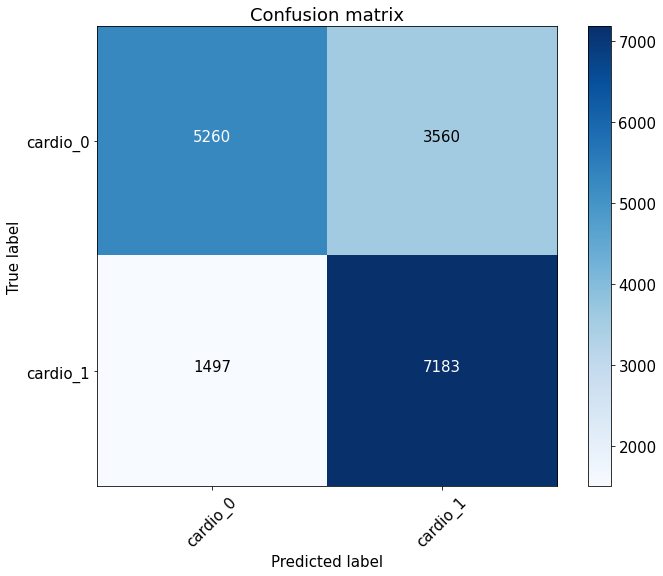

In [30]:
error_matrix(y_test, catboost_predictions, cat_thresholds, cat_ix)

In [22]:
# попробуем случайный лес
forest = RandomForestClassifier()

forest_params = {'n_estimators':[150, 250, 500],
                'max_depth':[3, 7, 10],
                'min_samples_leaf':[3, 5, 10],
                }

search = GridSearchCV(forest, forest_params)
search.fit(X_train, y_train)
search.best_params_

{'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 500}

In [31]:
final_forest = RandomForestClassifier(max_depth=10, min_samples_leaf=10, n_estimators=500)
final_forest.fit(X_train, y_train)
cv(final_forest, X_train, y_train, 5, 'recall')

fold_0 : 0.6887832699619771
fold_1 : 0.6806083650190115
fold_2 : 0.6866920152091255
fold_3 : 0.6847908745247149
fold_4 : 0.6757938771629587
Mean recall: 0.6833336803755575, STD : 0.004634130567440866


In [33]:
# Тут то-же самое. Чувствую наличие какого-то косяка, но не могу понять где он
forest_predictions = final_forest.predict_proba(X_test)[:, 1]
show_metrics(y_test, forest_predictions, show=True)
f_precision, f_recall, f_f_score, f_auc, f_thresholds, cf_ix = show_metrics(y_test, forest_predictions)

Precision: 0.6679951802762073
Recall: 0.8302995391705069
F1_score: 0.740356464122451
Roc_auc_score: 0.8020769394547375
Best Threshold: 0.36773439753597753


Confusion matrix, without normalization
[[5238 3582]
 [1474 7206]]


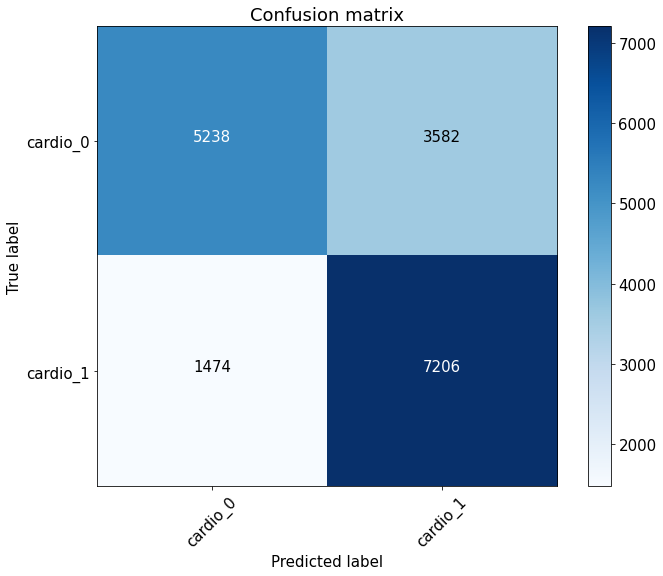

In [35]:
error_matrix(y_test, forest_predictions, f_thresholds, cf_ix)

In [34]:
# Результат почти не отличается, случайный лес буквально чуть-чуть лучше.
pd.DataFrame({'precision':[cat_precision, f_precision],
              'recall':[cat_recall, f_recall],
              'f1_score':[cat_f_score, f_f_score],
               'roc_auc_score':[cat_auc, f_auc]},
            index=['Catboost', 'Fandom forest'])

precision   recall  f1_score  roc_auc_score
Catboost        0.668652  0.82765  0.739703       0.799791
Fandom forest   0.667995  0.83030  0.740356       0.802077

In [ ]:
# Опционный:
#     roc_auc_curve подойдет только для сбалансированных данных.
#     Эта метрика использует true positive rate и false positive rate
#     и если к TPR вопросов нет (это по сути recall и он должен быть устойчив к дисбалансу),
#     то FPR включает правильно определенные негативные обьекты, которые могут быть представлены
#     в большинстве своем нулевым классом и этим сильно увеличить значение метрики.
#     precision_recall_curve этого недостатка не имеет, поэтому при дисбалансе классов она
#     более предпочтительна